# Dependencies

In [3]:
# from kalmanutils import validate_geoms_matrix, interpolate_geometries
import farsiteutils_v2 as futils
import uuid
import datetime

import pandas as pd
import geopandas as gpd

from shapely.geometry import MultiPolygon, Polygon, Point, GeometryCollection
from shapely.validation import make_valid

from matplotlib import pyplot as plt
import numpy as np

import random 
import pickle

/opt/conda/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Functions

## Geometry handling - backend

In [6]:
def interpolate_perimeter(vertices, dnumber):
    # Changes the number of vertices of the given set of vertices
    if len(vertices) == dnumber:
        return vertices
    
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

def align_vertices(interpolated_vertices):
    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        right_vertices = interpolated_vertices[i+1]

        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices

def validate_geoms_matrix(X, aligned_vertices):
    Xnew = np.zeros((2*aligned_vertices.shape[0], X.shape[1]))

    for i in range(X.shape[1]):
        X_0 = X[:,i]
        x = X_0[::2]
        y = X_0[1::2]

        geom = Polygon(zip(x,y)).buffer(0)
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)

        geom = np.array(interpolate_perimeter(geom.exterior.coords[:-1], aligned_vertices.shape[0]))
        geom = align_vertices([aligned_vertices, geom])[1]

        Xnew[:,i] = geom.flatten()

    # X = np.append(Xnew, X, axis=0)
    return Xnew

## Geometry handling

In [7]:
def make_ccw(geom):
    if not geom.exterior.is_ccw:
        return geom.reverse()
    
    return geom

def interpolate_geom(geom, vertex_count):
    return Polygon(interpolate_perimeter((geom.exterior.coords[:-1]), vertex_count))

def interpolate_geoms(geoms, vertex_count):
        
    interpolated_geoms = []
    for geom in geoms:
        interpolated_geoms.append(interpolate_geom(geom, vertex_count))
        
    return interpolated_geoms



def align_geoms(geoms, vertex_count): 
    '''
        Will align all the geometries based on geoms[0]
    '''
    
    # Calculate interpolated vertices first
    interpolated_geoms = interpolate_geoms(geoms, vertex_count)
    
    interpolated_vertices = [make_ccw(interpolated_geoms[0]).exterior.coords[:-1]]
    for geom in interpolated_geoms[1:]:
        interpolated_vertices.append(make_ccw(geom).exterior.coords[:-1])

    # for vertices in align_vertices(np.array(interpolated_vertices)):
    #     poly = Polygon(vertices)
    #     geom = interpolate_geom(validate_geom(poly), vertex_count)
            
    
    return [Polygon(vertices) for vertices in align_vertices(np.array(interpolated_vertices))]

def geom_to_vector(geom):
    return np.array(geom.exterior.coords[:-1]).reshape(1, 2*len(geom.exterior.coords[:-1]))

def geoms_to_matrix(geoms, vertex_count=None, aligned_geom=None, nsamples=None):
    if vertex_count == None:
        vertex_count = len(geoms[0].exterior.coords)-1
              
    assert (nsamples is not None), f'nsamples = {nsamples}, give a value!'
    X = np.zeros((2*vertex_count, nsamples))

    assert (nsamples == len(geoms)), f'Need to fill {nsamples-len(geoms)}/{nsamples}'
    
    if aligned_geom is not None:
        aligned_geoms = align_geoms([aligned_geom] + geoms, vertex_count)[1:]
    else:
        aligned_geoms = align_geoms(geoms, vertex_count)
        
    for i, geom in enumerate(aligned_geoms):
        X[:,i] = geom_to_vector(geom)
        
    return X

def matrix_to_geom(X):
    geoms = []
    
    for xix in range(X.shape[1]):
        geoms.append(Polygon(zip(X[::2,xix],X[1::2,xix])))
        
    return geoms

def sample_geometry(geom, sigma=1):
    sampled_vertices = []
    
    # Choose a random direction
    theta = random.uniform(0,2*np.pi)

    for (x,y) in geom.exterior.coords[:-1]:
        mu=0
        
        randx = random.gauss(mu, sigma)
        randy = random.gauss(mu, sigma)
        
#         # Choose a normal random radius based on the given sigma
#         radius = abs(random.gauss(mu, sigma))
        
#         # Calculate x and y distance for the random
#         randx = radius*np.cos(theta)
#         randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    return Polygon(sampled_vertices)

def calculate_max_area_geom(multigeom):
    if isinstance(multigeom, GeometryCollection) | isinstance(multigeom, MultiPolygon):
        max_area = 0
        max_area_idx = 0
        for ix, g in enumerate(multigeom.geoms):
            if g.area > max_area:
                max_area = g.area
                max_area_idx = ix
        return calculate_max_area_geom(multigeom.geoms[max_area_idx])
    
    return multigeom

def validate_geom(poly):
    poly = make_valid(poly)
    if isinstance(poly, GeometryCollection) | isinstance(poly, MultiPolygon):
        poly = calculate_max_area_geom(poly)
    
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    
    return poly

def fill_null_geoms(geoms, nsamples):
    X = geoms_to_matrix(geoms, nsamples=len(geoms))
    mu = X.mean(axis=1)
    stdev = X.std(axis=1)
    
    added_geoms = []
    for i in range(nsamples-len(geoms)):
        xy = np.random.normal(mu, stdev)
        geom = Polygon(zip(xy[::2], xy[1::2]))
        added_geoms.append(validate_geom(geom))
        
    return geoms + added_geoms

def fill_zeros(A, nonzerolen, nsamples):
    mu = A[:,:nonzerolen].mean(axis=1)
    stdev = A[:,:nonzerolen].std(axis=1)

    for i in range(nonzerolen, nsamples):
        # Calculate uncertainties for each point
        A[:,i] = np.random.normal(mu, stdev)
        
    return A



## Plots

In [8]:
def plot_geometry(geom, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x[:-1],y[:-1], **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x[:-1],y[:-1], **kwargs)
        
    ax.set_aspect('equal')
        
def plot_matrix(X, ax=None, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
            
    ax.set_aspect('equal')

def plot_matrix_ensemble(X, ax=None, plot_alix = None, alpha=0.1, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = alpha, color=kwargs['color'], edgecolors=(0,0,0,0))
    ax.set_aspect('equal')

## FARSITE Forward Pass

In [9]:
def calculate(initialidx, 
              observeidx,
              windspeed, winddirection, 
              usr: futils.User,
              lcpidx='43b7f5db36994599861eec4849cc68fd', 
              barrieridx='cb47616cd2dc4ccc8fd523bd3a5064bb'):

    
    # Setup the input data
    inputData = {'description': 'Maria_2019',
                 'igniteidx'  : initialidx,
                 'compareidx' : observeidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr.calculatePerimeters(inputData)
    mainapi.run_farsite()

def forward_pass(poly, params):
    '''
        params: take values: 'windspeed', 'winddirection' ,'dt' (dt is a datetime.timedelta object)
    '''
    # Parameters to run the simulation
    windspeed = params['windspeed']
    winddirection = params['winddirection']
    dt = params['dt']
    
    # Create handles for simulation
    fp = futils.FilePaths(DATA_PATH)
    usr = futils.User(fp)

    initialidx = uuid.uuid4().hex
    fpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{initialidx}.shp'
    # Creating the shp file for simulation
    gpd.GeoDataFrame({'FID': [0], 'geometry':poly}, crs='EPSG:5070').to_file(fpath)
    
    usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation', 
                                                                                               fpath, datetime.datetime.now(),
                                                                                               'Maria2019']
    
    observeidx = uuid.uuid4().hex
    # Add observationidx only to calculate the dt in the backend
    usr.db.dfObservation.loc[observeidx, 'datetime'] = usr.db.dfObservation.loc[initialidx, 'datetime'] + dt
    
    
    # Run simulation for dt from initialidx
    calculate(initialidx, observeidx, windspeed, winddirection, usr)
    
    # add simulation as the next initial point
    dfsim = usr.db.dfsimulation[(usr.db.dfsimulation['igniteidx'] == initialidx) & 
                            (usr.db.dfsimulation['compareidx'] == observeidx)]
    
    if len(dfsim) < 1:
        return None
    
    # assert(len(dfsim) == 1) , f'Length of dfsim = {len(dfsim)}'
    if len(dfsim) != 1:
        raise ValueError(f'Length of dfsim = {len(dfsim)}')

    usr.db.dfObservation.loc[dfsim.index[0], ['filetype', 'description']] = ['Observation', 'Maria2019']
    

    simpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{observeidx}.shp'
    dfgeom = gpd.read_file(dfsim['filepath'].iloc[0])['geometry']
    assert(len(dfgeom) == 1), f'dfgeom has size = {len(dfgeom)}'
    dfgeom = dfgeom[0]
    return Polygon(dfgeom.coords)

## EnKF Update

In [10]:
def update_EnKF(Xt, Y):
    nsamples = Y.shape[1]

    xt = Xt.mean(axis=1, keepdims=True)
    y = Y.mean(axis=1, keepdims=True)

    Ex = Xt - xt.repeat(nsamples, axis=1)
    Ey = Y - y.repeat(nsamples, axis=1)

    Py = 1/(nsamples)*np.matmul(Ey, Ey.T)
    Px = 1/(nsamples)*np.matmul(Ex, Ex.T)

    Pxy_inv = np.linalg.pinv(Px + Py, hermitian=True)

    assert(np.allclose(np.matmul(Pxy_inv, (Px+Py)), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

    K = np.matmul(Px, Pxy_inv)

    # Note that Xt has additional +2 in it
    # Remove that with the matrix C
    C = np.eye(Y.shape[0], Xt.shape[0])
    #### Update the state ensemble
    # X = Xt + np.matmul(K, (Y - np.matmul(C, Xt)))
    X = Xt + np.matmul(K, (Y - Xt))

    ### TODO ####
    # Fix invalid geometries

    # X = validate_geoms_matrix(X, aligned_geom)

    return X

# Start

In [8]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

# Create handles for simulation
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

# ignition is a 100x100 square from the centroid
cx, cy = gpd.read_file(usr.db.dfObservation.iloc[0]['filepath'])['geometry'][0].centroid.xy
cx = cx[0]
cy = cy[0]
size = 100

# wind speed and wind direction for ground truth are set for each simulation
wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

Database interaction not yet implemented. Use pickle file for dataframes instead!


## Ground Truth (Reference) geometries

In [9]:
poly = Polygon(((cx-size/2,cy-size/2), (cx-size/2,cy+size/2), (cx+size/2,cy+size/2), (cx+size/2, cy-size/2)))
# Run for 24h every 5 minutes

### Run forward simulations

In [10]:
ground_truth_geoms = [poly]
for ws, wd in zip(wslst, wdlst):
    params = {'windspeed': ws, 'winddirection': wd, 'dt': datetime.timedelta(minutes=30)}
    simpoly = forward_pass(poly, params)
    ground_truth_geoms.append(simpoly)
    poly = simpoly

Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '417dd52cdc784362a15f216d748cfb60', 'compareidx': 'e9142fdc97d44fb0ab7dd87baea55b16', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'a40f51cb398f4d8faeebc97beff3ad49', 'compareidx': '13838cfbbc2a4ae2b671af3d5c1bd61a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bc1d2b2be0d54723a05ee193999e2da5', 'compareidx': 'b7bd13c50ee8472ba8313e6800a8bc6d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'dffab7aec0ae48ae8905974713f51a13', 'compareidx': '24c155a3701e4fdba8694bc18dcb9c89', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd44b6900f1d2408da8e69baf39db73a0', 'compareidx': 'bbf8a6cf5547483b8bb713d6099c4777', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'c9ca2eda13984089a392acf6be54bb72', 'compareidx': 'e000ecaf5550441792829e308dbb8429', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '7aa58622a68e47dd993aa6c0a5ea4107', 'compareidx': '190aca558d0a43fabda410352747e03f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '0b91486b0f654926b3ec7a8e8946d56c', 'compareidx': '38773d125a584584a7a2d8f317c3c71a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e123301d7faa41b3a813bb51783b1740', 'compareidx': 'a75202b09e6c4681924ac6fb3696058f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '1dd886beefc848c6831ee2f4549daf80', 'compareidx': 'eff7052ca3c44f159ae7e7ae99df9fa4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '7243a9053f3346e3be27a99aea93d460', 'compareidx': 'd07aace0a2f44967869c1de536d1b417', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


### Validate geometries

In [11]:
ground_truth_geoms_fixed = []
for geom in ground_truth_geoms:
    poly = validate_geom(geom)
    ground_truth_geoms_fixed.append(poly)

## Observations (deviated and downsampled)

In [40]:
pobs_ignite = 1000  #Shift x,y randomly with stddev
pobs_ws = 2
pobs_wd = 50

# Shift 400m to right
shiftx = np.random.normal(0,pobs_ignite)
shifty = np.random.normal(0,pobs_ignite)

initialidx = uuid.uuid4().hex
fpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{initialidx}.shp'
poly = Polygon(((cx-size/2+shiftx,cy-size/2+shifty), (cx-size/2+shiftx,cy+size/2+shifty), (cx+size/2+shiftx,cy+size/2+shifty), (cx+size/2+shiftx, cy-size/2+shifty)))

### Run forward simulations

In [41]:
observed_geoms = [poly]
observation_params = []
for ws, wd in zip(wslst, wdlst):
    wsobs = np.random.normal(ws, pobs_ws)
    wdobs = np.fmod(np.random.normal(wd, pobs_wd)+360, 360)
    params = {'windspeed': wsobs, 'winddirection': wdobs, 'dt': datetime.timedelta(minutes=30)}
    observation_params.append({'ws': wsobs, 'wd': wdobs})
    simpoly = forward_pass(poly, params)
    observed_geoms.append(simpoly)
    poly = simpoly

Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '6daac438223e492f9f588856f74e43f5', 'compareidx': '40a64574dfea44a2a122d0ed94178b63', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13.228006544097141, 'winddirection': 339.53561258179417, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'fc6078f2e8974b2f9afc8a614a36e08c', 'compareidx': 'd5d924ea3c3c4b869306939ae039f69e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20.40948540400098, 'winddirection': 91.6638201195243, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '7dbd424622c94f418c8fad8f871f4603', 'compareidx': '360783e74cdf40abab7cf441f2db3607', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17.88811000748082, 'winddirection': 26.749386208557212, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '725b63609f82432b95a3c4ac7ab3a207', 'compareidx': '4b0e4b99b0a142d7be863554aab232c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24.621599647588866, 'winddirection': 17.05835515139313, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '316d2562d7ff48db9ac26177c28e7f7b', 'compareidx': 'a60baa839aaa4dcc9db6c247449d564c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17.754572619213096, 'winddirection': 1.3477027318877504, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'baca9d558c5e4ca1bafa879e25eb6f25', 'compareidx': '6ade86a4a15d49df83a73c152db9091b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20.30621945156683, 'winddirection': 336.83250449478714, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '761d6fc9c919490e9f955a73ee386613', 'compareidx': 'a39853ddd06642c9803db0b6d423719f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15.956802190529322, 'winddirection': 338.6188015891117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '6c83f5e72d7647d78de9a187f120b981', 'compareidx': 'a6ada69091664f949067b26da4ca863a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11.972977012677303, 'winddirection': 356.9048700642809, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'becd9141a35c42ba92fc994afb7c5e57', 'compareidx': '94ebfdfa7c714e89be90c8e86eca04c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16.826876771904672, 'winddirection': 84.8268561390841, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5781ab0a1f814446a2aa4cb0336953f5', 'compareidx': 'e1c728196a8e44d3874ea833f68cfa52', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14.71598005368766, 'winddirection': 60.56966042945578, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'a0fb50aff5034e9eb01198b431254982', 'compareidx': '9901c76acfe140b599b12bcb60938247', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12.405664169043039, 'winddirection': 301.78605845906196, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


In [42]:
display(wslst, wdlst)
display(observation_params)

[11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]

[37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

[{'ws': 13.228006544097141, 'wd': 339.53561258179417},
 {'ws': 20.40948540400098, 'wd': 91.6638201195243},
 {'ws': 17.88811000748082, 'wd': 26.749386208557212},
 {'ws': 24.621599647588866, 'wd': 17.05835515139313},
 {'ws': 17.754572619213096, 'wd': 1.3477027318877504},
 {'ws': 20.30621945156683, 'wd': 336.83250449478714},
 {'ws': 15.956802190529322, 'wd': 338.6188015891117},
 {'ws': 11.972977012677303, 'wd': 356.9048700642809},
 {'ws': 16.826876771904672, 'wd': 84.8268561390841},
 {'ws': 14.71598005368766, 'wd': 60.56966042945578},
 {'ws': 12.405664169043039, 'wd': 301.78605845906196}]

### Validate and downsample geometries

In [72]:
observed_geoms_fixed = []
for geom in observed_geoms:
    poly = validate_geom(sample_geometry(geom, 250))
    poly = validate_geom(interpolate_geom(poly, 100))
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    observed_geoms_fixed.append(poly)

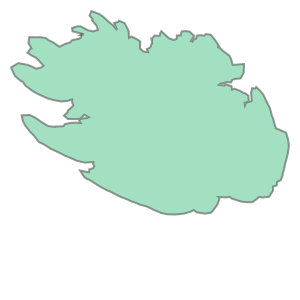

## Plot Geometries

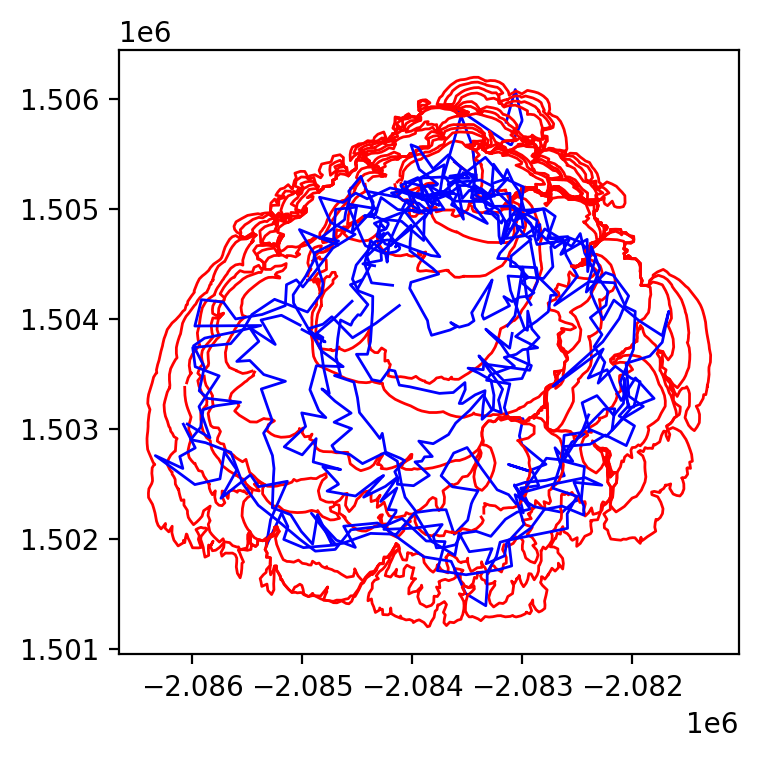

In [76]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for geom_truth, geom_observed in zip(ground_truth_geoms_fixed, observed_geoms_fixed):
    plot_geometry(geom_truth, ax=ax, color=(1,0,0), lw=1)
    plot_geometry(geom_observed, ax=ax, color=(0,0,1), lw=1)
    
    assert(geom_truth.is_valid), 'Ground truth Geometry is not valid'
    assert(geom_observed.is_valid), 'Observed Geometry is not valid'
    assert(isinstance(geom_observed, Polygon)), 'buffered polygon is not a polygon'
    
# plot_geometry(Polygon(gpd.read_file(usr.db.dfObservation.iloc[0]['filepath'])['geometry'][0]), ax=ax)
    
ax.set_aspect('equal')

## Simulation from the first observation


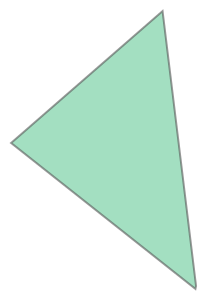

In [74]:
observed_geoms_fixed[0]

In [75]:
zero_information_sims = [observed_geoms_fixed[0]]
zero_information_params = []
poly = zero_information_sims[0]
for ws, wd in zip(wslst, wdlst):
    wsobs = np.random.normal(ws, pobs_ws)
    wdobs = np.fmod(np.random.normal(wd, pobs_wd)+360, 360)
    params = {'windspeed': wsobs, 'winddirection': wdobs, 'dt': datetime.timedelta(minutes=30)}
    simpoly = validate_geom(forward_pass(poly, params))
    zero_information_sims.append(simpoly)
    zero_information_params.append(params)
    poly = simpoly

Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '56a0141b1d064c0ea78aaf377c288555', 'compareidx': 'cda90e56d52e45f78a2a6351fb36dc34', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16.69974500886908, 'winddirection': 65.87615772706158, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '606642da88464c7f9460ad81dca8771b', 'compareidx': '7fa701fdd9a1424497c8150af9ba98ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18.158135696581795, 'winddirection': 283.9343294562703, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '11453b2ee7f3437894d2e6bc51c33277', 'compareidx': 'fdee891a681c48fbb1eddcac3288868c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16.097095328222498, 'winddirection': 54.74053446181961, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '2a4c3cd5ea264dcdb9fbadfa6ff4688d', 'compareidx': '8240a262a39646b68e0421fa980951b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25.26362529926079, 'winddirection': 19.989741664206974, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3472f9e089f448928d13918d6a26a5c3', 'compareidx': '8929510c47504a608f66404149d29ebd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17.29648083207711, 'winddirection': 291.8531901124119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '0f09d5693f6f4981ae87aec0fdd502d1', 'compareidx': 'a1036fc5b40c481d9b6eeb780987f174', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21.455606330210962, 'winddirection': 60.41641095763384, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd573bfdb6ebb4a509332a01fc6a015ff', 'compareidx': '0ea748e51e8b4d14b9de7bb772ef731b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13.21686065272908, 'winddirection': 15.669829769410853, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '956a7d29f7b44da19f6331f06c2d1ed5', 'compareidx': '7aab504a86fe4fd3b98c2a3b4ca9f43a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12.729494585405844, 'winddirection': 291.4920016707906, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '39bf5a5f4eb64b0d9afa92078983a4b0', 'compareidx': 'fe540b14c1c1408f9a176862d61ba843', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15.098199319218748, 'winddirection': 341.3388743903267, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'b7b3eded1830425196da4451926cdf5c', 'compareidx': '07a4af282582438cb01f8dd3d5b10cab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12.285800083176422, 'winddirection': 12.379098805234435, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '6dfb6ed66d43425e91df22dbb5b3e93f', 'compareidx': '26b697c93b704b02a456576c03f6fbe3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16.30219576176645, 'winddirection': 357.0212989683673, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


## EnKF Update runs

In [147]:
# ws = 10
# wd = 60 
######### wd and ws to be chosen from the runs during the live fire
nsamples = 250
vertex_count = 100

data = {'calculations': [],
        'parameters': {'nsamples': nsamples,
                       'vertex_count': vertex_count},
       }

penkf_ws = 2
penkf_wd = 50

In [148]:
# for upix in range(len(wdar)):
#     sampled = sample_geometry(observed_geoms_fixed[1], sigma=500)
#     # Validate sample_poly
#     sampled_validated = validate_geom(sampled)
#     # Interpolate
#     sampled_validated_interpolated = interpolate_geom(sampled_validated, vertex_count)
#     # Validate again
#     sampled_validated_2 = validate_geom(sampled_validated_interpolated)

#     Y_geoms.append(sampled_validated_2)
    
# Y = geoms_to_matrix(Y_geoms, vertex_count=vertex_count)


In [149]:
%%time

for upix in range(1,len(observed_geoms_fixed)):
    print('------------------------------------')
    print('------------------------------------')
    print(f'Calculating {upix-1}-->{upix}')
    print('------------------------------------')
    print('------------------------------------')
    
    # Generate samples of (ws, wd)
    wsar = np.random.normal(wslst[upix-1], scale=penkf_ws, size=nsamples)
    # wdar = np.random.uniform(inddirection-45, winddirection+45, size=nsamples)
    wdar = np.random.normal(wdlst[upix-1], scale=penkf_wd, size=nsamples)

    if upix == 1:# First ensemble, use generated samples from observed geometry
        initial_poly = observed_geoms_fixed[upix-1]
    else:
        # TODO: average of the state matrix
        Xmean = X.mean(axis=1)
        x,y = Xmean[::2], Xmean[1::2]
        initial_poly = Polygon(zip(x,y))
    
    Xt_geoms = []
    Y_geoms = []
    for i, (wsflt, wdflt) in enumerate(zip(wsar, wdar)):
        wsint = round(wsflt)
        wdint = np.fmod(round(wdflt)+360, 360)
        
        print(f'-- {upix-1}-->{upix} --\nCalculating wd={wdint}, ws={wsint} - {i}/{len(wdar)}')

        
        xtgeom = forward_pass(initial_poly, 
                              {'windspeed': wsint, 
                               'winddirection': wdint, 
                               'dt': datetime.timedelta(minutes=30)})
        if xtgeom is not None:
            Xt_geoms.append(xtgeom)
        
        sampled = sample_geometry(observed_geoms_fixed[upix], sigma=150)
        # Validate sample_poly
        sampled_validated = validate_geom(sampled)
        # Interpolate
        sampled_validated_interpolated = interpolate_geom(sampled_validated, vertex_count)
        # Validate again
        sampled_validated_2 = validate_geom(sampled_validated_interpolated)
        
        Y_geoms.append(sampled_validated_2)
        
    Y = geoms_to_matrix(Y_geoms, vertex_count=vertex_count, nsamples=nsamples)

    Ymean = Y.mean(axis=1)
    x,y = Ymean[::2], Ymean[1::2]
    aligned_geom = Polygon(zip(x,y))
    
    filled_count = nsamples-len(Xt_geoms)
    if filled_count > 0:
        Xt_geoms = fill_null_geoms(Xt_geoms, nsamples)
        
    Xt = geoms_to_matrix(Xt_geoms, vertex_count=vertex_count,  aligned_geom=aligned_geom, nsamples=nsamples)

    X = update_EnKF(Xt, Y)
    X = geoms_to_matrix(matrix_to_geom(X), vertex_count=vertex_count, aligned_geom = aligned_geom, nsamples=nsamples)
    
    data['calculations'].append({'initial_poly': initial_poly,
                                 'aligned_geom': aligned_geom,
                                 'filled_geoms': filled_count,
                                  'Xt': Xt, 'X': X, 'Y': Y,
                                  'wdar': wdar, 'wsar': wsar})
    
    with open('/home/jovyan/data/output_reftest_06202023.pkl', 'wb') as f:
        pickle.dump(data, f)

------------------------------------
------------------------------------
Calculating 0-->1
------------------------------------
------------------------------------
-- 0-->1 --
Calculating wd=97, ws=11 - 0/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '88af20c8dd95499886f2e7dc0789aaf3', 'compareidx': '1f100c38c435451eb37d6b094d3f63a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=303, ws=8 - 1/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '170d52ff60514d67923798dac6ecc829', 'compareidx': '9b5c74849c2e41e4971035bc18dcee6c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 303, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=77, ws=9 - 2/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6ec16a934854d1a8e0a836acc4d2406', 'compareidx': '3720cdc86df944edbb8948ed1433f710', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=122, ws=10 - 3/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '133c0f638a444f5a89212c6b5680b72b', 'compareidx': '8475e94793214a478f13afacc631c989', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=47, ws=14 - 4/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '85a2b5cfe7f847669ff45c11329d0631', 'compareidx': 'e8b66cd3694243c18181963df2fac0d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=36, ws=7 - 5/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ad6b10c3e6043558bea344184367393', 'compareidx': '9ad04382ae6e4a3c99455afa0eb62aff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=50, ws=9 - 6/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e583f4f9f5e24e26a85df1990f1315eb', 'compareidx': '9d4538140a084139810b5b9fa355bf70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=81, ws=10 - 7/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4393df4c9e334f428912940eff24fce8', 'compareidx': '83cd95666adc4b03a2da03d1708ccc61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=88, ws=13 - 8/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '56691f676359494199bfbaf7f62a8478', 'compareidx': '962a7d781b2d444c9ead80f1c692b6ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=21, ws=12 - 9/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ae76efe222b5418ba98fffd19fe04cca', 'compareidx': '587b09792b034f9ab55b6601dad7fea5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=153, ws=9 - 10/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '01580dd8f9134b0a88b59c0e550be22a', 'compareidx': '1a6f7ff4f0ee4436bef3b446d97e4390', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 153, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=0, ws=10 - 11/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9859937813bd46c5b5608826a1fbdb95', 'compareidx': 'a1d7f1bd3dda4c5d93da1cf11237f440', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=336, ws=10 - 12/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cac7fb9078144051a3d505326e7cc7b7', 'compareidx': '2cffcdfc56d2491e9123123af4de8b40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=347, ws=11 - 13/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd977b5c534544bfaa63eb86119a2d118', 'compareidx': '652b33504df5428dbd465a25af5fb0bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=117, ws=13 - 14/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c4a544335d794f43bd9f88f5eb83d972', 'compareidx': '9fcd8ef6f2ab483a850f7b4b293dcb54', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=121, ws=10 - 15/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23f24996beda4f6eb82485b10394677f', 'compareidx': 'b0e1b1750d364edda337b33d9e9b1f68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=25, ws=8 - 16/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'e72ea27c8b2e400f97cd63759d9a4758', 'compareidx': '0919110be7494d47b343f447a1bf50a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=81, ws=13 - 17/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7074499623074e9c8da9d3dae36dc054', 'compareidx': '40bf58a018354713a9bc8714f048f81c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=18, ws=13 - 18/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2bbd66b7b8b646cb850518d6c9b9d81d', 'compareidx': '57ec6a61e65e40288f932a8523a3ce67', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=60, ws=14 - 19/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'e916f7e77394497cbff97b59d3074cb6', 'compareidx': 'ac877e415f384387945b2ef5076eace1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=116, ws=12 - 20/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce5a0f40b3474621b5ddca816820f3dc', 'compareidx': '42479a568a00477bb54eb26b60e0cf4a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=2, ws=7 - 21/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cfc34cb57379484c92064807384eb015', 'compareidx': 'f78ee6b651274623a97d6174f7fdd4ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=53, ws=11 - 22/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'db5181ff4a11443daf7b81f18dde04e9', 'compareidx': '1667a53ac5e84e53bd0e48fbd6afcbaa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=42, ws=12 - 23/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5151cd1532d1462d97f400d361476c5c', 'compareidx': '3d705a7cb0294a238e42e49c382ce2bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=318, ws=9 - 24/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3708f2853ccd4a7a858119cc92d164a5', 'compareidx': 'c4ef1dd67c464f87954c616eb9569ecd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 318, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=92, ws=11 - 25/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '67dd42488bad4ae6ad3d3ee1b9956b04', 'compareidx': '4213cd837dae4547abff532898357f0c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=60, ws=10 - 26/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1592ecde747a45febf4c2b43e18a40d2', 'compareidx': '2e17ad857ecc40138433fa4abd402832', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=44, ws=11 - 27/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bd695730323748e6a3af7b4f89bdfa8d', 'compareidx': 'be21e44593ce4658b6a8489e33e38455', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=35, ws=9 - 28/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '948459445d7d4e8abf6d960e2534e4f4', 'compareidx': '9f3cead1b288429789afd088f828526a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=333, ws=9 - 29/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c589bdc1fd6442b98972e4c03ad600c', 'compareidx': '1fb475e96b3f45a1be0a3c75282df38a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=111, ws=13 - 30/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e093b8bdf5f14e1f9f4220e715ed1743', 'compareidx': 'c7f1b27e41044c4bac1c6b964149c2f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=299, ws=12 - 31/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4720fd3f26bc4f3d9dee7654bccabb3f', 'compareidx': '926c419e5b51433f993f9e13e524d398', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 299, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=65, ws=10 - 32/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f8829b1d2104e338fe585425e62c434', 'compareidx': '18621d43facc4d98b08c1ec074451d77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=76, ws=10 - 33/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e4c9e10505045d68bc69d9ef32f2b9b', 'compareidx': '23df6e8547eb467e9ff207462e6f214c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=10 - 34/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce69bfa13f924020bb1829c01389e2f8', 'compareidx': 'd2c3e5618bc648a5aba91d2e0689008f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=55, ws=12 - 35/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de9050c30a004c92b3ae6038e66e84f3', 'compareidx': 'deae503adcb947079279a7a4381ab16a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=105, ws=9 - 36/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '101f2ca6ab9c4457b9056c0092b59b9e', 'compareidx': '42b288ea7ca74110bd6f25defcff236d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=357, ws=13 - 37/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8802d570ab5843618a4f6acea73bb29a', 'compareidx': '14ad7a9934924297a2b26576cd7e4757', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=39, ws=12 - 38/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da67fad7374145af8e964f68fc14fc89', 'compareidx': 'd3cbb48f316840ca8eda25a8ef01d616', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=353, ws=11 - 39/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23e48f8a71d2467e926751e0a488628e', 'compareidx': '52b692414e51412cb7e1b198e3d49bb4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=107, ws=13 - 40/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f993adfb31514a31bcbb4a1b86815202', 'compareidx': 'c497d160fddd49fdbc24962f577e66fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=103, ws=15 - 41/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b3bec2fa70ab40b69ab82e5eb15de536', 'compareidx': 'edc859256e7f409981849d2eccdd2dba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=113, ws=14 - 42/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ee1f6d5afcc74a929e477cc98a204bd9', 'compareidx': '18b65756cab5425cba2e3f1a7eab4ffe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=65, ws=12 - 43/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6d2c492d27b43779d9bb07bd8b74e98', 'compareidx': 'c0c13d24ab144e038b14bdc4f46e0206', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=53, ws=8 - 44/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '864cb81910a34b5f85a13a6c73f2d894', 'compareidx': '8c3f336436f1408c949cce2e4154834c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=358, ws=9 - 45/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a760e189d4c740e78465e880188ad68b', 'compareidx': '6303047b8e704f1ba05761eb34c3f2db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=133, ws=11 - 46/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0ca8734646842649efd7faf0f972c03', 'compareidx': 'bfce14433b4043389164365c9df4d74d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=20, ws=16 - 47/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '326f23bb7eb04e8f8b6b0b5b9b05b2e3', 'compareidx': 'ec61e0ed7065448f93f9271b4e0b0561', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=46, ws=13 - 48/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f8a961ed79224f92b67010f65c293cb8', 'compareidx': '31ad5183635a419fba4613edd0c6d6a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=127, ws=7 - 49/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '527688eb09904f7593519ff24d24310c', 'compareidx': '9886f16d297e4928a451513eee606397', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=353, ws=13 - 50/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'dede7ee28ed649e3afdb206a92ae87e4', 'compareidx': '8e060bcae0a64591baec066a8fd3c71e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=118, ws=13 - 51/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'b06c71dadcf54e9b82f80454e2f30f9e', 'compareidx': 'fbd97ca63f054426a4fd42788d956f76', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=24, ws=8 - 52/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60218abf8e12464fa39202a95783ac20', 'compareidx': '8bf85c4b43d54dd2bf486f0f3687ff4d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=9 - 53/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bdabe0dc071f4e608c42fb45457d4644', 'compareidx': '5c109f77c16d4785a589ee58827f77d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=62, ws=8 - 54/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a04b63987ecc4d5c8908785348f1a26d', 'compareidx': 'de217023938c473a91018afb4b571818', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=56, ws=8 - 55/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '086929710b32409d807af9a5ba65a49e', 'compareidx': 'fe617a480c95460e97a545ad8d2b74db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=71, ws=7 - 56/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ddbaa6d747f141fb990bee1f4fca31eb', 'compareidx': 'c96f86c69f894ebe8abfba4c1a51f2b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=25, ws=12 - 57/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3b0bb48fc63a46f4a93c877e5c7914a7', 'compareidx': 'abdeda5dc519411daf45e94085829147', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=90, ws=12 - 58/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '488fddbbd1b74744ae09d4a678aa093a', 'compareidx': '7b086fe53ce0443a863d9a19d83b89f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=77, ws=7 - 59/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b019cd5ba8a4e2da2bef2beee6c45f8', 'compareidx': '8f340ddc2eb545dfb4d0182f8b7b2fb2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=132, ws=9 - 60/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87515775fa554840b66bfe5c8f313ad5', 'compareidx': '7a8001c1725c41b9a54b5f56e7992a10', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=93, ws=13 - 61/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ef9b5773c5e45fb8bc3ce908226eb2f', 'compareidx': '3707f72c471149dd8112dbad17dbe6f9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=15, ws=9 - 62/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b91759e6c874d3bb721687df4a18ebc', 'compareidx': '0b879295c4374ea29f66a89ecf428556', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=53, ws=14 - 63/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a76020347b084f848c32d7ecacb8432f', 'compareidx': '22705bb9ca584dd792a501d8a1fd06a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=70, ws=12 - 64/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '687c1923edca47029b907ec5ab2247ea', 'compareidx': '67f3639072fd4422a041a77e9e2e91e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=62, ws=12 - 65/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ade464d8d7104d4bb95398c3671dfdb7', 'compareidx': '8991bb327e274d169909197274706910', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=25, ws=10 - 66/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7057a1df68704c8eafba1356f768049e', 'compareidx': '3b2e0db9dbcc42628ad8eb7188f7fcf8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=335, ws=11 - 67/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7918f465fd404a85a3319c355337d5a4', 'compareidx': 'c07d1639e6914a54820424a640db3959', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=342, ws=10 - 68/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b44adce3cc74b949db61e8c2cd7fd13', 'compareidx': 'e427db4bcd3745f0aeb11570f847b153', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=42, ws=10 - 69/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf92676bd4cd42d99d253f38cb488bba', 'compareidx': '6309392ec3a54b80a373b2d7f8930cae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=32, ws=13 - 70/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46b615e6771641d494b50d9611fde20f', 'compareidx': '1d3d5f8b9755490392165a57eb29c9e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=65, ws=12 - 71/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9b47d4656584db6903fef1cf7d7da6a', 'compareidx': '133f232947a14ec6bd756c76175a0689', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=15, ws=11 - 72/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '35bd224bf35e49b8a802ca000718d08b', 'compareidx': '1243dc0d51a7478cb03d6423f88c49cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=270, ws=11 - 73/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8294256582f24177b2aec946e62344e4', 'compareidx': '0dd23b4943f548e8a7a6dfaa21f72795', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 270, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=0, ws=13 - 74/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '270b5831ab7643c3a283253cccbaf53b', 'compareidx': '9fb55e8e44924c85bf96e633c6a84882', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=31, ws=10 - 75/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d766a9107664f08ad3869ec50762dd5', 'compareidx': '340b1cb31d0b43dc9fda7c02903a23ea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=47, ws=12 - 76/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1f638eb20814b28bc75b00040f51246', 'compareidx': 'c83e1ad2b29c4c7896570f1b76e9186e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=341, ws=12 - 77/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7936aff7e7074e2c9c637dc0a2e7ef2f', 'compareidx': 'f5fe5e31d65a445d974935a93d4cd1ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=88, ws=12 - 78/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '622079fb2e8a4066b24124c36da9cb12', 'compareidx': 'cca3b6898ef44532b08ad530a01ad2f9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=101, ws=9 - 79/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8aa3624bc174ecaabc857507f817325', 'compareidx': '572f49164fd3453995f32b73c3ea822d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=84, ws=7 - 80/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97d8cf46bf7f492abc7765cbc25eb9f7', 'compareidx': '3983dc9716974cbdae359919805739bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=351, ws=9 - 81/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a8cf2b83f0934225a989e0ad16de9f64', 'compareidx': '018614e2b89c41a5887528a213a60be6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=96, ws=13 - 82/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b836a5cf449040b4915dc246d4901871', 'compareidx': '7067e136be0f44e291b1cac2748d13d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=80, ws=13 - 83/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '020e602923494283bed283d86a6edd6f', 'compareidx': '185fb833d7944ce9b844153527b9460f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=75, ws=10 - 84/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e6571a674b14da6bdf35658e206e429', 'compareidx': 'd1d12a8b3fa94f38affb3c0c36c24b79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=22, ws=9 - 85/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e3e7f1ff161b4153911f5c46c4d06f5e', 'compareidx': '73b34672ae344e69af7b9cab6638614f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=73, ws=10 - 86/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6635d120f10f41aba201e1e53dee3dac', 'compareidx': 'd2b1d013f1df400b8d16a3d000df6236', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=336, ws=12 - 87/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f36d1783ba84047aafc5ba04c856fd6', 'compareidx': '62fc380e34554e869c3eb67769428258', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=9, ws=15 - 88/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '51459e66606946629c456940cde29be7', 'compareidx': '46a59c8ad36c44c29842c66de3a1f89c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=46, ws=9 - 89/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '33ebf5177bba49e98aa9c1a8d9d145a8', 'compareidx': '731ee10fc5ac46c9abdce80f570f3fa1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=61, ws=11 - 90/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a8b76c10fe844c3a69394b7b1d4bfd9', 'compareidx': '8edb49d36e9d4afa9346bcfde2309605', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=122, ws=11 - 91/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b50ca1b5e5648579e2697c8a02dcfc3', 'compareidx': '71a38633b9d8419686252cfb8190342a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=13 - 92/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c092d8de5f3b42799f1073baf5d7fd43', 'compareidx': 'afeea268c5b541b48aeafcc115fd7411', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=12 - 93/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a445bb2cf4e4663a9fe3949bf78a0db', 'compareidx': 'c500bf22ffe549f2ab496687897d2975', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=10 - 94/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fdc36f74e1194991b1df4a4aa43d3f69', 'compareidx': '88b5bd9b62c94e4da953aa95eee009f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=8 - 95/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a565e37b6f7c47bf9ce3ed4bc935480d', 'compareidx': '761117dd7e35426eb79a44ea4ce08258', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=39, ws=11 - 96/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9fb0e18e50c49be9458391eb2a2e4b4', 'compareidx': 'dd67f0f9f34841d2a6c6b31195211f80', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=348, ws=12 - 97/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '62f24c5d70084a6f8a004b03f0f03348', 'compareidx': 'b7a1622d549b4be09de13bb4ddc2eaf0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=14, ws=8 - 98/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f3e4cf393a074e1b889ca05b27dd75b4', 'compareidx': '2181750cc9bf493aa3158b118892e686', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=84, ws=7 - 99/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cbf9844d1432464f8e1dff9cdb5d3946', 'compareidx': '20fed907c3124451a933e1cd6baaf0f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=357, ws=13 - 100/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce6cdc61364e4809b49a7e8927194bce', 'compareidx': 'bbbf0523104246fa9e8714e6726835a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=51, ws=12 - 101/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7cb935a45614c03855f8a1609695a02', 'compareidx': '2a901384f3984c4b908e34302bddbe3e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=86, ws=11 - 102/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3729768db3c94cbc987e4fe29a0ede17', 'compareidx': '0aa19be99b7a42cb8faf10ba80f5efae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=46, ws=8 - 103/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75bd2b420cd44539b03535297396591e', 'compareidx': '10b4c82cebe0430a943d7f91be1795f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=350, ws=14 - 104/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6975615b11f84ea394c5d32b6c0fe239', 'compareidx': '1747a4502eff440abd1c018f3cad8ce3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=143, ws=9 - 105/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9cf277d70d34b2c89b82429b4f702fd', 'compareidx': '7e96c774aad74b27a0fbe1ea22d29c43', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 143, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=97, ws=7 - 106/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0eaeef87c574014824bebcd5b385ab7', 'compareidx': '7cf4e3408d3f4c99ad5756249c2c8552', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=5, ws=12 - 107/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9db4d4add17b4ed0b1519ea0a2723693', 'compareidx': '032ac51859b345aebb607418285ed97d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=96, ws=15 - 108/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9941368e2f4041ef841644aaf63c05e8', 'compareidx': 'a25dccfdd8fd412889f27825e6766a33', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=83, ws=11 - 109/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c853907eebc34345a82f9c6e1ea0b7dc', 'compareidx': 'c2b92d133e5f47a4b26c2742b3aec373', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=58, ws=8 - 110/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b92cda3e7c1c4fbc95d9a9290d1cab34', 'compareidx': 'adc344a1077f4fbb81d09389d6477726', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=99, ws=9 - 111/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '50457826db014fbe89f818f5710725b9', 'compareidx': '159392c35c454b338d4417c9ab784474', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=342, ws=9 - 112/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96a7bdf60f8a4e39a75cb9e289f0e7d7', 'compareidx': 'b499783bf0184807856d4f8a27a6cf40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=99, ws=14 - 113/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c05790fb2bf945ab9e90bd191870b1b1', 'compareidx': 'a31a225a3215456ea53bd756cfdf2f4e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=46, ws=7 - 114/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a558ce54ddd14515a6567f60916a9073', 'compareidx': '4687904e70a5493c9e222f25fb846cf5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=12 - 115/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'b8ba28e24f4547e4ad94d04f9b0e98be', 'compareidx': '43461ab8d73049a7a4efda443f707746', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=298, ws=14 - 116/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce05307c1ace448ab125af9c563fee7a', 'compareidx': '3d4ad4797473455ebaefa2851f9a487e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 298, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=120, ws=12 - 117/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '69514d3333d242498a1e96c4b245da1b', 'compareidx': '5eca6d33aede4b2183cde6d85eb28fa3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=124, ws=10 - 118/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4383b24e28e546d387e97861c32fc210', 'compareidx': '8d94eadf638c4eb49dd5bdd8fedf8694', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=345, ws=15 - 119/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a791a062aa5483d9fd9d2230017c0d4', 'compareidx': 'afb1ed418ab44ea3bab3accd03779f8b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=75, ws=11 - 120/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36f77e3391114bdd982fe379069acac9', 'compareidx': '85f3037a047a4a578b344f6471e138b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=343, ws=11 - 121/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4080fbd2dd2f42c8b45102a804cf5998', 'compareidx': '0ad0d590b47048c1b8a5fd4d7ddbf4ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=343, ws=12 - 122/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '066363f6c30843f1a37a5680467dfaa9', 'compareidx': '69c8dc464f844f75ae06cb92b6e42f8c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=334, ws=12 - 123/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed52c59bc3514ac0bdb48edb45982ac4', 'compareidx': '87decfb7c62f44fbafb48a6be9b87208', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=332, ws=10 - 124/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f7b362f791334ac8b64f91b227c69cae', 'compareidx': '644b6fefdd3b40e0a1f4ca9066d9b2f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=343, ws=11 - 125/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ead53c8928747af95063dcdcb95a313', 'compareidx': 'adcd0e2dd6d341dc8a11667bcd7b71e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=106, ws=10 - 126/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2cb80cc471df4a25a9d3981cfe3a9324', 'compareidx': '13e7a32830f34b4cbdafb935e662a058', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=56, ws=11 - 127/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8278fd96d36c41edb1ea8ad5db26fc11', 'compareidx': '074b7d2dc72c4441a2c52ae6c9d912bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=43, ws=11 - 128/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e33c955198dc4b219bb1d2e3736ba70f', 'compareidx': '50e3189b821f483696f36476e75b4749', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=44, ws=11 - 129/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0e537aaba5a465d943e0d066c54103b', 'compareidx': '800544df73b34d23ac2af89c54b958d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=17, ws=13 - 130/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12f460b1cea9406a9d6aacbee6a0df37', 'compareidx': '48e2d86726b94e79becc85cde20310d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=358, ws=9 - 131/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '38e9e8afe8f24bddb7ddd5cded537cf4', 'compareidx': '8aa3fcbb7dad47d5a7b1b0a23514e4cd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=58, ws=9 - 132/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '62f3e84c50ed4901814db99af6abf16e', 'compareidx': '8322eb182dfe42efbe9f399a3b8cd382', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=87, ws=19 - 133/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e13c09ce17a845b2896b1a1da7bdd669', 'compareidx': '836e5be8d0db4b42ba732d1234078edd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=37, ws=11 - 134/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '68364b7e17f543f2b800868bd85cbe08', 'compareidx': 'c520a69a8de44266aba78ca6d4be2331', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=22, ws=14 - 135/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1febda150bca4abb88ee4f7b9dfde108', 'compareidx': '1d6e0e18ef1d4b36ac5945560fa735f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=354, ws=9 - 136/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bfd467229b76490789b10849ba9a18a0', 'compareidx': '547f4f37e29d4156a4c86227c804153e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=31, ws=12 - 137/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '236d52908e7746e78989998b53aced9c', 'compareidx': '3f179ebe8b3c4105884fc22c5b2ce5a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=11 - 138/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ee20e261de6d4709a0cd17c25c401a69', 'compareidx': '585b939f89e5453496181f9d3884fd12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=87, ws=10 - 139/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49f44a15b0a34f29927cb410e25c2180', 'compareidx': '46c207d8bad64c748fd73f8b33eeca24', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=22, ws=15 - 140/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '740ab011ba3e46f28655ca60ea66980f', 'compareidx': 'b7364cc775354f9bb96e2179ce4d83a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=0, ws=11 - 141/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e31311559c5f42478e419de45b4b3175', 'compareidx': '58da1f09eb3c41c9b431f42b371f0020', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=1, ws=12 - 142/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '450e17f1bb614873a25752e7f80fa705', 'compareidx': '96ad7cb60d564d41b2681850a65a7935', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=67, ws=8 - 143/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11be276949fe408da0d23cada3881985', 'compareidx': '08b5e3bd53c140149547cc4437f45bc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=50, ws=9 - 144/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ae874ed8fda54d23ae63a8c38099b7e7', 'compareidx': '4d25171c11474322a1bcd423d9122602', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=95, ws=11 - 145/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9fd42e51f874515bc9c34bfbdcb098b', 'compareidx': '5b44afdf126148148a141d5930914d1f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=26, ws=9 - 146/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e78f82ec42f64042a00e020f26e1e2ea', 'compareidx': 'b546f53e552546f190db1945f3d7a732', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=43, ws=8 - 147/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5311913326a45369ebb64ae24b81635', 'compareidx': '15685245307e4234b2d14f8b3baa0e18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=51, ws=15 - 148/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f37821f52234d189909f805ed5cfa4b', 'compareidx': 'edfe797bcf7c479da9103faf579dffe7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=27, ws=11 - 149/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '112f28fdc3ed412ea8c9a86be84a2a10', 'compareidx': 'd859b8a14fae45f2b5f708140831817e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=70, ws=12 - 150/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d95ae69d6eb454c88d9d02b3c70d433', 'compareidx': '6bc61290b44f49a69278dc85e7bb7d04', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=5 - 151/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0527e562f1b34be5986587581483dacf', 'compareidx': '792a569e271b451199def1852c2a1327', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 5, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=163, ws=12 - 152/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b364c495362349ca80eef6b30d7bd258', 'compareidx': '08fece53b3cb4c9fbdae420f4c3c37b3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 163, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=82, ws=11 - 153/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41610690369743acbd52d26d61ea3788', 'compareidx': '0c3a20a451b24a73a4180969d93d97fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=4, ws=11 - 154/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c220c4171a684190b14c6588712739b1', 'compareidx': '40f9d1cdfb444dae869056e479dc3219', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=42, ws=13 - 155/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a3a68cb36bb4d2bb318e6674475b72e', 'compareidx': '2ca87d53f91144899becfb0420f6ecce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=3, ws=12 - 156/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58a0087aac244b4b809944a0fc5e940a', 'compareidx': '6727bc92429c468596286311e6e817cd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=80, ws=10 - 157/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7e003ac207d44efbb38229da0ca10cdc', 'compareidx': 'a9f7588f773d4c5498619688ad5b1ed0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=51, ws=9 - 158/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c06099276674faab221b527a3ebfacb', 'compareidx': 'c1719d82862642b9868560e69876bfc5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=278, ws=8 - 159/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a309cef7612c4b188494ffc4ec6b6d0b', 'compareidx': '0bb78b119ad144faa77bdbc6c661bf66', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 278, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=18, ws=8 - 160/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95d33135f8a64c60875ee16e6fa9bc4f', 'compareidx': '447eeb267e504250ae15935bfb2874c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=94, ws=12 - 161/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c957046fbc40437dae7bd2d2bf583be1', 'compareidx': '9a63ba7ac81e4dcd95c332c5f6f195d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=35, ws=11 - 162/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3b784f4faba843e18a5f03cf4f2dd809', 'compareidx': '3b8afc828a454e65abbf015635a5cb5a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=40, ws=10 - 163/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5f73f862dad4ca79c2e4266f16904e9', 'compareidx': 'edc82257723a4041b5c7d8703776c20f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=51, ws=10 - 164/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7fff90f859546efbc62f0477f69efae', 'compareidx': 'e97812b774ba4acea1f8e3816df61443', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=48, ws=12 - 165/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4321998519304a69bd962f675bd32cef', 'compareidx': '485e705269b948448540af6175058979', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=7 - 166/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1eac788ba8f4e89a1d451d290843605', 'compareidx': 'c13e9ee89abd4501b9aa4e4cf63577c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=301, ws=9 - 167/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'e8e9f38b6e7c4d7a9f581f78111815d9', 'compareidx': 'd4cb222f547c4f389cddfb374e94c4ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 301, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=95, ws=14 - 168/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'ec6c7f92699c42b288a65d40c49695b7', 'compareidx': '682d8dc6ea484272bcff79c47d9d1151', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=11, ws=10 - 169/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b76588a704fd4c2fa312e5bcd0316a9e', 'compareidx': '37bae23af2c746859773e084b95e4014', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=356, ws=11 - 170/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd68ad884c8444d08bf024b2213dd94bb', 'compareidx': 'f4fe6db5e9a344f39ecd91ffbaf933fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=125, ws=11 - 171/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ff204e54e3f48e59f4bee26bf45dfb7', 'compareidx': 'cb069420ece444cfb2be37c001defbf7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 125, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=51, ws=12 - 172/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f2efbe30e9de4f84b706645d5d134179', 'compareidx': 'dcf760c282874555b0d96f507bdf0b9f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=25, ws=8 - 173/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4da00717ca4e499c840a950c35052068', 'compareidx': 'cfdd2002c7484f23aea894e8cf79c2fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=105, ws=7 - 174/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4e001478c91645afb1ea6892cc029c42', 'compareidx': '94092b2e360f42a99643bc78e707cd83', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=330, ws=13 - 175/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04e7347e3bfa42748a3b3cbba4ae6d02', 'compareidx': '7ad8730192c64d0bbf51da9d950a043f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=7, ws=11 - 176/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95774dddbd2245499c344fa56391a5f8', 'compareidx': '937274c49bd84ea2a6397c3922aa2b07', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=44, ws=10 - 177/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8fe0df9a85d94baabf7cdbe5e507a484', 'compareidx': '112ca9b8820641fe8b08d571d00c055d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=278, ws=9 - 178/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd6c4ac1903264bc2becc01a82048f29d', 'compareidx': '588addd111cd48f6a2ee1d039519e2f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 278, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=57, ws=13 - 179/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c75e49822a542d685243ec67b3e3d0d', 'compareidx': '1f04243d2d024f46bbd39aed7cf3434d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=98, ws=14 - 180/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '248def2e94474b76b4b71a0e82fdb5ee', 'compareidx': 'adddd947ab66411bb78c75dcf183ef89', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=64, ws=12 - 181/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e5d801f65e241ef8753201f61332b27', 'compareidx': 'af7f5479fdc945aa92a70a72f85705b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=147, ws=13 - 182/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1829545eebce4df7971ae87ecf8165db', 'compareidx': '3f2a38d81f444902822a40f87af43022', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 147, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=347, ws=8 - 183/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6248893343d48aba7dd448053f36acc', 'compareidx': '5cee2357e0de4eb493de8d10d7693c17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=110, ws=14 - 184/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3023161ca6424ea296231c36c6114f9c', 'compareidx': '9ed00f27b27a4cc2816a584195180e9c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=122, ws=13 - 185/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83239685fdaa4a2a96521493914889d0', 'compareidx': '61e8cd578e3c486d8b652f678af008fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=97, ws=9 - 186/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4173528228754c718c70ebb9bbc2d3e3', 'compareidx': 'a4577efef6724f55aa01bd05ae3b324c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=355, ws=10 - 187/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b5e3647c203463cb1536728d5cf25d3', 'compareidx': 'e8697eb1fa074b50aec0db88e6767841', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=140, ws=11 - 188/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1895c8da41f4d99b45d4cc5412e01ef', 'compareidx': '99dcbd0dbf27458f8f8c1b4ee1bfe468', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 140, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=89, ws=6 - 189/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ded2398847a464ab335a7f0751e767c', 'compareidx': 'cb1c0f8ef9d2473791166589c7c3221d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 6, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=67, ws=9 - 190/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87e7a4f6e0a64679a6c289a48b9ed15e', 'compareidx': '343c532d1fd14a56995bdc5d45009dce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=320, ws=17 - 191/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '720552b464fa4a4baf1a3e6ce2b89f83', 'compareidx': 'f95c53563b354c87b07a0bb8ccbe45d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 320, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=8 - 192/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e403f4fe2684fad917be005fe315e22', 'compareidx': 'a90e8601cdfb48c9b8393c95b92015ec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=119, ws=12 - 193/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '99d9d0d15f7c4235a46b1e1e24270f5c', 'compareidx': '17d8a9350c8b4beb99c548b360ac799c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=16, ws=13 - 194/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e983621f02b44daebd97650aff464a69', 'compareidx': '90d23d8e4f77426486420459adf4b8da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=70, ws=10 - 195/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6ed231eacd4f4dbebc91d7f184426500', 'compareidx': 'e5660abe672f4d1591034f1672042c35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=359, ws=10 - 196/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3eee9ca67d254f81a82726cd405ec778', 'compareidx': 'c1c271d4aea943a18f35a6060f656cf5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=45, ws=9 - 197/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b23909f80ee48e787e5edb64cab2743', 'compareidx': '64084cb12a1b4f38892ced180b924e0c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=135, ws=9 - 198/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cee7e849ea0b4d3f910032e38a225ed3', 'compareidx': 'ea5efed5b4ed47f89474964375222f97', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 135, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=48, ws=15 - 199/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f6b85822b9c464c85c050243c527939', 'compareidx': '182aa8ac9a7b43da90e04101fdb066aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=45, ws=10 - 200/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '174bcf57f53b4fd285fc028f481a226b', 'compareidx': 'd42955e96bcb44ee970b0fddf42c8301', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=16, ws=11 - 201/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da1a8208665f47b5966be7b261f49a5d', 'compareidx': 'c400cb374dbb42c89450e67915f7f4ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=46, ws=9 - 202/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb60342162d642b3866432926ddb850f', 'compareidx': 'c6888458df3b46bea1c07d79fabbf4f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=23, ws=8 - 203/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5fcc073eb89044f2b743d5d617bb517e', 'compareidx': 'b801cb249c87465ba0a5b6e030209b0e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=4, ws=11 - 204/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '521fa1d39f764ed5ac2ffbed85286d78', 'compareidx': '0c5747fc1e124769bacec63fb5d5a69a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=79, ws=11 - 205/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed3ab54aec444297a1c3eb2e29fc10a4', 'compareidx': 'c89693ab5c7e4f1db0205bc48be1cf8f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=86, ws=6 - 206/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1e7d1a513434359af68aeaf44da9de0', 'compareidx': 'e12875f275b74b2dabb76862e5930315', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 6, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=8, ws=10 - 207/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60184c1f389249c491bf3811713461b9', 'compareidx': '53b2a50888b54a79924f847bc3cc7e16', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=352, ws=12 - 208/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25cd004bf42144c28400169de3ca5822', 'compareidx': 'ce0da7a3ca5e4656b91c68ee95cda321', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=41, ws=10 - 209/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b216bc87632742aea56f81a6b6ced90f', 'compareidx': '3eb1cc885be34f4183d96232004ecea8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=353, ws=9 - 210/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '07d9c9fd1232490a9dd3fff4d711d69b', 'compareidx': '8527ccd853f94d1b83687408f81a22ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=322, ws=8 - 211/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2591e0245f90471ab466fa0caf153236', 'compareidx': '96fa0950ee0a419998a0ace8d519d6a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 322, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=36, ws=10 - 212/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e16d6672763240acbfe12b043f564e24', 'compareidx': '102f04fa029149709ab25ad09ce940b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=58, ws=12 - 213/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8fc1339dfd0a439d977e0918fb59a0e8', 'compareidx': 'e23cd8b8d3df438fa6b7bc45b648fd2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=27, ws=12 - 214/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1cc1c7bd0d864b3ea10081967578195e', 'compareidx': '18764a1ef4494901ab6633db9f83908a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=351, ws=10 - 215/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9312e7b0e9ff4e0692401d7a0598845b', 'compareidx': 'aabe6577733d4048a6973c8f482bd0c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=43, ws=12 - 216/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd3c2e23a4fce4045b76b6f873920d0a8', 'compareidx': 'a968a94ce7e04f6ebe90b347c96da7da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=4, ws=8 - 217/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66c716bcf9274848aecbf1d47bf11c15', 'compareidx': '98690eccdc1f4dbfa1d918814b909e6a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=2, ws=13 - 218/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b38efd210aa42299161708296ae78a5', 'compareidx': 'a157a39faa7e4b0eb1d03b480762247d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=75, ws=12 - 219/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45bd4f17c541480b8d15ac35441e6544', 'compareidx': 'f4b6f1370d62478cb3bd71f29aaa7a7f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=8, ws=12 - 220/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '639f7b23ee094b989f98b10ea912befc', 'compareidx': '9e8656e8d8654f21aaa043b9115362cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=13, ws=11 - 221/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ca66f02fccd2452c93f0072172c1db93', 'compareidx': 'f2266ed61a98414dab69df454b017bf0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=73, ws=13 - 222/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8e397277a09474e8f92db987b546c8d', 'compareidx': '052233fcc7ce460c90130627d8e97d80', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=318, ws=8 - 223/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '469d56d213d94758ad8ccd269f211288', 'compareidx': '1a6ce641d2254ff2a770ca8c1458abae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 318, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=328, ws=10 - 224/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fab8e4f1861e458e8e012ae66f5fddcd', 'compareidx': '6ca32e0b73f841418415cef76b896671', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=76, ws=13 - 225/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '40dc64a28a294be39d1c6901005609ec', 'compareidx': '94f55dce8a74468c90d7083bed6444a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=14 - 226/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '24455eeea39943a89e6056f9717f8d20', 'compareidx': '86a04aae438b419487af35728a424d34', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=80, ws=9 - 227/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d5b644a17d84e07a175a62d9d9cf671', 'compareidx': '7c68c8a28290407eaf3d25d43f873e6c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=348, ws=14 - 228/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '106378c1e20b4856ac116c1c11a08e4c', 'compareidx': 'f799e8c9a37a46978b02109106111bc4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=81, ws=12 - 229/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af4839ab6dc9467e81d9995153c2ed24', 'compareidx': '4c09c5a14784416cbd54672690435352', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=33, ws=10 - 230/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0323e2ccdb64ab9aedcce50c7737648', 'compareidx': 'ba65e927d1024ee19782f81fdfbf8baa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=302, ws=12 - 231/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'e207f647cbba464287489da8221a98f6', 'compareidx': '911d023c5c58435ab7b95a8db6e7cf98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 302, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=344, ws=9 - 232/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78447ec8f6524526aef60feaefcd940d', 'compareidx': 'd7bdd735aa6b4f2dbb7ab1743bea6687', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=24, ws=13 - 233/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e8c9b5b14fb48bbad0b615d011b2112', 'compareidx': 'ff6695dad47f4225a5d5f0d981c50a8e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=10 - 234/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bc3197a2564d4911890d8d9a6c5ac638', 'compareidx': '1a25f2378af14711b3ae377fb970855b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=40, ws=8 - 235/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '946750921c7e42548cfafc0a517c94d3', 'compareidx': '70ed89fe1ffc45bbbe4801576e728b6b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=353, ws=11 - 236/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '993b64666f5144c6b62e7423ff2e9a43', 'compareidx': '2c23453aa6304b6bb375847b9b6d6bb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=102, ws=6 - 237/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cd0cea541af54fb08088b01e83fc07a1', 'compareidx': '633f2058480144c9ae81002aebe71e2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 6, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=290, ws=9 - 238/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6606b1ead21a4ba7bef352821cad9b58', 'compareidx': '02a3e150b053423eb76157537d1c2467', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 290, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=34, ws=14 - 239/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a4c4d69bb2b4810ac11ea71a834a5e4', 'compareidx': '0089c0e7b3ee4c58b254685196800f16', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=351, ws=15 - 240/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '8d75637c0ac44b1abe61f2e256c3f77d', 'compareidx': 'bf8cacf422b04eefb54939902098bdcc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=29, ws=11 - 241/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c9a3e8561de4b07ba7ecdb26a1a9296', 'compareidx': 'fde8086a687341089bde974f1b4bae93', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=56, ws=13 - 242/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0c4c9d9b8a44102a0bfa0f713716a1a', 'compareidx': 'bbfe86358c944319b38ac026946d1612', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=30, ws=9 - 243/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'ee8de073c10d42dab402dd958dfaba37', 'compareidx': 'e8b629ce9e9c44f9865efb3c458aa480', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=15, ws=11 - 244/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '7660442e8ae341ea99870b3a00301984', 'compareidx': 'de9c6cbc366d49c69c0c27c888e9fdcc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=95, ws=9 - 245/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4da71524ff134b73ab2034aa4527f04d', 'compareidx': '9d524c60e92a426ea6e1b29c21e6bfce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=2, ws=12 - 246/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c50fccf55be4bdba44dd1bf62181c99', 'compareidx': '193bb1c9f69f42759bc214a5a352fbf2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=346, ws=11 - 247/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab6cb03adf6544cb830d6325f3e72529', 'compareidx': '55eb85821841448dad916cf667f8ce30', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=111, ws=11 - 248/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'be13bcdc4d5949148e63aa0f01ff9da6', 'compareidx': '80c5cee0191f477aae7798f2b21300d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=26, ws=13 - 249/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'ba84b1cb1bd946f1a4be94dd2a82b81c', 'compareidx': '3fa84c7c9e994b9db95bbebab18cd24f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
------------------------------------
------------------------------------
Calculating 1-->2
------------------------------------
------------------------------------
-- 1-->2 --
Calculating wd=2, ws=20 - 0/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b359389102f4a5993bcb68c9d0fa66f', 'compareidx': '62a3a190a83a4b369b8d02a2afc5bce6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=75, ws=16 - 1/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f3f21b20e864ef49da53dbdd6b130c5', 'compareidx': 'deb3cc50d18c4233b4e1740bc6aa6ac7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=5, ws=16 - 2/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f46a0b8039024feaac15586ef5d4f36a', 'compareidx': '2c61a21fcadd4cd1a41a7a1c6a5a0894', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=61, ws=20 - 3/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9d65c1c0e1804174a2ea5c539c0c9fd3', 'compareidx': '63774d8057c14b3591b71935b1f246c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=18, ws=18 - 4/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '57d2fbcc31784d3e9d02f8ead375f0e1', 'compareidx': 'b12c982dff294c2c81a5011da082f7df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=84, ws=18 - 5/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9674637beee4e6ba4e0423f446a08c6', 'compareidx': '9b47a83af18c45138fa7345aba2fc49a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=103, ws=19 - 6/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '042b0607f88041ae8d0bcc529d1dfdde', 'compareidx': 'a95cc2579bc34831a5b004a3465c09a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=51, ws=15 - 7/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34e296951cfe45c58425e3a5191f404d', 'compareidx': 'b8635b6581eb40cfb73ddd43fc98d740', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=18, ws=14 - 8/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c90055562a34e8782f46cc69ed0393d', 'compareidx': '50f0b6f79ae84e6eb833d1aa97d44c5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=95, ws=18 - 9/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '404b5034d4f44b25b1b02e92f1ce76cd', 'compareidx': '873577b273c8445daae4b9476b56c182', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=64, ws=17 - 10/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '258e9dfd2fce485fb46edf2c33f3dc94', 'compareidx': 'b7d5f0c3efd846eb9ab377e16ce8aa6e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=334, ws=19 - 11/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91a3183e8d814316acb6f5e789bb2111', 'compareidx': 'd58e91e99e8349e2ace01b2b8909b9c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=352, ws=16 - 12/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1b4d514124d4fc18135d92aa733e81a', 'compareidx': '31d95a20085e4f0c840a660681a2b8a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=122, ws=22 - 13/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bcdd9d6dc74e4a7a8a6678612b9f374f', 'compareidx': 'ee0cf200855342f88cc12ae4a0ac9e8b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=43, ws=17 - 14/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab17bf48f55c48039829b2a60239136c', 'compareidx': '318d2f1affe04b15ab5e099fc695d649', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=76, ws=18 - 15/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e5e3c26e8b34ec3b2046ff569d14b44', 'compareidx': '0bdb106ef0e24852951a86d80035ab3e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=17 - 16/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e75fd5b64eef4967b2c938dbf9459631', 'compareidx': '5112a91609bd487281172bfd89f2e3d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=107, ws=12 - 17/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '63f0cd9b4b98493f9b6a34e0b0a0b967', 'compareidx': '36c48e11206f41f7802d063435bf89a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=32, ws=15 - 18/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a8287594e8354304b4757cb25e1fb1e8', 'compareidx': 'd542477aee154a589280688f05396ca2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=330, ws=17 - 19/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '696bf84b0910473a885d7f4abf22cc70', 'compareidx': '8004aedc81e744848a4fe6b655098815', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=102, ws=19 - 20/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc3f6931f842461c8068623040fdf015', 'compareidx': '5c70ad0bac944ad38d11bf100de08435', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=95, ws=18 - 21/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dd35846212c14d999c2bcf7a82729a51', 'compareidx': '489ad65e80b341da952fd6f511174d27', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=93, ws=15 - 22/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ff2c627e1aa484a811d34d0cfcd2a49', 'compareidx': '4e617b3e78424c8eb1f13343f585a78d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=69, ws=17 - 23/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af8700444ab44c4ebe1fff1d60fbc5cb', 'compareidx': 'f07bdb89a2804de6ae8544fa643c97ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=21 - 24/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '819efb0891184ff79c98a9cf847c3d38', 'compareidx': 'd56862e9b10e42c4b99da33a3a8e3f28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=64, ws=17 - 25/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '217e72aab4fc41c697bbebc6088da2bc', 'compareidx': '0e78a1b4d7224327b3a4deceee64f5e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=105, ws=20 - 26/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b09f218d056c4a80b8542b01fd952416', 'compareidx': 'c20c60ee8d7241939dd1e1612f54f2cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=13, ws=19 - 27/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a11ef672834c4d83a3bb46e2d4552844', 'compareidx': '203e30c9afb54e0e83e31f10ec2380f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=78, ws=18 - 28/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a2f4525aeee48edb7fa1957fc01f730', 'compareidx': 'ec71b0ed5c074c128ba2cbbfd88c63d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=75, ws=17 - 29/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a315318dfa2c4ba3a81356d866fd24d9', 'compareidx': 'bd7d631ef5854e9193e16077b2d99e28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=354, ws=15 - 30/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de5722d74c344296bca76d84e5709196', 'compareidx': '5e33fb62a4144bb79ccddfb5d83bb11d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=57, ws=17 - 31/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'aea5c720cc69438cb158e481b81d9227', 'compareidx': '12fa3bd5229745bbbfe728c35546d1ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=88, ws=19 - 32/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b96295c51ba5491fb723b65eeeb7071f', 'compareidx': '78696c8e7c0948c2a9c8770d37aa0fa2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=23, ws=17 - 33/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ab0f70c51ae4305a6d0bdac89b94746', 'compareidx': '7ae9ded4c73741cd9de2d58d6d32f900', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=45, ws=15 - 34/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f369c52274fa4130991d2055fe9d43a8', 'compareidx': 'ed5a3ff081454296bca2063468d49ce2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=0, ws=18 - 35/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c6e05b908cb4589b1762af3301d62fa', 'compareidx': 'addf8962466649c0b8420d16d76a9ccf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=338, ws=15 - 36/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a63bc336cec84bf3895208c5cf606c26', 'compareidx': '6c3d6f29cfa34d86887694b76202dd12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=41, ws=19 - 37/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a42a018eb32408cb04b144d3f82d495', 'compareidx': '31d9be0d328c4002a7dafeff659819e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=0, ws=17 - 38/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '56c84214d2144a76a1a3a57746e80600', 'compareidx': '5212ba0d14b04264a242c45b8ec1375d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=128, ws=20 - 39/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'ac8cd71ae4cb4746b71b8bbc5d5605b8', 'compareidx': 'e9c39d8a19af4ff6a3fca807c106cde4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=57, ws=15 - 40/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '429985d515d14975b476ee663307817b', 'compareidx': '1ce2a82517c047f79f02e04fec182b96', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=52, ws=19 - 41/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1a1bb79af2b44e28607005785d2b273', 'compareidx': '03fd5e057e3846219e212a65cc5044eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=132, ws=18 - 42/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e86de6b745144fcaaf98b31477e13b8', 'compareidx': '8b5a33f3ef324dc89c955015d9830d30', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=56, ws=20 - 43/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd766a254315d47fbb440166d90df01fa', 'compareidx': 'da099e9345b5409999f51214117882a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=63, ws=19 - 44/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cdae080744da42e6b8ad744da4973430', 'compareidx': '691fedd7016b43f8bc4afede33844db7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=71, ws=15 - 45/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a9bdd90e3ae414fbd700cd081c98791', 'compareidx': '2cd0249f8c504acc8e0d2debaf3ae5d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=21 - 46/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8670678ca6ba48b396274822b34c8183', 'compareidx': 'c89ac7a605854fe4ba60276857a87531', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=20 - 47/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d55e3d8cada4f7694332e6269dc495c', 'compareidx': '319851f5f7d1492d925fd2b8542d8214', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=54, ws=16 - 48/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '29e73b6e0f5b4095984ef2157004a62c', 'compareidx': '69300919e02c4f519a75afec511ca027', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=71, ws=15 - 49/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a126a2ab302d47bca758cc3a2ccd6945', 'compareidx': '9e31427110a34821a700f301723f931a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=313, ws=18 - 50/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bad0c07540e944dd94ea3209c2ef17e8', 'compareidx': '46d88f16bfef43288a8bcb962cdc8e85', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 313, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=348, ws=16 - 51/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83b0cea5f91944ce8fdf33b9d54020db', 'compareidx': 'e6b1dca6871a4071a47f15d184b2cc6e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=24, ws=20 - 52/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ccb65368f49e48fa97ceccc1ea159c49', 'compareidx': 'c0e12f4f7170494981b5406cf1076da8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=60, ws=16 - 53/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a45b02c36af548afaf1256e23d16d236', 'compareidx': '29890e39f23c4133836ed4843e78eb68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=52, ws=17 - 54/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85331ba8a19d45f1bff867770335f7fe', 'compareidx': '1d8d450771bb4314a17b6cd5e0ea3fe4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=30, ws=18 - 55/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2edb0edcd6e94f489ab6d797112ac24a', 'compareidx': '335c61c93cab4470aa9da9716863308f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=37, ws=18 - 56/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '174dcba7b68c4b45a5abe8e93ee2a1e9', 'compareidx': 'c9774639e3c34d728575867cac782c7d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=96, ws=22 - 57/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'de1b95ec889549baace0a23128909850', 'compareidx': '8c783ddf3b284e8c835e1e68ae6c16a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=352, ws=17 - 58/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c46e8374ad0340c6ad04ec4c45223710', 'compareidx': '98860d2cd612490c9702fcd6ba123cce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=79, ws=17 - 59/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96ce2dc466fb417389a8feeb69b1d4e3', 'compareidx': 'dad45f4d4bee47bd9925d1498dc6a7bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=294, ws=13 - 60/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de8c598172b847118db393904c04b8eb', 'compareidx': '6a1607accc8c44d5b87e4c7a8a1696ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 294, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=0, ws=20 - 61/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '697d2a1cef7d45a6985368b0f3ee7c94', 'compareidx': '59bebded8a1b400eb08e975674388e60', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=332, ws=18 - 62/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ecb0307bdf3b4bdc82ece137b18d2c55', 'compareidx': 'c8d3c0fbfa244d199a5f1e6cd0d0d22c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=50, ws=17 - 63/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f854ebacc7a54bb396d66412633aecc3', 'compareidx': '75c5767ab90942bfa081408251064c83', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=88, ws=23 - 64/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'a331f5ba334a4441bec780dab9bb4b2a', 'compareidx': '688fcb6e70764b3da95c36b0ffe77bb2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=116, ws=21 - 65/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb3cd5212a0045238672d8e78d9f0038', 'compareidx': '964fe4362aed44b9a5e95d0205edb414', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=13, ws=20 - 66/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b4d0004747c46fc91df7874ff567520', 'compareidx': '964727ce8d074a36b1088d06974f5209', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=28, ws=19 - 67/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7a016036b1e543de8dee41c5c31d4c35', 'compareidx': 'df55ef1c14d64000bc462d863e0ef441', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=294, ws=18 - 68/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c96f72f9304b4bc19362b7aca9b0658d', 'compareidx': '9d6427dd97e34214bec82375b3571f95', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 294, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=53, ws=21 - 69/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '716259f26bb04bd3bdac3ddf2c798391', 'compareidx': '0db6257714094d24944acd2be4903d68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=73, ws=17 - 70/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a76d0a052934516bfb5ab24b0c4d4c8', 'compareidx': '42560aed078a4f438be84a7406d9d142', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=299, ws=18 - 71/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '882050f19818402bb5da60d02f07127b', 'compareidx': 'd74828797e59443f8b339f77c5cc22d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 299, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=16, ws=20 - 72/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '51ef7fc2b57344468d1fc7f1c53295a8', 'compareidx': '2ca1814202fa4236ac74e46f96de0b64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=77, ws=17 - 73/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6796fc8372b84cbcb35d776262c1decf', 'compareidx': '03100243450c41a8bc330e47880928da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=341, ws=16 - 74/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '987dfaba93814525b423d4046cbd585b', 'compareidx': '412148626ec34021a37804e07dc106b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=64, ws=18 - 75/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '71813dd6346e411ab7c75e0586c07f84', 'compareidx': '6ccdc32d998149f0b804ab7ccaf186b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=87, ws=18 - 76/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9276ed3ddd664f25a7e320e5eccb86e3', 'compareidx': 'fac47d8ca8b146ef9e1d52b25778d5f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=10, ws=17 - 77/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '20fa4effd0a747dfae4d8e8c16ed97b6', 'compareidx': '94ccce26003140ddb50fbafa2f6c44af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=58, ws=18 - 78/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f93b2019cf84869bb0f760c7b47f869', 'compareidx': 'f45d2b63eb0346cea16cbef3f848f0ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=7, ws=18 - 79/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd972043b4dca40838c4c42e006e7b7e0', 'compareidx': 'adc07e5ce1a44760b6544eb50548c433', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=24, ws=15 - 80/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c7ce6d1d8544f05bf0da8dbc12ab778', 'compareidx': '52db5385018a48d5b03790db15ad212a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=51, ws=20 - 81/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8372d126dd0f40c49b65670c7778097f', 'compareidx': 'f612c083fb3c4bd5b3b1f168f1c26b0e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=29, ws=19 - 82/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4ada86ee1df45cd914e792bdab222c4', 'compareidx': '071191ec7dd4414aa427de26dbb4b4c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=3, ws=15 - 83/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4fea4cae8140430ea93ab8244309d0e8', 'compareidx': 'ac17767c1d67481a8411a5fda275cb0d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=24, ws=18 - 84/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c99a5ccd0cb545e0879a819e29189b64', 'compareidx': 'ac13ced4bc7d4cb0bc36dff4dc361366', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=42, ws=17 - 85/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f8d01f5217f4400bb7da4ec332e5cee', 'compareidx': '5673e5765d6d495ebcb00ddaeeb21413', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=317, ws=17 - 86/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f7db315cf8c440dcbf16980455d236a0', 'compareidx': 'c227500e3885405b809bdf7ec821ee61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 317, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=66, ws=16 - 87/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'c516376dcfa84cbf806b90d9920c2fff', 'compareidx': '08b42f1fd0f84aeda5af358541da0bfb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=88, ws=19 - 88/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a50030e37d994ef29fef4a8c303e1bef', 'compareidx': 'f52036286b064306b9978428b6e1ee55', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=110, ws=18 - 89/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a72c2fce627f4bcb911971a7e405b946', 'compareidx': '47563bada25f4cd79f8955ada5428c87', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=82, ws=18 - 90/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2fc3dbaa264a4d7bb1f70efe4f529216', 'compareidx': '77fc2135665f4fcaa81a9e369cc13cf5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=35, ws=22 - 91/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c9c3652cb9654e72a14707976a19480d', 'compareidx': '83d612b487d04c4896ff915954995373', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=44, ws=20 - 92/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ac8a5eb236e4c05b083778efb150409', 'compareidx': '1ec4f7df243446dea1d5bf00b0f95242', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=32, ws=18 - 93/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5dc6250806544117beefe95f2f8e422f', 'compareidx': 'ff7b2e3e447248a88d078d9c34bafba8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=78, ws=17 - 94/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0579622ee48e4832acbfe670c1ecd0c1', 'compareidx': 'ed33f0666e814b9a951eb54a4dd9dd45', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=337, ws=18 - 95/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d121a3e22f446558c81c15feb4d5bd8', 'compareidx': '983b7faa09bc4f2fb3d155f35b6a6037', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=331, ws=16 - 96/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89dfd95910194b9895bef618dbcd97e7', 'compareidx': 'a044c9c4447b4c459a8578a5dde4b25b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=338, ws=17 - 97/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '32da5358847943fdbe63c48081780f31', 'compareidx': 'ee7f3d9dcb244fe4b50b9c8f2f84bb5f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=35, ws=20 - 98/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd949ca67a54f489eb00610a7105c3eaf', 'compareidx': '37c6ea88a3e04ba98afccdedd3924a4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=75, ws=18 - 99/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd6dddc9e2bfd4b7bb13704fc7e5123a4', 'compareidx': '9bd8f51f9dfb41eabd2ae942a4315324', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=131, ws=17 - 100/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'b1eba32def374ce0a96d89c49ec8647a', 'compareidx': 'fa2137760b91467ea5e0d19077dc3759', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=75, ws=15 - 101/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ddd9627380e14996a3dac283666da10a', 'compareidx': '9320536708a74eecb04df7e9112fcaa5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=35, ws=16 - 102/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6254e5cae89c452dad2b9507b666d216', 'compareidx': '4c50b91e58c0443b950192892a8138e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=41, ws=17 - 103/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a2749e61fb084a91ba002a56d4b37efe', 'compareidx': 'e52043640c884800924285f8964a00d7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=106, ws=17 - 104/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '89cc04881079471ab2d0dad75c2e8cd0', 'compareidx': '68646f06025d49ff96701d5435a4ff87', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=336, ws=20 - 105/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b895025bbf3e4a84a6b0edfe3e6e6094', 'compareidx': '6267801af13a4f0d9f93bc281c5f9a31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=35, ws=18 - 106/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a0f0d4b43784743a41283f2a16bbc4f', 'compareidx': '1852f50365a14f65b115134dff8be6a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=30, ws=14 - 107/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18aac0036f0241dfa0ada301e1ee658b', 'compareidx': '55f01bce502c4ea2be4eb8136d8ee536', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=25, ws=16 - 108/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58b27deb22f14b95a6599925d4231896', 'compareidx': 'bb13e13aae5e4acdb28f1510135105e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=4, ws=20 - 109/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2185c712e0474eafad7046bf3bfe01a2', 'compareidx': '919fb9d2c9484244961d6125e5f6171c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=19, ws=20 - 110/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e40be79c787d4016867f57c2d06abc94', 'compareidx': '276c161c4cd84cf0b6a7f1765afe3c0b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=31, ws=22 - 111/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d4cfe263f624f868249da35005609f5', 'compareidx': '070eb814c5964c6c85e8da77088cac67', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=94, ws=20 - 112/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c42173f8b0374dc1b9d7767c2a8d3d8c', 'compareidx': '4ed66174153640959070d242768b132d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=61, ws=17 - 113/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83b2039420374dadbf54fb6dd4fc91fd', 'compareidx': 'd36226ea435f46deb6c4bdb7c5e77f6a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=79, ws=15 - 114/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5de1c1a472f3418f94aa1bc1a2957894', 'compareidx': '2adbc64ba425413a94f8a5d614efd457', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=134, ws=18 - 115/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '750d8bfe7ba14361a340bb52ad42ab10', 'compareidx': '07ab8fe0139143f8b4555e5c6d701810', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 134, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=137, ws=18 - 116/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9b92f6b41f64a758e25f9b483fff08a', 'compareidx': 'cf94701fa8d0473b804e952c987568d9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=98, ws=15 - 117/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb1d5958a8674164ba3cc7a622e03a10', 'compareidx': '580cd21b2ea84790884cbc4136a6cc23', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=77, ws=19 - 118/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '8d12d934125c461482dae946d452a54b', 'compareidx': 'b542ea55f6bb488d9acbcf67b60cad97', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=78, ws=19 - 119/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7f6e31c936d141eca3581f057402bde6', 'compareidx': '2bdc9ae2a6814773b5dd0b36cb940918', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=17 - 120/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9bba83fccd5d4da0989e8183ba3ebf03', 'compareidx': '761bdcb6fbb1448cb5caf31be03fcc84', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=74, ws=15 - 121/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b57d8efd0f84f32a8c1a14c6a76c919', 'compareidx': 'fd247075a5c947119c8f03d77cf9ea99', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=87, ws=17 - 122/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bc1a610bb9ae4064a0534194a6f1ea88', 'compareidx': '1083a0fcc273400e86ee98e7b42f54e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=105, ws=18 - 123/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3233d010dbc14963b46d81dee42a4fca', 'compareidx': '9fa29aa50a394679ae1b1ea1cc231106', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=164, ws=21 - 124/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'db0b84b4f89c49cdbd162bb420e030df', 'compareidx': 'a6dae6a283a94f0a8be42252b473ccc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 164, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=37, ws=19 - 125/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f49b2c9c2954abfb8bb91f478378f46', 'compareidx': '55ca42ae1cd4449485d37641f7953ffb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=19 - 126/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d0d297e3f7945829743280e2dea1a2a', 'compareidx': '40b0c5f5c92e4356854e3936ce49cebd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=94, ws=17 - 127/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7858c44edff14d8181fe570ef5d8b064', 'compareidx': '8c7246b0425348d08b2415798a1e4587', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=9, ws=17 - 128/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6dd8171aa4444e1b971463dc98ade17b', 'compareidx': '9582ab58e9ac48438e7d132015495e67', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=43, ws=19 - 129/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c83ae18d6329481baeda9269a1133f6a', 'compareidx': 'cc3682b9986b4e4c8673f6dbf78d7efa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=98, ws=17 - 130/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6707dd354e8946609578b4b7720b0ff4', 'compareidx': '7475a3c3070f479a8a7749630f6185ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=99, ws=16 - 131/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf3b0c0cdf574d36b63c0a49227cd797', 'compareidx': 'a386f55de58f4097aa706b2f55a1fbff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=175, ws=19 - 132/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '763eaa482e9940fca643ab857c58ca15', 'compareidx': '56289980a9494d39816cd38d081b3e2e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 175, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=18, ws=22 - 133/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb4c1ed90b1842c594d6d661fe083d9c', 'compareidx': '514c2bdba158454e9ba32e109067713c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=359, ws=17 - 134/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83ed0919e7dd4714ba36df447df026e3', 'compareidx': '8dcf53ea18b44a41afa4dfeb02e894d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=352, ws=20 - 135/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4eb5e8293e24db1823be33ee8488d0d', 'compareidx': '2cf0b78870ad4dd4a687c19bd902d0ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=88, ws=17 - 136/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '06f73f661e5e4abca91bffc1da119049', 'compareidx': 'e33d5504e4904d9f82cbdd7d7e66fcb6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=24, ws=18 - 137/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '868d8925506e4a059b1775d318a0dd55', 'compareidx': 'a26409dc8f8b47848e9dfadcf94fd422', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=312, ws=15 - 138/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ad3521c06b3402a8e0cc404446462d4', 'compareidx': '8a4892c425e4451a9dd94a63551e1925', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 312, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=20, ws=18 - 139/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36665c4de38248ec826c355a4dbe88d7', 'compareidx': 'a4195c02244a41ceb0dc4f4a577d8d05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=90, ws=14 - 140/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a440ee44a93646fcbeb5198af798ab1e', 'compareidx': 'ddc936ad58384651a0173beb06f0f041', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=54, ws=18 - 141/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '43dcb4a965a743f3979fa09f500d1dc3', 'compareidx': 'd0ab0d640f414132b63e1bbfc013a445', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=26, ws=20 - 142/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '17eb9df507b84b4288ef79e1614865ce', 'compareidx': 'c834b7d709b0458b81c298c82ced7586', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=85, ws=18 - 143/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd196a88fa4c14aa8aa1b2c6fe220c5bc', 'compareidx': '8153b42fcdad465a8a8a9db0ccf29c2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=357, ws=19 - 144/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ccff5a80bef407192298ceef76a62fe', 'compareidx': '39dcf810df1c47c694152fa22af9fbb3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=349, ws=17 - 145/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5b68fb501c05486b99893ac9667911ec', 'compareidx': 'a365a82e781e4471a2c10258cb3d6f94', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=344, ws=18 - 146/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '7c2f0fdb7c97450a936ce239ef7ad4ad', 'compareidx': 'eeb250e2823f4c9d87c928d802ad6780', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=99, ws=18 - 147/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b77207c65444caea384d566f6bfa098', 'compareidx': 'a26cfd192ae64c82a253d251cc918dfb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=137, ws=18 - 148/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea8152756fe0453eaa1beca49d1653aa', 'compareidx': 'be4ca270cc87459f99863fffb688f5e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=71, ws=17 - 149/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a8659f9b1fe8407f9ff6026e7f7a3484', 'compareidx': 'b4c273536a05427bb72c1e6ddcfa6511', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=305, ws=16 - 150/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '76ec445d4b0340f8b6317ac2ca49f4fa', 'compareidx': '92c61036507c45a0b9ebe33c940cac4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 305, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=21, ws=14 - 151/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c6f0de6e8cc43e498e542a4d95a5642', 'compareidx': 'c3621f8232b84d48b818d5d6a0746498', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=168, ws=18 - 152/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9186d763fcdf43f2bd6f5357a674be9a', 'compareidx': '62f25754e7e64d769a3203c90d4d13b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 168, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=160, ws=18 - 153/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4aac0b27f49437cb53215945e9ea1d9', 'compareidx': 'f6dd3dd6eb4e4457b2ae6304be25ba16', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 160, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=92, ws=22 - 154/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e783dd4bfee400fb8a720c2374fc4d1', 'compareidx': '14cf0ba21eb947729d3c46c6c40c9821', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=113, ws=20 - 155/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8752edb535ed4df9a8915f06fe53a195', 'compareidx': 'ecb2f1e744c0409297a4fb15b49638ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=109, ws=20 - 156/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1b0d0416435485ea5e2d6fbb6868b7d', 'compareidx': 'dcfb202acc01432fb10312607e1eeafb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=40, ws=22 - 157/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36cee7e4ec284bfa884aa4bde671dc7e', 'compareidx': 'b185d1db62684327aa191351edb8d691', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=24, ws=18 - 158/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d4d280db82b4ea68bb5ea918887f42a', 'compareidx': 'cb8133f10cb44ccbacb6fbd4954bb6de', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=30, ws=18 - 159/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3c6e206934d14e2f831caf695e24dc47', 'compareidx': 'bdf73562962a47889f31698ff2b10099', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=337, ws=18 - 160/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c95750a962614f78bc4d2f7bb4102b11', 'compareidx': 'bb29879baf4f4ccbb68cfae76a9c8d90', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=166, ws=17 - 161/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0277248e63524b2992d39b439428e073', 'compareidx': '395a136cea0d41bab130c4b75f3bed7e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 166, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=132, ws=19 - 162/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3364c2b3573d4634afcc9c4947f0ec56', 'compareidx': '880942ed879940b2a277f85faabefb69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=40, ws=15 - 163/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'adb5e0a626f64cafae0dca45f614546f', 'compareidx': 'e1cb2caa651445d08763a6cb1834b657', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=128, ws=18 - 164/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '63d253d0b3e94e36940974590dec66c9', 'compareidx': '1b6ccbbd5d7641ebaba63a4e5dace41d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=25, ws=19 - 165/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4520855f45084ef680a169ba09bbbe74', 'compareidx': '89cca244f9d844289dc141fd3dac313f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=305, ws=17 - 166/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f39a99ef60df421fbc52f1ad25a337ed', 'compareidx': '84c74a104165477081946665866a87e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 305, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=28, ws=17 - 167/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '73abca0920bd413fb6a623851e876293', 'compareidx': '8955afcc0288410f8bcb0c621bd0f139', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=141, ws=18 - 168/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '244915708f1140e38046c3b435c9df1d', 'compareidx': 'd55d5ee64de1475693acbcde21a4b7bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 141, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=63, ws=17 - 169/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '311b35d9bb66425183f9f2edb3420178', 'compareidx': 'a1ad55f2c7a44e5eaa78a3327545d433', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=4, ws=19 - 170/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02ff704a56974804b60a4cda1f054df7', 'compareidx': '58732bede57b4287a4cafbcfe3b14c44', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=16 - 171/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '86aa7786e5c2428eacd2987d47312ddf', 'compareidx': 'c73a4a3c4057464d9fa94fec8529126c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=91, ws=17 - 172/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f28aaddbedff489694e162dcfb7320b6', 'compareidx': 'a996aa0a103d4e1b8aca7cdd01e817e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=94, ws=17 - 173/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97adc35747a840fca12aab58528eb60a', 'compareidx': '2cc4dd770b854af7a7328b4f81441006', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=79, ws=16 - 174/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff7514360e384072a591786b485ac57f', 'compareidx': 'dc4ad64c29f94d0793bffb9dd06f1eb6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=36, ws=19 - 175/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95fe49ae72a440d4b737ebb63561875e', 'compareidx': 'b0ab2ae9d28f4f58a267ae67608aef0a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=63, ws=18 - 176/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c4f2663857474ebb9feb36076e454a04', 'compareidx': 'fd90794deeec4155bb527baffbb58d36', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=17 - 177/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec13e76464514158a12ac4b283018827', 'compareidx': '7ba7692df9eb4e7387ff8f3723adafb2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=51, ws=15 - 178/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e10ab394c3ea4f4ca912921eeed6df84', 'compareidx': '2b84bc86e8f24b23873781427c7130f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=339, ws=16 - 179/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ebad13900cd4faa8d7d3313464a56e6', 'compareidx': 'db1314bde8494ecd8b2c7c629bbf0e20', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=24, ws=17 - 180/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41fd5c840ce94f01a2b6e8807fa4f812', 'compareidx': '977719ea590749509fa30de73b583ee5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=75, ws=17 - 181/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d31275dc55d46a08fbe92eb4be658b9', 'compareidx': '8a4e1900b1d94ed69751bf58eed6758d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=28, ws=17 - 182/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '470d58bfddfa470eb5dfb2c16bd7de02', 'compareidx': '1bc2a540dd794e1b9879e6271f6d4d1e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=68, ws=19 - 183/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '29fdcb9061f9474086d6d056b75b0178', 'compareidx': '7d8ebfa49fa74c7ba3d794bf69ae07f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=18 - 184/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7e5c5c2316c454289f5b71024b22833', 'compareidx': '29d2c90bbd0f44bb9e255c26386afae7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=85, ws=21 - 185/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a293b2f9f9342879577e04f1a2d8489', 'compareidx': '616196b28a694f4fa3642870f845546b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=173, ws=21 - 186/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45cac1977ac14b10acd9aefa504b9473', 'compareidx': '3119e33af51c432b99576102a8984900', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 173, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=15, ws=18 - 187/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b2fb1a4c8b7f484380a7d4b3c427a918', 'compareidx': '5aeec8fabf0742deb74ed4f6bcb9e715', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=315, ws=16 - 188/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '19bf0c650e114a92b19cf89cfa88a2ef', 'compareidx': '349db193f1134f1e9ab394dd65b756c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=32, ws=19 - 189/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9f1a80c783a4793a29406c905ebbf43', 'compareidx': 'e7b049db1b634318b8d6f6fbb8b207fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=8, ws=18 - 190/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c8f3985ad534f98a96f3eaca743fe28', 'compareidx': '418e926de8584f10974d3a6c90441e12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=27, ws=18 - 191/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ec0323801b44442ba72e26955afa8da', 'compareidx': 'd90c90d4c38c4edd8b52bfe08d55edc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=2, ws=19 - 192/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d0dee21b4014e3a8e32115cc0aed5f9', 'compareidx': '78eefe3bc78e4150b2a92d135748f3d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=128, ws=19 - 193/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '212b8146af614e35b6ccba02e0bd57f1', 'compareidx': 'dc34704584204288ab9fde3df05ed9d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=22, ws=16 - 194/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f28ac4ac48d345f5972b81e14a09ab66', 'compareidx': '4e4a510d7f364e0b88314d00ff60717a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=23, ws=20 - 195/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1600071bb5b942809eeb62887e3b88dc', 'compareidx': 'ebf3a53cde284bb38e1835d1022e79e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=352, ws=17 - 196/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b89a91ab626e4d258cb90407b5b20bf6', 'compareidx': 'c98466e45a4043b0b70e1f85ab167617', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=16, ws=17 - 197/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3dc03e42fc004cd7ba3026742c839121', 'compareidx': '6d55f9fe3a6d4467a9fc86396d03cc5f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=57, ws=17 - 198/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5179ed5adf84750a4ca9872323509d8', 'compareidx': '3157cb8021eb4ece81faae01816907c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=40, ws=20 - 199/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78f79da5fcf1433f8ae8f3b169dcee2d', 'compareidx': 'ff3d91b0d9ad4ddc81c3e5ee193eb022', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=69, ws=18 - 200/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97796f84765d48bb8bb8f5c888ef28f3', 'compareidx': '642afc2bf8394f4ead53bf5a3e8bcbc0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=336, ws=20 - 201/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '19120286b4124d278b6bf2bdcc4388f0', 'compareidx': 'f7b46df0d7364f81859b9012812ef902', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=98, ws=14 - 202/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de674253a966421584618eab4e03e983', 'compareidx': '02362f168fbf4e3e8505d8a3ee3f7e0a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=15, ws=16 - 203/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '245eb1bffd2b46e8b1086113372b94db', 'compareidx': '9e71aff7d39c4c9d9f3037ae1c2eea7f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=131, ws=20 - 204/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '597aaae9f55e44cb9af8176f96da9ddd', 'compareidx': 'a084db739ee34d6390a61b705decd094', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=17, ws=18 - 205/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0f17ed1b25b1452882ec52e6c0aaf666', 'compareidx': '07363cc2c1214669adf0ed2e3d18a70a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=64, ws=18 - 206/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd6137179090f4b5690411dd60c7af9ec', 'compareidx': 'f946a1225afb47b49c11b478fca303db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=59, ws=19 - 207/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83652ce779154a8aa74d74f66d9c54b4', 'compareidx': '033468862eda4820a2f9c69908ac070a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=3, ws=20 - 208/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '56a59edd9a0e4f6b8b718f5b45a4a53e', 'compareidx': '0057b174fe7042699c9f5d104db81e54', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=48, ws=16 - 209/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d69378e082141a992031db79539a452', 'compareidx': 'f414068cfa9040e3afcacc93f7012051', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=97, ws=21 - 210/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '537b9ef285de47878b50198c9abf1010', 'compareidx': '8cbdc984cd0547b9bd1f9d466fe5950f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=41, ws=22 - 211/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0366484f958b48a9903af7907bc4c5e6', 'compareidx': '0f7e702c6fac458a80238d485b2ce154', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=343, ws=15 - 212/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ea5f57505ed45efad6d3193f3888368', 'compareidx': '89cbfe9fe6704a7da2d0fbc6aeb4507a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=45, ws=15 - 213/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b49ea98a157d41559efc3e1a1b900a70', 'compareidx': '3d5254378d5840138eeb2784a399e4b3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=66, ws=19 - 214/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f405ea9b1a744beb21711f142ed031e', 'compareidx': 'cc17bda08b6d4edd87e4c959bbda0903', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=20, ws=21 - 215/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42de896a45754173bf3f84ed67e01b67', 'compareidx': '2c79b257c1a44b1b861462cda3c35aa5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=4, ws=16 - 216/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f2f4dde4afa74fd2b05ffbad3edcabaf', 'compareidx': '88b8cd03f7fb4bacbcae5e7e90114193', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=75, ws=18 - 217/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a89be65be5fe4d5eb3e3cbf2ce7f5e89', 'compareidx': 'eb2c4577ced049c8be5f5b26e683c3af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=139, ws=15 - 218/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aca9a255294a4898be6acd98c4bd1d03', 'compareidx': '79efea6a3ee24086ba980fe8651b300e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 139, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=82, ws=20 - 219/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34bf5571a30e4ff0954cee643d6dc2af', 'compareidx': 'a81c11db399e4ebd9ff256696837dc33', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=101, ws=18 - 220/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d6779417b1849a78b52b6ed9beb122c', 'compareidx': 'de22a24f03a340599fcc4185c261ae40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=65, ws=18 - 221/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '88eb8b6e8c4d4a83a48e4afffab7f7e1', 'compareidx': '8bda2dec4b2a49269a0f63ebcb27cc5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=67, ws=18 - 222/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '125e761fa1ee48e9b3d49746d0cf237f', 'compareidx': '4e94fbda838c45d0bd580a972af64564', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=31, ws=21 - 223/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '8fac3cc4c9bd4a7fa3b60401eec83741', 'compareidx': '5346a77df43b43d3a7163c23415f401a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=30, ws=20 - 224/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc68b69720734e84bdb3b15db1cf3b3c', 'compareidx': 'f52e203255cb4252ae5e94dcec9f37e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=66, ws=20 - 225/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5bbd9f0ea1874f60960dfcd31ac5c5d0', 'compareidx': '49f79168ff00474f8f5b8d582fad571e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=25, ws=19 - 226/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d62dea8e7614c76a8ce3d5d535c5da7', 'compareidx': '236eadeb1304444b9a196144c1341526', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=37, ws=16 - 227/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'abf4864d9ab545cea330aa80042de5e2', 'compareidx': '51d2107b19e642d69a8e5c979e6bfe4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=87, ws=18 - 228/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '068ac40cab7848b597817bed87930f1b', 'compareidx': 'af8bfc0cd82e49f89419b8af7f5e5d87', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=95, ws=17 - 229/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '573b6670ad43480695913f89916dc550', 'compareidx': 'f91686689bfc482f8f4b03b38c0db90d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=353, ws=18 - 230/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1cea52bd0efb4c84a6e827c82f4bbb58', 'compareidx': '95d603196a26465781ff6a3d14e83d60', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=350, ws=19 - 231/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '177e6c6f2364491699ac28f57f988cba', 'compareidx': 'f9cc7090b7c14e76b3f4023a2eb1221f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=90, ws=18 - 232/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4bfaca5f094b437996cc3d5b4631af64', 'compareidx': '4fe1b46535a745e0ad37f5f3c8557a46', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=81, ws=15 - 233/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5739a64cbc2544d2943959cf3c1bc1bd', 'compareidx': 'fcdb8aad8ce24009876174accade5663', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=49, ws=16 - 234/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '5aea9783e98a4b54bc3e57fbca298787', 'compareidx': 'b27ac8228f70421fbcf35c3a4529e2c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=75, ws=18 - 235/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1e60b923a2141619461da4533aac9d6', 'compareidx': 'd29d60e528374fbda7dab1e1ef6008e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=61, ws=17 - 236/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46f3ac359cae456484922b48ec5cdd52', 'compareidx': 'f2863e0b90cd4ef9a3c30cd0887d4799', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=71, ws=18 - 237/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '32e70b881f8947938dd2b7958dfcd591', 'compareidx': '2571d8ebbe8e4d36b2c860f25afe277c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=51, ws=20 - 238/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '833a0b9b767c4b73850c746c929bd9cc', 'compareidx': 'f44b7d88592d43bdaff4534dc03fae01', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=19 - 239/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c543c00987f149609e9dec8795be8ea3', 'compareidx': '0a9d8c3f9b3b435d89114de6032337ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=30, ws=17 - 240/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ca885a3cd894796bcc110fdf7a577db', 'compareidx': '7cdb8a57b34e4baab4ce459239dcac7b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=69, ws=18 - 241/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4c609dde14a4ebda2f4567e1a4b2a9a', 'compareidx': '20cfd60411024a45a22b682da589d02d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=14, ws=16 - 242/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46c489b8a5b2456f910dd143705e5e9b', 'compareidx': '5ca2f4d950394947a4c6634a5b351c35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=77, ws=21 - 243/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '190a8d8f76f1488fb253ce93855525dd', 'compareidx': 'd9d889ab7a9243089495828d3682d3ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=25, ws=19 - 244/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '958cb1f1260f4d4caca975cfee47a034', 'compareidx': '819b1dd03b794b27936991ab8806137f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=40, ws=18 - 245/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b7f9b1dcc8148a1b2066acb46bdee37', 'compareidx': 'f32e546da10f4710955f6b75f2045dea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=14 - 246/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2dcbccce88ec4a2289a62e3158fa21d3', 'compareidx': '455102ae787947cba600925555e49541', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=101, ws=20 - 247/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60a213cbe0e84c19bc5479916f7b328f', 'compareidx': 'ae0812cbf2eb4f0983c9abedca361817', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 1-->2 --
Calculating wd=50, ws=22 - 248/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc6c644950b84ecfad8980d19e717e8a', 'compareidx': '4db02cd44c83458185064e56673bddab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=39, ws=18 - 249/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '33e23c76b9b445a1b8d8769a12f05a42', 'compareidx': '6ba40c07cc92475e827fd17b584d3a2a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 2-->3
------------------------------------
------------------------------------
-- 2-->3 --
Calculating wd=95, ws=15 - 0/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '93f9292cf5b646ada5ddcdef7f21956a', 'compareidx': '1b3c18f0ca484901816b43f0d2fadc20', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=303, ws=20 - 1/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '578c526c7599474797620001372f00ce', 'compareidx': 'd6058e9c92bb492ba0a5afe8068d3016', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 303, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=7, ws=18 - 2/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '73ba7c5d42ea45d08940d3ff9e0cfe1d', 'compareidx': '1636bb5166e4431ca45e430898055121', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=73, ws=17 - 3/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5987c43516f34efbb36541e32d8fcbaf', 'compareidx': '90ee5a21a7574e4fa77a4f401a02d9ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=97, ws=17 - 4/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '15de37f9510f4f258f3afe264830f851', 'compareidx': '678203e1f92d4d5081298f40015e69af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=15, ws=18 - 5/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '621ba7c2f9b84822addc15fcbb57f604', 'compareidx': '5f09862d4c4e45789522ffb75191fb2d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=341, ws=16 - 6/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7cd358e24467403997bfcfb82b7769f3', 'compareidx': '9f35cabdf5894ff9949c667f862c154a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=63, ws=16 - 7/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b17906fdc7614b86a73af07e635b8ab8', 'compareidx': 'd48f26339b244b488288379adcd8ff54', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=27, ws=16 - 8/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df25a0ba5e1c4ce4aa8b4d9391b4af88', 'compareidx': '9afeaefa70fe4387a06568f6c3d3c678', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=88, ws=19 - 9/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '57f4e7279fda46ddae56534276ea82c6', 'compareidx': '18e5283a5f114be0a98cf3a9a74d87a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=330, ws=15 - 10/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc5b06dfc7b2437a97fcc5626bd68fde', 'compareidx': '03505bea74bc45eb969bcf48d19db839', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=344, ws=19 - 11/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9ad90986ee94e7fa1a8aa4c551da712', 'compareidx': '4d85036714014a1b94e895eefa3b3638', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=342, ws=20 - 12/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a45c93efff6f4b35958cb422bda04e37', 'compareidx': '3aa19c9338d040a788e9cba1458525dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=143, ws=18 - 13/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6193d797ce449188e6ab700b20ad1dc', 'compareidx': 'db36447dbb7d4e83b1b779f288ce9df4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 143, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=38, ws=20 - 14/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b56cc94bb0f243c680df3d14ff895b0d', 'compareidx': 'e5d150690fea41d88f7497d943dba1d9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=41, ws=20 - 15/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '03692c0ba0b34449a94afe87450d1963', 'compareidx': 'c0c612b024124e0d8423a6997d7ff56e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=86, ws=17 - 16/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ea5ade25b9c42679d8d8e8fa6310362', 'compareidx': '2828ab3b29014726b653a247b141e677', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=352, ws=14 - 17/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d0095316946447c9db042f2a08d3b8e', 'compareidx': 'b3e37e20a44f4d91821213f597f74fe9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=34, ws=17 - 18/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39df8b7929d34f4abab22d0c5e74b3a9', 'compareidx': '35578b80e19946a4963311bc656f31ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=47, ws=16 - 19/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '900c0ce6710a4e3cadb468cc56123800', 'compareidx': '500d3101e9b14b1cbcc35adccbe2fe9a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=34, ws=16 - 20/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1010b031ffb4f3fa6399382d6e9cb39', 'compareidx': 'a90d1ed8d0df45e39e377ebabca6056a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=328, ws=19 - 21/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '044d290211794776b912f59e8860a1f5', 'compareidx': '8c699768447a49cfb71d42fbac12fc94', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=17 - 22/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dd9a4dfc5e25414280d5e01acd5a9745', 'compareidx': '50eda6b777c34a25b0af07a195c8a0f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=76, ws=20 - 23/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6db2d8923683427ba9453a8dd04febdd', 'compareidx': '7a4e7b22a04e498eaed05c70c20d191c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=110, ws=19 - 24/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '486684c9ccc64b86abdd46296c626c4b', 'compareidx': '16f24bee56974ed4bdc7eb211fa31b1a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=3, ws=18 - 25/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c6b00c1986a41ba96daf0b383e214cd', 'compareidx': '8f0992a40cf64a48a18e44c14b556f4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=80, ws=19 - 26/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '322e3ec2c00045feaf1404c973d3279a', 'compareidx': 'be3763c0b3354cd4a208246c9c5e1d44', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=9, ws=21 - 27/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd957f236e8ca40798212f16b8715412c', 'compareidx': 'cb6447b1804441bbae82ee3c8d0c077e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=68, ws=19 - 28/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18d50907587043d7b9b37685b0797d0c', 'compareidx': '16ce25dd99c64806bb7b6abb52a25b43', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=28, ws=18 - 29/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e311f9d37e249a2bed2f6aaa3c3e9ef', 'compareidx': 'a51e884798ec488ea6d9b38df72d447b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=13 - 30/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b96ef373db74bd49b6c139039fd94bb', 'compareidx': '32d3b32dbd9840c7a8d9df9dd01a85be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=351, ws=19 - 31/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb7c4594383d4e54be5e86e161605c0e', 'compareidx': '7a62f0c2bbe64473badc30b94a0944a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=15 - 32/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '554382c361484983b8152b33485afa4b', 'compareidx': 'dff5fe54f979422daad298eb2e6d8fb6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=8, ws=16 - 33/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cafde50f318d4164b23024fa18d635a6', 'compareidx': '8f3064ffe4d6411faa7b130cdba5d68c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=357, ws=16 - 34/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6074d13c5d6c4bbc92c75b793fb00f46', 'compareidx': '5b2c6ffb8ea64c768b1d28c242ba24f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=334, ws=21 - 35/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34fe3db0bc1f477c829fdd5c9d0c91f7', 'compareidx': '39956ce865c547d5b2d57350981fc736', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=5, ws=16 - 36/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c649eeb8ae9422bada1ac4542da331d', 'compareidx': '036682bde2f844c18a9591b337ba9d98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=3, ws=19 - 37/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '474fe2224ca94323acc6da92b2073fd7', 'compareidx': '20a225bd21044da1b10d40e724d41bf7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=90, ws=16 - 38/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f960a626641437fb9a3516bdc69e4b0', 'compareidx': 'a99dd4f4a3114bdb8a01b830f4597c99', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=287, ws=20 - 39/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bfc1f0441d9449629312be0a1624f316', 'compareidx': 'c43f41da1d7d4f0fb445cfe378ad4c7b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 287, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=54, ws=21 - 40/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '07d840336eff4e24b58860a195cd998b', 'compareidx': '8d0944033598422f8f9a007fff632c40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=81, ws=18 - 41/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3914f6295eeb4c5e883091ce2d330f2d', 'compareidx': '2e795490fd7d41cd9fab0e296062fc91', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=10, ws=17 - 42/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5591ea093cec4a66b4d755f13214da64', 'compareidx': '7a9982983e36488ba13c76680bff26ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=17 - 43/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '227867c417b3485fa0de2bf0b7a6dd01', 'compareidx': '8b215897328e4e008fc6887572ad4316', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=47, ws=19 - 44/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1fce9af272ff483cafe3207bfcbc999c', 'compareidx': '5099c2c458a44869a2e2800764720e89', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=7, ws=15 - 45/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8cf7857730454c0b882b34eed3e774e5', 'compareidx': '4c612945dc51452ea8898e926ae6499f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=100, ws=19 - 46/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bba3d5a841c0428db20c73204583b550', 'compareidx': '4ce208b61b7a48308fa2dc99d45f3123', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=68, ws=19 - 47/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ef986d509504632afbb9f15a8b50e11', 'compareidx': 'c31aa65b3d57433c9f08b5fc2c80a162', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=36, ws=20 - 48/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f29dec6f459e4fb1ae232dd886deda61', 'compareidx': 'a862ba7441db41a6b67fc1db8885dc0f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=54, ws=14 - 49/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36c316df5c404090b81a405bf545a06d', 'compareidx': 'adb5f8451dc74331bab0547279a10383', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=38, ws=19 - 50/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1958acbd2e314c71b731aa4afc1089d6', 'compareidx': '14ab6e2776404850adec1f64eb6063f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=99, ws=18 - 51/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45bb6d6c8c90416881b52843ccc9d26c', 'compareidx': 'bb1959d5140f46fb9f4334fe4a6bc8ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=105, ws=19 - 52/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e591b72fc7394936b1a44bc58fbe6bed', 'compareidx': 'b4e6b2da830842fd8565431c036764ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=85, ws=18 - 53/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce38b46d35b0470093c791673a0f2bc0', 'compareidx': '5c16070c6c26440e9bebcae0eb3d24e4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=71, ws=16 - 54/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e46fc955515144f5aea7ad134fcbc792', 'compareidx': 'bdae8281d98d4dce92f9707e05462a04', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=17 - 55/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a42e8a5a722546f2b0f9e49b1bd6d2ea', 'compareidx': '608232c2be4c4f6fb5cbd75634f1ea82', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=63, ws=16 - 56/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa5a504e8871444da9d791b6904eb416', 'compareidx': '8ab9027dd29f44a6b0351d7a3a00447a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=57, ws=16 - 57/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '70acab80819349daa6510a656e12d070', 'compareidx': '8aba075947ac4b6e8d133bf6a3efe889', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=61, ws=17 - 58/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '214a6e34f27343cda1f86ecbd6eb5884', 'compareidx': 'e665f7c48ab843dea578b367dd622624', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=69, ws=18 - 59/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f63cd98ed2f24362a0c9de9094e12d69', 'compareidx': 'f30ac2cd4d1c4a57abbf3a3564696be6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=73, ws=17 - 60/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6efe075b686a40e490f63a81e3c21966', 'compareidx': '58bd55184d0d4ee4af545e8cead8a2f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=345, ws=18 - 61/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa5fcd9e24284a6e8fafb52baf389b3c', 'compareidx': '0918f7d5e0904df58cc38c28e6d717ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=137, ws=20 - 62/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7faa184acacd4f7d887ef2b514f2e8dc', 'compareidx': '7d75bd12958541ff9c3b85eed00a1528', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=61, ws=18 - 63/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e91c280754304ac8b2c18f0d803cc8b9', 'compareidx': 'd19bc058cf6b4a309d3a702da34a71c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=41, ws=20 - 64/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '480281a8129f4f71b32fa528052a5dd8', 'compareidx': 'fa51995213424757817ef8d77aa4d95f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=43, ws=16 - 65/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'faa2be01a90e4b0c93b6f843965f4972', 'compareidx': '5060d1c6b3b24cedbbec2e41fba859f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 2-->3 --
Calculating wd=69, ws=17 - 66/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '830680e0bf5f427d89a9a4e51d3dd124', 'compareidx': 'c1751acda0f048349e12b801f4c16aed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=9, ws=16 - 67/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '81e4cd66d6064dc6b569c4ce7cafd1da', 'compareidx': '6bc4e71f986647f58fba78e24d0889a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=5, ws=22 - 68/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41c63e590f8149fd808dadeac0e1b0c2', 'compareidx': '850bbdc6789843179551b01aee1cbb61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=140, ws=20 - 69/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '390042323c674bca8aa6612ef941e673', 'compareidx': '98066fc529e7414b9e744d8fe5bd3e57', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 140, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=59, ws=13 - 70/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7c7da857fd84648ac6a022f3278f9c7', 'compareidx': '30fa6e62c47541cdbaedde7356199919', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=50, ws=16 - 71/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '48ff4b413a3b498fa6abaf6f011c9c3c', 'compareidx': '607b902aeac3450f8f0c2f057b668470', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=279, ws=17 - 72/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '19139f105f0048b199422afaaeb9a965', 'compareidx': '5016a53d58f0428bb9db050abb6ad6db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 279, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=114, ws=16 - 73/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '208d4e25fb0e4ecab7740391283776e4', 'compareidx': '89211b2c86774f0bae48ac3fce2873f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=64, ws=16 - 74/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f637c705aa404277ae5af886f99b0603', 'compareidx': '19923d5166474b0f97661ce562059858', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=57, ws=21 - 75/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ba13ef2fe71642168aaf509f7656181c', 'compareidx': '30c844c3e9b2460699bb1bf3c76ae51e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=67, ws=22 - 76/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d88892dff8240f6a83e2e12fe6cc544', 'compareidx': '75465840120c488786a72e4450150a6c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=323, ws=19 - 77/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41b3ef39b35d46eab641f7bdb5088beb', 'compareidx': '5f78d99054764ff380804c5fca20d0d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=32, ws=22 - 78/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab2b8b3af0474eb4a4d81ebd3dc1b29d', 'compareidx': 'cf3c388d5a0242cf834bcfc087b0d6ec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=30, ws=18 - 79/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5569d85a0869476595c1e82a9ee33969', 'compareidx': '77d80bb83e81492db12d94ad43e9ae07', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=34, ws=14 - 80/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8923d8f31fa74fa89e90a484587fb8c3', 'compareidx': '717f64ef23394d038a0276047fea5c5e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=46, ws=20 - 81/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0bad236bebc04337bcd5ae6f31b1ba3a', 'compareidx': '20a369b264d94b18a09e30d54df11960', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=100, ws=21 - 82/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cb10891d98c34db1974816214c3f0722', 'compareidx': 'e20ecddc40814922880112ff378da71d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=310, ws=18 - 83/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01db664896114ee89eee463d4041dc9e', 'compareidx': 'd8b30f19c55c48fcb445eee3c14f4d34', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 310, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=1, ws=18 - 84/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aba7559178444d3cbc9051b971869604', 'compareidx': 'a939ea1ece3543ac8c04341cefca5761', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=114, ws=14 - 85/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '70b2b121524e461b9d5c2b798e123140', 'compareidx': 'ad888515a71546b7814e8935e03db134', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=86, ws=18 - 86/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c39ea5b307048439d4931772177d544', 'compareidx': 'e385387623f846e9967fcd4b4079487b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=80, ws=18 - 87/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87a3251536d64dcf88913e697faf663c', 'compareidx': '76432c294b0e40329660762572d03a8a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=8, ws=22 - 88/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7fcfb2ec8601496f9e24aa1641c9e198', 'compareidx': 'e8fb325e5f994b889d75ce9c69b3a079', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=285, ws=19 - 89/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '38559fe2905d4c84b786963f4eacb8e3', 'compareidx': '1ed9b3c63ee9481ab71a1bec3bd492f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 285, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=24, ws=22 - 90/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b4cb5f596454a219d5046ec27465cff', 'compareidx': 'd733e7dc1ccd489495a4bb704e17721f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=47, ws=13 - 91/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a4b830736604c9fac943dc598bcb30f', 'compareidx': '53deb7898e7e4108b27fc2f453cb0ded', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=27, ws=19 - 92/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '961aaad6ad6d456cace8b79a560e83fd', 'compareidx': '666214d9c64c44948734f532520cfbba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=159, ws=18 - 93/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '216fc8975a00403bbdf6fe610f02a482', 'compareidx': '8c7d52fccb944251a85a747fbd02e7ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 159, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=59, ws=20 - 94/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '995619a9ca664eeba8c7d894b7655911', 'compareidx': 'a86e77b191974625b4221044987c86c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=17 - 95/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '33612440f79f425195aebdfaca32b2fd', 'compareidx': 'a7de39c98f4547e0a780015239407755', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=139, ws=17 - 96/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb12cb2aae6b438ea61c25f2c2701861', 'compareidx': '1e192faf69fe4426a8cf7e89732254b7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 139, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=104, ws=19 - 97/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '538155d4e8214836b11c3578086c3e80', 'compareidx': '7cf6bc82775741a79c20d8de06b29040', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 104, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=84, ws=18 - 98/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a90e21e7d6cc4cd68e3ffd0c4fc65458', 'compareidx': 'fab186b61ffd4d9eb5d120ccc40a2fc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=106, ws=16 - 99/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'db861b6ec0b740dfb1906aef967e1506', 'compareidx': '94d7ffe6b16049b88c9e1c6dc7bff943', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=21, ws=20 - 100/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '27338c866580474193b83cea1266f922', 'compareidx': '5ed0fcfe743b451ea3c96f4dc7e2340e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=346, ws=22 - 101/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a7e97c3688b4290933770cf00f1571e', 'compareidx': 'daae9517848e4c5c80a499754c13e3ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=92, ws=18 - 102/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ba43c342282f46e9bb723c0f49e824fe', 'compareidx': 'f0dc852de6a347ce988232bb27aa60f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=108, ws=17 - 103/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '88eada1b1fc44cc4b9b51b003bbc1bc9', 'compareidx': '42e48c977d70477cad92e52c52713543', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=317, ws=17 - 104/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2740136a24f84446a5dca4d0b39fb97b', 'compareidx': 'a68fd7ce1f3f481a9638f24d654f4117', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 317, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=83, ws=15 - 105/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eed3ff4dc9b34059a6aaf5bb595950fa', 'compareidx': '9850085aeed9474d8cc6469dc762bc08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=298, ws=19 - 106/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49278119884946c3a5c5cce7d6765379', 'compareidx': '9371a7c4b33044f2b8c7a296de4766b1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 298, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=19 - 107/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1fd5f31a51ef47c7985f876a968b408e', 'compareidx': 'd38f7b65f8dd402fbc87e89c53b2f5be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=41, ws=13 - 108/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb711588e8ea4404bcf84de0a9d9f301', 'compareidx': 'a5dbe076e01b4241ba319b95e69c84ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=78, ws=20 - 109/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f1a3d6322064c039adf4506306b498e', 'compareidx': '0ba145c1d8ee45fdb344d8b2f5c1a775', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=89, ws=21 - 110/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'da55733cb0ac4664bf4b678b0ab9ffa3', 'compareidx': 'a692373349114dc1a139dafb465334e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 2-->3 --
Calculating wd=39, ws=19 - 111/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd2b4e9e12434e238deecbe69496ebdf', 'compareidx': '4fc64ff6af354666ad0d295dee2224df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=171, ws=18 - 112/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '62f426d1cdbd49c7a16b464cf3e601b7', 'compareidx': 'e92ef3eab1b847c2a61b017ce6b5648c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 171, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=37, ws=16 - 113/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c52a533631b4fcdafbb135952cc9077', 'compareidx': 'bc1b2fc3fe31472e8bae9b87e70a4d16', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=139, ws=20 - 114/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b52f2ac21a784b03a985f1b2b2f72035', 'compareidx': 'ee1ff46444554bf88e16123d4766977b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 139, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=77, ws=18 - 115/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0d94e2809324543b0ee0ca0a4e674e2', 'compareidx': 'd2e3001498194ad6b32fa34e93f6044d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=44, ws=18 - 116/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e652a20d8a8040109f3934ca453368df', 'compareidx': '7077ba2c28784d8e82211b01ac4cb821', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=19 - 117/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '825e01413afb421cb94a885d0172836f', 'compareidx': '5d2023c167d44878aff306c2b46400cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=115, ws=17 - 118/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f38c6fcc2225458baaf4135bb3750e54', 'compareidx': '1f72d77c91b84752ab1afa32e26d61c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=51, ws=19 - 119/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61ac4803af4f4170b528da998ff092fb', 'compareidx': 'ab3225c5e67d41348f129d475a5d5752', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=5, ws=15 - 120/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a1366bc9cf3453fa7b352ebd303e7ed', 'compareidx': 'f693087af1a54dc18d8e50c4256af19f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=18 - 121/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e63c043511df420ba0377406016b11d9', 'compareidx': '548511975ead4b6b95267a1b8c9f2d71', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=72, ws=17 - 122/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34fe9d506aa44fd2840d6ad354754d69', 'compareidx': 'd2f2a37162b74846831e841744c4ef7e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=90, ws=20 - 123/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b44686970b642cc9ef68af74dc58134', 'compareidx': 'f6a1ea2496414159baaeb96adea4047a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=47, ws=16 - 124/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '573cb5582b0a43fe9635febf1c900668', 'compareidx': 'a51c77c602534c1fa2625741bc0202cd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=161, ws=21 - 125/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6782103f8fcc4aa7a90a8af1c1e6b3b2', 'compareidx': 'd978266a8c9c42ddbf8b058ad7cc93e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 161, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=17 - 126/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a0d27a1c4a74b168a50f2c8c1a3cd20', 'compareidx': '744c29f902b0498596f7dde456944662', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=93, ws=18 - 127/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6185eee9889b4991b0d582388f0ff60f', 'compareidx': '94c46d75c0d141caaa0dbbc69a86df8e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=2, ws=16 - 128/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01c5361a95574f3690f1cb9e57345ecb', 'compareidx': '07e4a26179144d43b140ba97ec83312d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=56, ws=16 - 129/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12cc510958504bc893b8b45b96886999', 'compareidx': 'a5b7a4d217dc4499b40709a58937135e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=34, ws=15 - 130/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '71783a55e8884810bdb6dce5aa7941a6', 'compareidx': '4fd42024fde347b286062e2149da8c6e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=350, ws=17 - 131/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da6870d58d9e4812b5967f4e9e48841c', 'compareidx': '03017f8b005145349bf1ddd82fdf30dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=20, ws=20 - 132/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '19b43e481cc84ce8abdcfaada73a189f', 'compareidx': 'b128e4f7c65f47fba61784f589e50176', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=100, ws=16 - 133/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec47128991b748bcb166b79c6db03100', 'compareidx': 'c9ba384a47ce46a388004b57415f4236', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=331, ws=18 - 134/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e9d8730a9fd406c9fb460f63ab70195', 'compareidx': '06b9545b5e26492c8fe761efd923e3ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=125, ws=18 - 135/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c738f30788dc45638776287a0b963888', 'compareidx': '75c06ddcb88a4c1387aed2c7aff0c836', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 125, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=75, ws=21 - 136/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f9f9941aebc4f5c857af603135ff01e', 'compareidx': '148f87059b274b01aeaea8b1e6f737a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=60, ws=19 - 137/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6263e4d504b48a3b8d5d72c097c2e9d', 'compareidx': '3c660b92bd944ab5aff9ad4c80eba138', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=93, ws=17 - 138/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea5297b5ce6a42a794f8d435f2366fec', 'compareidx': '73771dedc51f4b78a0d8dd3897b2d216', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=113, ws=16 - 139/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46e6026f6bc9424fb36f91b6d6e80907', 'compareidx': '829f592119f1444bab96ae4ed0ae9b12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=7, ws=17 - 140/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '13ab9a0119f749b29753d85fc35f4dbc', 'compareidx': '72cde4f6b54848608b6e335b84ad34a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=17 - 141/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '2b77ebb87d454a8e852761ccc8f52b67', 'compareidx': '606984af3ffc4d0f90c35cdfd45be09b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 2-->3 --
Calculating wd=345, ws=17 - 142/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '20a3926ace29490980a285c55ce72a21', 'compareidx': '689fc5c4715449d99305c2ef5a681c04', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=331, ws=21 - 143/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ae75fa349def45788c68c830684b0616', 'compareidx': '66dfbfd991c840629a4af5d902e4ad4c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=70, ws=21 - 144/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83dc2a8c89b94a7a9782dc36da7e9345', 'compareidx': '5837b2e3b0244aa2aecaa00b853d7664', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=77, ws=15 - 145/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad46d73e358749d88d0ded97bdc0736b', 'compareidx': '5565f7393b3e4f49be9cf9376e174858', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=121, ws=18 - 146/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3273d700859340618d5827db6a8fbe86', 'compareidx': '62a30d28fed847baadfd530e6efa5f3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=67, ws=16 - 147/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3cddec19b2ea47eba4c74f20cc475e83', 'compareidx': '0ebc40896da24307b88bd92f25339452', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=4, ws=18 - 148/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd5e1072aa4634dc5807a2da09269c3b5', 'compareidx': '9f1d1451d44b4841917376235edfad77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=80, ws=18 - 149/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26436dca6711494bb6ff23c99c507a0f', 'compareidx': '0eaefe2032774f69bafd3c1c14d3fc3a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=17, ws=20 - 150/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ec647c046fc4518839f1981deab3ca2', 'compareidx': '634a180955b44c969b11f2962f17f645', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=20, ws=19 - 151/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7791be9dd6e9404a98bc5bc1bfa5f42e', 'compareidx': '1fe535f034a64c29aec61c40c28d599d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=44, ws=15 - 152/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '71edab75877549bdbb47d526ac56b690', 'compareidx': '952f0945f9fb4121acdd46dc76aa181c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=52, ws=17 - 153/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b0340fffef9b43369a97d77e617db0a9', 'compareidx': '28eed8eeaf224affad3a2c0fa16f7fee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=115, ws=18 - 154/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df9c1b5ca371418693270dbdd382c668', 'compareidx': '499b2dceb5174baba82c2215c7489a2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=323, ws=20 - 155/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a060e726e64c4671a51f90488e4955a8', 'compareidx': '72d3dcebf06549218ded503efac60880', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=18 - 156/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '13ba69919bd142b2980f535abdaae842', 'compareidx': 'a2f4b91b260f4eb790672ec899a25e41', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=19 - 157/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74d33a36a2d34ec1819cf8a296da363b', 'compareidx': 'ae77cd58a2974c94a542f1e8f5b5957e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=67, ws=18 - 158/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e101638794f743b8a902680f33196f37', 'compareidx': '6ba1f741cfe24b05ae59ef137427b258', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=20 - 159/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6e5043bebef40b1ab1527d7181ba62f', 'compareidx': 'd92716523ed44ac0b0bad1f70c0e8e1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=77, ws=22 - 160/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4fbc2459fc06458c8db5f58e91363395', 'compareidx': '5a25285d514a4392b317f4742c13448f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=13, ws=15 - 161/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ffcfe7ab788a4ea7a2cadff1656509db', 'compareidx': '82514d7152424b0eb0ca2d571da9134d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=10, ws=19 - 162/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83736304abae49f8939a3475e40a03bb', 'compareidx': '05e2285389d54561a4401d7da2fe5abc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=33, ws=18 - 163/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5b4ba7af1334537a96ca8731355d69b', 'compareidx': 'd00108e0cb25455eb1a480056801c7d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=9, ws=21 - 164/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '703c358a05de452d845c0c5a75db3483', 'compareidx': '3ee11e5fbee94e22b0207c0ddbe07334', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=81, ws=15 - 165/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd56f593ee5014edd986c3dd6d2474529', 'compareidx': '4c729ef82df84213a113b2fc797c7ecb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=52, ws=17 - 166/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af5e3ac110cd4f4b90b026b00c3a144f', 'compareidx': 'f313002812c2493897d43a2b07cba6ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=69, ws=16 - 167/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '560d0b9a02f745189bc4e16c4e961960', 'compareidx': 'b18674d8620c4f75bc45efbe3a146eb9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=38, ws=18 - 168/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26aa073de259490cb044b7f6fa5d3ff4', 'compareidx': 'e7067027dea1467cbf0db68c7d076b5f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=357, ws=16 - 169/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7cac513b16284dccb03faf2658d64b91', 'compareidx': 'a63838dd6ee14157a65b23ea639367e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=175, ws=18 - 170/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c28312404da349b79261a27b1ac8b7ab', 'compareidx': 'e5722d359523414a92ab9ad66f62cc02', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 175, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=46, ws=15 - 171/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '963665cf35b7486f99fca8f1eacb5046', 'compareidx': '62ce4046ca6f49c88066c7cfecde63cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=16, ws=19 - 172/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '170270be1e4240b68e18397e2c6c1bd6', 'compareidx': '0c99f6af3db045ba9809c0058f0a7d43', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=17, ws=20 - 173/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '011a9f96fca64033bc76f36dee2e2de4', 'compareidx': 'd1fa8e55b9a24ac9a87bc5bcc4344570', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=45, ws=17 - 174/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a7e718744b6435197c58e163308e5a7', 'compareidx': 'bade96d9422941df8de689f28744c5ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=6, ws=18 - 175/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '607bc1cce8b64da9be69e82c511081ca', 'compareidx': '20ee3c1bb881438e9dade84422d1ab34', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=195, ws=16 - 176/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4025454124fd43f2a2da7b8156cf493f', 'compareidx': '3ec5c02c4c8948e393aadeeb037c8302', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 195, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=92, ws=18 - 177/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41cb159856d04fca8f76de4f8d70a1a4', 'compareidx': '0ac025a4c3974226aa9f9c203f15c6ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=108, ws=20 - 178/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '645abc94a9354c2a8f2970d1b88d7945', 'compareidx': 'cb8421317b6d4b589b0a78dcae2822c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=52, ws=17 - 179/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9fca7ced4f104719b54876646822a0a0', 'compareidx': '071c44fa94374937adcbc8b445127c12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=39, ws=21 - 180/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d462797128340faaf8aab2d8865524d', 'compareidx': 'b49c7abcccdb4de78ae6c428473cc912', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=2, ws=17 - 181/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '31b97d7fd6784ea5bb0c8d0c73e543a6', 'compareidx': '0865cb27ef1545dfa3f3ee780da061ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=11, ws=16 - 182/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0a657c8cb904240b884029895799499', 'compareidx': 'e86b47f327384930ad771b134f65d6ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=45, ws=18 - 183/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd42174925db4b04a2f6f3d9a7778a20', 'compareidx': 'ac2fec4050ec43beb845e98d2df0628e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=91, ws=20 - 184/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ed542008408442ead494fb3603e562a', 'compareidx': '2d69d0d446da44238fa8c8cf0f8c5872', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=283, ws=21 - 185/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e663836bf3b448f68c6b94d29cc055d0', 'compareidx': '500cfad576404b4d8c5cef0428ed5a3b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 283, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=45, ws=16 - 186/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05237c1c0e294e2c8e637ef42fc0b17d', 'compareidx': '3b044b12fc5a48afbe3c9ffa1cca6a22', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=120, ws=17 - 187/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d5affeea86a4b62867884d36c7647dd', 'compareidx': 'e8d7586dd2684e45b8401f59299826b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=139, ws=17 - 188/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9043e815c6254b54b4ef266701cbf6bd', 'compareidx': '49b11e8fe27d4cc89fc60bbea7e4a384', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 139, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=33, ws=16 - 189/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '56c81feb61b742c1a1983ef40563f235', 'compareidx': 'c935f89d04cf45d0b8bd5308293c3c0c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=72, ws=20 - 190/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0fd9f29d42834988966d0209fe7694cb', 'compareidx': '8d034ecc33bb471dad327f6d21de4dda', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=58, ws=20 - 191/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95e80584699d4b1f85b1e8732cba7d37', 'compareidx': 'b6e7d002aae3496fa5c5fab2b0b674c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=358, ws=19 - 192/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ec25df53baf49a28331d129398910f6', 'compareidx': 'd692c4bbf0fc4dd286eda92a4bb8db63', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=100, ws=17 - 193/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46af13b039ce4cb7b769c3bf158a3e95', 'compareidx': '7005a4826a424ab881caf096081b798c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=19 - 194/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54cc7aa2d282409283b5e14a9d5abd92', 'compareidx': '37e80589bad847fd85324e4613ebec6b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=82, ws=16 - 195/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '813ed87695414928ae70c0e1e9d4ab9d', 'compareidx': 'b7514de5c0fe47bf95df543a52f3f844', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=17, ws=20 - 196/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60db7630dbd74eddb2bc78e74a92ef6a', 'compareidx': '367bb242e91743cbb577199bba721a65', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=51, ws=16 - 197/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c575284251f484b848b2f4d2fa55bad', 'compareidx': 'c08beeb63fc9476c9f8eb4d3e5c57e42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=16 - 198/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84f5b367c8b14e86bb2d593a8a666336', 'compareidx': '557665c59167494699fd92571e723d8d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=18 - 199/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dd9b4105fd5d43bfaea66c88563d8ded', 'compareidx': '5307f5072e484f10b1a87eac97262072', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=102, ws=17 - 200/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5fe8edddb3994b13aa7256f2eb7600ea', 'compareidx': '5ea6ae85c01b4c2d95db91ee7b6c3e00', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=101, ws=16 - 201/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2a4ec835a7b4796be12bfa1e435f3c3', 'compareidx': '9bb1e9a5e41642b19727e5e7c361e747', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=72, ws=17 - 202/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5b7824f276c145be8771f81beb42e433', 'compareidx': 'ddf4f5f95fe84abaa42d2aefed50a6d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=4, ws=15 - 203/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75ffa3111f9445148dffc4aa8ff060e8', 'compareidx': '26e91d34f7a94cba961f6b225c2c8ff4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=92, ws=21 - 204/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b97a4c46253f4e269c05ebe5e04c8506', 'compareidx': '820e4d1baefe4fc6b77fc6391ab906da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=20, ws=22 - 205/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b57a68129c444aa08b251c58c57d87dc', 'compareidx': '3237d14f944d4ab59fe1d8dcee24466c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=0, ws=22 - 206/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '082fd28fd70e4500a9ba703d50ab9f2e', 'compareidx': '04b5958f7fd94b37af5f93e9269dcc5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=71, ws=20 - 207/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'efe1fef19a6f4f08a6abd5a9a5995c72', 'compareidx': 'adc06ae0131b4be785af2c5b9a5c920f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=156, ws=19 - 208/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '796c91c950d54f309a89db8b40af6f25', 'compareidx': '03971ed982a34d5cb5d53867a1318865', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 156, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=77, ws=15 - 209/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3600abbf78d04a098d068ca0714b26cd', 'compareidx': 'f09c732c45364d998aa8440d964687cd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=17, ws=15 - 210/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5325f0c5632451489a77b1e620f665b', 'compareidx': '1ae5dd2311bf45ba8af446ad6cf2d8c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=87, ws=19 - 211/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42f9d6c8e67b4b18b90959a1608ed082', 'compareidx': '0b107dac16de4969b951e8eb81284cf2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=309, ws=15 - 212/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c603d89bab7848cb9032ac5dca91bc14', 'compareidx': '1009c5dba6a1428ab2fabefb9fe5b2b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 309, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=23, ws=15 - 213/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c4392d390824e9b8eb54eef86d0a63a', 'compareidx': '3b79c5fe0500487d915773103f03b67f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=35, ws=17 - 214/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '652170014f954e65b255e9c710263fc6', 'compareidx': '60eda5cbffd04a7eacbdaf90f52607a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=174, ws=18 - 215/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '03deb85fe66e4aa1a243cb3f2d2ee0e1', 'compareidx': 'd1796aa319834bd5a56634027f54ff30', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 174, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=334, ws=19 - 216/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74e1ad26c16648f2b90740f21be557ea', 'compareidx': '02f6304e7ee14ce995fcc866a678e225', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=17, ws=15 - 217/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3b0adbb830dd4c9a9f9215c2a7339171', 'compareidx': '0d3b935123e244c78556f17369ccae16', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=68, ws=22 - 218/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af1f8b9a00df4d1dab96f16af7caee7c', 'compareidx': 'b4e6043251194482995c6388b5d3a4bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=7, ws=16 - 219/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4809449db764282be123f8e461e2056', 'compareidx': 'b5b7fcd6c0cb4388af0641c659a5c062', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=76, ws=19 - 220/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d691e11407543d196f0214d22096c68', 'compareidx': 'e6692e95da6041c3b1862fdd76615329', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=327, ws=20 - 221/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a30bc0afaf0c4553812d35a49a8666e0', 'compareidx': '998b7d1a317546958e5c3be9e909b6c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 327, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=68, ws=19 - 222/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f2ce1afcafa74b2292d1611054b4b6f1', 'compareidx': '40342e3db68b437bb47260f31c6d5789', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=50, ws=20 - 223/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '57829010e611447abd374bcca7ca5dc3', 'compareidx': '0b38dc93bcb64555a37fe11564753c95', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=0, ws=18 - 224/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'adfd2acdce54415293a5403a716d4672', 'compareidx': 'bd77a6cb3c41478b8ba1338ca4d4d415', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=131, ws=17 - 225/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '90897949355d46d895efcca6ceb06ad8', 'compareidx': '40aea14606324cacb39e1fe9ff2bbb12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=321, ws=16 - 226/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '20c35321f33d45d5b122fe57dfc2a3ce', 'compareidx': '1f268c96cacb430e821aaa40569a8ac8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 321, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=45, ws=18 - 227/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '706c4db5ab814e59926aba49a177b1e6', 'compareidx': '93f906e082a04e2c839a153709e1551a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=53, ws=17 - 228/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a7da0926af44485bcd33170155187f4', 'compareidx': '8b96ccf9e5c04c47a4c6565f9972d14f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=108, ws=17 - 229/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec3b6cb1d709480789c1f5c5b89b5b4e', 'compareidx': '18514c61d4d943809a285a8823dac7ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=116, ws=16 - 230/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d5e9ad2f69d40c3a17d31cbbd53bb02', 'compareidx': '1ef9ec22e2a4421fa7f70a9183b57ccf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=105, ws=18 - 231/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c47527d3d020460b86ee95d5c4937b6a', 'compareidx': '60f040f595f942c9b9de94b663cbf635', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=98, ws=16 - 232/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ab23e70a937492083508717cb62b278', 'compareidx': '6b96c356727d45dfa7d03fe6ef772457', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=25, ws=21 - 233/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c61d6598726a44cea3e57480a89e7f0f', 'compareidx': '8eef0086244f401fb88a49ec1248258a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=73, ws=17 - 234/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7161f90dac034fef910a3fc908b13a83', 'compareidx': '02764622fcba4952a7e619a509ce1c2e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=297, ws=24 - 235/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7dbdc4538bcf4868a072f710bd01e37d', 'compareidx': '0e22d0d81b444491a2a3d5a98c25101c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 297, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=23, ws=19 - 236/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1160f01ddfdc47338f3e99b099724f37', 'compareidx': 'bbafd75d29684e0f8dbc3d2a5ad36e78', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=345, ws=20 - 237/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3464f28f447c49a8b237d67d76e80157', 'compareidx': '062f8a4698d841369530f0ef5f84365c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=84, ws=15 - 238/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4bddcfb59dc148619480c259693c319d', 'compareidx': 'd2056ffac20f4c35b725bc3d1b4e7fd9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=339, ws=17 - 239/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '31874e15bc644a009adae8f08f00bd72', 'compareidx': 'f0739cd1707b4f4fa0c10c9d52eb08f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=41, ws=18 - 240/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d087a52e78f423cb3d37761aa9a9844', 'compareidx': '6b5fd2d408fd4bec8519d0976f339018', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=97, ws=11 - 241/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '827aae95a01840ab9a9d682c8d430308', 'compareidx': '99f0abdf6aa24e46978b05e90a0d778d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=74, ws=16 - 242/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '133d5300513d4fe0bf9882ce6679df24', 'compareidx': 'c08dbe72b41f432b89cdf140a2a461d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=7, ws=18 - 243/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1d6085a0ab9454a92411f7afbea7538', 'compareidx': '1d10b413bd534a2a8d044b2fedc7489d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=353, ws=19 - 244/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad382ceab5e74990b55b739d4ea69ee1', 'compareidx': '869f20a6cc51464abe733e3797c60a2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=57, ws=17 - 245/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '6bdf9b67e2f24f97bd35eab5f12a4002', 'compareidx': '9f3dc3fba08b4670a7021c19cde462c5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 2-->3 --
Calculating wd=141, ws=20 - 246/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a250f05414d64eb6bf15ff2c1dcf2f9f', 'compareidx': '540f69a7e8714d9086b656391c11f399', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 141, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=17, ws=16 - 247/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eddc330c4a2743f1967dcc6fb20a2f32', 'compareidx': '5f02b1447e164c93a4a1c383c9186090', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=44, ws=15 - 248/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9a35a23abc2243d797fd1e9ced3e8a18', 'compareidx': '211c589742124af4b01ff1f07e952333', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=89, ws=21 - 249/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b1e718527834958960cb9f1523372fd', 'compareidx': '9c979b31dfd94474a5ee31da1d4ead7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 3-->4
------------------------------------
------------------------------------
-- 3-->4 --
Calculating wd=49, ws=25 - 0/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4cbd4ab89b144157a48dff1a38c8e169', 'compareidx': '20b2eb52c6fd4888b6a7aca1cf14c219', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=4, ws=30 - 1/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '907d63dc732040b78e30ac8f24910a4a', 'compareidx': 'aab1dd47cd9d452fbfb9ddb19ff63679', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 30, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=19, ws=24 - 2/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a3be90a4697741fba6f82ea332ebd9ae', 'compareidx': '4d49bc85a4a44d07ad39f975ac404b3b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=336, ws=26 - 3/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '7e748197cfed43fc9db8eb3399228f27', 'compareidx': '7ded0cf7bba449a993956df32335ef4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=15, ws=26 - 4/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '6d704ad76a20400390c08a22b6f96087', 'compareidx': 'c5af8f2391844fb684f17b68a3c56882', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=86, ws=25 - 5/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '08829e58f02a40f893d23b63f22db1d3', 'compareidx': '437a3d4ac1f64ba48c581a8247296a2b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=32, ws=21 - 6/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3b7fe91391584bd6bfb5a7ff4d733297', 'compareidx': '2430eddc5ed94e0684e9209f53dfd1a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=55, ws=27 - 7/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cd399d02caf940799222c47afa12a729', 'compareidx': '4f834829c3a84f0181e341085f18e2ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=314, ws=26 - 8/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c4fe01c12006496dbbef4bf3c8be5d18', 'compareidx': '9e80d5eac9824da7b13ed94d3aef2f97', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 314, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=28, ws=25 - 9/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '137ae0d9feac4a4e9dec194e582ead99', 'compareidx': '93ac31c797a645faa91ea3bec265b96b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=23, ws=28 - 10/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '71b81391fc544767bf8087fde63a5228', 'compareidx': '9bc816242fc746aaba250334e6d00a1e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=34, ws=23 - 11/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75b06a2ee9c242db8e5d2177d4919f95', 'compareidx': '2b96f161605f4a4e96b6b3d97ff65524', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=348, ws=27 - 12/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6853f2595bd4e0c8ac9b902fb0d44f9', 'compareidx': '08094702584c48ef9d0434b26e192802', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=108, ws=27 - 13/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a94c4667be4e4edfa57e38faa0bfbff7', 'compareidx': 'b48b7bc195da466884e190fba6194f73', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=46, ws=20 - 14/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '242c1d336bf540daacf3f0886d9ac017', 'compareidx': '1c2765df91384341a1493504d7a7a77c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=63, ws=26 - 15/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'abee4cb1d6744df48628da57c626ccd1', 'compareidx': '967150731ced4c279e37f596e0544373', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=94, ws=22 - 16/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '9e6c996ad2084d08a3d3b8becc951226', 'compareidx': '7db6115268874e79aa3a9bf0092e74d9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=23, ws=23 - 17/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0ca0bab00dd849fd993d6333e0d3283b', 'compareidx': 'c6d78ac78bad4e1d8356165bb7422de8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=75, ws=23 - 18/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c234b7b45d324081bb258ea6bd967980', 'compareidx': 'ffa988a6789046ffa879bbb693216b9b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=48, ws=26 - 19/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18a6990eb0e248c99cdbe9f1abe9b1ac', 'compareidx': 'd2b7e75ba7e2459ab91dc25a822a2d44', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=76, ws=23 - 20/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa241845df394f9d81490d4bcdaa6fd8', 'compareidx': '6acfde2403a1402c8344b8b113035bda', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=104, ws=25 - 21/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8b9a28e506c4f1ca19b411e81858009', 'compareidx': '3fa594e09ff343279fa8f59618d9cfb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 104, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=59, ws=26 - 22/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '921b3e4323684315a3f7c368ccdd03e4', 'compareidx': 'c57193d6f51e4c70acfc8e71fc3bb349', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=87, ws=23 - 23/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '56ca3a6db20e44109802cfe312752144', 'compareidx': '9d5d8b67684444798650369a4146c9e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=74, ws=25 - 24/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a48dc001676498ba94c3781644715aa', 'compareidx': '5e95226d711c4ae0bf76bda85e937712', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=5, ws=25 - 25/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '24280e75dd134cb99aad23f7f350a685', 'compareidx': 'cdfc9836d70f44f2aac894312f02250c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=86, ws=23 - 26/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '287698319bb04f45a67dbf9eca31aa14', 'compareidx': 'b1c0a8c801594cc0ac89b9708c008c3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=70, ws=25 - 27/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ce83dad23b34bd2bd3f519f64e

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=18, ws=22 - 28/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '722fb8e27aea4ef998d6b4cd5833ad37', 'compareidx': '8e8567d3735d48d9a7202860ad4d028c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=347, ws=22 - 29/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5162b0a9a08f48659c62a878c30bd001', 'compareidx': '0697b4183b9742efb46591862a669c32', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=34, ws=25 - 30/250
Database interaction n

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=113, ws=27 - 31/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b94a5d1497340478d744cf8da60a71f', 'compareidx': 'ab1d544217ea4472936c5bdddf7043b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=89, ws=27 - 32/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '2212f230590e419298e0fdc5a80ccf87', 'compareidx': '520ed3c76a044be983b499d6f3205d5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=103, ws=27 - 33/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4d7a5bbfb9f4b1da731e73a2c9f3f5f', 'compareidx': '1af6e162610942e4b15b9c8d111228b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=18, ws=27 - 34/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '81f1107a9f15464bb7c296ff5f465f30', 'compareidx': 'f7c46b4197d34157a33d28586c569d1b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=64, ws=23 - 35/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '855136dc7eaf4677bd5cdb615d665a77', 'compareidx': '4cc61c954f9549928880494b573164ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=31, ws=26 - 36/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce36706c535b41cabb025bbec708078c', 'compareidx': 'ede6fa1c941f412286698b08300c3141', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=21, ws=29 - 37/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3fd0d2ca4c7a4885bf3176088bc260b8', 'compareidx': '28430583d8e5458ebf66bf95928bb04c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 29, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=67, ws=23 - 38/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f85061ebb084f2e832d420c04fafaf0', 'compareidx': '4c97e94cdf5f4449817c62868d3a638e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=54, ws=20 - 39/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45beb2089ed34753a5615b7efb

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=145, ws=25 - 41/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e5d9da4af74c43ef9393d1711f1858fc', 'compareidx': '882ea512ac364bde83e641ed7767d5d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 145, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=10, ws=22 - 42/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5ad2441fad54ae7b3d9d31e0705b72c', 'compareidx': '77af69cfb0d84f9da301317a6ca3cbb4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=43, ws=27 - 43/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '48b1dff0d70241b2b93ac90c0cfd462b', 'compareidx': '8c9f6389128f4b2e9b4cb4488e0eee53', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=27 - 44/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7f85430b1d5a41bfa6245ad19df2080f', 'compareidx': '19e67ec30f104e2ab091e92e4314640d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=350, ws=26 - 45/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a90302a238694893862692fe8ec6b6f2', 'compareidx': '383ca614234a453a83cd3629058f6948', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=137, ws=26 - 46/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3647f88dab504ecfab57c710289a9c4b', 'compareidx': 'f1ef9a66e75d4f2d902554e9a3b88ab1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=345, ws=25 - 47/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a82ab102b1a04b538a51a39dacb8e103', 'compareidx': '56bd9f2d88844747be274e6d77552ae2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=82, ws=24 - 48/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b26690ce2788479e8fea6c2881279358', 'compareidx': '8a5385b971d64dcd87b668f7b3107145', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=46, ws=27 - 49/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8a2bd26740d492f81c190b9b272a713', 'compareidx': 'fb325e4fa3ef4650a93cba0a6b4023f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=358, ws=25 - 50/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9411e48f7cc74558a62f20bf6f939b1f', 'compareidx': 'be7da6a6e5bf44f4af5f84cfaa3f36ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=47, ws=23 - 51/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '056ade9e172f4510b7620c7f2c8fbaa7', 'compareidx': '1953dc14d6d64605bea6651353e8daae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=23 - 52/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c0a016c6c254ce69d393829759a85a9', 'compareidx': 'f6584b5ec0a54c4791301643b4e766b7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=115, ws=22 - 53/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b501685e3ce4f249f75252ab3d2e2c2', 'compareidx': 'c618b6bc734447afa36e04e0eb0ece0d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=32, ws=24 - 54/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26b7982402a64c3ea66b6f055cb37006', 'compareidx': '8c7458cb51d14c63862edabbe86cdde1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=299, ws=27 - 55/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '891c5b1ead794ea79e60cdf3219296d9', 'compareidx': 'f407c82be5844fc5a38eb21f95214d24', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 299, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=299, ws=24 - 56/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '577c7e5be8ef49d280da2ec33adf5ba1', 'compareidx': '9388f7305cea4af2a6a30af306adeae0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 299, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=41, ws=24 - 57/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e2a2bc5b961417c8d77e1a766d6b567', 'compareidx': '28004e7efc59436aaf850cee5b9c722c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=341, ws=28 - 58/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12ff2fc719d54c7aa421b151b93a1bde', 'compareidx': '379057aea72846eb8e4bfcdb0c7284fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=40, ws=21 - 59/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d80bcfbcade4eb5869c5f6f782283c9', 'compareidx': 'e521c896f8b843129ddaf8b07214f95d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=32, ws=24 - 60/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'b1bf079b19494417aa8cb3f9f9b0ed7f', 'compareidx': '4baf5b4179ea4227bdbd1eca40dc1f31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=358, ws=25 - 61/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'bad1e8832e714e20b82dc6d9881a43e8', 'compareidx': 'c17e8f61714c4eb5997f0e78ba41ce87', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=44, ws=29 - 62/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c76cab7112b649b8bea80dd998ba97e8', 'compareidx': 'f57029c256c54fd481c68caedbb72b5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 29, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=173, ws=22 - 63/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78b6f24e956e4fe3b92416479b1d003c', 'compareidx': 'cb904d7131ce4b1bb26f3e7842ad5015', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 173, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=356, ws=27 - 64/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a4c011f8f9840b8a6499467c0ead4df', 'compareidx': 'eeb2d75214db4343999b451dbbaffecb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=311, ws=28 - 65/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f25cd35809fd420abf37bd7a3dd4475c', 'compareidx': '368a8d07a60b4e8283d66c3725421a35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=97, ws=26 - 66/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65f09f3f5d0749e2889a203cfd4fcc84', 'compareidx': 'd09acdb348474c7a8e816bb7a9795b79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=47, ws=24 - 67/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cdaaf728ee524533b4945b4b071f8097', 'compareidx': '941c40bd735645f19c4bf25275ae72aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=15, ws=25 - 68/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1dfbbeaeef374f54a9c4ba3070f43b1a', 'compareidx': '14632306c385455cb5a0a3c2a4d0f345', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=17, ws=23 - 69/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7705e8a15bf448bdb78e787fc2cf4bdb', 'compareidx': '8cd0ceba2f4d4d5da5af262b0668dc89', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=115, ws=26 - 70/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '096c5bf31b0b44489b842744d24054e9', 'compareidx': '293e9b19ffd04862a5a8742f651c13cb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=20, ws=25 - 71/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '9707db6b1ee041ee9f5d3bc38c0f8135', 'compareidx': 'b4eada8bee034f50b9e72ec397037778', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=341, ws=23 - 72/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f784d1dd23d4408189d963779d2a144c', 'compareidx': '9d8adcc9295842048750a84521b9162b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=43, ws=25 - 73/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd40e950ea5e84a379c28c69b183a755d', 'compareidx': '0a32105b74fb441faa2c04610097a63b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=160, ws=25 - 74/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

{'description': 'Maria_2019', 'igniteidx': '2a8f688b4de5412a872df40e46235588', 'compareidx': 'f095a1c2c8cc470a80b92ac09d4136fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 160, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=80, ws=24 - 75/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ba73413ccc984e07bbf92930e83ddc30', 'compareidx': '214b0cb0713642f68b6bbf6229f2f05d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=343, ws=22 - 76/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ce3ea74b5954aa7a78f0cdc

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '759f3a39c5a84781935257edf09eb251', 'compareidx': '788c75079983459b984405fe666d5086', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=128, ws=23 - 78/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d777993380a4c649d7362d3565350e2', 'compareidx': '366ae4e788b54511b5838ca55c0228bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=46, ws=22 - 79/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc6de956abea4e2db866419b12793142', 'compareidx': '5f62d9b8301e4f81ad648ecdb8869bd5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=82, ws=27 - 80/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '70679e58ef2e4aa6b2d1643615afd04e', 'compareidx': '3de3d82663c140b6a26e3ae48d9f433e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=348, ws=25 - 81/250
Database interaction no

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd49d6561555449219eaefbc49da2a110', 'compareidx': '22b8fda85d2f4795b8602402c8e2d617', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=19, ws=23 - 82/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22b4b2ca631a4d2c9fc2541aa8d1e365', 'compareidx': '2454dbbecc38478a83bcaa794ae86025', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=29, ws=27 - 83/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd6d9c6b4c29a4145a5ef33a6df86bed8', 'compareidx': '5b7a4eb712644373a500b61eb0bc98f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=346, ws=25 - 84/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

{'description': 'Maria_2019', 'igniteidx': '84d2c4a5cf9040708709335fc7cf3b28', 'compareidx': 'c8949767cea84138991cc151ad8eb2d7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=23, ws=25 - 85/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a77204318aad481f865d85a844eeb4fe', 'compareidx': '6d2e670f26b540be8ab68ca36a99d144', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=346, ws=23 - 86/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9804e93170b24807ae11f162

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=345, ws=26 - 87/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'daf32ebdb3494e93b7e3b40436db5cf7', 'compareidx': '7f639d74b4a64bb1a0adfd42142e0b15', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=77, ws=24 - 88/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'fd825a49ae724f188fa1a2d346d7a21e', 'compareidx': '10a9e20fcb3345fcb0f33078a6d0ad51', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=59, ws=22 - 89/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9a9d77242ce499ba06b0aa3c8d7b2bc', 'compareidx': '8e541b3c77a14728899aaedac9830ca1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=46, ws=24 - 90/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8131c4acfad34f33bbcd417d0995bae6', 'compareidx': 'ae0632cb1a7e4f5fbca892dd5f34d842', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=335, ws=24 - 91/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '6e602d37e39c4894944b9ed841b66812', 'compareidx': '515e81fecc8f4cbf89774a888f65b524', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=13, ws=26 - 92/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd748758073164851aaa8acbd8f8d0e20', 'compareidx': '2ec17830972940328b8edb4733123659', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=79, ws=22 - 93/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f82b22e96c5e4cfbb7c2d4bb5

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '45314199089b457dac51bf35052acf99', 'compareidx': 'c4b72a8489914001a24fb1ac752cb267', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 29, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=73, ws=20 - 95/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'efdd479c4d58431a98970908ec7e890a', 'compareidx': 'b2889ca059a34e368ca19ed7cedb4cf9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=342, ws=25 - 96/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a02204fcad7435ebc8c5a0ebef76562', 'compareidx': 'eb8458f633dc45ee9acd417d365859b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=12, ws=28 - 97/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b62dcebe19194e13a89ba45de6173219', 'compareidx': '7ea6f18180984979986c77a841923c9a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=49, ws=25 - 98/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3aba6a966a3848108a04cbada9e0fafc', 'compareidx': '1c4c0cf1d6084bf1b185bf010d8e3a45', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=350, ws=25 - 99/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'ff6ada73496b4e3bb460dfe64c749d1a', 'compareidx': '25a85ee8222e4ff0952a2a876a5642da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=340, ws=26 - 100/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd710399d14c141eabcfc7042a3560a4a', 'compareidx': '76e89cf67dd643c3b5bd61adecba3828', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=127, ws=23 - 101/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '10846cf285bb495fb1f7b7b8cd4a5dcd', 'compareidx': 'ab203c13795c485781090008fc31a819', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=69, ws=19 - 102/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b62178ca34a84f8db230c

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=64, ws=27 - 104/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c4188eb520954a46b46919ea145b7458', 'compareidx': 'fdbc2d44507244278bbe28140909c77e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=24, ws=23 - 105/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '7b27153f588e4a26ad650de9dfe14d9d', 'compareidx': '7743d7efa9a5405e8842344ae98caff9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=55, ws=22 - 106/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ca0edad9107a40de86273b0a1d0154f8', 'compareidx': 'cd9b31c3c0d642b0924a5021c2eef655', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=100, ws=27 - 107/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '7870b4a6ef3448aaa81a5cd675c64f8f', 'compareidx': '16aec08a67cb4e369a573c30861dbd91', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=69, ws=26 - 108/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf64eca2eac3431b9d5def740ad78fe2', 'compareidx': '7e5efbcb7c1a45aab20fb23e852f5b77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=23, ws=22 - 109/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c381fd6b5d54b80badb7d72549b1bae', 'compareidx': '599277ee38a3494081581e1658c08b3e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=24, ws=25 - 110/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '98085f9a7d5343e19fb3c0d7d6b4de14', 'compareidx': '81e1a93ee4454b1596b10ff3bfcaba5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=120, ws=25 - 111/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd863d05c82174145bf94ed454e03ff77', 'compareidx': '36ab42f3a2c64c9c8a4b0afe74cc15fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=75, ws=24 - 112/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0dbc11ca965a4b619752a30e08606594', 'compareidx': 'b1251275d718457ba4cd96e6c8e44275', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=72, ws=24 - 113/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f47f9a45299a49b7afe9cd160effd776', 'compareidx': 'd426fb93148a4072bbadc43bdbd46a2a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=327, ws=25 - 114/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91a32b0c296847a093f57260fa08cfc0', 'compareidx': '2c85cbaa46b245dcbf4da7f30b8b2645', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 327, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=4, ws=24 - 115/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0ef1ebb7b8241a6b62ab6499186628f', 'compareidx': 'b41f679c64dc447da01b742506e33188', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=72, ws=23 - 116/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8be185acc4c410e9f9625c19f26e1ce', 'compareidx': '3e6246460b81484984ea908a1b80a67a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=4, ws=26 - 117/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5986d3217c234aee887f9c4ecb93436f', 'compareidx': '627333598a844b6fa60ad847e3c6dfb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=101, ws=21 - 118/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b1fcaa577704e46ae16535aa5137a4d', 'compareidx': 'dd5664927fb94e7db735d1bea39f92d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=11, ws=25 - 119/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '69815d071864406eb6d1b042c33a8818', 'compareidx': 'bbc231d6e3d641fcb62dfc331701f2eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=22, ws=25 - 120/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ad031e4127a41e0b783c3a6274e9858', 'compareidx': 'dbc6d4c690524675925851279b2a5789', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=33, ws=27 - 121/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6617f10b02514a2d879465ac9bbbf7c7', 'compareidx': '24e8d033bb8f44eaa0988b79d49c1116', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=18, ws=27 - 122/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e291827dd4c4806aac812c3e99b3b8f', 'compareidx': '9f3750b87df9404da996a8f10b4e810c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=76, ws=25 - 123/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c6edc13b70e4b61946adafd2e860542', 'compareidx': '416fa26d96b94eb59b3c014b3e7b7f11', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=52, ws=28 - 124/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3bda761db6ba4610a512c8c60ad03243', 'compareidx': 'fed34bde0b8242ccb28b766b5cb7659a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=8, ws=25 - 125/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f8af13a998ce4c51a247cbeb0ddb719b', 'compareidx': '540afa2033644cf3b2a9f0f1792ccfe6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=17, ws=23 - 126/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f3cc5d12549479e97c983be7db6e733', 'compareidx': '9ca456c31e384bfea097e4ce661d022c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=124, ws=26 - 127/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '86b41d83e440449d912027782e84a5b3', 'compareidx': '96e50eb540cd425e9c6ef31c818b148e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=40, ws=26 - 128/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '1bdef556210245b387a14fcbba7b55d6', 'compareidx': '646bd21833474779ad53f3769978f5c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=62, ws=25 - 129/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '297f66f1987847bcae7c76e7c158370d', 'compareidx': '4936513118c84d5b9a63bdc901809c9c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=314, ws=25 - 130/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '1c607fc83f754b6c87f926be0f2d9bde', 'compareidx': '0de2662e49be42e7b774deb52297d301', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 314, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=26, ws=26 - 131/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e457d9407fd47e3982fdb13c0459d21', 'compareidx': '26fe5ee607c24b16869ab82f5178840f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=24, ws=27 - 132/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0517132dd6b346428c50415

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=25 - 133/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dfe5f3ff3c3d41b6921d7164d9c8700f', 'compareidx': '87ebdc8c9262439e85a236b92032a226', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=35, ws=25 - 134/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '975c114e61254e2fad66f70ad24e9beb', 'compareidx': '7ee67541c0eb4dc4a4ff4d22c92d9948', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=349, ws=23 - 135/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '4ac9b44ab68e44759ae7dcb5cad9b13d', 'compareidx': 'e382a06c13514ed697f1aff7ea6e1f03', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=71, ws=26 - 136/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '511001f16c0a404cb3d363302c425691', 'compareidx': '5470f6e010c24f6cac4ccdce8cc34e3e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=42, ws=28 - 137/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '76513a21975c4c85b18a3c2

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=66, ws=22 - 138/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f252853926d4dfd93f66f25f7f65831', 'compareidx': '639dcfc0a5b94b63801718eba86837d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=64, ws=29 - 139/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0705711f3f840bf93723bb6ee4ff5b5', 'compareidx': '000632cdcbaa4dc4a65f9209b27c1ea9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 29, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=331, ws=26 - 140/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'bc35e6774660405fbd14af67c29fd25e', 'compareidx': '434b18a5f6df4fd284bed376a9cb1a5f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=93, ws=25 - 141/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf9a91fa738342c7bf3bc32892633d5b', 'compareidx': '45278ab00b77480c9452115a4fc2edfe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=15, ws=26 - 142/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9044e53dfa1487b839ced074fb13943', 'compareidx': 'd5cf20ecc5cc41faab8d05fae6a07ced', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=75, ws=28 - 143/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b9d5000c5b2435c8eb7b503b713aa91', 'compareidx': 'b34565ff5942441aa09fbd9e95e2e43a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=103, ws=25 - 144/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '872c5b062fa2461e83d1693c17b44516', 'compareidx': '66262130f087444fb6a967e37251ba02', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=19, ws=27 - 145/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9601716bf9d4c1b8d92e1c98dbf3303', 'compareidx': '08415534d1284e48a5e07e08ca9093a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=40, ws=25 - 146/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '779a76cb1bc049628e84245927a72057', 'compareidx': 'd3bfa5c25402492e8ca9e6db4332560e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=26, ws=26 - 147/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '1a16e46b8f95460692ea96b5f437e307', 'compareidx': '2db67ae1bb964affbd2499a5d10242c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=52, ws=25 - 148/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b74f2870e954566a778c48089e55794', 'compareidx': 'b85b93b9314b4e1e8447d0272a54a6f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=33, ws=26 - 149/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea64a0fc35de4035a9cef1452aa30512', 'compareidx': '0842fc5dcbd540288c8d04bbf32ed1e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=142, ws=29 - 150/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e20170cc285a4fa5af957270f05ac735', 'compareidx': '0b3346b4365f450cbdca9635c6a0b6c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 29, 'winddirection': 142, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=280, ws=24 - 151/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4146695a92f04963ae184c2f32433e84', 'compareidx': 'b9dae413c3c943e2bcb2fa716d23f09e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 280, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=30, ws=22 - 152/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

{'description': 'Maria_2019', 'igniteidx': 'f96f54dfccb04e30a993e28b477beb71', 'compareidx': '7c98553385cd468c9c6dc71dab15850f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=39, ws=23 - 153/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bdee46072d8948228de073afee1abbb4', 'compareidx': '74e76950fee2485d897d165c54412908', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=98, ws=25 - 154/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c52770ffb1147a9a076ff76

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=70, ws=23 - 155/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '718baad5c9894fafb3766190d68acd44', 'compareidx': 'b10d1ac665f84a058259b5f3c8fff6a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=38, ws=26 - 156/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'abf4507d75a94082b76e48e2e4f99b5f', 'compareidx': 'dd7328d7becc4b90b87d2ed5fcaf7698', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=17, ws=24 - 157/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85251144713144d0b5aaf033cd4f5e18', 'compareidx': 'd8d64fc5ac61479a9f344111b62bdf0c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=103, ws=28 - 158/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7bdcc359604c4d498fad63ebaf169e56', 'compareidx': '1f86865a7883472cbc060139a9b0e3db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=142, ws=22 - 159/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41151b4edb4e45b999be3eb84514b7af', 'compareidx': 'c2458e8108a04c2abd6ddbcd07777832', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 142, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=52, ws=26 - 160/250
Database interact

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '005a7a3fe1ae48c88c7fe07d19ca6d14', 'compareidx': '3a2274b83a7247efa0e128650046863d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=54, ws=27 - 161/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75dd0619b56947a6b8479de5e09f5959', 'compareidx': 'cf6b7404d8c742adbc8a2d776b629a53', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=68, ws=25 - 162/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b8d3295bfbcf4fb6aca303852956d7ad', 'compareidx': '4f8633b0990e4492902d70c2f8e65ff7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=0, ws=22 - 163/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5664904a04784f32b4cbf75a822e005b', 'compareidx': '37f9896af13b4efea6b491f97e48d0d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=27, ws=27 - 164/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '298f160eeaa54bbc83af84024161565b', 'compareidx': '66ce5470ef3d43c5a00ce0996ea632fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=123, ws=29 - 165/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e165ac385fea4fe4a5b6a7dc8119d349', 'compareidx': '993a1a0fecb84e99af6485968065d2ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 29, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=341, ws=28 - 166/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb62dbed089146c99593445f6b11fc11', 'compareidx': '58503035122f4454bd09cd6561ca45e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=17, ws=26 - 167/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6323a85e64c447458ad6f7db41c7113c', 'compareidx': '9b4157288fdf4037848a8486472ca175', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=134, ws=23 - 168/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '26ad20312b8f49e586604d5541609b30', 'compareidx': 'b636b63ebe61485695f9860ed41d7e3c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 134, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=326, ws=24 - 169/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66e9129470a3411fa10af359f6c7d1de', 'compareidx': '487676e24fe343019024bdaf7688c04f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 326, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=71, ws=26 - 170/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '76e4906687904803867537abf3d66382', 'compareidx': '872cfb5b6b754ee9807888c9e66cb582', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=55, ws=26 - 171/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fbee3898abf54a3a945c57ef6f7e0c4d', 'compareidx': 'aa9d1e6c812b4e2b99485f4a67895c53', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=12, ws=26 - 172/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f9a8df539fe14270aa104aa9c6ad4703', 'compareidx': '38d79747b582403c9d7d1171769196f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=8, ws=29 - 173/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '21532674ae8f47e69d6d286e88b3cd29', 'compareidx': '3e8b212e5e8b4a75b8a879ce271b263d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 29, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=30, ws=23 - 174/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aba23f4868ec490fb2dd187cf28facd0', 'compareidx': '3960283f07df412c87c29c137dca9d0b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=355, ws=25 - 175/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aba6579d49084cb5a0e63fe871b2d0d3', 'compareidx': 'b8a11412626e4e07b5967ce4b60f9c42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=82, ws=24 - 176/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1e86f4cd588415fa7dc8af737507dd9', 'compareidx': '1f7ed2b03c3e44d5ab5f6c215a9fd792', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=318, ws=24 - 177/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9130fa63668f46eeb361020047b0891e', 'compareidx': '9c703685bfba42bd8d12a49ea3527b2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 318, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=142, ws=28 - 178/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d49675523964f6bb53d8164632f37da', 'compareidx': 'a36fda8a8ad94aafb1c0cc9faa568d77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 142, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=50, ws=24 - 179/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec185548c72f4f9698832c172d7b0e20', 'compareidx': '60d4d53241114eac8c8a0e41a1af26f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=110, ws=25 - 180/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '357b83b9f69c430f82858719cb6f19aa', 'compareidx': 'c90610602ecf46b5b6d77a1836f7d5ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=97, ws=27 - 181/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c81a0be499ee47129e831a7b5207d926', 'compareidx': '8dd2b1f7a976492f95ebde733f2e12dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=67, ws=25 - 182/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '6492202dbaee40919f4953e09d1208de', 'compareidx': '914945b53f9f435da7b6668df6cb6612', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=80, ws=27 - 183/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '00246f91f27741dc9e4de20161ef5da0', 'compareidx': '3a148c9a7bab4dc29a996ed010493600', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=13, ws=25 - 184/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da5b1c7ac1da4fdd84bbc55dc05e0288', 'compareidx': 'e26665b2e20f4e57b8d064adb0958d96', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=76, ws=24 - 185/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7526865ed554453697504d151ecfe888', 'compareidx': 'cb3c5c4020974855b0f34aa6844f95e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=330, ws=27 - 186/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '495e7c96b39849b7b5925c332f641fbb', 'compareidx': 'ef780e071caa41769e92666f7a7b74c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=49, ws=21 - 187/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '203fad62f71343f3addc27a2d6c82720', 'compareidx': 'dd327d5b797841c68ee0206f37423f32', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=2, ws=27 - 188/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'a9d04d57e8104a238ace429709c1a655', 'compareidx': '0f9e4402def24254989f8b05daafc0fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=353, ws=28 - 189/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '10abacb3555c4022bfbffe867a86739d', 'compareidx': '5975b9e4e167493483cc8ded5d8a66a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=317, ws=24 - 190/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'db98b4b8d5204e3ca6065319c695ff6b', 'compareidx': '6477172f3699492f90dc74cb9ef724c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 317, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=111, ws=27 - 191/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

{'description': 'Maria_2019', 'igniteidx': '2bf26772360c4f42a8646baea57f9b26', 'compareidx': '0c503aab80a449cfbcd1c300ff1b573d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=331, ws=26 - 192/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9831eb32aa104190a181ce8699f377cc', 'compareidx': 'c872b79ded114ee59825b8a0fa74c4c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=60, ws=23 - 193/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d8035678f7b4be28afd4

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'cc54521975a54f16814c98357116f3b7', 'compareidx': 'e9ac676bf7e64f1486aeb71eb2d27233', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=65, ws=24 - 195/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7f6330067e446d2a61d2ef7969c5d29', 'compareidx': '64efc8a70a444a8f9b3ae83a4164cad8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=33, ws=23 - 196/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd81ca68ab47047f888bbdd24f219ecdb', 'compareidx': '47c06fb30cf8413ebce1baa0f38a8cf7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=114, ws=24 - 197/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a60fa9b62f24140ab77f9738bf226c7', 'compareidx': '7f116ac2f0ab4bf3a8302401c61bafe5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=88, ws=26 - 198/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ffa1a7ce8a642e8b5c4a73327a15173', 'compareidx': 'bdb089eec791408e9328d3e1edf00a37', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=33, ws=26 - 199/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '5a1ec72d126d4546bf7282e4e6be367e', 'compareidx': '72da6936b50446bf9c00d75bfcd2ddc2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=56, ws=24 - 200/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41729632f26a4e32a680f55ba192a144', 'compareidx': 'ecb259b3645e4f0d9305167846a63a98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=11, ws=22 - 201/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ebfa786bd464db19e6e453b9314259b', 'compareidx': 'af752df88c6542cbafd1d7e323acb095', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=334, ws=27 - 202/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1593372754d4238bb32faf66879ab1c', 'compareidx': '3970404837e0479cb5d17b7e6d556619', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=14, ws=23 - 203/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'b600404251914979b7d21970d720993e', 'compareidx': '5e76a55ac51b46d8a74909cadcd1e3fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=160, ws=26 - 204/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f61a9c8ca9024c82ba769dd2a423e896', 'compareidx': 'b15512b6ffe948cc8cf956650ee6c690', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 160, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=104, ws=27 - 205/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '12fa7588b65841eb90425c124b261274', 'compareidx': 'c10c9bbe56144c35bf56882f7dc6b956', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 104, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=53, ws=25 - 206/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3bdee5bab7064b7388910142f5108ad3', 'compareidx': '19924a614d4e4c0d9457d9c0f4336f3c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=79, ws=25 - 207/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f96183861d944251a366392797b63182', 'compareidx': '498f6ca937f2480e99496d50516de86f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=6, ws=25 - 208/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3292a20a534149ca889ce0cbc6f81ca4', 'compareidx': '3a455e816794405988e1d375198350f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=7, ws=27 - 209/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '69ff0e441e1748df9c4db1d2177b8965', 'compareidx': '4c6e8aa0646f41ef8f7fdae59b5f5e15', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=6, ws=26 - 210/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6bc49a8c541b431f83ba6b91a419c468', 'compareidx': '420e1191017d4f3a846b830fd5717b07', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=29, ws=23 - 211/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '2012e3966bc349298f12be399caf2c68', 'compareidx': 'a9e2e2ae629b4c359c6ce9580f47f7c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=359, ws=25 - 212/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6cc10dcfc9b94a3b85d21a6c12e4217b', 'compareidx': 'e38576b81952452886b37333ffb8b601', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=3, ws=27 - 213/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9872abc0c494bb0abca21c

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=138, ws=24 - 214/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '63487e6de6764cf986430c854ddfa3ed', 'compareidx': '4ea2210076774e6eafebc073f4fb2125', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 138, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=29, ws=26 - 215/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

{'description': 'Maria_2019', 'igniteidx': 'b9ebbc3e1b4d41b081c8033d61e64620', 'compareidx': '9aeb625aa6404b3ea64d3eb6200cb065', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=101, ws=26 - 216/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d64443306b04fe18624e892080e5162', 'compareidx': 'd9029541bfec4bf3a588593978d6bf0e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=46, ws=25 - 217/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0991626167d1475089345d

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=336, ws=25 - 218/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25e370db4666475a9ee8dc9a0881399f', 'compareidx': '1a8a57c2d6b949748271da9ca8cd0783', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=35, ws=24 - 219/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '363a964a7ba340878d92d7f64d1076df', 'compareidx': '9764561e25cd4452ae8f9d4108d34624', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=10, ws=24 - 220/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f47617edc848407094b217602b41ca29', 'compareidx': '2ea00becb6da454cbeb7c64100e2fb06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=56, ws=27 - 221/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f126b1250f1b44d18953a90cfdfc36c5', 'compareidx': 'b9038a86263a4e77aa900412a8e30832', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=313, ws=27 - 222/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02a0b51960a64f0981de92b34ede8a65', 'compareidx': '0870fe24e6da4d44b606abb5262ea2b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 313, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=28, ws=24 - 223/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8436a1c6557a4ab6b3081ef8a46d63da', 'compareidx': '72622f001fd94796ba1a3e22ba93a5cb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=83, ws=28 - 224/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '191d82ea8341411094ac82f17defbaac', 'compareidx': '20f770cbe2984563bd465d3cb1ae3376', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=68, ws=25 - 225/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '856f4f630745401ab5a9bc57b5141446', 'compareidx': 'f1b75bde722a4d9cb41eb3f315f3293e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=56, ws=24 - 226/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1059c21ebd94bef81f1117ccec4691e', 'compareidx': '92c50fde56104a10b0cee3faa59a6db2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=346, ws=27 - 227/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e3fdfce61c2143038d462b8a91421dad', 'compareidx': 'b2c99fb4d2e24509b740fab829d662df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=87, ws=26 - 228/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'c49d6661e8f9476b8aea7a658e7a88cb', 'compareidx': '331cd859dd9a497e826699e4e373b3e4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=2, ws=26 - 229/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc70e9f4170b441d83c719c46de9cdfe', 'compareidx': '660248950d404d7f934c70d02ef03222', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=28, ws=25 - 230/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c0150641a414a23a61046ac45

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=96, ws=27 - 232/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ef7feb58b4c74a09b7a900d66a644861', 'compareidx': 'deb7939dda35400fb3229e81e182ad0e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=107, ws=23 - 233/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e5c0fcb30a847f583fc03b468e2c210', 'compareidx': '5febab681150464792a4e92d619ab42e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=85, ws=28 - 234/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60208c34a1ac431a88ee71d4d8a9d8b5', 'compareidx': 'f24483c2fadd4a2bb670a03f77daa482', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=86, ws=25 - 235/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ed9b3e9225842f3893156ef0af4f6c3', 'compareidx': '1120440a9b7e42bfb8265fbc4241cfad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=74, ws=28 - 236/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'b91aa7c1f7aa4b0089c55bf09ea2dcaf', 'compareidx': 'e8e16d5810fd4787bcf57f58d18165b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=31, ws=24 - 237/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '8f71fcbc39694a619637c25277ade4f9', 'compareidx': '8ee2a72bbcca4472ac348b6d3ec873d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=54, ws=25 - 238/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'adf8c384b82f42f58b9e734e6811993c', 'compareidx': '77f0911f0f5c4424ae5ddc2430afa3a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=22, ws=25 - 239/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a7d8a99b0e6d46d0ae34f1c6

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '09617588faeb48a180675aff82df0c4b', 'compareidx': '1ff4eba4bb5f45ddba00363612ac54ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=58, ws=24 - 241/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9a74f9c19ffd4b70a8b40ea28f6d2066', 'compareidx': 'd877501e63174471aef49915690aebf0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=88, ws=26 - 242/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12393425e54b4c6c9756aa437f148370', 'compareidx': 'efccac1e1db54f3292461f05c8a132c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=38, ws=25 - 243/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dfbeda6b034d4fb2aa8fcd9699b78754', 'compareidx': '3bf56dc63d82480e99a049252445f5aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=40, ws=25 - 244/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4e07757b48b843f4b677740f612be3c0', 'compareidx': 'e7d10b101a49489ab1070b7e315e20a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=131, ws=24 - 245/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '936ac8d812924f6681dd78753dd860be', 'compareidx': '0339e0e440734a97abe1d071621072df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=143, ws=25 - 246/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '991493559e0d4de1add48f39d5e8b861', 'compareidx': '93e89e1f6c124394b5558191b6d9e96f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 143, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=110, ws=29 - 247/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '83ce5e30e51549c2b86aef3cb20bd8fa', 'compareidx': 'c9f4c76de66c4b3db7e2879b74c0a7b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 29, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=22, ws=27 - 248/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '873719e5c75b42f99833b4c7c32619e7', 'compareidx': 'e356b12d683d4143be42203a240ca3c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 3-->4 --
Calculating wd=23, ws=27 - 249/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd5e00e9fd5e24f7783c65da607eed139', 'compareidx': '70f4a554108c41409f97d124eb877adf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
------------------------------------
------------------------------------
Calculating 4-->5
------------------------------------
------------------------------------
-- 4-->5 --
Calculating wd=95, 

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '498508509cbc45859e57d9a2fc7c5d82', 'compareidx': '4ca3408758a6484c8bd4b568ee0f93b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 319, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=350, ws=17 - 2/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '94e191b822ba476e96e0840d8ab19e00', 'compareidx': '9734cbe068854d008c0d411814da33ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=354, ws=15 - 3/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28c795f8fad849de89308d03cd634e64', 'compareidx': '687f7ec0c6374475afe638b7f3947c19', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=9, ws=15 - 4/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '5ac03dd3c8de49c8b55b40ff52952955', 'compareidx': '4eab24fc2e174324a8cbff76fc4ac226', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=324, ws=18 - 5/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4103373c23ea4cc6b9b7ee04e9ab622f', 'compareidx': 'e607fb759b67443aad7892646dbc2b0c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=344, ws=16 - 6/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c117eeffbba344d2b1515654191c008c', 'compareidx': '80cdb2e91ed4498eb3e1408c1d3c013e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=38, ws=21 - 7/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'fb15f95b9a8b48239533bb55debf7998', 'compareidx': '0596a032545749f582e22727a37663ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=1, ws=16 - 8/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '810c534e63c54339b3926029aa3147b0', 'compareidx': '7f3b47b86a9f454e9d7b7cb5275b8ab4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=332, ws=12 - 9/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3326586b783a4ae68a918faa8da347d7', 'compareidx': '1d700c9c20fb4407949e06ecae376492', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=289, ws=19 - 10/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'eeaaa57da3254cdb839fb5bbe221dd65', 'compareidx': '9253b813888c4f3bae970f53b4a1e21e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 289, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=305, ws=18 - 11/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '547b83203c06414d9c6a7d373c52818b', 'compareidx': 'e818f2cfed184cb79228d21b64ce150f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 305, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=320, ws=17 - 12/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2bc3d043ea114db4a8579bd0b4bad743', 'compareidx': '1e4502fbe489495faf53e2c59192e12a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 320, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=323, ws=19 - 13/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a86a434db660461db15202da9eb6950a', 'compareidx': '12443a6c83fe4efa90bc04320dc9cb67', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=344, ws=19 - 14/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '05d3094ae2a3488ab2577e23f8cfdd44', 'compareidx': 'fa5eec7733b04757a2c6b7852a93eeee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=316, ws=17 - 15/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '068c265f2209463f87cc77d95b342d86', 'compareidx': '8c94db0d4bcf46f1bdaca52aceba2eae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 316, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=336, ws=18 - 16/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58dbf8c8bd4c4bba997898f10421259b', 'compareidx': '4344e930ee6142218283450a571b2c42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=68, ws=17 - 17/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'a8eb367bb5f34cfeba131289ee0f994d', 'compareidx': 'b11ba1bef6eb4c31a152960b9e7db3fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=107, ws=20 - 18/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e6201daf03d492993ad62a5d6aa25ca', 'compareidx': '436ab2ec1c4640f4a94b0484774bcb9e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=89, ws=22 - 19/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5afa5b88db4f47e794c39587

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=103, ws=17 - 20/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf2ca71b4bf24ddb9bc229907ae9dc87', 'compareidx': 'a767b22a619f46cca55ea92bc2964e64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=350, ws=16 - 21/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '759f11121376423cb1e16beb552e8d9d', 'compareidx': 'fddff58b979047b581e72af4d9344841', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=340, ws=17 - 22/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4cd02f27d4d843d7b6cfc22439e5efd9', 'compareidx': 'dbbfa789203d41ecabc290c804e5781c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=60, ws=18 - 23/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '44afbe567e0f4362916e8a89ac7eb443', 'compareidx': '2e19a4b5b81f4f868fb2b9ed0b840fc9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=292, ws=18 - 24/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3dc44c2ea615497da618f353c5acd8bc', 'compareidx': '5f404d0eb0cb492f9a17b65bff36467b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 292, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=4, ws=17 - 25/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '861b6496216547f99063369e5d951117', 'compareidx': '79653452fa134da184412c3810795398', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=330, ws=20 - 26/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '7666b9b364ae48e485d83060a34e699c', 'compareidx': '0626f4bacc83477c8111a01a8783aa7e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=32, ws=17 - 27/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '4fcd5d3a9e10410bb13ce31564cb08b5', 'compareidx': 'efebaee4739445389b1265b26d9c853b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=50, ws=16 - 28/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ebf80e22a19c44d4a5d6c83d6bbb29b6', 'compareidx': 'abb3a73fdec34f76a47c79d4f85dd640', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=337, ws=15 - 29/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e182f33e58fb4a0194c318df6

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '941912e808334159b893d93646605488', 'compareidx': '6550b88306bc4d988d251ecc6760a4d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=44, ws=16 - 31/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91d5916f6af645a786653c403866e99e', 'compareidx': '7cdc80d0d33a45d9b30d4e6d07fca438', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=342, ws=15 - 32/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d4d23c6900f4673b06f645c29d18934', 'compareidx': '602c1dc0c04447339c2675eb79cf25cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=9, ws=14 - 33/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '088f055247d5466db89cd74a5bf7ba38', 'compareidx': '944eaa1f965349578d95640fdc82fd13', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=14, ws=12 - 34/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4cee63fa8ef14010912cc6284e335e22', 'compareidx': '91c7749a5c66458983890367959ad5dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=19, ws=19 - 35/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '00fc2ab093be41c1a1f2c437514dff75', 'compareidx': '7c9ee6c3b0644758aa8cb3ded17ce6d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=67, ws=18 - 36/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1dd4ce68a814f8997a2fdbbc0dee4fd', 'compareidx': 'f7038941af9d457d8adf80b2ba2e4a29', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=60, ws=19 - 37/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cadeba0d9d1b46dcbaab4a533217641b', 'compareidx': '295a6bae1dcc40bb8845fd1d95e31d9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=317, ws=15 - 38/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2199bfb3da154bfb9fffd8aebe8fa14d', 'compareidx': '92cd86d3e8a94f45991d9fe35036be10', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 317, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=17 - 39/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c404436408541a0b2fa0aede209659f', 'compareidx': '9294ec9b678c45e7845236da33921943', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=50, ws=18 - 40/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9088bf3e3db453790b5c025f26b01d0', 'compareidx': 'eb08250b08174fbf8d0c139153ff2bf8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=13, ws=17 - 41/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b9265b294aa49c080a0484951f41a27', 'compareidx': '8c1c78591f0d4ca29640950b94ac733d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=2, ws=15 - 42/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2cc659bcd78c40efbde49c7fba944c20', 'compareidx': '4660634d01da44cd90515b963d59f3c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=34, ws=18 - 43/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '898b5e6840dc473c8881217a8b556184', 'compareidx': '2c91afff48f54de08daf6f70acd58f58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=51, ws=18 - 44/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c64e5d7e6ffc4f5186932fe9c684737a', 'compareidx': 'b04969e7a43a48e3832dc5189588dabf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=52, ws=18 - 45/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '318cfe1ad37343ddb5a5a1d2c95b88df', 'compareidx': '2b99421250ba44068c1d07c2a4ad80ea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=346, ws=17 - 46/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

{'description': 'Maria_2019', 'igniteidx': 'f3ea6957f94d4414a7c56e688b751b57', 'compareidx': 'dd5b5a3f85bf46ab8291663d1991ef4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=26, ws=14 - 47/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '59fe8aa599374d3fbd5712e7c3ce6db0', 'compareidx': '611f2411d4a34d969054afc3fa240507', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=14, ws=15 - 48/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9b0e4c8b6e54e58b0c035201

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=61, ws=15 - 50/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '03fd4c107f904367a269819a8e9967ae', 'compareidx': 'da2fc63ea24c411f90f0f9e56f5d2fc8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=72, ws=17 - 51/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'f85ac1a4b2ee4077a84fc2516fd63680', 'compareidx': '29314417d07241a08d982668f6b48982', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=4, ws=19 - 52/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b09c669b46e466597bd43472f545385', 'compareidx': '235457fa82994421b944dfa669bf7d92', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=243, ws=20 - 53/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3116ae2b5d864b9ba7477f398160252a', 'compareidx': '1160500c5f264aaf9f7d6072654eceaf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 243, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=9, ws=19 - 54/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e3a13d05916a472f929abe85bce62464', 'compareidx': '8c15d63a11f0405da2ca4221ff4ec61c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=287, ws=16 - 55/250
Database interaction no

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'b47c3c484fe54a6aa4ac187e8e8afbd4', 'compareidx': '5205e0894e0e4dc28fec1e7877db0e80', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 287, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=68, ws=17 - 56/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f44931531cb149aea27c2d33ecece079', 'compareidx': '1277950b3a604696823a0dc618839986', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=49, ws=15 - 57/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf31721832374b01a84ba3ebf1432c21', 'compareidx': 'a910620fa1a4439589f3c1f30364e117', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=70, ws=19 - 58/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '06911858b5494e809521ef647010fc3c', 'compareidx': '0c49c6b319fd4c86a854e02e38355ab3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=0, ws=15 - 59/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '79b09f1567994eeebad4e837696abecc', 'compareidx': '672541abaf7749fc86b9e2252812e677', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=43, ws=19 - 60/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c242fd76098e4eb1ad869eaeecd8

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=39, ws=14 - 61/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e51e18ac34f74452941f513fed768261', 'compareidx': 'c390ea246bcc4d2380bdab4c709bfc9b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=33, ws=16 - 62/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '42b2a604dbf04d7abbeaf458e4bef6fb', 'compareidx': '10cb062e370c49959c3d1260315c0906', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=20, ws=18 - 63/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'c61ee72594b94629b9c997e9d86f266e', 'compareidx': '3056b30f6deb43418204fdaa1fd47c18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=356, ws=19 - 64/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4e5701581e404446a3802496cc8a6e61', 'compareidx': '66ee2a04331d403c85337e038c1cfc06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=47, ws=13 - 65/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78e47499899f4ed0bf2420b7

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=73, ws=19 - 67/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9c684c24ba7474bad25088bef076ed5', 'compareidx': '7bc6b61817f1436a8c49bc435dabf900', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=28, ws=19 - 68/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e33be54573840e68308619e5c4a878e', 'compareidx': '73db8bcbfb764fe3b7419d8bd12828cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=64, ws=18 - 69/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a830bc1fdeb4359b328adcd696dd1b7', 'compareidx': '23db39c831b44d498b5968d86635f505', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=345, ws=16 - 70/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '1643f5a65a3a447fa7f6b42bec83c313', 'compareidx': 'f911e80416f842fb858d5e05979df51e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=21, ws=17 - 71/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '10d9e4f20a4b4bd88c900cd3d72eac70', 'compareidx': 'c08941444d2e47208cbf2a787771626b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=9, ws=19 - 72/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4db59821e7a4e969c2b82cb1540663c', 'compareidx': 'f07a219a56424df88dede91f6c49e02a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=328, ws=18 - 73/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7893ce2ee13c4b73881a2a2ea7cf47e4', 'compareidx': 'f00201df084343bda8e952a00b1bba5a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=312, ws=17 - 74/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43df12714a8c473fa36eb2432760d89f', 'compareidx': '693229b5200d453c94e8891ddd56a450', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 312, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=294, ws=15 - 75/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d30f1478f274763b22dd42113402709', 'compareidx': '66fa234adbcd4db1b87b601c492fd9c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 294, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=268, ws=21 - 76/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f0d073e5b5a47d3aad0107e9e1fe07a', 'compareidx': 'c87322e9fd8c4addbac195cc5a97b831', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 268, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=240, ws=19 - 77/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d11e26d7af94905ae46c136a1b40fb2', 'compareidx': '8e45f26251b54f8b8bb5c28990ba6d23', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 240, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=123, ws=19 - 78/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'ec7b405be7964ce791f07ad9db1d52e8', 'compareidx': 'a0613c304c044b499947d201d8fbd15f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=356, ws=16 - 79/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'c6b40ad2a5ee4f2e9b9559b61c801f64', 'compareidx': '076000b12a594413875b1b3c794d4337', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=24, ws=19 - 80/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cdb7bc66f382496bb436bad0859e8e30', 'compareidx': '9d33a63e15c941fcb2a8340601dac15f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=285, ws=17 - 81/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3838292d4226451ab8542ec4

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=50, ws=16 - 82/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '028b6460aae74a64b1e936ce6b5f16f5', 'compareidx': 'b07c7a002e5b426f893b2f3a23099541', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=357, ws=13 - 83/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22b9b023a85b45828ef1c44f4e73980c', 'compareidx': '8d30c09262c3490cbedc0a06e235f9bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=40, ws=18 - 84/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b11f5e7a79cf48b18ac1d3869c1eca7a', 'compareidx': '3c653e9d25884ad39f9d947c06bb8bea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=333, ws=18 - 85/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87035a6ee2b94994ba29924700266402', 'compareidx': '470c88ee63aa4c15adcd957c436cb373', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=40, ws=16 - 86/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '729c381bec1342719956d88a093c3c38', 'compareidx': '5c56347e5edd450fb3ae60815167172d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=349, ws=14 - 87/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '043cdbbacf794bdc9142773b8c557b23', 'compareidx': 'b276c0573ba947d7a9290f42244c8fe7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=347, ws=14 - 88/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c8b90efc600435d9705fe6e5d6d11fa', 'compareidx': '04c2b9b7f2b54c3aa4691f744d89f3a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=171, ws=15 - 89/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '17c40df0944b409e907943d5b9e5e298', 'compareidx': 'ac2338a5a50f467ca4162775ede702ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 171, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=327, ws=14 - 90/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bdd8c15c9c0c4fb9a5f7b842564f1dfe', 'compareidx': '2f08f1b0cee84d789c478b1c964f0600', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 327, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=359, ws=15 - 91/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72372718072945a5ae19a78a525cbfdc', 'compareidx': '158a5e8081a34d6bad0139f644657a14', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=341, ws=17 - 92/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '131fd3e6277d422e876e202bf112dbac', 'compareidx': '1dc347b87cef4aecad6dbfe143c5cd9b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=339, ws=17 - 93/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9a030540d8f748618ae53fbe2cb960c7', 'compareidx': 'eedb314988f54852b57f6c35fc5980bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=65, ws=18 - 94/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a537923091f84bf692a66e68b7f65dec', 'compareidx': 'c81d0cc666a1488a9f488b7db2896d68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=4, ws=18 - 95/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f8b0c79b8b7d406c9814d3c2ddcd4c78', 'compareidx': '15276290ea0c4bec83ba49e31584b90a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=7, ws=20 - 96/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd143da441edf481ab0220f80459a5f20', 'compareidx': '84d908a882764759ab7f50e9e44a41f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=17, ws=18 - 97/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42064735fb574e9ebec688ff3678c280', 'compareidx': '6c0106f46d4f4c178c00a61d54504379', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=296, ws=19 - 98/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34877076129245d3ba6850c01307b227', 'compareidx': '07c0c6a3e3e14965bf015e6db795842e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 296, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=84, ws=15 - 99/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd5982f1c244c4aa7a7a0b0f418274087', 'compareidx': '017688688d5041a4adb1cdd0ebd93cce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=337, ws=19 - 100/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ddd58d10263f4d1f8ca4e3fa68f3272d', 'compareidx': '14951f46ecc84a14b61b85993a4c3198', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=349, ws=20 - 101/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '16825424a53047cdbd07a

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=283, ws=12 - 102/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3628e3673d1c400292723f21a42aff85', 'compareidx': '6a5c34a66c544315804bdabc288d455b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 283, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=48, ws=19 - 103/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '57c2cc5d67464b548a5a7566e5f691b7', 'compareidx': '8b23dbf552a743c99776ed3449f4684b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=2, ws=20 - 104/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a66d874cb335419ab428b0adf18419c0', 'compareidx': '28a8249de8384c7b93274650aeb9795f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=96, ws=17 - 105/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ece4aaee423a499e862d3b166ebd5c2f', 'compareidx': '1e860b66bd694d9e8c3da3d6a235821a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=78, ws=18 - 106/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '2f9c7838ed734d7c96cb243580f1b2a3', 'compareidx': 'bf224e1e7c12418e91978b95ab194be9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=356, ws=16 - 107/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'f205f35951a34804aacd7c1387118710', 'compareidx': 'fa60333f778a4479a193e2a1e92bd532', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=65, ws=15 - 108/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '6e2e0f7edb834b03b036038b7d769203', 'compareidx': '2d8999663bac4ac6bd49e37b84dce14b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=300, ws=18 - 109/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '59dec0de12dd4030a36984b6a42d2723', 'compareidx': '10bbea29ac8548459a373bcd77533e61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 300, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=5, ws=15 - 110/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61db8b54807a471685c5bc6

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'f6cc66ddfdfb40c49d6e8d22ac1fb168', 'compareidx': '1a0a23c766394d8b9f52177972b2fa05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=355, ws=16 - 112/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '5957597c46094cb6b1f3cb862b444248', 'compareidx': '1edc962b38734f9fb3044f5a25383285', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=308, ws=20 - 113/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e4ddfac0f324cf5a9b3f12e1d59f5a5', 'compareidx': '47d8a59be0214ba180fddb58327c7371', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 308, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=331, ws=19 - 114/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36ca729a019b4b2dbd09

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=52, ws=21 - 115/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ac699f9aef05411bbbf9c58feb5d3b34', 'compareidx': 'd0fc1a45f2a749bc9f8fc7ef59cfb976', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=33, ws=18 - 116/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd89c01a249304be492599d11766b75af', 'compareidx': 'd1f7e5a06af1422181e5cec7b6bde37f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=85, ws=15 - 117/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f978d13a891f4470aa1457035f3c1bf0', 'compareidx': 'd30b7f1d61ed42c9abba953282563d1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=283, ws=17 - 118/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '647cc5ca62a94a22bf50292d52717abf', 'compareidx': 'b5b3f15d04904f0280aecf2319fd1e5e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 283, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=19, ws=18 - 119/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6eb912a2b4ef45f088eb814e7d525b44', 'compareidx': 'ae31ef76d0ce40bb88f515f211339472', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=75, ws=21 - 120/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '435acb57cd854a3d9244cb6b74d56fb3', 'compareidx': '9517844e9a644d438174c454c174f08b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=336, ws=16 - 121/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7d0253fe31e40d39b52320feecaf6fa', 'compareidx': 'caed5b16197a4728b9f6306e386b2040', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=308, ws=17 - 122/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6ff1989f1514f5683103d6d979578ac', 'compareidx': '52dc859aa76241f3944da5ed1f1e7e0c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 308, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=150, ws=16 - 123/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f79868e7d3ca4e85b041def8f7a565f7', 'compareidx': '5fe31eacbf204f14b5dd9a82691fa35d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 150, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=68, ws=20 - 124/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '9d964ef1383d4820a19f5c443b9dfbe1', 'compareidx': '63a527250caf4ec097b57b87a00b9228', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=311, ws=13 - 125/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb79a41e851d41c1b53086d1190c2978', 'compareidx': 'c2c38adddbb441589c08abf9f04490be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=61, ws=22 - 126/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e3d3d29a630744b792ab38e243c589bc', 'compareidx': '4925217027504998b0719614d9942269', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=10, ws=15 - 127/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '884580541795455ebe8e57095f75d32f', 'compareidx': '0732f2f41d80459ab1355cdde4b61164', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=29, ws=17 - 128/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd54bcbd9ec9c4db0ac297996f56ec9a6', 'compareidx': '9386ddf63fdc4c929c8bbaaa7aa15fef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=2, ws=16 - 129/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '754cf01ef1fa4a8a9d8908b929d48476', 'compareidx': '5f4a3c5c82354364a159396fa223c759', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=343, ws=17 - 130/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd8ded8b7b8a94b32a4f701b053ab93da', 'compareidx': 'e9f6414b0fd443bcbc93d0a5a023da50', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=30, ws=21 - 131/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e6f3b94d19b4117b5c16d5b297fce92', 'compareidx': '16b58d6f802f41a7bd12e643769040a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=325, ws=17 - 132/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b35b5a7cce12448395610780a0ccb29f', 'compareidx': '6a3337bb172547269888c5fb9874f3fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=356, ws=19 - 133/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

{'description': 'Maria_2019', 'igniteidx': '08fc6126acbd468baad84951e78fce3b', 'compareidx': '5970825ccca34144b3a1840554aca054', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=81, ws=13 - 134/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4e32f8c495044a05ac54aca41e8151af', 'compareidx': 'ad4ce2bfd03144dbb05224c5e14118bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=77, ws=20 - 135/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ec32ccecf214ef69bf1117

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'c9e9392d650142a4a46cc0ec540d029a', 'compareidx': 'aeef4fe6306d4e51aaa05a6a75acbeb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=87, ws=20 - 137/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf64aa18c5c94d2d9d60f5191be5c7f8', 'compareidx': '28e47253600944f2bda7a10baf8efb2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=53, ws=23 - 138/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd833aa8b4d1f40e88849189de1c80b79', 'compareidx': 'a014fae7645b429492aa1a9ab48198c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=354, ws=17 - 139/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '727eeadca9604c13beb80b7b22cf81cb', 'compareidx': '516e8dd102044c82a9de6949a2176e08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=330, ws=16 - 140/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'f7ad233f60a943df83fae134cb46f04d', 'compareidx': '921bd5757fb6449db055366b7b3ed020', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=346, ws=19 - 141/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ccc1e63b776e41b6806f2c30a4dc8d44', 'compareidx': 'a83c5c44cf19443295062a252c5d724d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=2, ws=18 - 142/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fdaaf731d0c64724b09f35478f099a8a', 'compareidx': 'cb01168faf4c47e0a03628c02e38caf5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=292, ws=17 - 143/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '08bb078e2b5f42ac86b1dd9eb782e21d', 'compareidx': '4ae4b856ccf24e679be0795381b33fa0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 292, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=4, ws=18 - 144/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b3e0f08e4e514bf8aa1738a0dff5fe86', 'compareidx': '1ca8a7567c594d68a1e5382b2e96c455', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=123, ws=17 - 145/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'a96cb26a636c47a8bce544ae2a46466c', 'compareidx': 'e1aeddc350d84ab892efa746ceba89c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=339, ws=17 - 146/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd6b7245502a04e7293a5ee40a77ff626', 'compareidx': '938d5775a928448fba6be2fc5c67eed8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=52, ws=21 - 147/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96e3b2ac28cf4a5ca1316d6ac256b5ae', 'compareidx': '39859160fbef42f196cdfd9738efae29', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=6, ws=19 - 148/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a648388259e4186aa6f3ea8

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '51549f546e5d4ae0a6c10e72c522be82', 'compareidx': '12f46787c2424fa2aa2ffcedf06587f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=351, ws=15 - 150/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed8ea0eec1ec4b0ea7fa48aa57fac52b', 'compareidx': '437bdcca040941ce913e18ad7555c213', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=350, ws=16 - 151/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '907a94ff75e0497fa9d067f4a6cbc71d', 'compareidx': 'd37c11c892b441a8a759fcaf50b264dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=16, ws=16 - 152/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a80e6d610094bab9e9ddd74b5df34ec', 'compareidx': '46a5b5059420478c8577288826f11641', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=39, ws=16 - 153/250
Database interactio

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '1e23e69e20804f2497b2aded0608787a', 'compareidx': 'dc2ad36e754149c18faf4c9cc757d831', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=68, ws=16 - 154/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '134af400536a44f196dace8ecff03c35', 'compareidx': '5a4c884b911d425faa4eacbb87f1552c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=101, ws=21 - 155/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '278ddc81307f46b9bdc06e9301d4b817', 'compareidx': 'b4c81710130a40ef8ee3ab2cf01596ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=338, ws=18 - 156/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '70c5e7121ca74e018b3c025b2d0d8e48', 'compareidx': 'bc5b22147a6a4c4b9fb0ce940d87f6c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=41, ws=15 - 157/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '301433b6b73a48a59e519394d194b489', 'compareidx': '8a43641df5ea4bb39a1dc376a0dbbcdf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=355, ws=19 - 158/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e32c5a6427e54012ba00fd8a5ef3c221', 'compareidx': '2cad86b41c5d4fa18978de7d65be9c73', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=80, ws=18 - 159/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'fb972bfa8a0d4abfa088e648ac5e91d6', 'compareidx': '362d45c458e34df0affd5ab99377c5bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=46, ws=16 - 160/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9df589b593864b2aafd59002ada6a6cf', 'compareidx': 'dc8a052166e84ceeba0df12ff52793a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=14 - 161/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '21127f65f79c46aabe6d23dc9bc484ed', 'compareidx': '268d90ebeec548f183382dfaf02ea046', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=318, ws=12 - 162/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'bc89d451c05f4a60a67d72993fc9ff61', 'compareidx': 'c793b6f95b144440ae587e5144a7e549', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 318, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=317, ws=15 - 163/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '4af000a89f5647cea5e32544c16d39c6', 'compareidx': '383e2ea9609248bc89d291ebe3cf5fd4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 317, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=19, ws=14 - 164/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '778da665907b4e679d6eb7848e7ba003', 'compareidx': 'b1d66a8c2f1b4bdca853e1e44d2c70ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=355, ws=18 - 165/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e002f8a08f354511b45f17

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=12, ws=19 - 166/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02b26232efa74348a7f8b2970e0a5e52', 'compareidx': '3374228630aa4cee8ea2f443414488fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=51, ws=17 - 167/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d228662fec34da4a00767b4901d73a6', 'compareidx': '97d382ac877540edb45745a9c9680bc0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=65, ws=15 - 168/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '7bd2ec618b4b47018a280581e285b3c3', 'compareidx': 'f170ec64daf5405aa47bfb7fff06b15a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=334, ws=21 - 169/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28eef9984fc54774a3c242751420a5cd', 'compareidx': '7ce51e038eb14c6f9d98032f31977c5f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=23, ws=15 - 170/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '870f893d0a6d4ecea83c43310e62ff0c', 'compareidx': 'bfb647ed8f8448abbc7ea296cacb9865', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=302, ws=16 - 171/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'bac171cace3646f19842d71dad0846bc', 'compareidx': '027006fbe15a445ea4c48b0e3cec11e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 302, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=39, ws=15 - 172/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ffdab24407744f3b96cefb6c4977a15', 'compareidx': '0bff320d9e0b44b3998feea8be51cb49', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=8, ws=18 - 173/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b29754ba69b848bdb550bf9285ad87d5', 'compareidx': 'f4ef9832a41b4929957099dc77eb56b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=98, ws=15 - 174/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f09b665438844fad9a45f8ba9fcf93c4', 'compareidx': '41dd429b6e2941c69164f519fb897125', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=50, ws=18 - 175/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c0d1669758943a683ed8a7581fbeb2b', 'compareidx': 'f0b4820707cf4c0181cb7cf31f265dc3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=28, ws=14 - 176/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c34f6429220740ceb443640758c69759', 'compareidx': '500523f233c849a58ce85242497e211d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=280, ws=21 - 177/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '683f1affcb044558a9025a13a444d851', 'compareidx': '94479afe49d8405694b5149f115decf0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 280, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=41, ws=19 - 178/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'efaf7afef5814c2eb0606549e0b76f3e', 'compareidx': 'dede8195e11a46e98f11ec501bb3a4e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=23, ws=18 - 179/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '67d6171a49384c3d8fa8da893ae7f4a2', 'compareidx': 'bfef012c71904501b1524eab183ed4f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=28, ws=15 - 180/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83b967f2f9dd4e738f1b103dd198da67', 'compareidx': '15141d3e8c36468fa157b5dbb1e51ff7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=33, ws=20 - 181/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8056daa94df43a2acbb28680f628e1f', 'compareidx': 'e328f666aab14d5ab635fa9a62dc45a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=1, ws=20 - 182/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ba3801e4c1f34d4dbab6916d9e53424c', 'compareidx': 'f777d98570204ef09143646e2bec57b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=336, ws=19 - 183/250
Database interaction n

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'bd209caf1f3f4eb789f6562c223881e0', 'compareidx': 'e3582ba7c4f94090a383c230af4b08e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=83, ws=14 - 184/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2de568140e474e23b1635d300840af1d', 'compareidx': 'd3c48f153cb84b0186fc87b57aef498a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=14, ws=20 - 185/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '772b527206a945d6994b9b09ef29cd42', 'compareidx': 'b1c3b51c29684d31897ddf1f37790bed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=46, ws=15 - 186/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d6b78be429f4c9db6b4b60f35fbb4e1', 'compareidx': 'c897e721b41842e28c48843a1325986c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=19, ws=16 - 187/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '16e2cee5db6e420d8f2ff67d50b8162f', 'compareidx': '7461b75367f7426e80b99e0ce980ce44', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=82, ws=19 - 188/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6932829536f6443388f59fe32372e0bc', 'compareidx': '7be225406eea4d6ebfdc8af405651766', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=257, ws=20 - 189/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7fd7fde559044f78a87273091c02194f', 'compareidx': '278e9a7e975f49239b4c8e2119c618c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 257, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=324, ws=17 - 190/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9681da96dd774856af6feaca2c407ec9', 'compareidx': '87ae32a9657a4900ab5a71ff7e733940', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=311, ws=12 - 191/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f03f657d0594ca3a5d1e97de7f60d3e', 'compareidx': '5e71a86138f64277b7e3f410a0f82410', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=101, ws=14 - 192/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '299b0426b1ac443797f39328ffb499cd', 'compareidx': '3a329207435f4c61a1110d24f03356c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=358, ws=16 - 193/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '462161dc281340dc95f7defa71f697e0', 'compareidx': '5c0f7de9362f49ed8ffe6a2de7915429', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=325, ws=20 - 194/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb9e1be4bee149ea98004b0613915f75', 'compareidx': 'c1cd4aafebb64c5db684ea21f6b35d45', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=321, ws=16 - 195/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '716252cf2fc54bd7aa5c6f6c72f37e66', 'compareidx': 'fbc08cc8871f4e94bd5bd338b212d465', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 321, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=15 - 196/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '632d0c272c0d445fb244b78d5a716816', 'compareidx': '3bd2af14248a4840aab3db7b41c432ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=352, ws=17 - 197/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '62c0f2a141c14553ba1d7197257ebee9', 'compareidx': '3e8d16fcf07a4dfd98469f73bf8935fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=3, ws=15 - 198/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '359b2ffe98814748b6b9498298111e41', 'compareidx': '89fd501ae1a64c2c94477fc2901f36c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=72, ws=22 - 199/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd612759463ad46e3bfc52e9320d77868', 'compareidx': '6f58a6472e36467183289663f6aa0bef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=45, ws=17 - 200/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f6ed807ba2eb490ba8ea85c910963383', 'compareidx': '245a75ee9f9d436fa724039619716f61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=283, ws=19 - 201/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3bedde8f941240478459576c61b2d82a', 'compareidx': 'c5ba4bafa1cd48ca9ec9e27d8e2644d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 283, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=310, ws=18 - 202/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e0b95b043fd49689229ede4d558dbd8', 'compareidx': 'deac03ff85164b1f8e93dc72972c5f92', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 310, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=48, ws=18 - 203/250
Database interact

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '59d293cb80d741f0a17b7e56645c9293', 'compareidx': '49233c0abdb14010960ad5f0ba93fd79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=318, ws=15 - 204/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3828314bcce4483bac0c511b6c50f931', 'compareidx': '1f928176bef540cdac37c3d7063c012e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 318, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=35, ws=17 - 205/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c13d84ba6c54266942085

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=325, ws=16 - 206/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '38f48f6c5f7e4047a1efdaa2a0e353de', 'compareidx': '19ad64c7934a46e1938beeb10614974e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=7, ws=20 - 207/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'df5dc834de0e4f408fe169fda96098d6', 'compareidx': 'b3af934749164cc5bfd3b3da6fb67601', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=45, ws=17 - 208/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e727ea5fc8934cf3960bc414d0ab2cef', 'compareidx': '1dfd122315a84ab3a813f03ebebbee70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=16, ws=16 - 209/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'c185d30f62a544788b9e368583bc5d00', 'compareidx': '8756eaff9f1247d899f8431da00876af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=0, ws=16 - 210/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '5b1528fed0494a15bb42ea4f71ec6f17', 'compareidx': '351515c387dd4fdaa840376ea3d39e88', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=35, ws=15 - 211/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '889f494113a440b9bb2ac0f090d23cd0', 'compareidx': 'ed4fb4e4b8294ff0a97de4edd3d0f8aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=56, ws=19 - 212/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7f4eca444094408297daceeb6

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=10, ws=19 - 213/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f3bc1268ef3b4398a446c0678e39c2ee', 'compareidx': '4de06bfe62b3465aa982d9a3042882d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=49, ws=19 - 214/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a91eacc17cb348fd8a367fc8b84d0d59', 'compareidx': '80b167603357444da84538b2aeace4f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=352, ws=15 - 215/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'f42561e59c044bd3bc08c82ca38db0e4', 'compareidx': '10fd6be092a349739ed8382b5f54430d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=33, ws=18 - 216/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87d671172e8b4ba9866b33e18c2b3bef', 'compareidx': '7fdd8b6270244d188f224bad79ac1050', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=52, ws=16 - 217/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1858371dabbd43c2bdefcc3111e1629a', 'compareidx': '7fd15aaafeaf47c09dd9c463ae45460f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=6, ws=14 - 218/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '542b06d4dbef439c8725b5987187bd7c', 'compareidx': '7e64dad31fff43ec81920f3ee27dedbb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=88, ws=16 - 219/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '038b818314f4499497a1d1351a66be99', 'compareidx': '02227318089b4a568104b0b1ab426fc8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=10, ws=20 - 220/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1fe415561c6b4a58a8e8e47260a892a4', 'compareidx': '6a1fa79c40834c2d829b347e78f6ab74', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=24, ws=18 - 221/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ef645c9ae43f4ecbb69da96509423751', 'compareidx': '88f7194925a243e99171780a0a60eaab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=315, ws=17 - 222/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '1cb7f175bd4e45c7a06e2fbe19cfb11a', 'compareidx': 'e65b5c372d2f44bf84b10b3d52d1518e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=358, ws=18 - 223/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1354f628fab4c2ba0964f1c727dc744', 'compareidx': '2b7f692ce15a492ab1f894a9d0475f23', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=43, ws=15 - 224/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b1fe49df7a344a9ad2a942cf575538e', 'compareidx': 'db3335b4a3ca4df8a0c45a0c833b6745', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=105, ws=15 - 225/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4672c7b2989f4ea5b4c724e228d8663c', 'compareidx': 'db27afe472ae48a09e4a9c5c8cb29f67', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=310, ws=15 - 226/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2bd5b40384ec46a192f593db3dfcad97', 'compareidx': 'f085aea2fcb24afe8cb3a2bd3392be95', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 310, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=310, ws=17 - 227/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da13e1dd57ed4656a7547631f54befb4', 'compareidx': '453116244da348aa9a9afa1b3a04862b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 310, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=339, ws=15 - 228/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f574add730c84f59aad69072f66d342b', 'compareidx': '9c3dfa4f592e4ad2bb9f652739dcecd8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=357, ws=16 - 229/250
Database interac

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '0c25d2bd0c664d09ba55e507fd97a32f', 'compareidx': '09da6f14804346ad94d4ab0f2b169476', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=42, ws=16 - 230/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '759c2ab2dcfc48dab5468e7b4a1ab318', 'compareidx': '281178c2bc8847188d20291e3cdf99c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=355, ws=16 - 231/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c03c3faf646a40958806f6a84c7fa9e2', 'compareidx': 'ba5853e9e2ad451c8eee1873f1d3d3eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=351, ws=15 - 232/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

{'description': 'Maria_2019', 'igniteidx': 'a624ab1ddf9e41969b1bdeb3f242e52c', 'compareidx': 'eade261a23604930ae7732c6eb227878', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=8, ws=15 - 233/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd594bda7e4d54eb1b53965424cf1805e', 'compareidx': '9d62da3ea7d0456c94c581d1dce6322c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=5, ws=18 - 234/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96f7518ae05943b5acf55cba94

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

{'description': 'Maria_2019', 'igniteidx': '4832cfc3ad884fca8a0941b3e9e35ae8', 'compareidx': 'cbfad1b24fce410b87fa6f46581e6786', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=14, ws=17 - 236/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e34103db9adf421db1087f6015df5c0d', 'compareidx': 'c4abf13b22834d2dbcb43e6a1231c0e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=46, ws=17 - 237/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f5c105ea541d4955acd03c5

/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '454bd6a9e5f848b483173bef37bb4194', 'compareidx': '9c8235564a2941deafdaa757cfc860ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=38, ws=19 - 239/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f56f74d15cd467f8d9f6d740abc1d92', 'compareidx': 'f5fc43c898ef462ab734edd8fbaa7b03', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=5, ws=14 - 240/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f7834ebb71e47a5b107d0ea67fbf544', 'compareidx': '60bf01635f914d5ab41861d900df9340', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=39, ws=14 - 241/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25dfb89397314095bb645fefa6779a2a', 'compareidx': 'f98785d39d7b4ee7824a6fd9c8f2004b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=314, ws=15 - 242/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c459d4394f62480ab0defe40f43c597a', 'compareidx': 'd1f772bb8f7a49159866566f2906176a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 314, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=18 - 243/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f0646c935704a5ab70c2978f38a56b4', 'compareidx': 'dd350096df6748c08c89a90541d48b4c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=5, ws=14 - 244/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2db366e6070542eaa5f016125091666f', 'compareidx': '1236d1ba564345599a783b2446134fb4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=82, ws=15 - 245/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '31a98af0e3ad4f43b367b1158a60efe6', 'compareidx': '4e34dacfa5b64d22826f91f316f4ca30', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=42, ws=18 - 246/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f1fbbab37559494cbcac7dc0768dbdc9', 'compareidx': 'b49e1ae35b74428ea60e3980c2d4d455', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=309, ws=16 - 247/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f63c31706bf40039efced49977c15b3', 'compareidx': 'cf5cfaf395734c13995a445099cfec2e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 309, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=15, ws=17 - 248/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95f876e6b40744d5a00fa9b3c88c2812', 'compareidx': '21099cc2cd204b50a441c162269b409c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 4-->5 --
Calculating wd=50, ws=14 - 249/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1b2253a420a49d89669f9add77835e4', 'compareidx': 'd29fb4eb44624784a315239f897cf435', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 5-->6
------------------------------------
------------------------------------
-- 5-->6 --
Calculating wd=26, ws=20 - 0/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '33dd5da85cb0427995852301827a22c2', 'compareidx': '9ebe96f7964148f59e6676b35b27d756', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=36, ws=24 - 1/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '313a83fc69454dfc9fcd6d4775dfbe32', 'compareidx': 'c1e93c7806a0491ba335a90ec229cc4a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=8, ws=21 - 2/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '505e2c6d7fd347b9bae1de62854e5c9e', 'compareidx': 'd57d3ad21aca45d8819cde6277f60b84', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=64, ws=22 - 3/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6969fd1ad09744519ca6764e13fd8140', 'compareidx': '13c3ed4bba9b471fbc0dd5802db855e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=9, ws=24 - 4/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7cc06c274eff4abb8ad2c071a504797a', 'compareidx': '5d8767e32c794945b4cb0c3084f30df5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=4, ws=21 - 5/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3613afe6dc714314bd53edf266d341f9', 'compareidx': '7506df7a103f4981aa029f0af7b5f091', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=349, ws=21 - 6/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc3f5e5715174234b47ff4bb240c1953', 'compareidx': 'b4fe90b899b640ca85357ad7939dc23a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=60, ws=19 - 7/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '38fcbea215ac42dead0fc318eaa75f1d', 'compareidx': '0812d85678694390a04e4f5e39bd4b31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=64, ws=20 - 8/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b36dd13f79514d538641f0f7a9c81746', 'compareidx': 'f684a81619bd421897a0ad5e32f3345e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=345, ws=22 - 9/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9016a13311784fd5862266470cb114c8', 'compareidx': 'c87e363949f04b2db1c62bb4dea7db0f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=13, ws=25 - 10/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2da05d8c106d445d9998c8e3379fae12', 'compareidx': '51aacf257a304eeea95d3d266ff1590a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=278, ws=26 - 11/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1f03d57311548f295dc3e74a9a3b2d2', 'compareidx': '4c7a230a6d584c0cb8c34b2f0ca83eb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 278, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=15, ws=22 - 12/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7017a86562d84d9d865b336ea5c49d83', 'compareidx': 'a1f64217a8934046b8b6aebd6e1b346b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=127, ws=25 - 13/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb4a207a8f1f47adabede033f3806cf2', 'compareidx': '0209d0146fc541378d71df704c3d5248', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=11, ws=21 - 14/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'daafcda278904ede939beaaff01387f6', 'compareidx': '036c013b1db944739df577f3f75898f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=327, ws=25 - 15/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5968b42f024440c7913693510bf5e4d7', 'compareidx': '49dd02883c9843b7ab8179ce9602e3d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 327, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=41, ws=24 - 16/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1670c159a6f2469db071a6bfb9416420', 'compareidx': '84c6591da2354e278b3f14f9e67f2b31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=23, ws=19 - 17/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af803174492d4bcf8f991c9f8c81e3d7', 'compareidx': 'fe0e1d39e8164a7c858e3ea56138588c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=39, ws=21 - 18/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ae632623a924557b17bc84a666418eb', 'compareidx': '5386ea0b14814be2a35c3ea14819f2db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=93, ws=20 - 19/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb8e496523dd4324bd24ccf2105ea32d', 'compareidx': 'e46ab4e376f74a679220bbf05661d1f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=88, ws=20 - 20/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '77f97e17a5274b35b0afdc7b4b67c38f', 'compareidx': '8e49f181f8764fb7abe52f401eec3044', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=332, ws=21 - 21/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e83388c36ecc4e59a656fa9e48732adc', 'compareidx': 'cf4b259aef2c4ce6b6a6fb51803fbb41', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=1, ws=21 - 22/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5a90f62b2164a84961d6acebc7a661d', 'compareidx': '6ce1595a9bae4be3829e904e50ce91a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=67, ws=21 - 23/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc6a1c2c4e29439aa90802c1fc090cda', 'compareidx': 'f9cae2d8764541ada67a163e8f57b463', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=128, ws=23 - 24/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aef861565eb54c8f818d4ece7548f170', 'compareidx': 'cca233ffdcb546429814897752283ce8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=41, ws=24 - 25/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '31681e0f090b488e92d84f2eebd2e7ef', 'compareidx': 'c76bf483ba444e748106c5afc02c4cea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=30, ws=21 - 26/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49c154a5b07e4a5e9e47ccfd481e11de', 'compareidx': '5735309256fd402ea249b45a12f94ef5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=18, ws=23 - 27/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8023a53566b84b30aa82c91ab7f28645', 'compareidx': '8cc0ae2d909a4953be9aacf9dd7b8197', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=359, ws=23 - 28/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c913e132eac4936bec97da85aef0ff1', 'compareidx': '4d565febb3fe49bab9bcfc54a44839d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=81, ws=20 - 29/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b533c73ba50545aa9dfa8849e406d4dc', 'compareidx': 'aadad757cbbf44c08512d0dd5a8ae256', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=311, ws=23 - 30/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a17079a22d5c4f01ab603cb28fb3f89e', 'compareidx': '4db76f9a536143eb8a631cad1c218a25', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=91, ws=22 - 31/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26c422005d47447db5ccf837009e8401', 'compareidx': '2f80dc4b490a4d59a865408e82a75727', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=55, ws=22 - 32/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0975a4aa4cb43fca7c9a22ac6367ca1', 'compareidx': 'd212e20070c243df905d2024cea373f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=109, ws=21 - 33/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c136e7d92b545c696941c64ffe06695', 'compareidx': '2dd82cf2aceb49e0a39cdc5ba952a8c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=16, ws=24 - 34/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7201ad4eaa25408aa106659f7c1e0564', 'compareidx': '5aaaf4a5db23454993303f13aafa0cf7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=328, ws=21 - 35/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aec4335f4a784dbcb990b45c4231f78e', 'compareidx': 'a839fe5f3cd14b469f50efac95a4b0e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=278, ws=23 - 36/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '789dbbcda91a4370a45590e1cd193981', 'compareidx': '7f5f08e5f74a4442a3e31c931a7dad73', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 278, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=59, ws=23 - 37/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9da3709d8b30482d93e5fb8813c8ecf9', 'compareidx': 'e16366d062624187958d6fb8f7e309d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=348, ws=21 - 38/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6e5cb54debce4d72bd625673fd046527', 'compareidx': 'df5b7f3403974fe9b7834442734b9545', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=68, ws=21 - 39/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84df4749dd2a4e72959441c341da6ce0', 'compareidx': '4f12af5cda5d44a09d6634d2894ad134', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=35, ws=21 - 40/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bc65bb7937d94dfc9037cbe3a98a3b39', 'compareidx': '153dce7a2de44d4a92c5c0566a9a0eaf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=160, ws=21 - 41/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b83d6597b76b405e88e40be0e03c6fa2', 'compareidx': '6201cdc5ef7a42f6a8881a56bfdc8dc8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 160, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=328, ws=24 - 42/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '33c6b37a2c4045a9b8f9933e092ef4cc', 'compareidx': '29c766ec47d04e9f923e16b86e7c6bae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=90, ws=23 - 43/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a8f5498677b848e8ad242ece9f5f4463', 'compareidx': '6c6c43e8148f4ae98213ede12eedc1d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=92, ws=23 - 44/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a14a10b26cbe49d8952588071e787e71', 'compareidx': '03f0b16368e4472782be0db7f84b8212', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=354, ws=21 - 45/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea866049cf8c4640a1e4b185832149b6', 'compareidx': 'e62c086094df4a0aad90cba1f3772c98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=334, ws=25 - 46/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3c5e21adb35e4bda949acb8b0b147edb', 'compareidx': 'c714e1fd033e453e958bd69c850b2c68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=359, ws=24 - 47/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cec6b082b7bc4ef19554039faaf92081', 'compareidx': '200da6acec74470f97980ff237899ee4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=47, ws=25 - 48/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78834204e0ca4992babb3c05e25ea0ce', 'compareidx': '979a94128b7d4b70b386f302c390decf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=36, ws=22 - 49/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c377e4fc217c44078fa64de7de67caef', 'compareidx': 'd2ced0c4905345a782a2b1763bbaa387', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=10, ws=20 - 50/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '53b8cf9e1a2a4ca7a7a37ed89bad9d33', 'compareidx': '09e0212a4d324cd1bd1115ba1a780eea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=271, ws=22 - 51/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f0de9dc1b8164676863a008925c11a9e', 'compareidx': '0c2a98c27f0e4b6b904467ed5176cc24', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 271, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=28, ws=24 - 52/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'be1a8ba8c92c4833abc347b68efda971', 'compareidx': 'd8e517a28bec43d283e5b43e47fdef58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=0, ws=21 - 53/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7a80726b86a4bd9bd1de66278aa0676', 'compareidx': '5985ceefc10048959b547ef40ae9ab4e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=3, ws=22 - 54/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7d9f61ea6104ac5bd0c19f084bf8a9e', 'compareidx': 'abfdf284111e4deda1488480fd95baaf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=29, ws=23 - 55/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '90cd0549b342456f8c2b4d32460cd9ba', 'compareidx': '2be64ec54e884e41961491a50020c648', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=19, ws=20 - 56/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9ec8fdc33fb49d88cf7308e04fa57f9', 'compareidx': 'd3a988f6ec52448b84356a6a62d6104d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=21, ws=21 - 57/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ef196631cbff499d963fdb9c1e25447f', 'compareidx': 'd16e6065523a40d1a3262b444d0f5030', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=94, ws=24 - 58/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '828029c3fb384f75ac0eeb761842de08', 'compareidx': '8111f46294cd4c16b4e8d004ab1995cd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=10, ws=26 - 59/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41a05360d4d94b8f9c004cf51c195ee8', 'compareidx': '5889b5f9895243f4965e57c08b1c52b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=62, ws=25 - 60/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0ec3501eb87d44e5aff3a67bd433404a', 'compareidx': '572c5e5173344f79b357687b848926c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=8, ws=20 - 61/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e59c6a5778014688b766a9814baadf61', 'compareidx': '9dc474966a54412ba865769916f119da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=138, ws=22 - 62/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a592b6f6c9314c89b18445a9dcc5b8d5', 'compareidx': 'ad54c359146b43c1991b8f5c9ab23603', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 138, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=18, ws=18 - 63/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f9d776815a094fa5b414b47baddb0683', 'compareidx': 'b59b06607ec34b5ea5e56c9ec62cb857', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=48, ws=22 - 64/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '292082cdf09b4449958f5b924a30f021', 'compareidx': '2ad4279a61344eeb93cc77e458df6513', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=358, ws=23 - 65/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '853cfd8b5e124ff5a57affee3e3e3099', 'compareidx': '9e38315a8348441cb360ff9533169a96', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=281, ws=25 - 66/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '800db287f2134139bd9ed9f12bff2ae8', 'compareidx': '37c15bc54bd24725a1b549913c62bfb4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 281, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=80, ws=22 - 67/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '757090f6c02e4095972d374b79ebf94a', 'compareidx': '6f28c62ae63f4b359afe9d12689a90df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=82, ws=24 - 68/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4a57bd4384d4a59bfe1d66b51b625d7', 'compareidx': 'cd3bdb2feb364f75b64ac7cb45e034ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=151, ws=23 - 69/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a6b3349fe7c14c0c8430c11ed786a3b6', 'compareidx': 'fb000130a94144e887d7624a2724d888', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 151, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=78, ws=21 - 70/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26754a6071524e5e8b7fadea17c9e4b8', 'compareidx': 'd1a0588c8c344e608a78fa2419af13e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=32, ws=20 - 71/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b952a487a7d49f6901b5985d1c8f8fa', 'compareidx': '70b7c890f08a4c138049afeb8a1b829d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=64, ws=22 - 72/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d3e4e06a33d444f89c8e799e787e624', 'compareidx': '4aca883d16de487389b323434659004b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=61, ws=22 - 73/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84b0f27dbedf49e9938dab0743e4c5fc', 'compareidx': 'b648b22646444ae98fa85f2ace2801aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=1, ws=22 - 74/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11055b215ca94826bb360230959adf38', 'compareidx': '97b51774cab74aa4b7fa912dbaea661f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=69, ws=23 - 75/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8865c2dc1cc04fdeb0b9e4eb4a0181a8', 'compareidx': '991926c092674660b69353f58fab8d64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=358, ws=20 - 76/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f13d634de860434b867ce11ca8689e26', 'compareidx': '7cbca535f4e04ca5af451c9a5013a587', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=51, ws=22 - 77/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95290d4835fb44659414a038d72394aa', 'compareidx': '4df5189c5e5a4bacb42f76bca74d91c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=348, ws=23 - 78/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0f9bc44aeff4422e92a53b38da75a5da', 'compareidx': '4487047345d94baf9706affde68d163b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=39, ws=19 - 79/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9cf9c5057eca4ca5984f4606bcc1e032', 'compareidx': '142f05a9df2e427fb1d8a58d3d9f9d25', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=358, ws=23 - 80/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ab942d1ce674d3897e1a29b2263a2ac', 'compareidx': '14a460b3e8ec4cb4a896ecc383a19f9a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=68, ws=21 - 81/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ce2da7f8cf946e5bd524179ec8d1247', 'compareidx': '981165daa85640fdbab6265f66db9d29', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=13, ws=19 - 82/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91079c3b253d405da4738b105cdc61a6', 'compareidx': '58aca66a9efb439c8ce61ac869c8b812', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=115, ws=22 - 83/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e52a85f9c90b4e6e96fbf573bac70264', 'compareidx': 'c528f1e5482b461d831a28a8eca37108', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=64, ws=18 - 84/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b24255fd6504f14b186f6b0bc6caeb3', 'compareidx': '05cf0943810d4b0ebd994094017fddf3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=329, ws=20 - 85/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28ad8ad9d85f434481c566cf406ca58e', 'compareidx': 'a994ebc8492d411d925979109c8e71a8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=75, ws=19 - 86/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f9f6b6f098242c18bc534dd99f9ae34', 'compareidx': 'c38b5cb778b845daa27f094e19caab9e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=31, ws=21 - 87/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22e0f36c9ddb45568f4e16b0a3214369', 'compareidx': 'f84bb09f94744ae8910bb1cbfcfbd77c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=173, ws=21 - 88/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea0848fc892443fbaa2af07581a597e0', 'compareidx': '41289b245e6c4f70b09286903612d051', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 173, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=8, ws=23 - 89/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0648bb3b5f194fa8b4782a980ee93f96', 'compareidx': 'a9e51ca4b7d8407daad847376c2db91f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=32, ws=20 - 90/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cb56ad41dafa4d06996bdb8ef25c936b', 'compareidx': '405a83527e1d40228b073d0d2c05a2bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=39, ws=24 - 91/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85f02600369e45648520f5d6362fb87a', 'compareidx': '00e564027b9b4d7685ba85f494848e95', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=5, ws=24 - 92/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4498e015268e45ce91f1f45f63398a90', 'compareidx': 'fc848842bc9840309507a3cec5c22579', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=54, ws=22 - 93/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ceb3e4308ca44be3ba3b0b6366b45545', 'compareidx': '45e54e2b51674a148221785bf2be9c4a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=60, ws=22 - 94/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e84a51aefa8047eab36ea17903e8d6df', 'compareidx': 'df4a62b9bf724bd28eb2dd9bed2faf7f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=89, ws=21 - 95/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66c0f3e09d82477092746031c0a73662', 'compareidx': 'b6b281e05e704ff58fdfd7279f4117f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=66, ws=23 - 96/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c43ddd6ae71747be9b33749680e85e6a', 'compareidx': '2c08524c8a3a49db8048cbd961598479', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=358, ws=23 - 97/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fccab40faeae43018fe4c22fcf8fc9f8', 'compareidx': 'e5aabd49f22b4115a25ac3d33ac65238', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=66, ws=22 - 98/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '27f5fef76b0f48308a5e7eecb8fed1a4', 'compareidx': '835f7f7959744d0198d6a1a0b615f7dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=7, ws=22 - 99/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0cbd65fd7a394b0abe286cd1b6215207', 'compareidx': 'ff4aefdd0bd545488912950093f6a0bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=57, ws=18 - 100/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f5b15996e65b48f098c0855ac4c2cda0', 'compareidx': '8dcb738e710b469293a9b641859dd167', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=22, ws=23 - 101/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28abf73d310042a3836e4e61f65be28e', 'compareidx': '80d9fd040d584048a65abe4df288991d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=31, ws=27 - 102/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd3dfc51da2e245228af36e501a725c1c', 'compareidx': 'e366e6643b094ff1aa6009336479bff3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=10, ws=21 - 103/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '14d952b5086140bd91071e48996566f6', 'compareidx': '35de66d5d6ed47b18cde516c8555b550', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=9, ws=21 - 104/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd87826891f9f44d48d88b39acb9baa02', 'compareidx': 'e0fd9c676212412186aa1e79e14da88b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=64, ws=23 - 105/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '355a35260c454cdbbf05304535f97258', 'compareidx': 'aec6456283fa49f49425034b2bc82aa5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=10, ws=19 - 106/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ca0f59f728f44fb9b51b8df6aa7c696f', 'compareidx': '1eba7b09c84145b785505ec3c92ce6c5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=25, ws=22 - 107/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '14e3977b3427426baee52eeb97aa995b', 'compareidx': 'ff2b457d64b742459c35e72615f2e25b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=49, ws=23 - 108/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0534232e3901419490daf131204834a4', 'compareidx': '216a86c997ad425081027a6820252665', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=35, ws=23 - 109/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b8d02a023ba544799c1efb1dc97b2e2e', 'compareidx': '551e3fbd275a4e63a97f85f23dd7930a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=32, ws=18 - 110/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9314a9217b040d78f255afa188836e9', 'compareidx': '8fe695137cd24b77897923156bb3bcc6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=52, ws=22 - 111/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c92478fd96434bc3b80ffee45b7c18bf', 'compareidx': '85b1af85665a4736bc5544d07bb7d217', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=304, ws=20 - 112/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '80f72f67ecda4d4e91b7eb59191cf07b', 'compareidx': 'a947b31974524ffa93fd1a5e2b99f773', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 304, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=346, ws=23 - 113/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e936346e0fe14de7a7bfac12685ce420', 'compareidx': '4358afbb3ceb4c1e8efc7ea1061a3fa0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=354, ws=23 - 114/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ae1e9ca3fd7944afacbcca912dfaacc4', 'compareidx': '5e360633a624420088bbcbe22d85c73d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=140, ws=18 - 115/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '67b1905dccab412c812d9442cf7eae0c', 'compareidx': 'f1bea5726d9f448e8d764352a73b5798', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 140, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=71, ws=25 - 116/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4402065e53fd479a94b9818ee4fe39f8', 'compareidx': '337f6b96223a4568987243f74ae95e02', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=293, ws=22 - 117/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b38ae433444148d889dd66e4804d0ad7', 'compareidx': '8c737f7108bd4696aa5529d00e1e1444', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 293, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=329, ws=23 - 118/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a70bdcd5a9494c13b7a8208644787a11', 'compareidx': '1fbbaaf51b5f4deca526a426dc0a4587', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=38, ws=20 - 119/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '534b391ea2194792a14c57d43bafb7bd', 'compareidx': 'ace338baff7c4e91a72e519c3dc436b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=33, ws=21 - 120/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab69c436d4bc402893e1d57ee7bf246d', 'compareidx': '45587184a2a1428f9d23e9b09378582b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=295, ws=21 - 121/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4393da0101d84109b101159f7239ac96', 'compareidx': 'f15fe49e59f34410a1fc3902392d066c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 295, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=32, ws=24 - 122/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3df879daf8bf48e6a4082597d8723ae0', 'compareidx': '5154ccf71e914b4fa97ee18efbbd83e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=333, ws=21 - 123/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '647f9f41a59d4b86a4f9a745f6f72da1', 'compareidx': '556f5a943e0f4ba0ac70f410e4fbce2a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=308, ws=22 - 124/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c4a935714eb4653b6050dc21aee850e', 'compareidx': '2c49cb0e8e5846e6845383af3b640407', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 308, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=26, ws=23 - 125/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26a4b83dcded41719ae62621bd7aa2e5', 'compareidx': '2c82194487614192bbd3bc700ff60286', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=17, ws=24 - 126/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aba8d30099ea4444b8ca48e8b1de82d1', 'compareidx': '0537278f40544767a13002cd4bac64fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=67, ws=21 - 127/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ba8e16658648480099afd8e809a684a0', 'compareidx': 'b19914e4f3d9480096a9831d95d96157', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=64, ws=20 - 128/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a3a3085d8bef4245861597098d458750', 'compareidx': '6889c455919f4c6d86a8a670501444a8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=52, ws=20 - 129/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0f7df3b553934b4ca3ce30ffa7855d92', 'compareidx': 'a31af956e0c54f62a115378ff56222b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=50, ws=22 - 130/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '988f62e3bf814928a47700139d7ee4bb', 'compareidx': 'b9f23854436b4a8ea6754de11b712bde', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=37, ws=20 - 131/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f81a89fdbd05467abb0169b7d88c05a6', 'compareidx': 'e7a96772e56f44519bcd6fa4f530921f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=54, ws=18 - 132/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0f5ca459704842f4ad09437279c6571a', 'compareidx': '98dfa01cc0f04d48a5fd3ab0e8e03116', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=78, ws=21 - 133/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '938ebbe71cdd4224a7ea16ad5d4bd25c', 'compareidx': '9605dbc563b74647b670824f86103932', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=48, ws=23 - 134/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd292def6b8f64c67825230735d5ec08f', 'compareidx': '90a01c2d788f418cbe6f7dad78dca1c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=9, ws=20 - 135/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '425a96b66c5c443fb5d47144c092c404', 'compareidx': '503f30afc7b446a79ea9fd5a99fd6bd9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=3, ws=21 - 136/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6ea12834c10247dbbf4cffa73a54049f', 'compareidx': 'c2337f2c449f4be3bb5c6f5af97d5c68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=358, ws=20 - 137/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e6a0ad5c9fd49e794ffe7a3694a86c2', 'compareidx': 'd4c95943517f4dc4ac021efe0689b858', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=18, ws=23 - 138/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ab11010f4164b43bff8919ab13a6436', 'compareidx': 'd12904d9974f4cf899d7d28ee82ead47', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=81, ws=23 - 139/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e63c30769894842a02904a62c94b252', 'compareidx': '73d66946448f44d392cfd40a34e4050b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=44, ws=22 - 140/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f5d0ecc8332d4b29bfd2ffcab3699a4c', 'compareidx': '8cd36b625deb4d6f9b60422a64a99b6c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=9, ws=19 - 141/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78ebbcd422704d2ea9bc402b8b7c4a34', 'compareidx': '7a0ddcb8bb7543ba8cfb4ebfd7b04d02', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=45, ws=23 - 142/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12bc75606b2246b8b2110cf48808fb4f', 'compareidx': '8004dd09dd474594acb1b348cf4b843f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=14, ws=23 - 143/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d32394e6a9f4c17bdaccbbd0724bca9', 'compareidx': '11988cd017c54dad914d6676cfd535fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=1, ws=26 - 144/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '32c1b7492d9c436ca08c3a9a49700404', 'compareidx': 'd8871b6d149f4b6a96135199c8f6a0bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=16, ws=23 - 145/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7465573f148d4d21b0ad9fb92ea84adf', 'compareidx': '1c86234eafa14bc092eece3fe6b32eb8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=287, ws=22 - 146/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '50b7eada920240bfa549b591441b1f50', 'compareidx': '793538df611c446f92a76ebaf10fa70e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 287, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=16, ws=19 - 147/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d09e5548b2c4dc984dc04ec2b1e2d26', 'compareidx': 'ab401371ad9d4515ae8137ed754b99d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=37, ws=21 - 148/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f6275fb2b1448b2bdf4085cf109c83f', 'compareidx': '63b4ed7301724a369aa1c945211119d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=58, ws=18 - 149/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b45762dca3fa45cbaf94dc8d3278aa6c', 'compareidx': '7691e64805c841b2acc2a92eb3a97c38', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=101, ws=23 - 150/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3418e04e4f04a9e8c203334e6eb709b', 'compareidx': '9119a1f49d6e4b108c7ea39fd592520b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=34, ws=22 - 151/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ae7f267be124670926602db631df0c0', 'compareidx': 'dbc66a63ed0a471488baf5c786c5b0ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=82, ws=21 - 152/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b09531a6f7454875bc13a3a564bdc155', 'compareidx': '472ecd75d8d74dfc95b8dce0917fb76b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=36, ws=19 - 153/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '120b8c7b778740d7a733b9cdfcbb5c70', 'compareidx': '0fbd1509cbc345b68b177c4ecb381c81', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=24, ws=23 - 154/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e81f8c5f373849f7bb40d01c262b9eff', 'compareidx': 'd59406a4a95747648267fe6e2ccfaa5f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=58, ws=22 - 155/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f10d021cfc9145d6aa3c9ed6e8a8552d', 'compareidx': '21a3b645717e408bb23279ccb49cd8de', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=283, ws=24 - 156/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84dc120581ca496eae4d2ca6601df797', 'compareidx': 'e6317bec83c84fd69b54b752f3aad336', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 283, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=38, ws=22 - 157/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1c65dccf4c6f4252b957528473e0ab63', 'compareidx': '94d69203e24d4580a82d3a84551c08d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=50, ws=20 - 158/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c93ed2d07682448ead4acd69cfb26bca', 'compareidx': 'a5daa08a9a6c419188aa55a551aaf5a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=52, ws=21 - 159/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e07b37c4ee534b46a1dc11aa663a0d8c', 'compareidx': '2e27bba157d249bca65ab120c8117472', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=21, ws=22 - 160/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '24245b92f4e649d39c3a5225cb4663c2', 'compareidx': '18c655ac89c84d4a91cb0547d619ee52', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=82, ws=23 - 161/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1197f597975d4fb2bb7840d763523e6d', 'compareidx': 'bbc092fb3af148049f9e4969b9801810', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=45, ws=23 - 162/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa92adb172af46a7834389aecb8023f8', 'compareidx': '128086deb2d441c2be942b18c037b9bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=316, ws=23 - 163/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '31f4f306987041e7844d6a7d940278ce', 'compareidx': '606234bc7639425caffb9bb5b934ced6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 316, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=70, ws=22 - 164/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df670791aaa3433487a2c99174d8a705', 'compareidx': '9ab6c9efdc6d4c73b190ef9e06a40978', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=305, ws=26 - 165/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46cbd575ee754a21b2282c48281ccea4', 'compareidx': 'c43cff03a2c04c56b0caea5bae694f94', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 305, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=88, ws=21 - 166/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ebf6c980f26e455b90431eabf6a7e8d9', 'compareidx': '30a0738f3f5c4853a8650e2234dd7b05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=53, ws=22 - 167/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '77bde240ead74eb9a13da8d623e94d3a', 'compareidx': '682dfa567e944e1dbdd85919f4d7d7fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=0, ws=22 - 168/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e40739bceac45fd98fd93727cda0988', 'compareidx': 'c2bbb88cc42145078681b82e6db7cffd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=44, ws=23 - 169/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a981be5eed9413f8cfe9580081151ee', 'compareidx': '2e189d6044f74e0693dc214fa4967545', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=7, ws=22 - 170/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a942b8100d74b7b8c1fb7b7ae2435ae', 'compareidx': '8d9261dbc7f64a28a9c7c1edaf2e4312', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=10, ws=22 - 171/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96ea6fda1e87486caa3ed5d9f4213866', 'compareidx': 'fd82387a56634b03a63b4cfa097d4326', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=0, ws=22 - 172/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '661ee35ceed84a60b3615e22c2bc1522', 'compareidx': 'e0fa3c811d3d45d6ae599845694cd4a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=277, ws=23 - 173/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47140259139d4129b052da5ca25725ad', 'compareidx': 'dc07f70a7998466bbcb3ae7682577e89', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 277, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=44, ws=18 - 174/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eeba4f60bc8b46a1bb15b2ae8f49621d', 'compareidx': 'cb6822354f0c40e794f5264e4e60e547', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=118, ws=20 - 175/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da6b2e5ea15a4599b5827098f52e3785', 'compareidx': 'af0e93ab73404689ab4a496e28069222', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=9, ws=21 - 176/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f264cb77bde4c51856f699493428cd0', 'compareidx': 'f687acc2236f496780aa642fa979dafb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=110, ws=22 - 177/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ced044dd05f34929aaa4a002cf201afa', 'compareidx': '84f885fcf26a41e9924c342c21dd2056', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=53, ws=22 - 178/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e5f8306cbff345599fee608daf91f9ac', 'compareidx': 'f720e4b36b1d42a3b7d955f51d367d9c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=48, ws=25 - 179/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '57735f6d6ffa40f5bfc7a7a3f85681df', 'compareidx': 'dd102e2338694c8485f33c935d4411c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=79, ws=19 - 180/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e3ed686e13834285ba6bacaea76059d3', 'compareidx': '09183d0b941b4c549ee1d322a6a66440', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=15, ws=21 - 181/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '130f32952ff84469903432c53da30005', 'compareidx': 'cd8b944398c54f18a1da6904d12ccd0e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=59, ws=22 - 182/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f44980379b1643689de74cfc89d690be', 'compareidx': '78882c0ff8f7477ba019ce32051badbe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=354, ws=24 - 183/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7841e73f2f5948b0b5c8357be6c22494', 'compareidx': 'f10440927a11418b960f56eea9f4531f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=160, ws=22 - 184/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '654ea65f668a4ddfaeb7e1bbadd1aa75', 'compareidx': 'aa0c8a46509843b7a3a2913c84cb42f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 160, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=351, ws=20 - 185/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39fbfc3459e041f4898ffd13f517ed34', 'compareidx': '80e6940b48b944e494c54c5adc6da433', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=79, ws=23 - 186/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d421bf15c1d477a9fb38066ca72cd98', 'compareidx': '001fff9dab734bff83ed4c4948af604e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=356, ws=22 - 187/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '273d6c2483484595a09be03e6f6bb087', 'compareidx': '97a99d4c02814fcd859dcbce1e35dfb1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=68, ws=19 - 188/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7759c4bb71e54cf6a45ea313cafd54ec', 'compareidx': '1b2186b44f154edfa6982063e2399553', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=39, ws=19 - 189/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1590f31b53ec4b3ab2f12d65d7976ad8', 'compareidx': '80cf312a4ae347c7858a14f332014cfe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=24, ws=25 - 190/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd612688e939466cba3eb4abf20fdb92', 'compareidx': '3300f401ddaf46f89b219795165319fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=97, ws=25 - 191/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04f81a48573e4c5ea936af1fe5def200', 'compareidx': '565b506c849e45a9832c1ff049d61bc8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=54, ws=22 - 192/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab823030069d4049bf60b6b01538b213', 'compareidx': 'eb86530104fb4f1f9c9d79814048ef90', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=87, ws=19 - 193/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1cf5369bb0484d0cbca0a9669aa11864', 'compareidx': '017a81a789b44f8cbe87396420f15d1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=92, ws=22 - 194/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'aa3364ed999f4c4ba25fb69e539a30a3', 'compareidx': '28c6372522e944988ae1cc77e8e5fb97', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 5-->6 --
Calculating wd=66, ws=22 - 195/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c6e26c284b3f44f7adad891f6156ae6a', 'compareidx': '9dd1a462f6624d9db882ac6584063ec3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=104, ws=22 - 196/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5061dd03e2ad47fcad24bbe084ac573b', 'compareidx': '78e5ff82f48b4efc9fac29dc72a09e09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 104, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=126, ws=23 - 197/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '683160f964af496b8207a90efa655edd', 'compareidx': '34b39e47bac84c1d8fe61ce4b0a00994', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=2, ws=22 - 198/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f22b6d083aca4c67811120d1ee396bd7', 'compareidx': '37e7402044b54ae99a343542dcc8c1d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=64, ws=21 - 199/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c90105d63bd4771b4e3bd2706dfb972', 'compareidx': 'b9b131e7a4844847a96f375f8d4f10fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=345, ws=18 - 200/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52e0e55a2c30413e9af45ea8cf23f21f', 'compareidx': '6a5671b6cac24ad5910f13226205173e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=113, ws=19 - 201/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f356dc1e726437a8961a64465264d47', 'compareidx': 'f13ab63472e54aa781c341ac6c4589cb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=8, ws=22 - 202/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '467e0b203a954dcf8c8c75f477e1e1e2', 'compareidx': '5ede1574b83e4ba9ae17a7fcf0c77f73', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=102, ws=29 - 203/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd30fecb0b3504094bc869aa6d6ff77cb', 'compareidx': '2fce5a3874e8438f80a491eb09377792', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 29, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=91, ws=25 - 204/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b4134726222641309f1f02f69345ca4c', 'compareidx': '3ddb5d2bdbd14d27817fb4cfde6763c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=15, ws=21 - 205/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74abf7da399744c28f08208cf58ed93d', 'compareidx': '9b804550ab0640a7b2182ce1d0aa7d73', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=328, ws=23 - 206/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a73c647bdf6a4ea7a3f2c97bf21b3542', 'compareidx': 'ffc4b54eb690422d9fef8d5690a74b28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=59, ws=19 - 207/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a82d1bb45b04b1790833ec33e912fc5', 'compareidx': '4705b8a8b3694941b98bdc6e14e47def', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=14, ws=21 - 208/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea85da9593074ef2b38848c942557b02', 'compareidx': '725e85f4bc7e4fbfbf70944c82e81cbf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=311, ws=23 - 209/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '343c3cea0bd74dc490e23fc1accfd4a0', 'compareidx': '468d74f76eea4991ab25f0a421889680', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=331, ws=22 - 210/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9fe233720c444edcb7bdaa32a50c5db9', 'compareidx': '20ed483a5c4843e29c36b395337df9ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=19, ws=23 - 211/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f0436c8f179e4092a045a6a6c54553dd', 'compareidx': 'c1ad1012cf204fa59e7516d0e2fd6c70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=348, ws=23 - 212/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '4868f1f3bc084315b65c1d26cc5b560b', 'compareidx': '5e9c95db73a04a108e668fefabb93ba2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 5-->6 --
Calculating wd=35, ws=19 - 213/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '864124c9c2a647f981233e1a7910df28', 'compareidx': 'aadfe4f3581f4d34a5f8ab48dd1ff445', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=137, ws=26 - 214/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '920accb526e74cc68f5b44f947509eaa', 'compareidx': 'aa182042922548798ecadd9564352a33', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=81, ws=21 - 215/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e73e882e7cf54467a946e901448fb193', 'compareidx': 'd7f1f454f94b4e04aa806c2fa7f3ccc9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=317, ws=20 - 216/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a733407147648c596faf5d02b543bfc', 'compareidx': '8ef016bc13f5487e80611c4d89427e89', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 317, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=43, ws=25 - 217/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '31fff4d8fdb44e86a45ad3930788d469', 'compareidx': '435fd170ad1d488db424b679a56ff58b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=10, ws=20 - 218/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c10d413ebfa54d1dbfdff04c4149939d', 'compareidx': '53159c9d34534b1c98255afbcb950bc5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=21, ws=19 - 219/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '442f9cc2fa2e4819bea39e81ab1de852', 'compareidx': 'a850b228b9894ab789380d18deb65a8c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=29, ws=23 - 220/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ffe0dbd300b493fbaf1804410fcbbed', 'compareidx': '398724a899c34a52b2fcbb743eee9eee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=313, ws=21 - 221/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4fb6f0136d584fa2936fd19c3e3fccac', 'compareidx': '0da89f56791b4c84a865557b3e118c69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 313, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=42, ws=20 - 222/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '24d2b6f00f8c409683ebd73a23b174a4', 'compareidx': '5589dc4b226a4091a12d786f371f2133', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=332, ws=23 - 223/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0621ad46c1f544fe803010683889afd0', 'compareidx': '547816924870466caea993e824514d33', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=27, ws=24 - 224/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3f0991dbec9a4f68b2559c785f31cd85', 'compareidx': '6d541dc00b7e40bb93b5926694f2639e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 5-->6 --
Calculating wd=325, ws=23 - 225/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61bba5cc75f247ef8eb4d922e6d0af9b', 'compareidx': '68721172595a4922bbcfa9de635a194b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=30, ws=19 - 226/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '37908c07ad58406990f194c8c58f438a', 'compareidx': 'e476b4c605dc46f4b84a00c07d3df76a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=141, ws=19 - 227/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6dfae78a67154f7d8a5b3c9138fe3d56', 'compareidx': '260c01ce160e4faba7dc3217b7c9f01f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 141, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=73, ws=17 - 228/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '69c8c5d021924fd5b40b06f3f1f6b237', 'compareidx': '853c676b90a3476b888b82b24568de1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=37, ws=20 - 229/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb518e8adafa4fdf9982583304c458de', 'compareidx': '1c80c853a8ac4e8f94fa90d8c3c07481', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=9, ws=21 - 230/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '80ae1f2f27a6487b8f994d18f5effb1b', 'compareidx': 'd4e2e97aa0034072a6f622b3ae74a551', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=38, ws=21 - 231/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ac8142b63bd49509727d1b516803b5c', 'compareidx': 'a330af9d0a2d4248bc94c39d9ed50a7b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=17, ws=21 - 232/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66da6a1506084c5590d3d29bce0d0f61', 'compareidx': 'e309dd6eebf046b09bcc441855412911', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=101, ws=24 - 233/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd99f7b399b974807a95d79460a68b9fa', 'compareidx': 'f62b343fbfb84a7bb1d17aed4c876a24', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=44, ws=20 - 234/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cce06eb8783c42f0a539676acfd53cb5', 'compareidx': '3abf6a2be5a24765be0c7857ce2d4a2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=324, ws=22 - 235/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a20e72a5cf7d478c87292812d136142b', 'compareidx': 'f4935495ceec41d5a4840244cb4010f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=36, ws=20 - 236/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da072f53083c45b1bdf168f05984cbda', 'compareidx': '44af560e0ec944df959ab89bab6403dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=71, ws=20 - 237/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4fdb0b0fe7cd46709c6ed13f36e3f092', 'compareidx': '29223d95417f42caa8923998660ce9c5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=352, ws=21 - 238/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5908c838d11438ebdfd697c0839e3fa', 'compareidx': 'dc1fe184430f4db9ac700480b5d17a64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=26, ws=22 - 239/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b0df0eb75b341abba732806630e186a', 'compareidx': '97f547d55deb4061b401fa1eb93f9564', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=108, ws=22 - 240/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c82e8529f5354b649145bab1d073191d', 'compareidx': 'f1ec26fa0be440e09f1f02e300191991', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=355, ws=21 - 241/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad1a95d69c064b81ae4d1c501c597d16', 'compareidx': '28349b05e5604829b5401e9ca5977376', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=355, ws=19 - 242/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c2c85933d6e49248f866b53524b557f', 'compareidx': '0c37ca9625834520847f6a512704d8af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=68, ws=22 - 243/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bc353fbeae9b4a70b280813c3cc50b95', 'compareidx': '448d24a9454b4667a07f5b9befb1ef3e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=66, ws=22 - 244/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91c7f159d0954cb0a2d392bf0793f262', 'compareidx': '273c8126fb694a749b155f257488fb77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=83, ws=21 - 245/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b4bfe1b5f9be4d94928c6a5d8794fe01', 'compareidx': 'bbfaa27354714be99d543b7cb0b0542d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=331, ws=18 - 246/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b28e8d80f10742ea9531db6185c446c6', 'compareidx': '451ca5198d7a4d4fbaf5a214fa344a28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=322, ws=20 - 247/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ad34ea999784bd38b4ea0faf04ecfb0', 'compareidx': '1ee70f74b5044980b7991d98d2cb7802', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 322, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=40, ws=22 - 248/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f6f0d4d6f94e4b64be99ab9d73a08a7f', 'compareidx': 'aef35696a890400a89e980452b1e4148', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=7, ws=21 - 249/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7bd418ab75324d8695111e4e3901b931', 'compareidx': 'cf9696b1780149dcbb29190581767810', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 6-->7
------------------------------------
------------------------------------
-- 6-->7 --
Calculating wd=81, ws=13 - 0/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd3c18a42225f4e94aac8b2ae16e6ed06', 'compareidx': '52b3d7a2fce5436896ed938b5923f1f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=348, ws=13 - 1/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '114c976ff3e14e82819ac1b62f974899', 'compareidx': '9cae1773900d4d09bc7bc4ab9e72931c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=1, ws=12 - 2/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea000b6ff5f746649d9fd235f05cc805', 'compareidx': 'b03e01c8da6a42bd82c12569ffa64f11', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=314, ws=16 - 3/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85471fcefc3e46d681c21cd077d556af', 'compareidx': 'f4da58196ff642119532c71a3ea6b835', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 314, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=23, ws=16 - 4/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9aa23151485460699d83cdafc91f9a5', 'compareidx': '3ef3ae8706d74964a9a3e34f11d86f40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=340, ws=14 - 5/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec9859460f134060bfb5a27267c53eeb', 'compareidx': 'd6d9bafe954b4b7cb238e9a268d17d2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=82, ws=18 - 6/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c6870bf2ae5f47e6acc646fdcf21bb45', 'compareidx': '9bee14a45e2a487ba6f2036ac00080f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=41, ws=14 - 7/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '99ead45e24774ee2967452aa2961ead3', 'compareidx': 'b834674486d94ef18c46a999f0c0b178', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=345, ws=17 - 8/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c772a43d49f446a096fc7a67ec69f878', 'compareidx': 'e1902734e1d440b6b7386bb309ecf63f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=356, ws=14 - 9/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0df535dd5cc41f48b27dc8ec6c2fbc0', 'compareidx': 'e8ad871f135a46518a6f784d815d2c17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=3, ws=16 - 10/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d55e9062b744513a84a383546a10923', 'compareidx': '0f5132382c8343369595bd6619222a53', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=28, ws=12 - 11/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '626fbb7b32054ec3990c394e50aab38f', 'compareidx': 'a64648920cef43fc87ff94fc805fbf8c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=259, ws=15 - 12/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b2aa171e215d43b5be024ee752e3258b', 'compareidx': '3efac3c07c8d4a07b4041657be3a9130', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 259, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=353, ws=16 - 13/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a0389c75e9f4d32b600c52a06de0e85', 'compareidx': '309a55123887491886058508c3d343c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=53, ws=15 - 14/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9085e6609466435ea04221937dcc1989', 'compareidx': '8beb97b183da46aeb37361fb9797745d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=354, ws=18 - 15/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '94a2386a824944dfb374c31ebe1646e5', 'compareidx': 'dcdc26301f754727b718d90e79cf5725', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=179, ws=16 - 16/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '80392f6722fc47fba98580d7281e4476', 'compareidx': 'c69a3e39325243469077ccbe66fa199f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 179, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=15, ws=15 - 17/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ce52ae2157a4c129e33620ced45703e', 'compareidx': '296b757d832e46ad80fd116725c7598d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=352, ws=16 - 18/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3044e2ffa9d84799b5f9f92794720adc', 'compareidx': '5deaaaff163e40b0867f4358f9d8a43f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=24, ws=18 - 19/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '904ee8a65b374cc4ac110683521424d2', 'compareidx': '34aeaf202c274515b41f41649dda02c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=3, ws=16 - 20/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c959f8037f5440929feaf89dcbde812f', 'compareidx': 'afe09b631a3b47779acf0f10adf3035f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=326, ws=11 - 21/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0dde4c2ee6d745459aa81349aca03880', 'compareidx': '9582887cce3240128d7a5500b5c50926', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 326, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=315, ws=14 - 22/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3eb715ccb145414ab225a4e2af3b137a', 'compareidx': '489253f71ef642438b6b385d43c9dcac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=59, ws=17 - 23/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a8cca87265ce4bfbaf16a65073d94393', 'compareidx': '28987681583b4aeaa27a4f479b015f65', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=302, ws=14 - 24/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dfba3bd3da824b23a5261fcebfda198d', 'compareidx': 'a0f0b42d4ce0483b9eb16c3ba16ba90d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 302, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=41, ws=15 - 25/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e911dfd0ff248acbfd3cceeeaefb32b', 'compareidx': '049cc83e1e0546e0a6a67ce3bed8bf6b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=101, ws=16 - 26/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f798c03db844eddafe953c6f5d09c66', 'compareidx': 'fa5346efd84448e2b8c8c6d61fb04cd2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=283, ws=16 - 27/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ecbd55474f9492ab2a92474f72d92a0', 'compareidx': 'c18dc8b959464116a0514d1a57c827fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 283, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=14, ws=15 - 28/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ca8671d9104d4563973ba79a3bfa80f1', 'compareidx': '49eb35e4a91941119352e7a752a612be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=4, ws=12 - 29/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3a6c5aa2fce43f68d5d8d718b6b090d', 'compareidx': '33f0fce4db354aad89b67c9c8213276c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=89, ws=16 - 30/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6e6fe3fccaa4b9b9ed997257fde4e9f', 'compareidx': '6163db96cbb54e91b032329c269f6020', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=14, ws=16 - 31/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05e29299636b4c41a614b8bc979ec6b8', 'compareidx': '6df7296c3cc0432491381429ba18df38', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=9, ws=16 - 32/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ca270f92ac9454488ac52502e97eeb5', 'compareidx': '76c67e17801b47098563f68438266af4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=44, ws=14 - 33/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '94624c4dcb2042a6ad13d4458bec8aa7', 'compareidx': '3d470074dd7f4e3ab6ecc9b64f9882e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=50, ws=15 - 34/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7abfe14d12c34ac0af60f25daa980b3b', 'compareidx': '1cbebabdd1d14746a10a573b399ced38', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=277, ws=13 - 35/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c53f9d1df52e45f7b1c09aff8289040b', 'compareidx': 'f4c1226e649746dca68251117e99f082', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 277, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=291, ws=14 - 36/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'db7e3769dd924143a436faa27b97cf4a', 'compareidx': '59a6f4e08b764f56ab56c0a6b673a984', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 291, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=5, ws=17 - 37/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6760b73489f04e73b68d24f6ca6ca531', 'compareidx': '3430b276d43047bfa723a710d7a19816', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=114, ws=16 - 38/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a175a629246846b1a0ad3d42d932a0d0', 'compareidx': 'df39d06940d7494aab6d1bd9eefe8d18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=72, ws=17 - 39/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a27e158e108346ba813b13431484f615', 'compareidx': 'f5ec098e98264f9ba554c07eb1cf6424', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=8, ws=13 - 40/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9649538f3dd8438d9ac186c2da0fcc93', 'compareidx': '52bd3bb8b19d4048b8c21c7b89dcd0b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=38, ws=15 - 41/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '261716cf65364375a73a7b70c52d2a43', 'compareidx': 'd499e424694046c281b291d1c62014e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=114, ws=9 - 42/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a711a5f19af487fadf18f2dd88214d3', 'compareidx': 'dafd0ca8bb154ec1ad725f251764b4d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=336, ws=13 - 43/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b4650ce2c944cf785d94a8db7d8437a', 'compareidx': '2a28f87067054c93932e9e8689724b14', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=5, ws=18 - 44/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5ad36fe33384dcf96144c1dc91c02eb', 'compareidx': '8065fb7b5df647689b3a9f0875df32c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=71, ws=14 - 45/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04ea48c2e87e4b67a903c2f14219acfe', 'compareidx': 'f6e5e69f8d674cf889c1b2de98b0a04d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=116, ws=16 - 46/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1791bbe7ba2e407daeb9cdabd8fa45df', 'compareidx': '9e59ee44ea07499789894df11327d8b3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=324, ws=16 - 47/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d455197c5154233a3c690c1b8dab44f', 'compareidx': 'fc5f4b8c0ce645c3b016735bef95f246', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=333, ws=13 - 48/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1faeb82d0294d65baf8dc4f4ff1c5d1', 'compareidx': '0ccfa01dbfba498d9f7d034d7c7adc84', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=352, ws=15 - 49/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f9d85b03882443a89575a6e5df677bee', 'compareidx': 'd1eaee3bbaa640e8b4c0fca1f1553369', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=347, ws=15 - 50/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '03b19d2d02cd47a9b65486009028fa23', 'compareidx': '1379e26f08904832ac6a8e45692590c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=105, ws=11 - 51/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '428ee89a8d4949e197c7c36d9ff42271', 'compareidx': '174973d2c13f4d8bb82bf226bee9be86', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=52, ws=16 - 52/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'be20e431f386406c8a3eb7d7d83a9015', 'compareidx': 'ef902d7a145f4841af2fbc375d93b502', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=335, ws=15 - 53/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '59d5dc4da1544e8e8b6f2accb2485e68', 'compareidx': 'd8dbbb4481d343b192b109a1021d59b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=58, ws=14 - 54/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b53f2388514482a95119561254072de', 'compareidx': 'fd18dd0a96004ee69429f44c860f3583', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=23, ws=14 - 55/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '600ec3650e05427f8ebf3bce32135355', 'compareidx': '76c83dc0e9d0408a92ea4b369dfbf6d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=36, ws=14 - 56/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab9131f9d59f4b46b646bd394234a6b1', 'compareidx': '436f288194d6474da562d2fd6c7acab9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=46, ws=17 - 57/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7074095c14744c8b9796e08e608e74a', 'compareidx': '9610dd2523a14f999cc0e4f49d4ac57e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=22, ws=13 - 58/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3012cc4a5cb5429fbc619e2b4d9f34b1', 'compareidx': '87efd63018df44babc53f07b9f0a55ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=338, ws=14 - 59/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b070c08e708a44bf81c146f3c60685fd', 'compareidx': 'c624372f0f3c4e0ab8347b874c418cce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=273, ws=14 - 60/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '120764156e234edaa4e531d0e8e439ac', 'compareidx': '66bb0401888546d192ed7e777ea9a042', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 273, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=18, ws=16 - 61/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a878cbaa20f14794a668fb02cdb36f5a', 'compareidx': 'f931849587a04b16b83777b956402248', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=326, ws=15 - 62/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2bbe3ed49f3b42228f22f8dc0e2725e9', 'compareidx': 'b50f03cedda841e095f437641b760b26', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 326, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=341, ws=19 - 63/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5518caf0e3ec46249e8e70bc22a251fa', 'compareidx': '03a570a81c85499a8a45711be3487c8a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=61, ws=16 - 64/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e39b49f6bec24b179ce2f0660e559882', 'compareidx': 'd59e7456c6304367bf2e4363a4a13791', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=110, ws=17 - 65/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '407c7f6e4db24bf7a16bc31df6862f9e', 'compareidx': '8c93ba915d1640adac02e4af8c1d4986', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=28, ws=14 - 66/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '62c1a69ff27f4975b1bdad623e4c1d46', 'compareidx': '219405e01077423fb12fcd50e721ce06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=71, ws=14 - 67/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec6acbe88d45467eb0ebd4ad63700f58', 'compareidx': '22f825864835479483b92a098ec02be8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=50, ws=16 - 68/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a02278ba494a43fe9118e8d74e68ca89', 'compareidx': '2b114c96e3cd4339951cc235dd7bfa62', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=345, ws=17 - 69/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ae0f07712f944ead98a0ad9fc5a5732f', 'compareidx': 'e1f11e27156b4a70b5931f60144c0172', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=75, ws=16 - 70/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '277d3a0cf9e244e5a8472948cb6e170b', 'compareidx': '509c48a9342447f4988e8c027acfa3fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=31, ws=14 - 71/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c188d7cf3124c55b92f16c4c81e8015', 'compareidx': '88460b725766466c9df7209b5b69f2c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=16, ws=16 - 72/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d61d50e12b04d278059c825e79c8504', 'compareidx': 'd50f6ea1584c4a09a9165f1464742abc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=20, ws=14 - 73/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f6af19084ac94d629447ebcd940fff18', 'compareidx': '5aaf39c6328e41eca0e613ccb5c08873', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=30, ws=16 - 74/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '348cc0df547047f39c52f26c9887539b', 'compareidx': 'e2cc0da4d9334c3bbe18aeb170226710', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=47, ws=15 - 75/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'adb6bbf6c7e34541a5b9d22187c2255f', 'compareidx': '2b09d77c2c7640c4ae91a23f9aabc8bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=58, ws=13 - 76/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23e0b9f934174d779ef352b9ffaedb0c', 'compareidx': 'fd54f239d14049cd835ea2a43eb3d0ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=324, ws=15 - 77/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0cac86fbefef44f2ba9d99d231afff40', 'compareidx': '22d5d3fd97654f2db9c524a80d227b29', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=16, ws=15 - 78/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61eff6436b91451ca99abe08de9e9026', 'compareidx': '98b54aecc7d040398fe3825619ab8368', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=347, ws=14 - 79/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5772b6624c254530b7f2bcc6a59231a8', 'compareidx': '2646e2760d6b407b943680b96376f50a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=341, ws=16 - 80/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01b021183a7545859f89d165e4c764a1', 'compareidx': '0a4d753a340f4cea9da65962b770be03', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=23, ws=15 - 81/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b41d8678a3d48d3842ff616d3660114', 'compareidx': 'b2365de406a24d19b633af10d34a8874', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=29, ws=16 - 82/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0cf25e37721f406eac8285e64b80c78f', 'compareidx': 'cef555f2914d422485afe6764c7dba9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=45, ws=11 - 83/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b8f13f940704566a71c9a9ad4331343', 'compareidx': '93f29b6b99b14a13b072a1342c198971', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 6-->7 --
Calculating wd=348, ws=12 - 84/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd6fd99cca68e40679909d814dae68177', 'compareidx': '7c4b51af3c374f31a42f98c22b7edf60', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 6-->7 --
Calculating wd=303, ws=16 - 85/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3ece0e337ccb4bfe82bee86df3f8a6df', 'compareidx': '28b04399aa9b4f50972103318dfc0840', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 303, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 6-->7 --
Calculating wd=291, ws=17 - 86/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42536706d79647dea2791f8f9ed70038', 'compareidx': '1203574a1ba74eba9fc59931725bf6b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 291, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=41, ws=15 - 87/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '738d182228924acc882d36682927338a', 'compareidx': '59bab07065da472e9cb235e001d3a242', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=347, ws=16 - 88/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'daaa350aeb6e4da483605d0b1a777ee8', 'compareidx': 'cddfc5f45bc644a2b0ff720ea791b3fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=97, ws=15 - 89/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87ab45d159ae46d795315ecc4bbb6e4a', 'compareidx': '720b938c3a364615b3029150768a492a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=46, ws=14 - 90/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89fdd341dd2f4737975e84ea83852585', 'compareidx': 'b6b066647b44405f91e419fa390ca4e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=70, ws=15 - 91/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5edbe27ea5d4d4fbde751cd232d890d', 'compareidx': '1167ad1112d549c3b76e4e6102b01a2b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=94, ws=17 - 92/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43814b61dbec4786b99ec22ebadcf4d2', 'compareidx': '5439e7e7d3e74d89baf8e08cc320a31f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=57, ws=19 - 93/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f8729a5a0f2c4c1fa0024ff370a96b4c', 'compareidx': '221220bba2424024ba6e63e4dfc01495', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=303, ws=13 - 94/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5156b25a80cf48ab8fc837e2bcb7c385', 'compareidx': '64f17311b58e4fdea973333cea7dcee4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 303, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=46, ws=19 - 95/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cdbaf899b4f94a10b385f1aac2602a03', 'compareidx': '21559e9df48f4cd2a779647f26aebd94', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=347, ws=16 - 96/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1e1ac81e96b4fb58a4699c685d20391', 'compareidx': '0e406c3864c04b3a8b0860e2b0b3a24b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=33, ws=13 - 97/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6740819ad1104b6eb1b4953c3ef4084f', 'compareidx': 'e3eb97006737425a852fbac8f54a59f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=338, ws=13 - 98/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4492900e47664475a30e3825c8827c08', 'compareidx': '83ff99de6b904d88aabb485cff003105', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=11, ws=12 - 99/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7d7c9ed725f4742b91c5d0bc1bc17a8', 'compareidx': '4003c60617684fff98550c7311c1609e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=305, ws=15 - 100/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f7cc9f856084122a80dbd2fbebf70a2', 'compareidx': '1ab9ffeee821481bbf86108733dad394', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 305, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=18, ws=16 - 101/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6676398e16e342dbb999a71c8e9d34a8', 'compareidx': '65b4ecab6aad488996e6ce7b1ba04188', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=1, ws=14 - 102/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47383b0e86fd4151a379caa5d0a07e9b', 'compareidx': '9b7ec0c3f3ee4b2dbdc2d522dfc10324', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=19, ws=19 - 103/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b158f7a5e0f497ba1820956c5f07cf8', 'compareidx': '08c14464d2b04cd0baae5a622a2b996a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=6, ws=17 - 104/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f0608aab7f5b4a2ea09a80627be30114', 'compareidx': '4793644add634d02a6a1be75926fabaa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=339, ws=15 - 105/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dacc29cf8cd84c47a8e74aeda8a66b3c', 'compareidx': '6166ab43395c40b9bad759430ecc6628', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=34, ws=17 - 106/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '841b5bae9c52487d9603cc49611a06ae', 'compareidx': '379826af6a204dd49fc043e919a95fc6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=321, ws=18 - 107/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74476e70459a40a4aba0ff432e75d3fd', 'compareidx': '3d9bb383183240baace3e44f3255f72b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 321, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=18, ws=15 - 108/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '752cce6b30ba449d88e7c2c5e23e20ca', 'compareidx': '82e5481d8caa425cb4cd794ed0e08413', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=358, ws=17 - 109/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2216baca5cca45b3b94f908f0f5150c3', 'compareidx': 'ebed8d74ff0145148c3652c00bf8e874', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=71, ws=15 - 110/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b39fc65078094be883449b67e2712cdd', 'compareidx': 'cd1fb76d87364ba1bd1f64ceb6571fba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=330, ws=16 - 111/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96adb03fa23d4369b2f19225a5c1d83f', 'compareidx': 'ab2aac68c13e48f6b10df38d2e88efac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=80, ws=15 - 112/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43c85b173f4443efa2cad313b102e85c', 'compareidx': '5d56f82796684188a0c14ce6d53b06a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=5, ws=16 - 113/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cbc42efff97b4c23ae84be0edacc1e17', 'compareidx': '0fd13e130a3047bd96a6225dcef72261', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=117, ws=12 - 114/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f050308809744d7ebc5c8347995304ed', 'compareidx': '6ce9223fa5db47dab6b685d676b9d90f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=352, ws=13 - 115/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '696e43a7aec6473a9e1169ab3be838b4', 'compareidx': '27c7089e374a4a6a85135a76c8342591', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=285, ws=17 - 116/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '944491a6b06d4e4da473dc45281816ac', 'compareidx': '82f2db4e184a43d3aa01be854937d7e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 285, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=10, ws=18 - 117/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '565aa2bdad1f45899a98584576211383', 'compareidx': '4c367882c4b044e9b0db1ca07e4c0062', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=353, ws=16 - 118/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ee8cb11e97d4404c85dee9fbe5884868', 'compareidx': '4f4cd2e4d2ed407aa6eb524b2b483041', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=77, ws=14 - 119/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8ac41c4a7aa43b0ac15a2b42a86fa29', 'compareidx': '1ff6cc71f431452d9bcef703e70a81f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=309, ws=14 - 120/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4be69f9b1b064ceeaa5474aefb97caa8', 'compareidx': '86850da555ac41c3b0351616a99b246b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 309, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=82, ws=18 - 121/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '53eb8e2b606d4e12af95ac82e9505ca5', 'compareidx': 'db6c2d3ed8eb40a691ce1d1fae3d09f8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=53, ws=15 - 122/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45392136d5704b108b6d4422b2f6a0f5', 'compareidx': '9b443ac783c045d7bc886cab04713132', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=352, ws=16 - 123/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54d02771ecf04934b7a1909baa33a016', 'compareidx': '16cbea90c58a441fa033fa7eaba27072', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=288, ws=16 - 124/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a2eaf90eaaab46b5881ea93fc4a03925', 'compareidx': '937bc2b21744408db763c77ebe328b6e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 288, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=225, ws=11 - 125/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '16e8daa4faf747649aaecbcc711041e1', 'compareidx': '45add925125a44198055f44e5727e084', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 225, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=50, ws=17 - 126/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c758b93fd24541e09012365f50ea12c7', 'compareidx': '9e9e4e9955e64296ba9739201495066e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=340, ws=17 - 127/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c6032e545ec423eb4038c9e902592f7', 'compareidx': '023f7f15cd504b9da93f8c0b65f69fa8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=53, ws=18 - 128/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e24706ac8ac1454bad4a5fe6273941ac', 'compareidx': 'd2871953e6f44021914fdacfbbd8d279', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=296, ws=15 - 129/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af968b3de56f4b6497b086c3dc577abe', 'compareidx': '4d619b6b20fb4762bc62b5765d3098b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 296, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=308, ws=12 - 130/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '700d9b7d83bb4e39a65fe1f8e4ad9344', 'compareidx': '1d7a967ca7ae451592ca3b078ef7a748', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 308, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=32, ws=15 - 131/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b784b266acfc4b8abcf3ed4673c5f76c', 'compareidx': 'a0796d52a7c444d2b1196668d3a53dcb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=335, ws=15 - 132/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '162a098418bf4d5484cb8e17fe5c0b6b', 'compareidx': '9831347024984cf78860fb063840ce38', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=46, ws=14 - 133/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46c9b99aacd04d2abca67c1bfc68d477', 'compareidx': 'cd9299022d964b1c866870357e7a0c7c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=102, ws=15 - 134/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6f3990c47f14fb3aeae069b246e7a94', 'compareidx': '79126bb632b24c8daa0ef1fc4a981931', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=344, ws=16 - 135/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '53c389e6df714b369930de902cdc8155', 'compareidx': '4abb06500b914e03878d1759135bb87d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=311, ws=18 - 136/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ddccc38ce104468d8df2e1c011f91ce7', 'compareidx': '178f7074b8ee48aead5cb46964880d2a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=71, ws=17 - 137/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3279c7dac53845d7a2c885ca04990f91', 'compareidx': '416d489f9e7040a3b7765ab13dd8f8ea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=54, ws=17 - 138/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ad16055571f4dbe8db10e0681fb0482', 'compareidx': '3fb3eedbfdc145f3a6691282bc6109e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=111, ws=15 - 139/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78420b696d1e40deae6730c75dce80ed', 'compareidx': 'bf8ff7dce081473d8d1a491d127df5ec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=30, ws=17 - 140/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55e1e5f069574a4089209bdd4860b77b', 'compareidx': 'c20b1b098f5748b5ab0d61a9fee055bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=317, ws=13 - 141/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a6c04ca94cd40c6812fd98bc22258d1', 'compareidx': '7a18ce37bf8e4f05b7d1794c53f4850b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 317, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=351, ws=15 - 142/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c53f503843345279604f9c2f7e7487e', 'compareidx': '61daaf010cd84000817b5b363c180c1e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=344, ws=12 - 143/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ede5d977c1c46cfabdbdf22c21b5d84', 'compareidx': 'db1bed29591a4a22986fe35dca1f8c9f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=21, ws=11 - 144/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '165f5fced07c4b8da08375b5707dee1e', 'compareidx': '2a483a3b508c420b9bee0b32d405efe8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=335, ws=16 - 145/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c946dc3b47cd4bf9a06e060b164a6bc9', 'compareidx': 'a0180535379e4d09ac26a4ed38739308', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=352, ws=18 - 146/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '798af98b80df4531a35b9d4d1ca38dd5', 'compareidx': 'a95f310c6cef4f6e8ed144b8998d9c2b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=89, ws=16 - 147/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b51ca2fb65a9438d9289a112e01dc300', 'compareidx': '77a9666ee5bb4de3938d083014815885', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=37, ws=17 - 148/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9db2845865804881b276db7d40e2b85c', 'compareidx': '6dcbf0c2b79443c29bb4a447ad51cea6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=36, ws=12 - 149/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7f8bb2818d94f97978a980b78eb3fd8', 'compareidx': '906724be4cc84a8cac0e565f4dec1722', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=8, ws=16 - 150/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f7a8f03c9bc94dd1a427b2578514dd67', 'compareidx': '6bffd14a4d204b398422a69ef571c202', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=59, ws=17 - 151/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd32bcd3bd444425bb7cc1fc2e66761f6', 'compareidx': 'e592ee8a97964d3db77b530224c0afd5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=94, ws=14 - 152/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b4a5ff481a54caca894249edc026441', 'compareidx': 'ee0b2a4fdef74dd9b573a16b8fb01399', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=16, ws=17 - 153/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5cc2427d1e004515afe15d8dd8f84fb9', 'compareidx': 'b1096c5c2e4e45ddb3da7e4c205a301a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=341, ws=16 - 154/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd686093b9a70469a8da70507af180f32', 'compareidx': '505bd7ee95d74b789d57a32510c70042', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=72, ws=13 - 155/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2765649448f946bb9c0af2a7820e6556', 'compareidx': '01e8f3ebff014ee482c1aadee86a4ba0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=338, ws=13 - 156/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fe89d1ee652d4b62ac7b47ddaf184196', 'compareidx': 'ba0805354e0c455b9ba27db58f1ce9c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=78, ws=13 - 157/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52f9955467c440e59ed321d1d69d18d1', 'compareidx': '8bdb164140a0475e91c34ef5fe2c576a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=293, ws=12 - 158/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc62aed073e24a16901f5519581db23b', 'compareidx': '98ebf4d795d34ddcb83f298b64517f17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 293, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=342, ws=18 - 159/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb71acff703a4b93920143b916bee103', 'compareidx': '086c6606fc634a07bb42497c270f673e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=304, ws=15 - 160/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0ef0eec00d094c9497e3978c3ed69ffb', 'compareidx': 'e1f4e16557724c44a353ce24afdc19af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 304, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=2, ws=17 - 161/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '41b365dea2344ceeab05b5b6ab2bf230', 'compareidx': '5bfa784c3c774a6f8366e1b8db37a7b3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 6-->7 --
Calculating wd=12, ws=18 - 162/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42d276d34cb04f7da30a43911b6cb099', 'compareidx': '880aa8b116a24a3091ff47942e45e40c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=0, ws=13 - 163/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '53d784bb74c84eaeb03588c8face1ae3', 'compareidx': 'fb3ef71a3b214b11ac28201ac3581880', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=322, ws=11 - 164/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8659267da0c4a9c9d584e9d2d9af191', 'compareidx': '0b0ad80bf14d4e06bc7e6f09a0e04cf5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 322, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=308, ws=15 - 165/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c47d00593064eadbee8b2bbd01a796d', 'compareidx': '39ce0018ed374c7fb6dab4962a63245a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 308, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=331, ws=17 - 166/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '552ec28e5c1647e9bba73b8c6b0a550f', 'compareidx': '35d736a77d7a4f499863ebf63e72fe84', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=37, ws=14 - 167/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7dcd4c97dd34698bb188d158143ce71', 'compareidx': '23e61b6049be40f3852dc7ebeda105ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=68, ws=15 - 168/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2eda9b4a4601497ca32223fc5f782a0f', 'compareidx': 'dcd61a5b75f545b2be49483d8fd53b2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=53, ws=12 - 169/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4714c06d94684aadb05e360ce3470f39', 'compareidx': 'bfca2819a3ff4c95a1878e7f6fd4c31c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=21, ws=17 - 170/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c90d1f84d44146f1a57136c003680fc9', 'compareidx': 'adf6c037c47e4507b418300f6dece1b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=55, ws=13 - 171/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a1fb0daab2145cfbd5d8911fca82ca0', 'compareidx': 'e61a5e18582b451e9725e92b81d973ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=37, ws=16 - 172/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9a1cb48004946488d17f0fb32e89692', 'compareidx': 'e3b293d1a6984c879fe769e08f0a83e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=74, ws=19 - 173/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43d0bbfbc8af48ffa45302c379797f46', 'compareidx': '4c94739ac8264d519398f0f496d9b2f8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=22, ws=19 - 174/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7a96f43e2ca84511af97e8966136b069', 'compareidx': '14b2281e34554d63b9b5df31c5aefd2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=325, ws=13 - 175/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '30dfb54366a94eeaa7eb6801dcff6d0e', 'compareidx': '23239f5510f2471e85ef44096c6472c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=51, ws=13 - 176/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '17cc3a68f8b4460ca6f66abb15bdf122', 'compareidx': '54ead4fcf67246f4bef58ed89b9a25ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=34, ws=16 - 177/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ca48112bebe940908bcd92e54636ebdc', 'compareidx': 'f88fb6a1f9854afa88fa19ef839d57cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=24, ws=15 - 178/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1fbb572240c14af9a701ec0315961f75', 'compareidx': '644b5aeb403b44b58f87047619801d2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=76, ws=16 - 179/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d372d805f8c45749598803dc5dcdf67', 'compareidx': 'cf47453141a1495c9e373e42051c99c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=43, ws=16 - 180/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9eaa3fdd1ee4ac5b2ba6f154694bf49', 'compareidx': '63900219bae5447280ac67be638ccb52', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=108, ws=12 - 181/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a6c5b11cef82486ba39cb5d6bb0ed919', 'compareidx': '333860b123754e7bb616898d07fb788a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=52, ws=16 - 182/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0226bd215d624e79af661dd50d707087', 'compareidx': 'c04765a809cb4db49db99d6c19c1866d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=307, ws=13 - 183/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9dc2b7fcb054d2e93839f12aa119078', 'compareidx': 'fbb51883e29142a0be8759baa8dcd6e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 307, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=9, ws=13 - 184/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ebabdc21cab64bb982ae9344f41b09df', 'compareidx': '8932642ea5384c299b3b2be90dcdc416', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=42, ws=16 - 185/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4638b8bb99754e19880d18010bbba819', 'compareidx': 'a1243bdc0d0b4812af5e1658192ec9d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=333, ws=16 - 186/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a83e7d33c2647238b7fb7091781c29e', 'compareidx': 'a3d2bed7cf2541c4a097f8b096c6eb90', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=287, ws=16 - 187/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ee8042fc69064321968561fa61a7ec23', 'compareidx': '80dd049b162e46bab0ad028e4adb0f67', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 287, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=337, ws=17 - 188/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'adb3cfe0615f4d1e8f66796fbe492bab', 'compareidx': '0877cde5c50f45fd9c903803a0b7848c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=73, ws=15 - 189/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '30356b93800f4fe9abdbeb65e22f7088', 'compareidx': '88dc49b3eb1b40b0ae8c140ab5f1f16c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=347, ws=17 - 190/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '615d0578ee5e47e9bb6acb1ae61486e3', 'compareidx': '62cc8256a77f40fc8ebc8ac6598653e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=294, ws=16 - 191/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da5c7f58a1bf409ea7454b81c7bc3ec7', 'compareidx': '16f32fa25cb3463bb70af5201038a2b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 294, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=44, ws=16 - 192/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a4e27f40ae74b6382b1f0df6122f17a', 'compareidx': '18d6ac6ff2324021bfa9561091c37a92', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=74, ws=14 - 193/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39c2f5602d4d4c3f957d5eeb505a8396', 'compareidx': '123c791e9efb450aadcfdb26f9926bcf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=37, ws=13 - 194/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd30f4bb508944b8187779c0197837425', 'compareidx': '0d4d31a1a41244f5bd6a88f02519478e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=101, ws=15 - 195/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '347b17b3db9b459687033e05058a2386', 'compareidx': 'ab511aefd53a4c238584d4b56dc631c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=9, ws=15 - 196/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b188f1cba2fa494880b6658d95c0e616', 'compareidx': '8f8cee12cae74710b1ac0b9d43051493', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=29, ws=19 - 197/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab98514f30844bbd876f3aa2ca4c9225', 'compareidx': 'fad62db4cc374ea3ae5905cfdcfa0446', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=359, ws=16 - 198/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8eb92e2bb1014f84ae807088a074ac41', 'compareidx': 'b37f1cb8a3ed4e92aa61f365767d355b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=354, ws=12 - 199/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5fd96939c20e4d7c83dcad01f110a832', 'compareidx': '871941dd1df34687b728b4b9abd50c4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=30, ws=14 - 200/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eded3018351b430e894ddc194e2237a6', 'compareidx': '759f5e8aeb314f198621fdf0bb3291e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=2, ws=14 - 201/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2066f5528cda4b449d7edea38b629bf6', 'compareidx': '8a65c15acf824d3e841954c2cf5468c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=350, ws=15 - 202/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66f7187fd75a4fd0b0816c816889fb98', 'compareidx': '09014ea2431d4bb38a1d25b55c074aa0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=349, ws=15 - 203/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55aba251d6604b8abcf4adfd7107a588', 'compareidx': '373b0b03d2b7487e9d995cf2024e1888', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=352, ws=15 - 204/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '919e6734dc07453ab76a3bdbaf08cf36', 'compareidx': '1bcdfd96159d4721a307bcfd037e3c19', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=30, ws=15 - 205/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61d053155ebf4b31be2d742ce59eaa06', 'compareidx': '274d46e7f4164c2580b6e4ccf897ba7e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=8, ws=16 - 206/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d75b7749026488c8b800c7bd0169533', 'compareidx': 'ffd9938e9e7e4367870740d89dd547a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=62, ws=15 - 207/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dba1e4a5356c4fedb4d71b89a67fabcd', 'compareidx': '728f0585cf404e15ba87fdaf071a26ea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=15, ws=15 - 208/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f02fe88767246d0b7df5c40bf73f023', 'compareidx': '2d9512775e764d0a9ea8cd1f363a93b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=45, ws=14 - 209/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f83d2b93449041e18de020df6375808f', 'compareidx': '4bbc920597a446f7815e932b3ee693f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=5, ws=13 - 210/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e420e77fb58246ee812d59e9e48d37b2', 'compareidx': 'a3faafd2abe94ab49a8064e5bbb8caec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=342, ws=18 - 211/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c5d87a644a94244951b4f4e12b295ea', 'compareidx': '63f0dec61f51411faabc787d0e71df97', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=105, ws=12 - 212/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd10c5c9a91e94112a009bbbcd9a6908b', 'compareidx': '9b01dfc802cb43fbacac8fb43113a9ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=91, ws=14 - 213/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '211c6d8b8d2d40bfb4a0b2dadff2d54b', 'compareidx': 'cf7caaf593da4a0aa79aca71a73c406d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=8, ws=14 - 214/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '63c3cc40c4f24edf824b1902fe0ad387', 'compareidx': '092f7697889943679849add74e8cf39e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=294, ws=12 - 215/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1baa6b65fb8b411481dd2188f39064ef', 'compareidx': '00c1c08f5b1d41e88e03616bd4663972', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 294, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=312, ws=15 - 216/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd63475bc62f04d1faae8fb1fcaaa1c4a', 'compareidx': 'e971c0fa1e394d95a26eef49c1b4ea23', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 312, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=145, ws=17 - 217/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '638eb6b87bce4d33943d882d63e58610', 'compareidx': '4d8bd6d0a04c4dcd84549fe069ce8ba0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 145, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=3, ws=16 - 218/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '40d3d59a06d04717be9d13f2428c0c6a', 'compareidx': '452b4d80b35c48c290f24ce3a61a46b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=76, ws=16 - 219/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'be293574157141c395f185f1a6f32947', 'compareidx': '5b52f48698c04b3f83b2ad6ce673fef4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=297, ws=17 - 220/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7fbb0397ca864a338bb0c53ae5dc1c20', 'compareidx': '9542930b3acd4b3993479ef50e8bcead', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 297, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=79, ws=15 - 221/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb6c4cd653ec4c2282d4399ea5c26fa5', 'compareidx': '27c6abd838304d36a676a21ca199488e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=351, ws=18 - 222/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3041df4d367d49558604b72e4ea7f9fb', 'compareidx': '07013044caad4d1690d1fa5c0593c86d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=82, ws=12 - 223/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6bb9e9eb28545bbbc3f6aac8a8f52cd', 'compareidx': 'e7efda70eff04b14a4a2199f7cf79305', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=327, ws=18 - 224/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3aaf91f254ad41459b3ddf3f4e65517f', 'compareidx': 'a020bb777ebb42e78ec411144fabd25a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 327, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=26, ws=13 - 225/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '19567433e41346f58cd23924cef6a659', 'compareidx': '0de9a2370f874b9e85481f41b53dce71', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=32, ws=14 - 226/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f9fafbe28fb147d38f1786d0d1af2340', 'compareidx': '746ff0d01db4439897b88193fa43ca05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=38, ws=15 - 227/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '655922e3db8e4bbcb523d36d670ee798', 'compareidx': '6062524ef4ea405ea2544bb7be03ea9b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=28, ws=14 - 228/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b2bbc1fa7c1e4941a3a85230b275bbad', 'compareidx': 'ae164e9c308849f8b42cbc462c689697', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=7, ws=16 - 229/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8dc541034f6b4e82a362951abd574c3a', 'compareidx': '5a16a91a1a1f4fb29e563df067b37442', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=278, ws=17 - 230/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '431b8f7bd9b44134b61d2c535f6aae60', 'compareidx': '1de4bbb60fa44b1fb4b6043cf58dca47', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 278, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=53, ws=14 - 231/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '527538caf2d74ed7a860c218ac8b9bfd', 'compareidx': 'ff1825db2ac6482baea65554a462f819', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=301, ws=15 - 232/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d0e614378634552bd38ac678ff9841d', 'compareidx': '7652bebfc3884eb480427625144eeb2b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 301, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=9, ws=16 - 233/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'adae4b58f63a48ba8fe7edebfa9fcfed', 'compareidx': 'b6f7cf096e1f4fbe97c120cf9c8d6381', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=218, ws=17 - 234/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9facb60ee18f46e894daddde56083db4', 'compareidx': '31ee9ae266c2432eb43ad3b6c31a9c2a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 218, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=69, ws=14 - 235/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0644c7064a140c0a41e6a24e2aa0f75', 'compareidx': 'fb65e3fd59da44e39063d2005a2ffb34', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=29, ws=18 - 236/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4af85ab380864781bdd54ae8bac0e5e3', 'compareidx': 'fcb0ba89c2cb4fe4b225e2b2c97da1b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=37, ws=16 - 237/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cbd533b436644f928094906530cb978e', 'compareidx': 'bca7415afd3c4674a91df484a6a3b321', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=292, ws=17 - 238/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c9c1edef3b4744cebb6d81827a1878bd', 'compareidx': '15b7f50c3f14465abb28fa72fd868eac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 292, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=40, ws=13 - 239/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5833477b8f844a3b6c72e3deefa9e16', 'compareidx': '10f5c0e13be04ce4bc7b3ac5a767aff8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=77, ws=11 - 240/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49e05118c93146ea8a61df56d7a4a16a', 'compareidx': 'c048f1e9de9c4afd9eb745fd39c09d48', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=311, ws=11 - 241/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66aae18d07534e50aad03da908b02075', 'compareidx': '6b98337bad4446c49f3a6cfa864e50a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=18, ws=12 - 242/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc53e60ac19b4204b462357d02e8880f', 'compareidx': 'f0e1fd5fad1745d284f4da124bd1712a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=349, ws=14 - 243/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a4e7b0298d05402c99d805e6d8cdee17', 'compareidx': '02534b8103f24a85b96ff8787f011189', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=0, ws=14 - 244/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2511548d3112480b9cc2015632d7fde7', 'compareidx': '8758c754b6e041aab8b8d695dbc2dc86', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=32, ws=19 - 245/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '157368bd06e74ed6a5a7f7facde8c633', 'compareidx': '3ac1ed59ad1f445d9e6b245ebb718e48', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=44, ws=13 - 246/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54cbe1df623f485b8ba2341c3643e405', 'compareidx': '24583f75f2164a18b2893bb129bad112', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=359, ws=17 - 247/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eacbf66cdc5e45359a339c9e87a9ffb4', 'compareidx': '748d9a368b64490589ad497ea702cc83', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=333, ws=17 - 248/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '13bf0476b41f424a91780fe2181ff22d', 'compareidx': '281cecb610b24c6ebd72b199884d409d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 6-->7 --
Calculating wd=62, ws=17 - 249/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a6344d2c755421580dc645964a27688', 'compareidx': 'bc6ae835db4a48a38157fb88ff192c69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 7-->8
------------------------------------
------------------------------------
-- 7-->8 --
Calculating wd=109, ws=10 - 0/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '432790b2b37043db94e9682878d0954f', 'compareidx': '1b88f49f1468449491fb0a09693495b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=45, ws=12 - 1/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11887e4ac6804292be8a8701bd0efe87', 'compareidx': 'cf036641057342d19930e26f3a63871c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=2, ws=10 - 2/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c6d3c818a9ec4892a2f85a26f1bb2017', 'compareidx': 'd3924e971ee74dacbe3a41964a68e42f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=77, ws=9 - 3/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b9b9330c94342ff9d1a6bb2420e51e9', 'compareidx': '57adace7e36548508520ce749cff1b58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=328, ws=11 - 4/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '126502b80c8245259823e7ed85ba7e73', 'compareidx': 'e81e55288f904793858109527fbc2506', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=41, ws=8 - 5/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c96e081a642a48388537b7c427166082', 'compareidx': '729cf3d349834340a682fdf24b1fb1d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=350, ws=9 - 6/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5fa261a8c6bc49d69427680dc324944e', 'compareidx': '130d4041a4d045e58efadb9c12e001ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=60, ws=7 - 7/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '44ac1f06b5df42788050f866b614ced1', 'compareidx': '229e27ddc9194a88b68cadfc66a0cb82', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=119, ws=17 - 8/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f7031a12aa742a196bb6db39fc83c6c', 'compareidx': '3e6e1a210754412f808cfab8ddb85ce8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=10, ws=12 - 9/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b7ac8f73c374aa1a3828e5084889a0f', 'compareidx': '0f41b24b82db44c8992bb74bcbf9c5bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=35, ws=11 - 10/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '37c9a60fb815412c8bdd969c3e7c4603', 'compareidx': 'e71c977a34104d4a94af166b2a0bdbdb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=43, ws=16 - 11/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd3d60d7c1d43402c936b1ba406beaea2', 'compareidx': '452263fe0e0e4cf0a011ae4a4e1e88c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=116, ws=13 - 12/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e017e9807be54591a6242751724bb8f9', 'compareidx': '077a18f4123144dd900889d83b5c1a4c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=63, ws=10 - 13/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '63895c246cf346c183ac0d3ca299ac69', 'compareidx': '8ba76bab60134af9ad941c85d946644c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=35, ws=12 - 14/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '17e1fdb62c8649dd839d5fb5a3061725', 'compareidx': 'bdf75362e97340ea8df42042763bd126', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=270, ws=12 - 15/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ef94ce7ef3e47d5aaeb83ed611130cd', 'compareidx': 'ae4438931ba54c68b2a494f760bfa9ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 270, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=51, ws=10 - 16/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e3f199721de4b5ca416bfd22d8225ed', 'compareidx': '7eb9a61740ac4bcfaf2719a1b9e2515f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=3, ws=9 - 17/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5a5c34a781943ea816cd336829deb0d', 'compareidx': '41d08de520a4444c8f8cba61c8252700', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=10, ws=10 - 18/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ee596e90f2744d19b8e9e7f89aa7a2c', 'compareidx': '489a8dff0b59481fb25f54309dedf7be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=37, ws=17 - 19/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cd78a1aaec764ac399caa92637f17591', 'compareidx': '60d32cc91fb343809cad7a7a0c887759', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=72, ws=10 - 20/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6e6268d21e4d46a9b6ca380cad9f94d4', 'compareidx': '16b1b7d1541c40d0b4013e946e5a5335', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=53, ws=11 - 21/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e0506ce2df34a749505889059f89b1b', 'compareidx': 'f33a15c5d7a3477d94e865dfd316796e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=74, ws=10 - 22/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e5f2bc1325c47f1b0c3349dad209511', 'compareidx': '61a52e6c2f2e4b5b9e6d4d78191d455d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=254, ws=14 - 23/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ab608f35ca843349a2bb6c694e45aae', 'compareidx': '3bc82613dfe14f7a896db276fd61b970', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 254, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=76, ws=16 - 24/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1cea7a34fc54cd1b241b9870fb79019', 'compareidx': 'eef60e7d3129483284c7a69079b0dc37', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=359, ws=11 - 25/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55ae8456e5f54c7faa4a8dc67a01e165', 'compareidx': 'e8c34020dcf14426b6459154ba05646f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=28, ws=16 - 26/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6266e18466543ea9a3fed1221b29466', 'compareidx': '75a6972a903f4552b216af8aab678465', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=77, ws=13 - 27/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b197a250780044eeb6b9edd4ea3ea3d0', 'compareidx': 'b15dde18d3a0466b96ac23595250bc2b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=92, ws=13 - 28/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '185a4f5cd13144f8ad79d823c41d08da', 'compareidx': 'fa1bedd0ac444cbeaa027f04866a2f3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=322, ws=9 - 29/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5b923df9c844cd99bd0da561f2c871b', 'compareidx': 'f531056df3a84ddeb6271583a0b9e5d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 322, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=64, ws=12 - 30/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7749cafc43be49a7a1d67fc987557af9', 'compareidx': '0fd97b4c92464699bf2393a01ad17dff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=5, ws=13 - 31/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7cfc3dba8fe54884a5605bf768f505b2', 'compareidx': 'f353330bb21e4d1483719eb64995ce33', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=328, ws=13 - 32/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '92d99364a267496eb6b1619b89c90b53', 'compareidx': '5bd6e46b260142d88d31b7c060618e8d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=323, ws=11 - 33/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c863211081e14496b2bea15d72ea143f', 'compareidx': '854fa29701494cfaaf8001dd3f9239f8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=245, ws=16 - 34/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '398f0d015b754bafbbae46ceee23b562', 'compareidx': '54cd3048a3034f2687645e1fa4806128', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 245, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=78, ws=13 - 35/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2cb64adc36d040228884ce8122a5b7ce', 'compareidx': '16028b55b33a4aec9f283bb41d3cac28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=35, ws=9 - 36/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e164c3507f7547c5a14ae01d93dc9941', 'compareidx': '763f3b420de04bc283a6642904198264', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=28, ws=9 - 37/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '68d8479c123b4e9da764f44e1268787d', 'compareidx': 'e66f1b03113642b1bcf11fb49082a7d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=37, ws=13 - 38/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65ba3ce9438847feb11c48525749ff4d', 'compareidx': '977bf85344e34792a8171bc9ddcb92e4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=34, ws=12 - 39/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c74df65195c14c4494d4a8bed1eb5fba', 'compareidx': 'ec17984d9186439bac93bb03966ce09d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=28, ws=12 - 40/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '903918e7f9354a68bb57be921f3072b0', 'compareidx': '08e687bd2c854b43b2b4c61750ea67f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=33, ws=12 - 41/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '482d8ec275d141cba5d8188688106920', 'compareidx': 'c7561dea6ce644f9b372067777d09104', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=66, ws=13 - 42/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9cb4e82bd72b403fbc941e064b5b3bbe', 'compareidx': '7704b76faadf40ca8c6a2217e5edbc56', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=41, ws=13 - 43/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2064a529076f4216a7644d59fd39dcdf', 'compareidx': 'dff4c15542c14dd3b3f7f5b820a60172', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=51, ws=11 - 44/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '321d6cd0d1874202b858f928e87f69f8', 'compareidx': '2fb288d4dc4d4fda92dfb791c612f04d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=24, ws=11 - 45/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2bc30b6fa70e4ec994b18a584b92961c', 'compareidx': 'd1927685b604403185b3243b6a1d6fd9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=320, ws=14 - 46/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2048480f54964852ade1c65174699a34', 'compareidx': 'b10ca2a0dacc488db49cc9399e88f14f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 320, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=83, ws=9 - 47/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd1071ca5c754e1d8eb19849c6e45d2a', 'compareidx': '49db5900264146c5a96591e99bc3c86f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=305, ws=13 - 48/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '987a454049e44d71b08fddb95ef414ae', 'compareidx': '198481311a84461db9565d93ea150fdd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 305, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=6, ws=12 - 49/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3deb5bef4eba409791f7bc5c48e87bb8', 'compareidx': 'a681f75c38fb4bffb8f0a96794b4ea6c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=311, ws=11 - 50/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '787a83047790480a9a79c95719c2a1c3', 'compareidx': '3a61372de4484527ab4d61b572dff4e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=81, ws=15 - 51/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1db5f411322b4a46b54c8aaffccb5670', 'compareidx': '6eae8cb858ec413b88d583771bd2811c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=53, ws=12 - 52/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e706419f1b374fd3878e23b2a92c5143', 'compareidx': '54f1cf24acc0482c9d172c1364c183a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=38, ws=15 - 53/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9f1c916f894403baa4f12de5bce5ccd', 'compareidx': 'f6c7f796857a47fc8c4e9bb37b132e5f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=297, ws=12 - 54/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '82f7f156e050428eb9a51f8eeace5e29', 'compareidx': '3190679d1d334eb887a369dcc9362a4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 297, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=21, ws=9 - 55/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dd663ca73c77432085710cac59c48842', 'compareidx': 'f8561b3c111246cc8954414ca99aa8a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=92, ws=15 - 56/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '774630d75d1545419d547cb1c8311f36', 'compareidx': '111af27bc1d04460ac6aa160acc0dc3b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=54, ws=12 - 57/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9d2f7b982a794e6b86ede3259948e0e8', 'compareidx': '8c66c3a2b6874018a96c1a64460f1225', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=318, ws=7 - 58/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e6dd22dcdb446c787e486b09f46fd9f', 'compareidx': '5bd7474f9dfc48b590a90958ef971e88', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 318, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=349, ws=13 - 59/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c30fc3780f6408ea6794aea3d7af981', 'compareidx': '758ab3a142414950a4dd5f2a1d504dee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=333, ws=14 - 60/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cced4f33184c4f4380161064a4cfe381', 'compareidx': '5fb56377532f4f15bbe53eff2228b03a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=326, ws=10 - 61/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '476620c6e28245cea112aac1945fd5a5', 'compareidx': '8590f776ed3545dca97b5ad3fe229dc6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 326, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=139, ws=13 - 62/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b7dfd1241874beba54c503be1165602', 'compareidx': 'ae01c4c3427b435fbcde72d90e1cc6ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 139, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=99, ws=11 - 63/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0bca2daa75b74c8598829398df8ea831', 'compareidx': '136f3738df3e45c197f28a3ac5736d17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=358, ws=16 - 64/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f243e97adf314966869fae492199b2a5', 'compareidx': '349780f4e2954ccc97a03c28e77c12ea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=9, ws=13 - 65/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f713d5c198594264b9e8d7703706e4d2', 'compareidx': '95381794ad87467f934e1018e71518ea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=120, ws=9 - 66/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '21b47d6b2edd48a0a95a02f10387cd56', 'compareidx': 'e23a8158f2914bcea24ce586907a5c62', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=309, ws=13 - 67/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '29660ff27e3e4779aab2863576112a88', 'compareidx': '44a2231214714a02b311ded64f5d5868', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 309, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=50, ws=13 - 68/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '775dc6d2840d4fe9a8f4de741d052c65', 'compareidx': 'c093807545ac4350a9dc719dc75729bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=59, ws=10 - 69/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb2cc4a87e1a4429a56faac3a1d2e0b2', 'compareidx': 'f6161b4d58224a7d92e29965d0546a99', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=50, ws=12 - 70/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fa2819ddbf0b4fe8b51a66156cf1effa', 'compareidx': '3572d645ba12446da433429336cbbc9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=334, ws=13 - 71/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3fce867ff8b49c8b5ace12f8978f178', 'compareidx': 'd7c2d833de6b4188a414197959249d15', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=353, ws=10 - 72/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '707437df926241e7b00a06462dcab02e', 'compareidx': 'eb2bd60fbfa94db4a8f22a8bf2532557', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=286, ws=12 - 73/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4d68cdad5e640189353525f879d1299', 'compareidx': '586ce02123074f77a748c2b7d03076b1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 286, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=288, ws=12 - 74/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b00fdef9e18e4854929b3e084fad5375', 'compareidx': '64d268070e514a5089b5b55a16cdf55b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 288, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=36, ws=12 - 75/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '57b8329eb1b54b0d93316705cd4db30a', 'compareidx': '6e67e3f90dce47ac8bc4aba264a032f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=322, ws=10 - 76/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '144a61e934654ea281df061db4df252a', 'compareidx': '466c16a48c0a4beea9e98906c72a1e22', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 322, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=281, ws=13 - 77/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a3e3e44e73a4524afb64badf8a96254', 'compareidx': '678c487c926e4ca2955154dd838af257', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 281, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=32, ws=8 - 78/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7b27df2245248dfb11ca222f094f4e3', 'compareidx': 'dc0467e3a6d2453ab7f91fd3c93f704e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=114, ws=13 - 79/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7f2b51cb4a7f4305a047a536b1c84b04', 'compareidx': 'f2b9956fd99c49c8962c6545c39fb03c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=291, ws=10 - 80/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f53831b9355d4354a40a0ed6cf40d44c', 'compareidx': 'ca296b51f7c8416a98af08412abb1f08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 291, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=337, ws=10 - 81/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7a7d3f9097184659b22cb5e3e6a779a1', 'compareidx': '87768953375a497ea03dd1967d3c04f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=35, ws=13 - 82/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8dd5fdb215c04fb0baf1290a23809ace', 'compareidx': '3a31188afe634640b614b546cdc9d4a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=322, ws=12 - 83/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0f197201e5b44a1fbd56cca4017d1adf', 'compareidx': '5ac31c6e33bc480cb75666973283b23c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 322, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=344, ws=12 - 84/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '994672b7fb5a45ca8804b3171157d1b1', 'compareidx': '22f8ab30f75645179d85c069394bef3a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 7-->8 --
Calculating wd=33, ws=11 - 85/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'c1c04a0827814f2c9c2e5755f88b2908', 'compareidx': '57d106a1ff7944299badc807b5d68a1f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 7-->8 --
Calculating wd=12, ws=14 - 86/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58743d77fa914b9f9a32435a3644e634', 'compareidx': 'ebdbfbc4a05d43da8a693d6f41b78ee7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=337, ws=12 - 87/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c93a6746669845adae40918f245cd7ea', 'compareidx': 'f8c553bf7a7340ef8ac5414eb2dac8c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=343, ws=14 - 88/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1d3ee5b3ee64689806252e5648d006c', 'compareidx': '4767f899a4514854aa25353ed4d1ddc7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=58, ws=12 - 89/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6679e05dcc7f4f72a4dfd36af7705c88', 'compareidx': 'c3235738cfae4ca9874a4599041b2194', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=94, ws=10 - 90/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01f53876eb4b4b10b0aa02d1d032c2d6', 'compareidx': '71eb5daad56d41c3a3d3e9ded2c35d98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=32, ws=12 - 91/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4e6d82cf58a8417d8a3befc1804bdbe5', 'compareidx': 'd44bfa2311de44099659875166409037', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=10, ws=13 - 92/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '869d94c8c7ac42d8bdb5a2a17e48b598', 'compareidx': 'f0aaffe388e748dfb2c7592baa7adf32', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=300, ws=11 - 93/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61cf3e4aed3e4e82b86836c29211d1a3', 'compareidx': 'b13e7d0ac98a4081be63467d6000b1ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 300, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=301, ws=13 - 94/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a76a78fde1a4907b23d66fc7bdad0be', 'compareidx': '13e3dc88c231452fa212db312574cf60', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 301, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=64, ws=12 - 95/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fea2df118d8f48399af032cbc8fedee1', 'compareidx': '8e2f80602db8408ea74c80972746765f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=344, ws=11 - 96/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc7c30386c0642bb9bd38beb6d4a0a5e', 'compareidx': '7ba81bc802a248a38aaf0eb0f997aa65', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=353, ws=12 - 97/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45b55859cedf424eaa625f81c6d5dcbe', 'compareidx': '4101d35ce15045cca420a2df1e042168', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=325, ws=7 - 98/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '44ebe2bb4f534771b7171152ae9828ac', 'compareidx': '4b476aca6baa4e69b516c774972a777b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=28, ws=12 - 99/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5bb5eb367fc47868d78bba957552378', 'compareidx': '5dd88c347adb4f8798918ea44f5ec26f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=24, ws=13 - 100/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'efec18d2bfb5424cabbecb2c1d5e0368', 'compareidx': '493e4fdc3b814fefabf12b47353d3d42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=95, ws=10 - 101/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '94ed1da4e8ac4931bf9e3c6f652031c8', 'compareidx': 'e6918f594a124b37b724d1262e17b465', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=64, ws=12 - 102/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ae6beb41b924b9db916b14bac057ae8', 'compareidx': '1f37265bab764cffbcc718dd1829182f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=323, ws=9 - 103/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '67aea9eac8a446b5934b27da37cae816', 'compareidx': 'b6626ffb2abc45d7a7ce95e72caacd5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=97, ws=16 - 104/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'afad7de9472743a784bc2a267897bedc', 'compareidx': '2c06ba00e7124ece9f06a1a3901d49e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=59, ws=17 - 105/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b5fa83c37f74f9abd12dcf4ddc1b724', 'compareidx': '7bcae503220b4709ac09bd0cbd49fd8c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=97, ws=15 - 106/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d11a230a7a840fb80f59cb25566c1ca', 'compareidx': '2a25064c3f654d45bd3070c0e9f2d3e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=286, ws=14 - 107/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a6f31c7e86a4307896e06e7f585f800', 'compareidx': 'fe37a3089fec440791c0bc03f6784d29', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 286, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=309, ws=16 - 108/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '03d24b4efc0543f7849a54bd535146a5', 'compareidx': '94bd687775ff4a0ca9ee5926c54f01d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 309, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=61, ws=10 - 109/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '584c84c51966447e954e3b7855c86c35', 'compareidx': '2f6b156340af481899f1ab1cbd182ab4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=18, ws=9 - 110/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dbbd64ddf63a4fa69ed38d85656dac8e', 'compareidx': 'f94b5016853b41b08594597c2068ef39', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=277, ws=12 - 111/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36aaa1e889a2437c95798c61008554d3', 'compareidx': '3826a0e87efa4cf0865b796fdecbf813', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 277, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=280, ws=10 - 112/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47ea017dd9d943379e044a7710602069', 'compareidx': '32a6a991199c43728b8210b1887c56cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 280, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=84, ws=14 - 113/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d6b906a10c94e9ba9ca527028e663cb', 'compareidx': '8ead6d963c4240cf8418eb5f8a247553', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=329, ws=14 - 114/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5587cfb62ffa4fcb9a2952e0439b2d5a', 'compareidx': '658a1dbfce0446b2becf17310d6ffbd0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=0, ws=13 - 115/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '333ec031c2c24cc38cb210aa8c3f44c0', 'compareidx': 'ef464005a540457b9e1db7c583fd1df3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=14, ws=8 - 116/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c1ae5a3318434b478ca7e77ff71b4dd4', 'compareidx': '5826c0df70ec493b867efa34f9bd3e43', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=249, ws=10 - 117/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a7fe03850982467196def9e564befb45', 'compareidx': '0eb9cca49518435db8eb95ccbd411811', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 249, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=145, ws=11 - 118/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7863f8212a934dacb862fe344050b9fa', 'compareidx': '15c26403d0a0409695802231a6ee9e3a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 145, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=86, ws=6 - 119/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '638ca905a6da463e8871bd04ed3041fc', 'compareidx': 'd2c5ff52a09247709e242de65c2ad1c5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 6, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=348, ws=14 - 120/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '10435baa27774cb18ab8329ba5e4c1ed', 'compareidx': '1f101afc23d940fa8191d88b09d458fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=324, ws=10 - 121/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85b4eca154db4eca8f214a0c0ddf780e', 'compareidx': '609475a7fb704063b7b2385886a196ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=22, ws=10 - 122/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95e777fa960d4717859558722ff93931', 'compareidx': 'a63764b918c843d8ae9251ad86ebaf9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=68, ws=14 - 123/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '678e3060bcd44570a3042fdae0a46fa9', 'compareidx': '7291e61ac50a4d8892bb37419a7f8b4e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=13, ws=13 - 124/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4eec392e245945c882a777181c7993a5', 'compareidx': 'e9b8685f459540919e9251660e949121', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=30, ws=12 - 125/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '244191aa951c483b8b55c8d99d3cd262', 'compareidx': '60ecfc6c70804c4682330b31fe270b00', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=69, ws=15 - 126/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ef3c96f58cfe49dfa6997831131ae415', 'compareidx': '2d603f3e4d5b4f5c845b57c7806e019f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=175, ws=11 - 127/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f37e223a255a409a909979a5714992f9', 'compareidx': 'ddd4981b1ee34d29ba3b0852f5271581', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 175, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=352, ws=13 - 128/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'acdc3efc017c41228160554fb445ae1c', 'compareidx': '28976f071505400e8889f30b84404dec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=49, ws=10 - 129/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6db145e676d54c32a78a3b535e459e23', 'compareidx': '44fbc75a97a4413ba868b4b7d3ceebd0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=59, ws=10 - 130/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd44a3ca9a4fb427487630d54b5db5e61', 'compareidx': '3c1ae5665f504352a8ca1dd1b23a6fc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=45, ws=11 - 131/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ccbd7dd38b134e5db82e63fc99295541', 'compareidx': '77de759f6f5e46c9b5f2464ca0f71aad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=85, ws=13 - 132/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2983a2d785ee4eab800f77acc242136d', 'compareidx': '74d4ae6ba9e341918f11b8dd23642f1a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=341, ws=12 - 133/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9d0b47aa5275401c9e89c9273b4cda2d', 'compareidx': '72c87c9b195646a685740194428e2432', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=74, ws=12 - 134/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04010bcfae3641dea296e90c43c95fcf', 'compareidx': 'f8712d09c00748f69a68897974533f2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=45, ws=11 - 135/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9404e3a10fdf4389aef91aeb7c3a0939', 'compareidx': 'a48314eac38e42029e918ac7e5e3cbc5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=43, ws=11 - 136/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eada7c9d8ac443239b20e7fcc5ffaabf', 'compareidx': '4e1e73e92fd84bf1ba428e36a89f62df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=86, ws=13 - 137/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a0aa6bf937d48ad80cf5755ea770f74', 'compareidx': '68e03a8a565f4c18b350e170109e38b7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=29, ws=10 - 138/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b05e48b3e5a04707950b28943b35f83a', 'compareidx': '189cb22524df43c9b5d347c5353eedbb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=307, ws=11 - 139/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '814ef5b42e874408aa6437a970e83391', 'compareidx': 'cbfd9aea44644de19ae1c89185194dec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 307, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=101, ws=10 - 140/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6f81352dbc243628a3eeb86f3de04df', 'compareidx': '34452e33466c49b6a5f0ff4d22becbb9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=25, ws=11 - 141/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c183420259d2446da97a7d16afb19e4f', 'compareidx': '1d2102e683444002801adbe7207138de', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=42, ws=13 - 142/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54039e328efc47389734ffcd6df98cc5', 'compareidx': 'a9fbce9609814a8591a50722fb28e206', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=357, ws=10 - 143/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e443c2815a8f4e89bcc1908931c15288', 'compareidx': '636895c1757348f889eee9c6a09cb0e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=332, ws=12 - 144/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'db9be76d11a948639fb686f18fadbfaf', 'compareidx': '8a6e6e9a08414a6a8833e0f3cdc9d7a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=19, ws=10 - 145/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85e3753dd2174be2bd8fb90470d10ac2', 'compareidx': 'c1d3e4cacc5540d6972937fc828ee0ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=10, ws=8 - 146/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb32febacda442f8bdaa151a3904ab36', 'compareidx': '64c9ab3c8ec94fdc8af2def771725bc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=329, ws=10 - 147/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '98918d3422374af583c5bd5e46f2160b', 'compareidx': '4142042bb7374c3ca34936c7d814fb4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=4, ws=9 - 148/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '197ffafb699e42c7b83c42834ef441e1', 'compareidx': '60272bf086db4b78b76280202229f5b3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=22, ws=11 - 149/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ff037bef90349cf981b6775aba5ecfd', 'compareidx': '32469b844bbb4d4eae935476dbd40472', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=32, ws=16 - 150/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '59544eba907444fb82af670dbc94841e', 'compareidx': '46199f428a384bb8855987bfc0cdbe9b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=66, ws=12 - 151/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2afc81419e3c4778988433decb5757d4', 'compareidx': '14b4025ad5104b2ba0faa7c414bc5545', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=32, ws=13 - 152/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '975b148272fa48759086f0953143dfcd', 'compareidx': 'e0a3e5904a7c432db3b1c02162e71d38', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=60, ws=10 - 153/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3eeb16fed2a342089d79c433c634bf77', 'compareidx': '1bb1a272360044e98bec196eea49b0f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=349, ws=13 - 154/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '71e0249f94f94c758038902992c9fa8e', 'compareidx': '7e4d6c3698544a148029fd567b7708fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=78, ws=10 - 155/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89a9aac4f1ca4b2e9d96a1d50b5a5008', 'compareidx': 'dc655998be06436d955f6b15b8d80cc4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=20, ws=12 - 156/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ee88e0c03cc4efbaa469e324a4bd5f2', 'compareidx': '524d0f94fd0b487c98dba6bfaaf546f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=337, ws=10 - 157/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fa70d2bdf0394c9f843fc14156a4c286', 'compareidx': 'ca642863502141509f5032d7a7d2c302', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=24, ws=13 - 158/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74f5dcf6df2844c4b39164c47576eeca', 'compareidx': '63455b7083b34027ba9efe230b0d75b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=44, ws=7 - 159/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7e93b672e92840afa39ea771fe635f69', 'compareidx': '6d488fcc5bc14da19e7f29769e25033b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 7, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=359, ws=14 - 160/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ee609fec3a842d4af8c1c955089b98c', 'compareidx': '75fce32815f6475d9135c9c7589118c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=13, ws=13 - 161/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b7d37e9e9554373ab3fd7aba452ef31', 'compareidx': 'a253c295a52744e79f13a78c2503c2cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=26, ws=13 - 162/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8715e8d87ed44a38db34e7b597020a7', 'compareidx': 'f8f4bb9505cd4f53908bdabb27ed0817', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=37, ws=13 - 163/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd20a3443132f4f718cfa29a8830bcd16', 'compareidx': '2fc63ee835a04818a98e7fa6ff2dff93', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=51, ws=15 - 164/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a63b688bf9384a2e968d723cd8fad409', 'compareidx': 'eeaff80c4cb848c5b079ad796deb3faa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=41, ws=11 - 165/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bfd68fd7e1dd4a96a0e66d2c3bdd6cc6', 'compareidx': 'c8353886d928468fa31d18edcbb7ca84', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=63, ws=11 - 166/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff7f85d42ee64f669f9dc54532c6499d', 'compareidx': '699bfaa174d94d9694d52905defd8b03', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=95, ws=11 - 167/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72baa4d1f010492c82debd8781b46ef1', 'compareidx': '6db3e1b3d6c1414a87152c2f9bddbcf9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=78, ws=10 - 168/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0d77a21579d4834b5659c588d12da6c', 'compareidx': '799927c2275f44c09aab71ca77d6692f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=3, ws=11 - 169/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0756ed6aefe546cbb74114df46b38986', 'compareidx': '7d053c98c1d849ab9db2da42fb17af3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=6, ws=11 - 170/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e89e03d49a1d41899d47a9bc6239272e', 'compareidx': '82d4f51a1cfa4c51b465764e50a6327b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=286, ws=11 - 171/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3bbe2cd53f2d46a5a8468b87065cafda', 'compareidx': '663a7e43b4054e2695e77904eff447c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 286, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=0, ws=15 - 172/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '981e66f19d1a4b05b8b6f82f9f92da37', 'compareidx': 'bb6e8b78cb8a49209f79fe48208344ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=117, ws=10 - 173/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e7fda6ad3104926bcc4704c680dc231', 'compareidx': '0500775701534b2781ba18ed21009238', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=356, ws=12 - 174/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ab1bc8a6eab496c81f4932a20a472c1', 'compareidx': '27ad4c1ffdfb4061834a15fcf9015be3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=19, ws=14 - 175/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '499bf500fa78478f828f060b52925d46', 'compareidx': '0e36887815324acdaf788ea98fcb3008', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=22, ws=11 - 176/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f50cbe7fb58491e89228a7026b83723', 'compareidx': 'ef49d432d9d4478a982f8b30fcafe979', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=62, ws=14 - 177/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11935dfb50d24a6c8a349e4a99b242a4', 'compareidx': 'cbb29126b1314d928da4e1fd9f09d1d9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=334, ws=14 - 178/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '15faa384eb4c49fdaeccd74c88930823', 'compareidx': 'fdada591dcc74758a715a1d0d2558e19', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=323, ws=12 - 179/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02c87d2739d54db7a958159a397dd424', 'compareidx': 'fbb1c617896844b1bd4db99b241cfadb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=316, ws=13 - 180/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0567896d75645f7b901fb611c501012', 'compareidx': '0301e58478484b009884e8e81b872c73', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 316, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=3, ws=14 - 181/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd97a6052e05846baa50e00e21d3c9ab5', 'compareidx': 'b53b8b6c6cd7404bafa7e6603fe63049', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=95, ws=10 - 182/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '716b622092b34c73a870ee3562f97ad1', 'compareidx': 'c80a9ac707214dfcbc59de0775c356ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=1, ws=14 - 183/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5e3e6f9599a499c8f737bf848fa0db1', 'compareidx': 'c8bb27f2c4bc4b10be2cf2b60e0bb8dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=356, ws=12 - 184/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1cde947c21da4ea7b97733265b636fad', 'compareidx': '03424d13191144c7ad7453f7a0905ec5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=34, ws=13 - 185/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b66490dc44445138541097acca7bece', 'compareidx': '37f566dceffe443abed0835e0ef57434', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=3, ws=12 - 186/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '987373c46d1a4db2a86fc9797ada2171', 'compareidx': '9ddf5f4ee2c240629bd00977f47d45a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=71, ws=14 - 187/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a6b9150f7cb5426e97ac602390d9b55c', 'compareidx': 'e555f8871fec4be8805f88a6243c5088', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=286, ws=14 - 188/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8bec35cb2cc041e6a3453e08df4281b2', 'compareidx': '9127ed175dda48069c0122e80db4463b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 286, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=72, ws=11 - 189/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '337a524935654ed694f42da4eacd17aa', 'compareidx': '844030e0199d4f76b5b928d8dadb0f31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=31, ws=14 - 190/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fcecebbf618242cca0250809c483910b', 'compareidx': '9f0f1ea6373748e1a1d5f41c6ac8fa41', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=33, ws=9 - 191/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '318fe6043da34554a64cb84a90d0ac83', 'compareidx': '7687c11628ee4ba4babe9327f5538a11', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=345, ws=10 - 192/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c6d45e16244843d59dd2771ed098d9a0', 'compareidx': 'adf3cd52d755489597034e27c426fc73', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=16, ws=11 - 193/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9bb5452415ac4d8b8d7078f4febedfc5', 'compareidx': 'e4b64047059045b0ab54d2297d2ae4cb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=8, ws=13 - 194/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4b077b2ac1d452285b20e607465e73d', 'compareidx': 'cf5cbc53e01b4e7b87614cbe2721ed64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=346, ws=12 - 195/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c47165e32804d06816955518d07aacc', 'compareidx': '139e238ee1454a899cdeaf0231628925', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=54, ws=10 - 196/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5cfc89f14da74f43b078152e411285c0', 'compareidx': '74afda36282c4272a2f8ca79582494f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=156, ws=13 - 197/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ffda5b3107743f0b84f5fbc498b176b', 'compareidx': '5f597db8b688447386201b4e7007d278', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 156, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=15, ws=12 - 198/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5df6d1d4e0d433f91b7a1a1d2b04a94', 'compareidx': 'c9f1a8ab353946c8b1647a887b8fa8f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=63, ws=10 - 199/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c8eb385778e4074a97dbaaf9e7281f2', 'compareidx': 'b55e1795ff3743a8bfa66e6446a5708e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=16, ws=9 - 200/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb41e2239f384f1b88e3f3059bbec323', 'compareidx': '3f507ee6ada24136b6eb423e03d2c0ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=43, ws=12 - 201/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cd113b019eae4ebd9cc3efbe0b3f5e83', 'compareidx': 'e5733943bb03489dbba86dd7a292528b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=61, ws=13 - 202/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7bf003e7665b4701a5c2331352a99f15', 'compareidx': '8f7a2d6d0137493b9ddb61018e1f9cd7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=56, ws=11 - 203/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a962f74aa8be47229191c2587ae9697b', 'compareidx': 'e9a08c44cef34e0b9c1b438c7007903e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=24, ws=13 - 204/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c549036f0a149a682333afbbf15f4cd', 'compareidx': '0b8b8bf3486344dfaf8f26e687bc48c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=284, ws=10 - 205/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '40b53ebd8ab04c81843a7de575993e7d', 'compareidx': '8d2bd6c4792540ceaf6a2bd9c395a89b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 284, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=71, ws=12 - 206/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b352c172afe64faa8c9c7fcf94b73883', 'compareidx': '05a0f6d077c54bb2b90852f993587ded', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=27, ws=17 - 207/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8bae921815ab474b874084d2549064e3', 'compareidx': '5ee6305da18d49b8b71c468dcafa4145', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=63, ws=15 - 208/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3976f00b8ea54999b43c2eb91290b31b', 'compareidx': 'a8950dafbda240f78400ac3d6bbefe64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=82, ws=10 - 209/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0bd59b9b3af4e6b8e29a68e98edf298', 'compareidx': 'e08f009436dd4052ad7412cbaebc11ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=15, ws=10 - 210/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7e6c5770666e4e6c9973eaa26aa9d012', 'compareidx': 'c80889630079494eb3278e50ef7e9619', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=357, ws=11 - 211/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6db235af7acf4b7b83ca23fdaf0b43e6', 'compareidx': '13d52d98081045b4a34a65f0c9cc0402', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=20, ws=12 - 212/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1fcc7a8050a04f9fb766114dcb742583', 'compareidx': 'a99d234196e643ca85ce88d71b04b6d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=64, ws=10 - 213/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ffbd9fa3972c4b17af1034fdf4c207cf', 'compareidx': '03235f3a579844c08ecbe4de86bc3abc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=333, ws=11 - 214/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52b95eb06f964e7f8566dabf6adb6fb2', 'compareidx': '5952a8601cc64b0abd756a8fc9a8a234', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=5, ws=12 - 215/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7707fbaed87e49208f8e3ce75733f67c', 'compareidx': '8d2de94165e34712bb255d503b3d1ef7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=41, ws=8 - 216/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a3c09c84a050453698187295c2aa929c', 'compareidx': '55e65dd84f8c466eb8631623de7c32e4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=68, ws=11 - 217/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18ecc3b56c934a0093c6f3309814b099', 'compareidx': 'd05998dd1a7b4db7bef8cdb613e10b41', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=44, ws=11 - 218/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1373604f5581456ab23723da9a232433', 'compareidx': '0aefa9c2ddc345dbb76bef63e5f4bf6b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=6, ws=14 - 219/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e614ef0fc554f97acac81a6218c87af', 'compareidx': 'dc20a7b8e31e43479a35a3ec306255c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=300, ws=12 - 220/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4123437eb806455197e640fa0e51a806', 'compareidx': '3efd2918e52241c0983c183ad0e77a30', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 300, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=80, ws=13 - 221/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e233b9412b6a41dfa5d75008968ab559', 'compareidx': '139039ba2040449daf9f1d20c685fcc8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=59, ws=14 - 222/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d281dfc286a4d2c88e100199ee7c82a', 'compareidx': '6252a04adf4742f09d5b531251493979', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=331, ws=10 - 223/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4fbb4a783ca74cccb4b58c2ae773e415', 'compareidx': 'fc34c2fac21e4bc7b84061c4cb6b8eb6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=16, ws=6 - 224/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0ab42f4ab76a4693b380e915de9de8fc', 'compareidx': 'e395fbb8e00243248b1571316de5a2e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 6, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 7-->8 --
Calculating wd=335, ws=10 - 225/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'f345132db9874daba4be01965ee490ee', 'compareidx': 'e8c8baea76004731afb79a70b21b8da7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 7-->8 --
Calculating wd=339, ws=11 - 226/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0de61d964f7e4238af17e1a94d692113', 'compareidx': 'd988da71b4f44a049b5e5a74f113e240', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=284, ws=12 - 227/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7382d1783efc427baa1702c125c38e6f', 'compareidx': '84b88abeb7ac4d2885a5bc79d35b3bbd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 284, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=342, ws=11 - 228/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '514ff55f0ecf493e9bfd5f515170bf7d', 'compareidx': '3448b3ddeba74056b72c2ec5184cdefe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=99, ws=12 - 229/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9d4cc7482bcc46f2adaa2c247a144642', 'compareidx': '8320797b396d44bf8eba17dbce300301', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=273, ws=9 - 230/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d871c54691741279eda65ca8f5c44e6', 'compareidx': 'c991dc707a9f40089ee0141d2030ba19', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 273, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=347, ws=13 - 231/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1991d883699413cb6bd36c1c7324f7a', 'compareidx': 'd42c97acc26f49e5875068a41f35bbdb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=45, ws=8 - 232/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e37e1b905da24151b768d8c977b68708', 'compareidx': 'e09a5728d0bb4811a9cfdbe74684617d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 7-->8 --
Calculating wd=82, ws=15 - 233/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '2c5a53a227c7493abc1828093d518f50', 'compareidx': '1ef4b3a2be5a4aa9b7833a65eaccdffa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 7-->8 --
Calculating wd=52, ws=9 - 234/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0f9ee9384e4141cb8b0e4675745214df', 'compareidx': '756500fc043d4a31ab6e390f8c49e862', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=82, ws=13 - 235/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d592d69159841c4818f74971c3efeea', 'compareidx': '6024c34c63614472a79ef45233d2a21e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=355, ws=15 - 236/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2177fb60b77458196bbb11864673671', 'compareidx': '4c0280fdd9304f939b5ceff582ef455b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 7-->8 --
Calculating wd=0, ws=14 - 237/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6082aa8a82b74b2593e2f42b81775fe4', 'compareidx': '1af57bc9b0a94b03ae4db24752d57f16', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=27, ws=11 - 238/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '744d327674674a64aea4efda72359d51', 'compareidx': '72f8c24f35624e7eb0bf58c4b3dd347b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=51, ws=10 - 239/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '384a4bb93eca4b1a8f028834fe7b45c5', 'compareidx': 'f00733ffd1154870b7376ef79a6b7442', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=359, ws=8 - 240/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91fb28fcf2fb45d0b4c544ce72ab1a31', 'compareidx': 'cb8c9487715c41cba0845e9ceb96172a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=358, ws=8 - 241/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18d35632ecdd411e9d10d2280ccd6b6e', 'compareidx': '805a5e2a9dcc4139b905d1180a881d96', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=13, ws=10 - 242/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f225ae49a32b4044bdd1ed5b0964cab5', 'compareidx': '88232d30498b4c08896f3ff8e0ef3ef1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=46, ws=15 - 243/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '17c0480f7830490e9f3f45aee28ee3ff', 'compareidx': 'e9f6c0ee8d1a42cb9c7b62b848a1d257', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=321, ws=14 - 244/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '858b4e10820540b6b6c003e54fda11e8', 'compareidx': '5ec9ffd89a5341b790143ee7189a36fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 321, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=84, ws=11 - 245/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49ca9c2839d24483acab381563781ad6', 'compareidx': '08f23daf3199442bb04e02b5f527d7f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=31, ws=9 - 246/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '86f3b9085b8b4ce59eabe4ed299c0cad', 'compareidx': 'c6e2d8abf6c94e76a21828667305884a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=338, ws=12 - 247/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f2aaa4449c2408fbaf7a32f8c546a89', 'compareidx': '40adde5305d147cfa6edb16da3ed5cb0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=48, ws=15 - 248/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9168b78003840038bd8004bda9a9af5', 'compareidx': 'ac1e68709ee04b269889ed308cc45f29', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=54, ws=14 - 249/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c6c5800be1a41e4849e0604cdc01bbf', 'compareidx': '399f98daf64a4e4fad98a7007ee8fde4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 8-->9
------------------------------------
------------------------------------
-- 8-->9 --
Calculating wd=354, ws=18 - 0/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a2f805f02614b298c685f325f0ecd14', 'compareidx': '54900148d5ce441cb50df72f31d5828b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=1, ws=14 - 1/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3fb09b21cbd447a99224f12c2ed59516', 'compareidx': '645a038a30f14cd7806582fce923eb37', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=353, ws=18 - 2/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d522c391328430fafb7322737e32751', 'compareidx': '64e4ae089ddd4fd4968e51e1fc7001b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=326, ws=15 - 3/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc6798c5d01a4fbf82eac6130d5b36e5', 'compareidx': 'b775728e1e2043c281b1133ccd73a6a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 326, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=259, ws=10 - 4/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7fbaee8bb9c24640b31cb2ce13fd05d6', 'compareidx': 'cbad85e23bbd48f9951ef443e87034f9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 259, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=15, ws=17 - 5/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ebdc60e6f0b84247a0da104e0aae7780', 'compareidx': '49cb8a070605431d91b2d6933d9be38a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=227, ws=16 - 6/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83e93fd5923444b79864161b1bc0e38f', 'compareidx': '6ef73dcba42b44919d16dcc81d238828', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 227, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=51, ws=15 - 7/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6458c85188ed4cd38a6c1368cd0a3c95', 'compareidx': '271c5fab929840a9bb0f6232147683f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=97, ws=14 - 8/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4bfaa2739f0e49f497aac905be3f68e7', 'compareidx': 'd764d8ca4a134050b8b7a6f9f83b9fea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=299, ws=14 - 9/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'adceac10e5c54e0991e1b4549a6284c6', 'compareidx': '03d3a05143be44738e79286d6cb1123b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 299, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=337, ws=16 - 10/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b904e3d84dd94bcd9f08458ccc910980', 'compareidx': '860b351154d54a26b1ad3fb1f1d21b28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=320, ws=10 - 11/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eff4907d45a844be863c9f147ee8433e', 'compareidx': '80869fbc746d4b20b2a39e2686a5ac1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 320, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=288, ws=13 - 12/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d9c9032d55c449d8712c71919ccf365', 'compareidx': '9ea5e4124ec243ab9b4f76e1a9de22a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 288, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=353, ws=16 - 13/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55977787656b4e82bc8c0d19a835ed69', 'compareidx': 'ab48ee6ce9bf4483a656830974e6c5c5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=329, ws=13 - 14/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '422b35d42a3c43cdb9023f6e365667b1', 'compareidx': '5f66a1b2a9f7429295522c46a519edc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=325, ws=15 - 15/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8ae54e0367f484d9bc199ef11357f33', 'compareidx': '707a171c6dbb4176bddaf8f28e7f3e7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=7, ws=15 - 16/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b87d22b6950414885cd90a945ccc0b2', 'compareidx': '716bda5cdb6549679cd66c131ffaff4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=329, ws=14 - 17/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25ad1efe64e84d8d972a37df2842d769', 'compareidx': '51701df9688d47b8ac369d10c5c77942', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=69, ws=14 - 18/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28aab3e77a644533bed1cd2ba426333d', 'compareidx': '0a34d9ccea644150b1ae6dc303be7754', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=29, ws=13 - 19/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84167ff732824cc59069b1a4d9d4af2f', 'compareidx': '1cba46136fae400b87dacc06c929f05d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=297, ws=17 - 20/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7dac3c8f1aa4f19b8274dc590b1df69', 'compareidx': 'd779c770dea14b798f02189e21010b4a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 297, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=24, ws=14 - 21/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cb57ab97ea0444b4a2266a47b99c3e30', 'compareidx': 'cdb34e4670c745a78c0dbb119b3d03f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=324, ws=16 - 22/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '13d67da2255647ea98c1bc639566d1f5', 'compareidx': '0f757a34d2ff4a1e8fdb5f47375c3bc8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=50, ws=16 - 23/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fde006828645456699f545e9c81e16c1', 'compareidx': '4f59b8f599d145208c5fb7b0dbacbe35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=353, ws=17 - 24/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '319ff48af5234c449696cb4a6c0e99d5', 'compareidx': 'c3d0b719ae054be8b25aa2834e50123e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=30, ws=14 - 25/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1c3896b28b94b898bdcedb59c0956b3', 'compareidx': '57dfdc1b2c724277a5dc981a1ff4f2b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=49, ws=11 - 26/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a9f377d6acb420790b21c2a8e6deec4', 'compareidx': 'af679d0127df4ddbbb9003b556a60c79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=75, ws=14 - 27/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e88f9d5f07c4c329c8a6b562b20d143', 'compareidx': 'b023b0d639114e7c8dd39b3992cea370', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=320, ws=16 - 28/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43bb677a2eca4d9fa2bd473fb726836a', 'compareidx': 'ca5b10544d5d462eb98d884c1b78e73e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 320, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=75, ws=16 - 29/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '142e7f903d134cf98e8995114aa0740c', 'compareidx': '42ca8e5ea92a470b9d9316412455e4da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=28, ws=11 - 30/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '723a10665ce049be9669cac7065925a7', 'compareidx': '042a47dd30c542f99e9c7785764be370', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=42, ws=13 - 31/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd5cd61c458bf418f8886395f1f6ba9a7', 'compareidx': 'fe69df78bf374efea637ec38f6f88648', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=290, ws=16 - 32/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cfdc68d9e3894dfc96fa282abab0710b', 'compareidx': '8d1e475f8fc743a18ab1e4de0b8618a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 290, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=334, ws=12 - 33/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b2d81ab473904d9a811730a5a04b3ee0', 'compareidx': 'b9e24634b5dc40d4af66b2af45647681', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=98, ws=15 - 34/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ba31043c82fe4b8a98c9448aa9bbe126', 'compareidx': 'c62874fef46b468cb8fbae9bf52ccd89', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=34, ws=10 - 35/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '832137499f724a338f1fb8834d053ef9', 'compareidx': '6a6ce6988a2f4478b3a2d3de1c9845d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=13, ws=12 - 36/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd4c4d58a5b194368b3e9511c98ecd043', 'compareidx': 'be8ed7d3c19443ab81be76e6cf9b4c4e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 8-->9 --
Calculating wd=89, ws=13 - 37/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '37240d8bffd9426cb014bcf678d93a68', 'compareidx': '0f088290381c4504894fcc67e0073da1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=21, ws=14 - 38/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd6d4c79bfa34211ae43107d17b7a6b3', 'compareidx': 'f2f498136a90452f8dee4ebd0cda8590', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=121, ws=16 - 39/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '00f119ff74fd4431a3ce1c9e2d161258', 'compareidx': '28216cc4f02c45cabe2482e7bb3eb537', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=196, ws=13 - 40/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c68ebc921d5e4779ae4f2c44a700e3d0', 'compareidx': '4dc46e2aaaff4e89afba7b4fe4769769', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 196, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=10, ws=15 - 41/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f1ab3b1e3e0d485fbf07a7fb977e38bd', 'compareidx': '2b3cc42b46bb46f4beef2a2cca6233c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=314, ws=12 - 42/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '464aacca1eec4fd9bce32c76219016f2', 'compareidx': '0a9da8fa15ba478d9c70b70b9276944f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 314, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=15, ws=16 - 43/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7a5186959fe6422b8d2948f5b09a4448', 'compareidx': '07c5eab0d958451c997a97c377e68f8d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=315, ws=16 - 44/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'defeeae1dc6849cca952f4626200a5f2', 'compareidx': '6fd5846d3a19470fad80cecbf2aae0e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=10, ws=12 - 45/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '70d6f140fb9547a58bd67779921d0c68', 'compareidx': '35128f8f900b42b086ef19759184c756', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=287, ws=17 - 46/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '69e7dbcebbca47908b7c40ec02f5daf7', 'compareidx': 'b5eb4dd855d3450ab99dc48a6fe107e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 287, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=15, ws=18 - 47/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a159474bc7947d8bb40fa7a2443344b', 'compareidx': 'f2f42a42d3d2419f8617c66ea434813b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=319, ws=14 - 48/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ddeabc3bb10e4e91a27eb48353855779', 'compareidx': '65178f4f2ab64dd5b17b4ddbdfe8a9c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 319, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=25, ws=14 - 49/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e710dfdaa3d4d01a03c6611d294b89d', 'compareidx': '54950e76ef8b4765838f096edd042cf6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=305, ws=11 - 50/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2096167f26014198b69e2df63edeb915', 'compareidx': 'd509d101922347969f22498b385e8281', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 305, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=9, ws=18 - 51/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '63c7c83e6179422e8bcc1a8bfd66b54c', 'compareidx': 'dbe30a8798024e4b931585599e933b72', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=315, ws=14 - 52/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da3e1275274f4bfa8f4ea219ed38edb7', 'compareidx': 'dd158f6462f64ae0bf999dfdae581672', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=10, ws=16 - 53/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '09765df489694f8c81ce4af0af7450b5', 'compareidx': 'e54a1c9243244a0bbc9be298f06e0045', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=13, ws=12 - 54/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ecbb3abebe943f6b61d83055bbc936e', 'compareidx': '0ce2f55f73b0419fafc1b28c78b7908b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=330, ws=15 - 55/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f2773bb4adc7460897140eaa8bf853fc', 'compareidx': '97af8dfdf13b49e4a16ae666a38d7c26', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=332, ws=17 - 56/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2aefce24463d4f638c5f547a61ecfae5', 'compareidx': 'ba66cf1301db4e208ce17c76ea8f2699', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=57, ws=17 - 57/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39b5cc9697c04df9ae48f1c9630acf50', 'compareidx': 'a1b78a4d0d774738b1bd4ddc54585463', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=110, ws=16 - 58/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a336abf9820f48d5985aebe7435f627c', 'compareidx': '7c24329a5af8418f8c111445ff06753f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=354, ws=16 - 59/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '79c9203ceabf46ca84c35f74c7f82060', 'compareidx': '477d18e3b9134c928d456d71311f93c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=310, ws=12 - 60/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45dbf5ae6c7b436aaf5dcb5b06fb722c', 'compareidx': 'dab394c2475340b4a3fdbf15704c9a55', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 310, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=331, ws=15 - 61/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7a33712bf2b1458daf79c55ad63dee5a', 'compareidx': 'a0744323467646759f6fc5ca9e3df1ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=45, ws=18 - 62/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f5ef7c40e3fa4009ac202b25f87e4959', 'compareidx': '660919c1d1ae4bef83c55e38864310e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=61, ws=14 - 63/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a97e3a297f447e792264407b5909440', 'compareidx': '49e43475941d453bb18ab9eae53d4616', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=350, ws=17 - 64/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cbb7afd064774e8bab2e554a659c0aff', 'compareidx': '85ed414c3c9a4fd8bf61ca90ba4eba98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=339, ws=12 - 65/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36d786d5266c413181755c7979059c81', 'compareidx': '6aa6bf9b8f95404d91c955c050f20caa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=58, ws=14 - 66/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc27e112bf75404aab334b928d0b2773', 'compareidx': '9bd382a96d724f5e9c8788a2bbd1a1da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=35, ws=13 - 67/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '456a5e64efa641ef94c41ea3e546d4b8', 'compareidx': '4dcfe8f7fb534db39d03bb40be1ab09d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=289, ws=12 - 68/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6e8e24b690a5455099fa9c774b9782b3', 'compareidx': 'f47d813382f54569a64c484b29c86850', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 289, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=359, ws=13 - 69/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f845f2475e16462088b881e21262540d', 'compareidx': '94910e869b594baca7cf677c718b8bed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=35, ws=15 - 70/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3769c941d9741bdb7cd3e5c34dfe9c9', 'compareidx': 'e43b5243d4b94c86b97457d8b1b8ef2d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=346, ws=11 - 71/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fa28d4f1a5d34e4a957fae5631e9ac7e', 'compareidx': 'ea3d9240d09641e0bbd19ac0f7ffdc1a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=53, ws=19 - 72/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47a1b4a1fec34220b15dd2e893a566db', 'compareidx': '501377afa8f64bb6943aeecfd6a67983', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=93, ws=12 - 73/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a67a265c2364aa49d81aa22260027c1', 'compareidx': 'de3d291373d24656ae85a40a083be0bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=332, ws=17 - 74/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b0c9de188e842aca4c0cd72a0138c27', 'compareidx': '19c7fcc95c3e4c0496f684a0d4037585', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=12, ws=14 - 75/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd516fe5157214b80ba61aabe068b0423', 'compareidx': '9ac52b3cb0124b44b2621c64fa2554d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=59, ws=13 - 76/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7f91d33393dd447893ce651da8209550', 'compareidx': '8c365dc1878b44dda42519645dcb5a9a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=344, ws=11 - 77/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3daf45c041c0448cac55abfc2375547b', 'compareidx': '76a24f669d5f4cc99dbcb54d3f122032', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=175, ws=13 - 78/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2fcd8c59f391469a8cad2039c8f8759d', 'compareidx': '8b985518d2cb40f580ebc8f9ef67da65', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 175, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=319, ws=13 - 79/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bbf9f97e462c4b47ac52d54f97315724', 'compareidx': '6f950bce11114604a2b3c439ea09c918', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 319, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=332, ws=12 - 80/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7151f7f103da4b0ea92f1a6c75dd4795', 'compareidx': '9ea1437533f64200afce66c395d787d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=344, ws=17 - 81/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b32916fd0dae4585b244f540a379bc06', 'compareidx': '7ab18c7e6bc843aba10156dd53619ca9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=359, ws=10 - 82/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c72d364515c74508acca75b2b1004e53', 'compareidx': 'c12b87042bbb4ce886f81a1b8d73c4f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=28, ws=13 - 83/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '19d757f0da154911be01a4b55dc16e53', 'compareidx': '50bebf5ae136424fbf72c97ef4b6b77c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=301, ws=14 - 84/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84e562235307467bad25213fda79e812', 'compareidx': '402d778850554c008322d23e9a59d6dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 301, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=7, ws=12 - 85/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '503f9340e79140fdb8f8be8c85d68141', 'compareidx': 'd24e82e3a6b442b0b59eb4704fe335d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=24, ws=15 - 86/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b91f6f23cf9451b8a6d0732f9ae1228', 'compareidx': '3efc0f33b76a4e069403b6a16a432df2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=345, ws=13 - 87/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd5b84dd11543418f9c7ac335391251d5', 'compareidx': '01139076295644f48a0546c685c4739c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=55, ws=12 - 88/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '986e898c3f1b45ae9ba34dd14ff123ef', 'compareidx': '3a46035d335a4a459cd8683e79092130', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=70, ws=14 - 89/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ffcc4d3f76b4b0e9f649841fcc21f5d', 'compareidx': '00a3d64e6f5748fd98ece511964857e4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=297, ws=13 - 90/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1aa699c1f3f452ba2ab26f75ac1c438', 'compareidx': '1f226166e1354bf49c721d3b9dbc3599', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 297, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=83, ws=15 - 91/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f94b5413d6740249cf636e3377d9498', 'compareidx': 'd4fdecac607e495783c86aeda49db6bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=153, ws=12 - 92/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a3eb76312da84b2fa53594d73265fc87', 'compareidx': 'f7d598e4efc341bda1a34b39c65133c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 153, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=36, ws=15 - 93/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '07262e0d81d04789b246b97939f14aed', 'compareidx': 'be335c3d03bf4f709fc1d3ada9a19b2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=356, ws=14 - 94/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '63e8e35daa7c4bee8fa36f2e822887a7', 'compareidx': '8ae5fb192d5f403591aa30c1c47d897f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=238, ws=14 - 95/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55f03b1343fc427bbb19374af1e7addf', 'compareidx': '88c4f7aeb1b34097b2069ee6954c0c54', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 238, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=37, ws=15 - 96/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a544c1ca423641c185215e08ec142fdd', 'compareidx': '42bcf6a4c51841e382070cfec4089279', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=73, ws=14 - 97/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9182f0facc1f4870854a85c01d41d70e', 'compareidx': '0ed88ae350274b44b8680717986d027b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=28, ws=17 - 98/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f838e711f184a75acfd0fd8e4bbfb2d', 'compareidx': '759affb75d204701bf61e44fc3fd252d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=74, ws=15 - 99/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '68c772a3009344848971f890b31055d9', 'compareidx': 'ccfbdfb015644a10bd822bb793f12db6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=44, ws=13 - 100/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '951f13e045114235b6f9c1a70f2cd0eb', 'compareidx': '5233b89b04cf494f96cc1f6676bb1055', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=106, ws=17 - 101/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '684895389e08497e8b7e5f816cc47fea', 'compareidx': '2c038bd659324407b6d0d20297c23889', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=66, ws=15 - 102/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '563d28a5f07c4673a71894a29f157b49', 'compareidx': '09157ef43c6e42db8ec5b84e6b60c4c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=333, ws=14 - 103/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3aaf20536a394ac59a0389c40d9e7c99', 'compareidx': '865407464d184cc880b21dce2c22164d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=8, ws=13 - 104/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d41b9d73e2d4b2dae410f3e9c5fd354', 'compareidx': '8ffe8a5db7a345aca1da3ba68598b998', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=10, ws=15 - 105/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0855c49080974ce5a1e867d2833f5400', 'compareidx': '80ffb8f26e2643c694ac02ac98e9ce3a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=9, ws=15 - 106/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '817dc6dcc1054802b4ad35c2d1b04bc9', 'compareidx': '5e3b70b9c86f4db390ff294c2ee1d59d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=341, ws=13 - 107/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c06843c936514a3b9273fa554bc14ead', 'compareidx': 'c8de927e10dd4a32964e14da3c59dbbe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=343, ws=14 - 108/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c73bfe5a60634c84bdf7328f05674e82', 'compareidx': 'c1f90caf7eac4c049a3587db0cc17bb9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=5, ws=14 - 109/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '023c31039e1946679c5ea44a69c535b4', 'compareidx': '0a0c6ac531a8440a9a22fec1582605c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=282, ws=13 - 110/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'edeb959d740a405da0ec660da08eaba8', 'compareidx': '0b3b516ec1b64c5dbefba4a172e42c23', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 282, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=12, ws=13 - 111/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ab68cf78e0b4ee2b4fcf8cc2ae85bf7', 'compareidx': '1733fce75f3948a9b0d8107b1d1b6db5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=88, ws=12 - 112/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0ebf5865d55948f7ab56a7559229d572', 'compareidx': '5e89b1f445cb4142a84f88dc7b6464b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=86, ws=16 - 113/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4165b8a4c5b0420db2b35cbbd6c51f09', 'compareidx': 'a6d0e2ee8b07447c99211128cd4ab45a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=102, ws=19 - 114/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '94801b52694949ad9041a1200afadc9e', 'compareidx': 'ea3d3cd65c744fe481ee7379b388c121', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=343, ws=15 - 115/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74f4e79270634587a093afd4cbeedc11', 'compareidx': '7e74c44cb84b4c21a9190ed297e3949b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=325, ws=13 - 116/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd63a50a83d940c685381ad210a38637', 'compareidx': '355629f1519d470cb1af4c094d33dd8d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=53, ws=13 - 117/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ea71f4dfb64473da642c2b9accf8df6', 'compareidx': 'f4ec30cc969a40b7a35afecdd3329b83', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=340, ws=15 - 118/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '815b134af5944a3f91809bf27386563e', 'compareidx': '3263af35781f4671bf6df62bbe1825ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=97, ws=19 - 119/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa22597aac1743b491a60ccf05cb67aa', 'compareidx': 'e4515d4a015b4f789fbcc9dc3eec6fd5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=84, ws=14 - 120/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d38a8c78df947b7b5b25aeb0a045da3', 'compareidx': '1d2facf58dcb4474bfd99d3d55c1f1c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=336, ws=15 - 121/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c6ed563cccec4643b7184e750cd2608f', 'compareidx': '39bb7c131afb48179378d493e771ccb3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=29, ws=14 - 122/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd430940a6a1f4997b1ddc68827587b1a', 'compareidx': '0d5a5511fb0046d098ca754a1b138143', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=45, ws=13 - 123/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ee0feb1b5e004c9d9eea1ea0bcdcb9f2', 'compareidx': '6c2968cbae5e4c93a519dcf561b3626e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=96, ws=11 - 124/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '632d4d6a0261445c87b04672f10f98d6', 'compareidx': '21dd5f115eb24b88aae60c34959d9c2e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=140, ws=13 - 125/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61d8acf0fa0047979c5cf60480f59c4a', 'compareidx': '3afab5bf271f449ea5589c4b9d5ec71a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 140, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=48, ws=16 - 126/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9f4d9c3616c4b9db6a1df2c1012980e', 'compareidx': 'e3a08509349d4a2698a2b764890d9963', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=14, ws=14 - 127/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f7610321845460e929b8998ada39ea8', 'compareidx': '3d99a5617db448a19524daac7f0d9f69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=38, ws=13 - 128/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '03dadc49db224411ba6b520abb137d5c', 'compareidx': 'e20358c62e344d1bbef897efbfa5df65', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=23, ws=12 - 129/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0bd996fa3b3648f585bf0e79d4f4bd01', 'compareidx': 'dde1820728cd439f810e5bdc15dfa60d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=321, ws=12 - 130/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ad34d352f1c4710893527d3bdb97885', 'compareidx': '15a00387c55f455fa56a961a83d68d64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 321, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=42, ws=11 - 131/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54537a2b03b748419f59340562dfd1d3', 'compareidx': '8386068baa084fcd8130b9267b5ccb36', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=45, ws=13 - 132/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b8b8f3689104802bc75a6ac8525e1f0', 'compareidx': '0bb4efd55bab4939a5e62ca129ba515b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=44, ws=15 - 133/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f66108c6a1f4657a1ebed9c5597a6ea', 'compareidx': '5e7292845511493c8c51c72d55bdebe1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=298, ws=17 - 134/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66149c9da4de4a9186c7e2e0b70aacf7', 'compareidx': '05abade9bd6847a0b7bcc017c3211ee2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 298, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=312, ws=14 - 135/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72498740766a40f09cd6b89242d9c66e', 'compareidx': 'bb493453f6484c94befecc07a89b0723', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 312, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=151, ws=15 - 136/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '86d9110b1a6949aca4736ff6ddb2dc4b', 'compareidx': 'af8f0ab8540745589a6b93bb2f3ca848', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 151, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=359, ws=15 - 137/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5916c92038fa4f5b841aada594549975', 'compareidx': '2a785409e3544d52a3c9c9bfb0df55a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=57, ws=16 - 138/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4be82183de704e94b0612fe1f6161eb4', 'compareidx': 'b847a4e96413498ea765877dedf9134d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=51, ws=12 - 139/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '69e81f5b6fb6437dafdfaf61eee77202', 'compareidx': '8613cce0ea0a40b5ad8a85bf343f423a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=54, ws=12 - 140/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '93a9e179b7b54101a6d04a686f091050', 'compareidx': '659b459589d04fd0bde80f8b5cb79ea1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=15, ws=14 - 141/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0ea1dfe57fa479a82b4aa297c90b557', 'compareidx': '79b44a96fa754788912491401118257b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=346, ws=15 - 142/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e23373e3156242d1969578d5642ca5e4', 'compareidx': '576c28b258b64a22934efbd6834f391a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=320, ws=12 - 143/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7f1356426c740fc99e4a038eba92778', 'compareidx': 'c6315de6f20245d18ad5230546df19b7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 320, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=100, ws=13 - 144/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a2cf82978a164a71ab4fb5f94957f43c', 'compareidx': 'eddae5c60a42410394bef43a7339c476', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=28, ws=15 - 145/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f241f9b4a8234447ae7d56e83d98f293', 'compareidx': '7cdf22bb61864197aba5a6b69b76e435', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=335, ws=14 - 146/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87df0d2ecdfd424aa5438f52c8d97683', 'compareidx': 'f482cdc90d5847108d95237799f15139', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=48, ws=17 - 147/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a3e8a7060a349cebb5db501e7a9b9ed', 'compareidx': 'd04b608e5f8846598ed11e2ab63fefa3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=338, ws=13 - 148/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54ac484b457c4eba988a22f20a42dd13', 'compareidx': '66f460bf93c34a369963f98d233854cd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=41, ws=15 - 149/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a67a1afd801c4577a08dccfb8a77a816', 'compareidx': '9087b34353584ab0a894d81017343544', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=301, ws=17 - 150/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2799287813c3450ab95a7fc1c5eb30de', 'compareidx': '7b17e9a27d004c14b788528d1fe82d84', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 301, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=30, ws=13 - 151/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1d4584c93314fb2885ad690da0c8ae3', 'compareidx': '84f6c02635b841f2a61054d5dce2e1e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=29, ws=16 - 152/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b3337136d004d4ab9e26ccd701f9f09', 'compareidx': '8d8e8ddd747341e7b213227a946a4c66', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=94, ws=14 - 153/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e76ca171582340ee85327ce649fb6b38', 'compareidx': 'c6c148e26453473f9c9bb34cc5ae02d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=346, ws=14 - 154/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e36cb02e8699442bb1f44579b79c6326', 'compareidx': '9e1b7091768542368a0de2ee6541b2c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=101, ws=11 - 155/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c172bf5e09e4fd892c6cbf1d7043056', 'compareidx': 'eb99fcc0758345118054d58333249922', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=339, ws=14 - 156/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4597c5eef6994204b954d64ca2e5a11d', 'compareidx': '3c6277824b714607924fd36d812c7c63', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=249, ws=16 - 157/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f0271b19bc324488a9845ebaead62b1a', 'compareidx': 'f2c6300d7bbe4b97abf1c88cfd133903', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 249, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=13, ws=14 - 158/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c5688a191844c2e81b519f8c05a6eb6', 'compareidx': '36725263f1e74022abc46e95a941db24', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=22, ws=15 - 159/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54093c758f964139905710393867ac93', 'compareidx': '7465411cb6bf47b1a4b99aaf96500d3e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=319, ws=17 - 160/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05d0080c4f7b4ba6b3c54eadf2fd20b4', 'compareidx': '048ae0d08d254981a9e21a7ac60825fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 319, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=11, ws=13 - 161/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1323a51bf464840bf53d243d09d662e', 'compareidx': '298dc6036d5547acba0069a262322480', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=335, ws=11 - 162/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8aae0951149e47f2828c9ce69ebe6557', 'compareidx': 'ad1cb6da35be4982bdf4b858fd509e54', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=18, ws=13 - 163/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3fe4ff029ee544a38987e65c8deb2da4', 'compareidx': 'cba4ff9a2b514ea091db61482e000e63', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=48, ws=16 - 164/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b0b659a92a22440299da2998ac9f8bd6', 'compareidx': '89a02f817be24fe789f369228ce14027', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=68, ws=12 - 165/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'be5f1b01d6264229ad9549d182a976fa', 'compareidx': 'cfebbd4ce1f447edbbee4e9ef2428914', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=342, ws=17 - 166/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '81eb257ca55b43b182ecc9f82a70bce3', 'compareidx': '38882b80707c44c08929df06b1b5491f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=315, ws=13 - 167/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0c92536ff89418e8978cd8cb95fe608', 'compareidx': 'e7d18f04400c45a1813051484d6a1f8e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=31, ws=12 - 168/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8212c1145cff4af0837e9c02fdf8bfbf', 'compareidx': '87fbd6a9eac245b3a9f2b1d1ff9645b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=104, ws=13 - 169/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a1546c505154172ac754fce019cf898', 'compareidx': 'e7d3192f47a440fd9c38f1f0acb9e966', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 104, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=352, ws=13 - 170/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1c354e0273242b59f614d7b649ed7ca', 'compareidx': '6b125d2328a74b9084420b9317ac78be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=31, ws=16 - 171/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bff864a93d1e4e4facd43a8e615af94f', 'compareidx': 'a235b96f493e4a61905e36c85ace8de7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=330, ws=11 - 172/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7382e8d81fcd4261b3c88f1e2a4903ac', 'compareidx': 'd4cd293f961041bc804e5ef7fc553eaa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=26, ws=15 - 173/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61066778967c4100885e6da8c48dacf0', 'compareidx': '8bd98bbf82d54642b5970944df742461', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=33, ws=14 - 174/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11c9860a75dc4be697a05b9c8a4ded45', 'compareidx': '0629cadcc15e4016b8fbc042da6af33e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=42, ws=14 - 175/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd76d507b5d741e8abf6beb9547718f7', 'compareidx': 'c856f72a81ee43e6ac9761a500a897a8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=277, ws=16 - 176/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7e7880c07ad4025adb6f26bd7928224', 'compareidx': 'ba7830f8a16e496796adee66dc56dc2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 277, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=39, ws=14 - 177/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '24f0d1d27606489b9bee82c2eac98e12', 'compareidx': '9aa2fb629ed245ae99d1863405063107', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=49, ws=14 - 178/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e57c06ca99c47af9aa28c0b801d4403', 'compareidx': 'b3c534b2c80e43139ba6819db8fa4055', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=42, ws=18 - 179/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '00f4eb3c886c4d5b8dba83a9c6e10716', 'compareidx': '5a34e0d5a2704a01b2d63a92599e7094', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=44, ws=15 - 180/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '418119c64384413d9f773a01a46ffac1', 'compareidx': '8e7a4bc10e70463b8616aad3b794429e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=12, ws=12 - 181/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f5831ebc89246a3be98a8420f87f76c', 'compareidx': '5762638e862f4449be463fbf69d3f2c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=330, ws=12 - 182/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f931f85fe21246b3b040a482705a2ad3', 'compareidx': '253459c0ea664b74b82b31c7b1a4d196', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=11, ws=18 - 183/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f3a8ea6dba7146febb7333d7e14c6879', 'compareidx': '7933690043f9455aa745d8207308342d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=336, ws=12 - 184/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '301c4da03cb94da08fa00753007683a2', 'compareidx': 'd6ea1d783c21445baf41d7af07615c1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=70, ws=11 - 185/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '580a8ce5b5df47a591fa96403f8f8ebb', 'compareidx': '437acbbe09634232a1d41ff00fc912d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=38, ws=14 - 186/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'be887c37f12c4e27aa6370059777f1ea', 'compareidx': 'c9b64a288b754ec399d22acb75f068ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=34, ws=13 - 187/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d3939909f6a4a19b946fbbfc5bfc8f3', 'compareidx': '4ed92f034e1c4f67a755e795b75f6163', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=25, ws=15 - 188/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c4bf8d462ed49eb899836374674fd3f', 'compareidx': 'fd6eb5cbc6ae4ac78777ec1993a82356', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=323, ws=13 - 189/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e431e7e0af144ae964c86667c39d890', 'compareidx': '8bbab37147cd448ea9e6e077910fcf72', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=316, ws=18 - 190/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b907278f13bd469a913066d30243738f', 'compareidx': '91b1feff709142d28ec9f03097b8710c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 316, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=94, ws=9 - 191/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '489c2dc476e04d9282239d46aa116781', 'compareidx': '4d9355fbeaaf4dcda9349ab91048d79d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=330, ws=19 - 192/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6246e7a9781a4b4c86e2670d578f79e2', 'compareidx': 'a3eda791d1254ee2816be3187fa66961', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=22, ws=13 - 193/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d913d25858341728b7057fe07c8f250', 'compareidx': '45ce2411fc1b47d382b8e89af7981187', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=331, ws=13 - 194/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '16c651f6fbf243bfa91e142f04313a92', 'compareidx': '6b7f4df8cb9f48d5b6cd7d1bb3723eab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=30, ws=12 - 195/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4cf475d7da74e61ad5874ee7e272074', 'compareidx': '3712169f80c443b29231ed45a88bed69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=42, ws=14 - 196/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb9cde22de5c4d3fbb04e3552e3093aa', 'compareidx': '3ebecc90f92d4a208bfbed1a0013d5d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=300, ws=14 - 197/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c3cc5bdaed84efe96c7bf5007815e21', 'compareidx': '128bdc7b3b7943b0ad1af3983ec89d1f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 300, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=289, ws=16 - 198/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa49c5d006844a0095cb7ebadfae4bef', 'compareidx': '847c3df368e943df90925fd37d51a9bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 289, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=45, ws=13 - 199/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9958986ad1744425a70f040f3767d9c4', 'compareidx': 'f516f0f3021e4073ae7ded666e7c9b9a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=71, ws=13 - 200/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '0e10029a849c485ab51f696713d47c70', 'compareidx': '182cca2054da4135814ea84cdac0ea85', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 8-->9 --
Calculating wd=72, ws=8 - 201/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8248b20199d4450e818aaf3296c1e721', 'compareidx': '2fb41d38fb324e5795d1a66740df3147', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=8, ws=14 - 202/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '933dc06d50ac43d2a573f73ac48acc56', 'compareidx': '4cb51044575848d298d937ec0159682b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=18, ws=16 - 203/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f3ee82e0c1942e096cf288d4d10fe0e', 'compareidx': '5550412434ce4d1cb7efb3a72b3021a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=16, ws=16 - 204/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b038ac238697476a9bbe611cbc493d4e', 'compareidx': 'fbbf1d32e81c4be7bebf05df3fbd9436', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=331, ws=13 - 205/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '424184382e0c45868441037d98e8d30a', 'compareidx': 'be6382624e834e85a75561d0c9c75c28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=359, ws=14 - 206/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b268bbed1d741178feed28524099515', 'compareidx': 'ea23166bfdbd40cdb41f2ab3970b6153', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=66, ws=14 - 207/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72e234dfb3364bf387400b06744ec294', 'compareidx': 'c820bdea3cb444069ae7e0e57271d2da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=25, ws=14 - 208/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd3715e97a41d4766bee4a310ef1a1184', 'compareidx': '3a6707c3e15945eda274bd6137c0c7e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=78, ws=16 - 209/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c3798213bf943c08dc1783f056d924b', 'compareidx': 'e1025c16d0de4b13a0348d14f5b0253d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=335, ws=14 - 210/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '552868d9106948eba0fdc3ee2529872a', 'compareidx': 'ca38a0120b9c462a931d44b40448c5a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=6, ws=13 - 211/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05fdcb7e5267485cbfb28cb67516fe63', 'compareidx': '4b0b5a78c6ee44c69b5e8519de74cebc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=353, ws=12 - 212/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '218a5fc04b8a473b8fa2b6a514e862ad', 'compareidx': '07597cac99e140b2bf6dcd063a6206ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=36, ws=15 - 213/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a06b493b0fd2439e869ce53d0b476b40', 'compareidx': 'e58a296271004900bf41b3e7a47390f9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=66, ws=11 - 214/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b46fd0c6cf48433fb5a0cee6932b8e26', 'compareidx': '125b40c84ee84e9487ff93c1734565d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=298, ws=10 - 215/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '44b0d92429c647ca8eb9646b3f72d555', 'compareidx': 'f1171d2949af487e93b26bb0597cc5b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 298, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=67, ws=16 - 216/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a7baa6356d2d4fcc9d5652bf935089ad', 'compareidx': '3285c0cd633441faad3912c9175bbc4e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=352, ws=14 - 217/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d1a9e1216854a63a4ad67e3af5b4f06', 'compareidx': '019e238a9c0748028f55c821aeb9aca9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=45, ws=12 - 218/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '373912e2b55f4782bbbb34c251381e2f', 'compareidx': 'fce4a75af6944534a90221d34bd5f4b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=52, ws=14 - 219/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60db4ea31e37476c800c5345b88035e1', 'compareidx': '28dab8aec3a7418195374dc5290b0a62', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=59, ws=12 - 220/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '08c3b2d19bf04af1b9172e5245fe128d', 'compareidx': '0be56d1a81d8486b8675481f6258e445', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=349, ws=15 - 221/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c698cb53ecff4db7b9af04cc83059640', 'compareidx': '4f3fc743991c427bbad189dd85d100dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=320, ws=14 - 222/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e11e4d526a84484b83c13d7857e7564', 'compareidx': 'fc430c62727e44cfb415822f6eadeed1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 320, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=118, ws=14 - 223/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22f72967bd3841968149d5e7c878c5c5', 'compareidx': 'de75432275434e31bbf95e1472650d59', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=54, ws=14 - 224/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8389c4e7072c49b4a04acc2ed7aba73e', 'compareidx': '121a02721eba4fbc97a79d02e1e91f3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=359, ws=12 - 225/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '875dd8a73fda4077892a15d1d4afffd9', 'compareidx': 'd283d84b375b46c89d6b0e44a772f739', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=349, ws=15 - 226/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e871ccd28b54151ac51e623aa9ac385', 'compareidx': '88a78c0e609c4b6fbe0cac37e5b822b7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=4, ws=14 - 227/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b137ec994ef241ab9a2de75326c6204a', 'compareidx': '106864f5032b45ca9f5c880a616f5308', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=67, ws=12 - 228/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0178642627b8411bae18c96121947d6c', 'compareidx': 'f02f0768a8dd41db9d6b8eff871399ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=31, ws=12 - 229/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ccff248655684dcd99ebfb2cd71836cc', 'compareidx': '190652eddfcf4e3e926de4afe9069a1b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=331, ws=12 - 230/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9238360086374118b7a60986091f2ea1', 'compareidx': 'f293a8c442234848b150f61d552e700d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=64, ws=15 - 231/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9a11b9da58134c4d9744214dd37dc87f', 'compareidx': '4287b17f19f04978b0a1893774b608e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=82, ws=12 - 232/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dea12d833d694017b5f1287b0ba89471', 'compareidx': '2358f10d5d944c439fddc399233e6d6e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=70, ws=10 - 233/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2446d5acca2e4ff6982def1b919e3a02', 'compareidx': 'be359c12b0774dbea07a39ad38570182', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=38, ws=11 - 234/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd94c1f9944b47258e19b8c358a6bbe3', 'compareidx': 'e91aecf0c3fe476e922e9b9a376ee60a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=344, ws=15 - 235/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75946817f8424e6e9bdf7c33ac177f0d', 'compareidx': '1de0bfa6478b413abf0da6b61ece05aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=55, ws=10 - 236/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49cdacdb45cb430a9c4485be32b8eb0b', 'compareidx': '2804c3ae36994adcb81e2be3c2e90757', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=78, ws=14 - 237/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ca102cdcab9f4bbd971753f7db760730', 'compareidx': '5568a53fa3184980bf6b8725686d168b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=10, ws=15 - 238/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '675726f29bf349c39c334080740fdfe4', 'compareidx': '72c0ad5d47a94fcab73fb335894fcd98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=302, ws=12 - 239/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ffc04e4f6458422495c527e2e0dd1812', 'compareidx': '8829310cc5c142efbf815f3b211276ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 302, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=291, ws=14 - 240/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c22812e56e142adab3e7659bda65c57', 'compareidx': '3577e4ba970e4950b71c51071ccaf63e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 291, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=4, ws=13 - 241/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ada5c3110c2463a84955168872f84bc', 'compareidx': '805c8388c6d843e2a03aad9c4d9872d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=351, ws=16 - 242/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28323e0f9c084bb2b984cb4480f104d2', 'compareidx': '029a89dcb7ab4343aa26d38962d36939', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=350, ws=18 - 243/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b4bd108dd077431fbca5b285a19f190e', 'compareidx': 'fa9b4acf255d49f0bb8700ea47792c89', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=59, ws=15 - 244/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f8dd0bce5634e7aa648c07329a8f60e', 'compareidx': 'f3cd72d96ece460ab9b56dde67f5f49a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=342, ws=14 - 245/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1e476bef6364ef5871b095b160a71cc', 'compareidx': '447c9fb1e35b461cba668eb0eb4f40e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=31, ws=17 - 246/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1fdfc33f7135470585694c093ea68286', 'compareidx': '92081e4774de446d99a7c19aaa729777', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=20, ws=13 - 247/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75f500a4911041859c3da3fc1b17bc57', 'compareidx': '20369d0eb973438aac7841e80aa6b08d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=315, ws=16 - 248/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bdbb341be5f046a88e983980c3322ac9', 'compareidx': '067ef618b39d41df94e4f858bbd15a8b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 8-->9 --
Calculating wd=10, ws=16 - 249/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a940a00325e4241a991c831679958ab', 'compareidx': '8876f0d67a444f7fa9164795fb78a299', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 9-->10
------------------------------------
------------------------------------
-- 9-->10 --
Calculating wd=332, ws=15 - 0/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bee48a63ddfe468eb4796827090cdbf8', 'compareidx': '2f3b9723cde34dcab936b112ba363ace', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=1, ws=14 - 1/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '30317f17de7d434084e359e697784350', 'compareidx': 'f2c709edcebb4874995cdf330bd22b16', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=9, ws=13 - 2/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '789056457e354d5aa2aaae031cf1e721', 'compareidx': 'b6149da131c143f08e6e5544d721d63a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=330, ws=14 - 3/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0056301bb054c9c8229b6e721b1a2e4', 'compareidx': 'f011805885c240658d1136028d2f3710', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=340, ws=14 - 4/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cdfe3b8ae1ae4da69e47bcf3c5dea82e', 'compareidx': '87fbd727762440638001c7d5fd9aa24d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=20, ws=11 - 5/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '208da6abbdb547ca9cbe4ea103157ea2', 'compareidx': 'ba9c5091d8744dca82939271fbfb18f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=20, ws=19 - 6/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '93c135603c224a638606a71393da7c10', 'compareidx': '4637a39a27c54db0a292673c8d4ed16f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=339, ws=13 - 7/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4ea522c05d64234aa6f426ddd3cd8a3', 'compareidx': 'b99adfa7c1104041adf0bdd4e9423929', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=0, ws=11 - 8/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7622fdbcf41e44d3a00b482cbb61644a', 'compareidx': 'c637ccc197b94b01b919cd0693fdc840', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=18, ws=17 - 9/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a7f790921bfe49d7ad81182ac9af82fe', 'compareidx': 'b8eca03328e74cf8b57e4cc45ca51f2d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=283, ws=10 - 10/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3780b4f4581a461a9d651e815f8bf9ee', 'compareidx': 'f0451619f98e48a0bb12a5374b301efc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 283, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=105, ws=11 - 11/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8682eb9374c46ba9a36047ea751edf0', 'compareidx': 'eab9cfa746bb4040a0ee787708c77a18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=70, ws=14 - 12/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7355cebf3134477cb4d2c38a0c448946', 'compareidx': '47cb4345668a4c739f3c71430cf22a01', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=266, ws=16 - 13/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1532006ca014e5dbbce553c1eaf9de3', 'compareidx': '793f320d5810441f98255b06048b4ca5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 266, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=31, ws=13 - 14/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5346fcfc0c0042479dfd7967422a69b5', 'compareidx': '25eb17d17a7e4568b003dd9446676b58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=92, ws=15 - 15/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '37ce069a6b97448a86d704aacbe28127', 'compareidx': 'dd44d7972eac4c6fa6be885c2fd0310c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=117, ws=17 - 16/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7efd0855fe2844e0a7a02c710935ddbc', 'compareidx': 'dc02b76c634a4e648730da328e9074c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=335, ws=12 - 17/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '101fcd35b0034b90ae778fc6d59a645f', 'compareidx': 'dc6b418c9b62440c810cdf6735e22651', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=67, ws=16 - 18/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6307c82bfd1b4562849acef70fa634b3', 'compareidx': 'c3967053f01b482dae8f52cfd96f0715', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=23, ws=13 - 19/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b3d321d1c114c4c8f84c1cc041a8ffd', 'compareidx': '578e095bfb364392a26231c4e5ed9d31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=90, ws=13 - 20/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ade4990fbe944477adbcf54b1ffcf612', 'compareidx': '0851b76d865e42298c9d111ae2f3ba5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=39, ws=10 - 21/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '670d973dbbdf4fa09d452cc7fabf4a84', 'compareidx': '1b711ef9167e46bb8b9dff9ee0f18990', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=52, ws=14 - 22/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '523a9748a4e945929a46b03436e3aaa0', 'compareidx': '8899c03d4f254ec7950a04f8796143ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=56, ws=11 - 23/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '680287d578c2438ba5f24a3bb4279d0a', 'compareidx': 'c4be38640cd04aaf8ae47bad1c61ef9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=8, ws=17 - 24/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75b3430e1dba44b9a261edc60218a0ab', 'compareidx': '98cee7e3cb614ef9970c3af445434f5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=8, ws=16 - 25/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '501cf60465624fefa6f803728a055056', 'compareidx': 'd087553e768a46bc8f0e08f9c37562a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=321, ws=13 - 26/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7d6738c4aad4ccbb9a38a3ba45ba627', 'compareidx': '5f5f11c2767a418cb01ec5415756657e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 321, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=337, ws=14 - 27/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8e37df4d32a42cd94c4aec940afa7cb', 'compareidx': 'a385d5e8cdb04f3195e470618ebe784f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=278, ws=12 - 28/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b08572373ca6472580940384fe339317', 'compareidx': '72ae828ad2144216a4e5049fca88ad52', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 278, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=307, ws=14 - 29/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83b903cc8fc740f18d98d00675507c78', 'compareidx': '7308ec2f14f7488183a46f022092fa4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 307, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=351, ws=12 - 30/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '002594f49f4742f58b00b2d9eaea704e', 'compareidx': 'c2e43793977d4bf9b5ad832399ba683b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=356, ws=15 - 31/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '594fc04d73d54631aeadee8029cdf176', 'compareidx': '1084b10ee3d842d58d64f3edab15d311', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=41, ws=13 - 32/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6047eb7f8524a44a9b84229821cb48b', 'compareidx': 'e273721fa35240b9b6fb6cf04a629d7e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=8, ws=13 - 33/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3756cbc540184dde983b05b122990ef0', 'compareidx': 'd5679bc63da04cfd91ffbdc94ce7bb1b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=341, ws=16 - 34/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '03ff485142794699a2750034d8cc403e', 'compareidx': '069f0c02c42048078860354cab071ef8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=330, ws=10 - 35/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0f55f488e32b4ccc8845cf9b0ee73ef5', 'compareidx': 'b4f33b89cd6441faa031ca21383e11bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=63, ws=12 - 36/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ee4863811074115b6077c40f96dea88', 'compareidx': 'd1949dfe99f143a9b2ce839c3c0d6f38', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=355, ws=10 - 37/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d13cfa6d91a4e2eb49a850b604d625d', 'compareidx': '4ba3aa20347e4acd9e4a858c0807b370', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=176, ws=16 - 38/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c24128999e14284acb1716d7745a114', 'compareidx': 'ad13b812884c49bf845ea247b31bd58c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 176, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=27, ws=13 - 39/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8f9f947958724a71919d7e60e1031b16', 'compareidx': '13d5cabd7cdc486f867af82713228d71', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=26, ws=14 - 40/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8d2e006fb714ba1adb3efc810d0d33d', 'compareidx': '156abac14f0c405cab8c098adacca5ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=332, ws=13 - 41/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5dc4ba259fe1475ea06db6464c849e73', 'compareidx': '70d02b94ed7d4077b4b5768a2dddaa81', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=26, ws=14 - 42/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '06fd0910866041798927321ef503be96', 'compareidx': 'ab70248bce104dd0ba5b34bad4c916e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=62, ws=16 - 43/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '261d2ab83a3f4f0882761137bf50369d', 'compareidx': 'd6c176b50e24484ebc0df5ecf897a653', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=1, ws=14 - 44/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e711207f0ca541198a96263abc9ede12', 'compareidx': 'eaa5a375a9a04e7aac1233d4c224da4c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=27, ws=9 - 45/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad37f249bc794a7b8f8ccc95ef6041f1', 'compareidx': '1982265610f64298b8fc2fc225c34961', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=58, ws=15 - 46/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e3dd20a6d15c41e182aa5b6f7994cace', 'compareidx': 'b48463f10ee14336a8c0ced7e984dce9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=5, ws=14 - 47/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89e01143a0ac4adaa7893b8ca6624724', 'compareidx': '0d8e3cac92204fceaaa729e21f4ba59d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=359, ws=15 - 48/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0765bf2a5334a759783ee24362ce38b', 'compareidx': '884066e5d08d4f648dbe5fdfa42c2cff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=344, ws=17 - 49/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '588d6126eaa94dacad6024150d572548', 'compareidx': 'a364a87a8ca44ec89538ffe1483a9fff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=29, ws=15 - 50/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '757fc54780b04617bde361d7f7affb95', 'compareidx': 'ee929cdca74e4910bee082e02b5c33ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=84, ws=11 - 51/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5dd1f006af8646a7a77fc96d746eca23', 'compareidx': '082fa1e9c3774eee9f0228a2d19f4e37', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=259, ws=15 - 52/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3b08b850003f428195cc269fea38abde', 'compareidx': '04c443aa1309459dbc819b2e449eec9e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 259, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=65, ws=12 - 53/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b3ae9e3c0d324d9ba1d7d1d1a6a73bde', 'compareidx': 'c7cab6060a424f05a0308dbb05676964', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=352, ws=12 - 54/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7fc92e7c909646ab9e1d4fc110172acf', 'compareidx': '4a2a58e3481848f1b739e19b1d3bbee1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=332, ws=15 - 55/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01036d8fee73408694b4430f6c13f515', 'compareidx': 'e9961568ce704d608bfa89ea5e7a1533', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=28, ws=14 - 56/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58005147c24548abbd34be1482d71c15', 'compareidx': '9324c8121e8140d68d37788ca01770c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=18, ws=15 - 57/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87d6dcd7c6f14fd0bf48915291fef0e8', 'compareidx': '77c9c1b48a4847fbb521668c1430f6b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=20, ws=13 - 58/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a5a688813084c53a0e8c0d0eb5ac23d', 'compareidx': '03ef4d814e3f406aadeb3c38f3d0b44e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=351, ws=14 - 59/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '90ad32914cfb4f7380d87320cfa9bb92', 'compareidx': 'f9e5e3d1bdfe496382b0750ddb1907b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=357, ws=8 - 60/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '111206fdd53c44c7bf216b8a65a8f241', 'compareidx': 'f15ce3dfd30e436fbb0747f5ab932da1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=4, ws=15 - 61/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8f7e78e8ed0f42e2b7bd3c312e9b81ea', 'compareidx': '04f665e55d3f4e2188330a17c3598608', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=58, ws=12 - 62/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '21723483d6934dab93e613f628723d83', 'compareidx': '310b3d8820484d809ff3dce2061bfce3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=15, ws=12 - 63/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '711fbe445c9d4e24aae33570d3ce044b', 'compareidx': 'b9698e78792d492c8ce33a1c6aaf6770', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=277, ws=16 - 64/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8728c0129d114bc99b0c3d07ac5528a1', 'compareidx': '32e0d4458dd54e5d8fd47f0344cfd1ea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 277, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=86, ws=16 - 65/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a746596561bc47afa86f2b97f652b188', 'compareidx': '014d13112e164ef287c2aa505b7dabd2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=79, ws=15 - 66/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9807784103f447c3b1696bcf507b221e', 'compareidx': '6462ae36cdc447b19123346ab3746f30', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=39, ws=12 - 67/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7eac7abc3145478f97abc5334422432c', 'compareidx': '1f91a0f32174484fab450ff7d07af63d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=286, ws=14 - 68/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd2aba06853894bdc95245c50c8780196', 'compareidx': '939e75f791cb49ddbb5493749e7b0162', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 286, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=53, ws=15 - 69/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '791b919bb86843b7a9fe20984b5473fe', 'compareidx': '0337445797f24e2ab88b4d2b18e02203', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=112, ws=15 - 70/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cee4986494e041cda8d255452f404745', 'compareidx': 'dbe43c50ec3248868d6242727d31c55a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=30, ws=9 - 71/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72770b442a1548cd83181c3bbed0bd7d', 'compareidx': '95c3f283039043c99029c6f8c2ed393e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=16, ws=15 - 72/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a48e25e1ab7c4ac3978a75e9369fa61c', 'compareidx': 'e1503ff82af142f0b7e122f88c3b112b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=43, ws=13 - 73/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df3fb6c9fc484de19ff7659f05791ea5', 'compareidx': '299ec131c0554489aa5fef59c4ffdadd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=32, ws=16 - 74/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c240b8ac8b2a4929b50d35a4eb4f03be', 'compareidx': '7b27238f42b44c2f9ef1b5bc18912a0d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=348, ws=12 - 75/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e95e60d81f5647428e67099c46ea923a', 'compareidx': '14557fda74734b949aaf2b7e3a7d9044', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=14, ws=13 - 76/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '945eb761c8b94001a35f25983b94f3cb', 'compareidx': 'b2ce3ebda57a42e3a3295bd6d6af870f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=354, ws=15 - 77/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '76b0825016b94aaa98dd920d15be0ddd', 'compareidx': '68dc47234f48469ab34d8f7962aa36b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=341, ws=15 - 78/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd78cc4b9ecbb403ca8a47df30a195e48', 'compareidx': '4ed25e221ca841aca8eb4a5f2ebd7ba8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=60, ws=14 - 79/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f66047b0ba234bcea51976648f5666e5', 'compareidx': 'c51e6376bdd44d019a1300db53b16b32', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=18, ws=14 - 80/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a750a09b3cce43e2bf6dbbb49a80c958', 'compareidx': '24d8926ade2c48d0bd6093438c18c4df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=32, ws=11 - 81/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c73d67274a24e6daef930b9130fd0ec', 'compareidx': '1d30b7843fcd42f2b1af6a284a135def', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=65, ws=15 - 82/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '245ebe3103d241af94239fbdb474c902', 'compareidx': 'ff211ed23b3e45848e6f4949cf6f4bbf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=8, ws=17 - 83/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5d56d32e54547ba9f87d4fb53390e34', 'compareidx': '38c57f327d66412ea4a430d0f7eeb151', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=302, ws=16 - 84/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a19d2741fbd147a79326417d1b133d4d', 'compareidx': '7902e7fdcee54954b3c7caadc8a52d1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 302, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=50, ws=12 - 85/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '305f9794642a45deac0447679cbc4355', 'compareidx': '1c3e53de282243868ec0efcf581ff9cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=51, ws=14 - 86/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '21e0a2c0214a4886a7b0c123534f43f5', 'compareidx': 'b3d351c41235497b8630241dc6da64fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=57, ws=14 - 87/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c70120d9eb2405c99e3158d2384eb2d', 'compareidx': '9253c09dd7c24267814878feedc478d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=144, ws=12 - 88/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a46a1510c6e24959acb55c8d8bd27409', 'compareidx': '390d47b034ad444eaf3a2cce4af1fd09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 144, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=285, ws=14 - 89/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a72213d26fa45e1b0c0412ad73028f8', 'compareidx': '0c78fb119a5942228100294075d38c87', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 285, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=355, ws=16 - 90/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26228f4f29ce445aa06b22cbeb8c7a7f', 'compareidx': '4d0c9bdb33674ce695a5f2f06b5c0df6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=52, ws=14 - 91/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9f660e5c2d64b9e92e38c7c629ba665', 'compareidx': 'e4ff64f0c4d04aab9743c80f3d2444b7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=301, ws=13 - 92/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45afc454e9d7422aaf2bd9fd45dcfe0b', 'compareidx': '9c367377836b491f9e10599bebd5816b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 301, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=311, ws=16 - 93/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1b7e1dd21224b90b45f7bcbb545c5ac', 'compareidx': '8e731d5c015642ba9babf04637d4b426', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=343, ws=16 - 94/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '431b1b3bc3c64e2e998333f96cf56ac0', 'compareidx': 'a96411484b3f46418008ac2a3b274646', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=26, ws=13 - 95/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd6bff268995b49fe93d5c224d5314809', 'compareidx': 'd9f352ba43ff45bc87ee18635d6fd0e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=92, ws=17 - 96/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a65f45ad8f0e46c487b380cb65676bef', 'compareidx': 'c1ac9180aab549509244edf81bdb7b55', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=44, ws=14 - 97/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c912743654c74f7682f37687207b2bd8', 'compareidx': '3453de175d894fbe98077743230eb409', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=333, ws=13 - 98/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf0b228738f846aaa382d2731109d3f4', 'compareidx': 'd0160ed06c504f1f985da514840872d9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=102, ws=12 - 99/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ef05789a6624951831b1d59351b5ddd', 'compareidx': '0bf006ea43d94ac5a58763895cf37670', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=87, ws=15 - 100/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f926184ba9c1401ea19e9dd2d9953394', 'compareidx': 'f2e0b3a4b8774d808cc1aef8a313e82f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=48, ws=14 - 101/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a649e13f3bed4d5cb5d5cc8a4921d1d2', 'compareidx': '54ba3448248d436b9f27871ff3be34c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=358, ws=16 - 102/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a08fe4c09fe456396110820c5f93fbd', 'compareidx': 'f2ae78948db842558bd1717aaf013b09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=30, ws=13 - 103/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bd9b556ed0e046319a3706f365fd2d25', 'compareidx': '409726e68dff42b2838ea7f31aa124a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=62, ws=14 - 104/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f026f5e042974d278aa708b99c1ae70a', 'compareidx': '899cbb6509ba441080850252cb3ae504', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=79, ws=15 - 105/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6096fe1cae844f3ebc012b4c8926eec9', 'compareidx': '88f3b6049b5a40a3bf48f846f2539e33', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=323, ws=16 - 106/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c2c36a8d36dd4593beb3a9902c8c76d7', 'compareidx': '857f051d3b4841a3b5eb2a47c7c842bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=11, ws=17 - 107/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4641d9ee7ff04ee28e60841bbd0ae646', 'compareidx': '5d67b89fd6a44ba5904be5d7b187d8b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=340, ws=12 - 108/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '50309aba48c94d22a3a4c4bec43d3be8', 'compareidx': 'e77690f16c88404da1360f53f315fbbe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=315, ws=16 - 109/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c817887eba5241549fa7b5295bf0f6de', 'compareidx': 'fca9ea10323f4c57a0d0dbf25e037eac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=359, ws=9 - 110/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0020fc563c97423899b32df9ef0ae0fd', 'compareidx': '3315a1ccdd58424d9362a30f1437d2aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=62, ws=9 - 111/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '40595c8f861c410fab1c4e57c9862bea', 'compareidx': 'fde23ebc73fc4a25b22f78ea64cc2711', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=314, ws=11 - 112/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23ca6799ba144ffaafa59be6554d99a8', 'compareidx': 'c5678b4963fb4d65928b34e6a4a70049', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 314, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=30, ws=16 - 113/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e442cb3ac2fb42fdb9518d7026f84c14', 'compareidx': '9a596aacb6444a899e05616cac5ac811', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=19, ws=14 - 114/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd794a6a415a4498a95763428318145b6', 'compareidx': '180953c5ea9b480290627ebc49a07927', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=340, ws=14 - 115/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2357c2f012241ba9929928eeafc6378', 'compareidx': 'de2d296a715a427b8641987d51787333', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=356, ws=12 - 116/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ab393c8312d41ffa78e76e90a64133e', 'compareidx': 'e355bfb1b0d1473599f217bb706ada35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=46, ws=16 - 117/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a385cec4422c4e3a9297ff0a0a580321', 'compareidx': '85c75933d46a4086b91b43ba1bbcb94e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=289, ws=13 - 118/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3b7f3a32deed408194aa2492c7ab7ffb', 'compareidx': '898cb363883049da88d90fb6893981e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 289, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=326, ws=14 - 119/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1c56f792e3f342e09554a216e716762f', 'compareidx': '95d3385b7dd94404a77145b5f182f0e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 326, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=343, ws=16 - 120/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd6c447afd184c898b8b19d72893d355', 'compareidx': '8bcec55886ab4c4399d009423715e6e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=21, ws=15 - 121/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '501eac266f1841af88e59ed09cf5a787', 'compareidx': '6bf01e36bfbc47c5a9926387a30a33dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=347, ws=14 - 122/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '335c5abfb50f40a4aea2001b982467e4', 'compareidx': 'b8cd28ca213e4cadace7cc7c49537340', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=352, ws=14 - 123/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ac115c2af7648069b19b3fa9972fe37', 'compareidx': 'f0970648a6814f04ace6de3e96c55b9a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=323, ws=15 - 124/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '00329779fd4445b08e49e4097b80acd2', 'compareidx': '03b475288c7a4ec5bde05acedcd80a75', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=296, ws=15 - 125/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '631b904649de43b8a521501248bff22f', 'compareidx': '2041847bf7d643c988523ca947560fa3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 296, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=126, ws=15 - 126/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97b8081df6c044a3a1fd0a420c9a60b4', 'compareidx': 'f4b0771d0e8b42e3bdc259f587253571', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=56, ws=14 - 127/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '31f30d1b1a284efc948dd6855a05ebbb', 'compareidx': 'c0b365cf787147e18cd2fa435bb92c2b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=63, ws=14 - 128/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '596b3dc0002c47a7b31cbfe58bef9eae', 'compareidx': '498f64ebabb6406082adf94fb05bdae2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=8, ws=12 - 129/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bfb853b32d994e6fb5405a3fa9ad4aea', 'compareidx': 'b31a32d1a7d84c65ad95be67c503372a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=319, ws=13 - 130/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2631970a623e40798d03ca2aedb200b5', 'compareidx': '2ee8f6d285d54602982b5fac04573f3e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 319, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=97, ws=16 - 131/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '17d085ea37a9487080fe706dbb607c06', 'compareidx': '502b6ddfb312400ab8bf4223d40fa91d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=72, ws=12 - 132/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a15c301a0334ddfb4962aadeed35b44', 'compareidx': '4ce5bb1586074f2d9fa661e5c3929eff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=352, ws=16 - 133/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ece37148e2b740d988ee765e1981ab75', 'compareidx': '4a558ca001fb4ea49c7a75a1c4d576ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=48, ws=13 - 134/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '611053c606b74037b03bb24dd424fe47', 'compareidx': '339c7a49e0834689b6155ab098a745bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=338, ws=14 - 135/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '311d46d5fd6e468da7a516c8ccdef563', 'compareidx': '4ffd3a85e74949c0bb7fbe2a0fe256da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=67, ws=10 - 136/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c71e0a5e2b5a432ab156217c1d60e56f', 'compareidx': 'b237aee27cb04fa39f235dad8fbd86e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=31, ws=13 - 137/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3045d5995a244d77bd9481df723bd4b6', 'compareidx': '94b65abd03b347d0881388d4fa88617c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=17, ws=16 - 138/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e34ed5268dd740938d5cdb5138eccb6e', 'compareidx': 'b6c0aa2ec3fb45f3b51495d52fd86a1a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=32, ws=11 - 139/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af0e964a5f0f40be82538047be23f775', 'compareidx': '8e3a3c3d3d534a9280d6285944d7bd32', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=0, ws=10 - 140/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb0523a060bc4b85b291a435f3d21094', 'compareidx': 'a547d72168c643138b5a036badd43144', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=92, ws=17 - 141/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc40fbdd86f0438ea0120e963652526c', 'compareidx': 'b2412892184a447cba96330c11fc1f59', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=339, ws=12 - 142/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d25e04ba4a842179ad903a9af6c1397', 'compareidx': 'bbe630c78d824f05bbcc18c896850234', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=348, ws=15 - 143/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6538cf046a25498e9b00b9f9b8f12aee', 'compareidx': '0e6b4c4c11ed4b41adac00b26f3090b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=54, ws=15 - 144/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '844713ff59fc4a2bb79ac307a7128a28', 'compareidx': '4a525d7424604d52bc0ae3b1ea9f50d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=48, ws=17 - 145/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e91fa40b6dd40358ce0f272e78928e2', 'compareidx': 'f0ce4af72ca24e69adfbccc491c30249', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=304, ws=17 - 146/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '311d68d687b4459d90648aa396e1a029', 'compareidx': '0aed1b8d740d496daaa95fc9a63bfcf3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 304, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=95, ws=13 - 147/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '641ee0cbbf344e008b97c109371672ff', 'compareidx': 'e3282aac162c4046a33aca02500963dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=12, ws=13 - 148/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd33be672884f49a2aef2dc9571d8b92d', 'compareidx': '66d56fac81a748a585c9c44d70b15fb9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=4, ws=12 - 149/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd906a9b1e1f64297beada1c562ffc28b', 'compareidx': '226ae62d0d2f4b8688c888fdf01a0c95', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=2, ws=12 - 150/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '227719476dfd4e38a8103b6d68e90988', 'compareidx': 'dcd5168bda2c4fe2af1dc88028a9da61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=79, ws=12 - 151/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '591e5a7ddcc04043abc9d068af59b3e7', 'compareidx': '86b3fd09d9ad4bfdaabd72731150fac0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=25, ws=13 - 152/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3d08b418f70497e98e561d3dfee81eb', 'compareidx': 'a72ccb35b4e84a5c809dac7a6c6a3683', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=356, ws=13 - 153/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cfa65823efb94d5b973f05eb58eeeae7', 'compareidx': '120f0d07d3264cccb650f4f2eb58ee49', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=346, ws=17 - 154/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58d62cc4b43a40e683acd05f7cf431ca', 'compareidx': '33aaab3597d947b68ff5d60b976c1071', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=345, ws=13 - 155/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9e8e7f1dbcd47ae872d80f77d8d9bfc', 'compareidx': '7cb24b1231b548429cd82206d858e4c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=357, ws=16 - 156/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4c2cc06e35746028564b71b8b1f17ed', 'compareidx': 'e24e5748417f4ba0bd20e4be528c0e0f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=69, ws=12 - 157/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab448965b0514ea8b38eaa2d4e812710', 'compareidx': '1d3b2cb60332496a81fe2633d77eecfe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=97, ws=10 - 158/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ce168cde216433dbff9aa8c988e6269', 'compareidx': 'e753374cdb3a463c853de45b3fb22eaf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=54, ws=15 - 159/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a3e97f05d63949cba5adc6dbcc053712', 'compareidx': '2b961129abf54c6788cd930a6f8c260d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=10, ws=14 - 160/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a0bd514fceb46dbb6000a287ce20c04', 'compareidx': 'aa3379431b8e413ba4a3d6e837f36160', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=43, ws=13 - 161/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '67c8d7b9e9da490795143713cb19ab6f', 'compareidx': 'aa93069e44db42659cf241f1d118b985', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=55, ws=15 - 162/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c045855621314eb593ec6ec04efc2567', 'compareidx': '52ab7468d3dd4477b5f046bb1ba1d7e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=84, ws=15 - 163/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '38eae2d71aeb4f67a77b0e46227ffaa9', 'compareidx': '8a150d9891cf4ac68572345d2d235381', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=20, ws=15 - 164/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd53a6bc4f91b4c2b9856ecedd6ee9e74', 'compareidx': '4ba827ab3dcb4361940acb1ab8804d43', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=22, ws=12 - 165/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea5b6f6b226d4b3086c9bc6009eed126', 'compareidx': '9389332b7796431eb0658dad07ab800c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=73, ws=10 - 166/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ca69b0781144a05a85018945d690532', 'compareidx': '4a64506f37074aea87851953979fc217', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=59, ws=17 - 167/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a243d2d899f24e87a8862170b9892033', 'compareidx': 'f1f3d6311b6941639a6adcba08d4b00d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=317, ws=15 - 168/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df2bb5637c17499dbd4bd114e7b0cdf1', 'compareidx': '84a1a757ed634d02bfe134818034361e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 317, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=67, ws=14 - 169/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0cfd970872dc48f68287a02cb96e17a9', 'compareidx': 'e269f9e5a1c446058df650e6d5f5f88a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=26, ws=13 - 170/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fda44d0621c0411d93a3d148f50c8bd0', 'compareidx': 'd7b2f6e3b01d4c0bb26eb2d66568e3b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=302, ws=10 - 171/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f85836a9d1db494a8ef85a7dacd5cc85', 'compareidx': '6695400cb9424332b7d5bb2b3345284c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 302, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=1, ws=14 - 172/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '758d952c009945ada5f1c2b374457b7f', 'compareidx': '27d77b53882e40f495b255274ae20493', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=296, ws=13 - 173/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b63335acf9c4365b0d1e0e7d2f59b1f', 'compareidx': '088f0b3bd3ed47ee8b0f001b4e8f8ea2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 296, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=60, ws=11 - 174/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cab6debb0e744563b4796ddad66f8e08', 'compareidx': '4cc781f8aaf546388953922af5cc1a0a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=310, ws=15 - 175/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c1cfc89211b1486fa2cd1a84dd058a7c', 'compareidx': 'a7abe2f78034405990de5d387a5c7821', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 310, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=12, ws=15 - 176/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8be29b3aa4f64ea4a014d6399578a0f5', 'compareidx': '720665359503462da97b3646a278b1fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=40, ws=11 - 177/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b66fdda92fbb420b8b3a7a4be86cc5c5', 'compareidx': '3822ae4289804e339e6ee478383696f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=18, ws=16 - 178/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f11e2fd386a14934a02225955be2e1c2', 'compareidx': '172779d1b40e4a798ed2f7ecaf47f45e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=350, ws=13 - 179/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dbf80d8d141546a0b0bcc13009cb6673', 'compareidx': 'f5101d826a8046bf94f19f5f71dbcb50', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=345, ws=13 - 180/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2320b8c53a4642d096a85b91b4aaea42', 'compareidx': 'e371da484ff042b48948977a055a96ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=44, ws=15 - 181/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'faa8440d529348b59a5b7015c2aa545a', 'compareidx': '736ae8a8bf1c4c1fb44569b97ed65732', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=35, ws=13 - 182/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a67b5947889a49619b4d3f665bc8d551', 'compareidx': 'e34d01887ff24c60aadb8eaf8626e331', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=318, ws=13 - 183/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '69d7967e417a4147afc8d34ccfa722c5', 'compareidx': '50d4e5284aa646d9b7127dfb22298b6e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 318, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=279, ws=17 - 184/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a51cb41fd29b41728bf0dad8eac2a14b', 'compareidx': '48b6ac6dc9b84ceb817b47545e3395c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 279, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=35, ws=17 - 185/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3eb412661ba04d19b526906ede7f86bb', 'compareidx': '37a38a9bcac141fe81e35b3da5117eb2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=335, ws=17 - 186/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1a7c60fd16e444a84fbe65f64265ccf', 'compareidx': '56085fb6d4334ac0bd73e4fcd76400f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=3, ws=14 - 187/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18de97db79e44601944461e887d1cc76', 'compareidx': '9e9e38a12959482c93b41ebfbba553c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=337, ws=18 - 188/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b764c474727d484782cbe07c05a410f8', 'compareidx': 'd6e53e02144f450caa2da69856647e76', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=109, ws=15 - 189/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2813ad44f5f747fdbec861c99feeef40', 'compareidx': 'eddea0a0cdcb41c3923d2b816c2d7d15', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=343, ws=16 - 190/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd6fa9bcb35ce4cfb96ee789616ffb88f', 'compareidx': '327a3b62ff77409c8625d898d35b6962', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=92, ws=11 - 191/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '56da674ffd624dbfa26f7f50dd6842a6', 'compareidx': '45669cf80bd947c5a7d72f346a321516', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=1, ws=14 - 192/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a828be5cc4e7488f8ea888ac6b7b5027', 'compareidx': 'ed35efe3e8bb472c9998409c3f5e139f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=37, ws=10 - 193/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea1d2639d67a4b41beb088a7e07ea43d', 'compareidx': 'a9c63855a5794caeb76ccae03fb76848', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=42, ws=12 - 194/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b3995639ccb94d51ba9d82bf24521c65', 'compareidx': '7fa646e365564e89b5b1438f13a3fbe4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=49, ws=13 - 195/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fa3aab8237e04929802a4eecc128bf2f', 'compareidx': '8ee5569447be4f32b427a0204ff0715e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=323, ws=12 - 196/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '82b1ba20a51d453d92b28861aba86f8f', 'compareidx': 'd5e08f9893e349b79dff5f2bdcefef77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=279, ws=15 - 197/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c4876bf57b9d4a31b7f01e72a25ead89', 'compareidx': '43f1e7c251a248b499e72cc088fd7a06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 279, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=33, ws=12 - 198/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bc0d11200aba4ce487469601981132ac', 'compareidx': '28737de60c764805a49f631407c34f4e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=331, ws=14 - 199/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c499fe30926b497ebe6e2e991c4619e4', 'compareidx': '8072058cf7ed439e87f47a935a0373d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=24, ws=12 - 200/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55f6baa18d454fd5aec70ce968d2269c', 'compareidx': '3a4cb1d9618747b8ad698c67e61cb73d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=0, ws=14 - 201/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ae40dd02341425cbfbd5d76a4900b3d', 'compareidx': '859fde9aceae48df91e6a5f6ba31f01c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=325, ws=11 - 202/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c077b16fb6dc4572be6bb807a439f4a9', 'compareidx': 'c5924927ebd442248eb12fb798d612f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=46, ws=10 - 203/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c0f8ea5b44342a59d5840a6674eedbe', 'compareidx': 'ecad4f71e8694d68ad049c1dd502227b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=311, ws=13 - 204/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a7cbd1bb67b0487d896692d4693343d8', 'compareidx': 'be7f6361fc234910884c0ff163ddd4b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=301, ws=14 - 205/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '627ea62b9f6b45a091fba30f92b86e3c', 'compareidx': 'cbc5eda21f7d4b87ba5e8c7446a7069a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 301, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=30, ws=15 - 206/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b8ad4afaf8024eb497c735c9ae46eafe', 'compareidx': 'a5dbc71d2cd748b098553fde57bf36b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=46, ws=18 - 207/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '06bdf5f576624a349a9ca5f502538f42', 'compareidx': '982fd45a161a453c9ce06e8a3e1878e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=71, ws=16 - 208/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '192a045f49f1493f83e57c6fcb0291cb', 'compareidx': 'be36f60869d9400a8d2de70cac72a58e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=359, ws=13 - 209/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c9fa7591ba40437d82298dbeaec69efb', 'compareidx': '68f1eeab0e804cf984c24b7fc90c5123', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=44, ws=13 - 210/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a9339834d184a29b406a59872afaa5b', 'compareidx': 'c828af2ece644a72933987866f8dfb8d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=51, ws=14 - 211/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2162d436ca914e1a969c689669cbe1c7', 'compareidx': 'c62bb0f16ea24c6390db0ffedb107bc8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=47, ws=11 - 212/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '33067df69c944d7ca55cc9689e9130ec', 'compareidx': '677b67a262c2472aa01e6562c3c4825e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=321, ws=15 - 213/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02ab027364414c5e8bbe7db435e7d88d', 'compareidx': 'f197736fe2704431884eebb123f16c2a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 321, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=1, ws=14 - 214/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7045d72303b4ebf9c2881ac157c298a', 'compareidx': 'a6ced87fc0e64f518784ad6ab05a0409', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=22, ws=13 - 215/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6afe723ba4f9455e8691cbda42a025a0', 'compareidx': '481cc9128ad34f7b834f1943e77af862', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=20, ws=14 - 216/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cb4d903816ae4a139b55fd2d6f4ce828', 'compareidx': 'ec8ec841b031413cba7c0da5a124c23e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=35, ws=14 - 217/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc3f4426abb04295b2f75c16b18bc752', 'compareidx': '7254c89809e54cfa8bc2a3758bffc19d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=358, ws=11 - 218/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '926dd8cf9ce04c49be6138ea9569ea6a', 'compareidx': '08f27d77945841709d162207e01692b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=354, ws=14 - 219/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b79a7d8bf2d041ce90e3b00916260713', 'compareidx': 'cc1d88e00e7442c98d3fa993039b11c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=45, ws=16 - 220/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2084f12432644e7e90d0ef6519f21dd5', 'compareidx': '37fba30908244725bc485882aae6c0ec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=113, ws=17 - 221/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5541fa7846464728a8cd38640b72239b', 'compareidx': '5413d1317e7246acbaae6235af157967', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=33, ws=15 - 222/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b19666cec2fa44cf9ae225de5c3292d7', 'compareidx': '94ea7d38a0124902a96471160c052f1f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=68, ws=14 - 223/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '089a123dd93246808a4754c7a2448c6f', 'compareidx': '61ad8b950b2d43619b5bd566e64187d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=26, ws=17 - 224/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb574d28dd8e463da377829d4c8a59b5', 'compareidx': 'fcebeec864694d0abbf1958b5f697fb7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=122, ws=15 - 225/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '078597a79f3e4585a6d50fecc065b684', 'compareidx': 'dfb43ff206d94e5d935dab1fe0787108', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=328, ws=15 - 226/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b648179fa6aa4e77bf41e296fa57af24', 'compareidx': '18d96916a3dd40e79709630e7340eeb6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=20, ws=11 - 227/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a643147f4d4c49dba7a41937597db417', 'compareidx': 'eac33fc9e77b43d99654448fb830bb79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=23, ws=13 - 228/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '053306a474934300ad2b8b4e71d9c5ee', 'compareidx': '996773a3beb047299826b2f231900bec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=15, ws=13 - 229/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f1010ea68df4249839cf1f4323e32e7', 'compareidx': 'e6fd05924b194967a98ea20e2fa2d703', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=337, ws=15 - 230/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46f8b6d8b1fa4aa2872d7d5b3c9ba628', 'compareidx': '399daa85d053476ab5874d31710649eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=330, ws=12 - 231/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'efcb9966701f4cbf8e9ae0083ccf7de0', 'compareidx': '877c617ca3b244c1a2d0eebfb003ad27', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=22, ws=12 - 232/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '903bc2219bfb4542b9eaff0e7ebcd9bf', 'compareidx': '614d15fd7e834e72ad1e4972be70f445', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=27, ws=16 - 233/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e454dae18d443668ab1893e23ddf149', 'compareidx': '05ba7d1c1b864c15a6fb9b97dffc19e4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=324, ws=13 - 234/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42f2ff1330504e80b3565ad54c2d78b9', 'compareidx': '5dd2fc03b1a34cac86c5c0975da2203e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=17, ws=14 - 235/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c97d0d50ec5048d18b56520fae0cd8f0', 'compareidx': '9b4dc0411caf44f09a8b6342318111b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=0, ws=12 - 236/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a2389d8a6544e008cf7bd250299aebe', 'compareidx': '0f30571a7a49415cad4c90819c4831b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=304, ws=14 - 237/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd622c5249182437c8d49833636007026', 'compareidx': 'be8208db2e334661a1f794b83ad132de', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 304, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=41, ws=16 - 238/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dcd43204f913483b892db694ee695fa5', 'compareidx': 'f51de64b1d334c83bf5173e8a0905c21', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=115, ws=17 - 239/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '73fc597531f844ecab40eabb30c94d19', 'compareidx': '8b5441388f7446bc94be948d84c2326f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=96, ws=11 - 240/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8a5708f899648359414d5773c51ed47', 'compareidx': '07949c31c6414520aa0f18874543fa56', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=20, ws=12 - 241/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ecb05573f124117b47e623da98aadfa', 'compareidx': 'c033a703e6cb49ef937a9bc8d6c3ba4a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=337, ws=17 - 242/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc03bf7b97834885aedaf7a920d6bc3b', 'compareidx': '855fe4950f5d41a68f37093022976779', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=5, ws=18 - 243/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01584a3bc8a34d148ddb2f5c44fee193', 'compareidx': 'cb1481298d4c4254a1983410ecdb92d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=19, ws=11 - 244/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a9b518b743d4b4ba993078960c7d676', 'compareidx': '66ff9438af5245deb6941480307fbb61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=357, ws=15 - 245/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6b77d9bc747419ba341db76850259ab', 'compareidx': '2d808dc9ce5149fb9e629a56f197752f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=317, ws=11 - 246/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a366372007046faa892e417d35f8cbd', 'compareidx': '21206415ce35425abb2ec4b3ce68b645', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 317, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=315, ws=12 - 247/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd37aa18fc94b4c809ad5ef41803d584a', 'compareidx': '5a9045e7f11d416e81f5cb94b7485073', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=13, ws=17 - 248/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b3a3dedb4f59407f8113a8103b496b17', 'compareidx': '480155d7036047f8897d570d34823491', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 9-->10 --
Calculating wd=15, ws=16 - 249/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a284c92df410468ab0399856d4e77174', 'compareidx': '090ff65d9d94433aa404d059314e5161', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 10-->11
------------------------------------
------------------------------------
-- 10-->11 --
Calculating wd=54, ws=12 - 0/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c34705ce46694214b8fefc85b9e39b93', 'compareidx': '756e3a3163844effbb3003f1372e04b1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=129, ws=12 - 1/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f1e77775fc44826a8a768c53c801c21', 'compareidx': 'd7f1b72c3afe4239b03f54972c2a7e65', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 129, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=37, ws=17 - 2/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab252969c78a4584a5197725b7d20d72', 'compareidx': '853eb99ef8da4499ab21ec3af25186bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=53, ws=15 - 3/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c9615902661453fafe05478e9a08fbe', 'compareidx': 'f4ae1e694fd34f8cb9d627a5072999bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=9, ws=13 - 4/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec236f3ae63349ab808f381b1abb3a12', 'compareidx': '8d9d30bd5bae4faaaaf7c6f8cd5c7226', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=280, ws=10 - 5/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c2d0f58ab574303b5287d1e7fd2b16f', 'compareidx': '033582fed2c24b2eb252f1f414cbe65b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 280, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=49, ws=14 - 6/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7e1da0bf534d45279a1b93584ca5cda3', 'compareidx': 'a10499fd439a4efdad3a215b88fc1e1c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=69, ws=13 - 7/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b1eee9b9f6a47c784674f10d28b1a76', 'compareidx': '4909948ee2bb4d0ba31bfd5ebeee0980', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=322, ws=15 - 8/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3eb7ec0b0c1142758630eed244a2cd90', 'compareidx': '4e786dc80a0c4a0eb4c08a9811daea06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 322, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=20, ws=15 - 9/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '752c0fed674e4d56b1a73106fe2c17e6', 'compareidx': 'aa04b988412545b4987668ae21866d9a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=83, ws=13 - 10/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5dbbebf345c47e4939c71927b814905', 'compareidx': '6b0549aa727a472a9e7cd1d586085376', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=324, ws=14 - 11/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b85000e65ffe4a6896e16190f0326856', 'compareidx': '4b81f9f87b7c4734898d8678ab1eb819', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=70, ws=13 - 12/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1c5e319ea214052836100680985c0d9', 'compareidx': 'afe7e3538753494784c7d2117f8f4d53', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=350, ws=12 - 13/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e12e3c8088f04775b46e3ed07197870c', 'compareidx': '2ee258486888463ca1bf8d079b3b4d78', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=57, ws=15 - 14/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b13b873b24fa4dd0a0d224f60490d80f', 'compareidx': '4077f4fb2a094cabb6c2bf2c188a71d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=15, ws=13 - 15/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7011def09b0c44349307c53d5369d51f', 'compareidx': '3d38f1c49cdd446cbbd38db09781bdef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=311, ws=17 - 16/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b83819fde2584480863763753884bee3', 'compareidx': '0f55aba1570d43d8815ba47625fbcd76', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=29, ws=13 - 17/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '811dc325b1c44357a507f192419f5efc', 'compareidx': '4150492b8234497691f0a50ec368f856', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=77, ws=17 - 18/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '92aad115fc4541d58933ae3d74359c66', 'compareidx': 'f760bac1fb2143aab395566572ed9c12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=35, ws=15 - 19/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '328b565edfd44e53a414df510d2cb8c1', 'compareidx': '5a34bd18441e44de8ff4664f35f1aaa1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=342, ws=14 - 20/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ae8d349f6bad4043a1812d53cb9e52b0', 'compareidx': 'd1d9b1fff6ef4711a78b023cdb133420', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=39, ws=12 - 21/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ca048630d5a4264a9ec0f4b1a55151e', 'compareidx': 'ccb5c1b770a6409a9d3a65e24cb3b773', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=355, ws=13 - 22/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28517392e4714721ac09b60f190ff486', 'compareidx': '49c06b4000e34301b2c88bc3729bed85', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=59, ws=14 - 23/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9ae60ec617f4108b7b8f818ae518966', 'compareidx': '93c113fc207e4423a5fdb5bb2e68375c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=77, ws=13 - 24/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a10f0c4547954bcbbe47b129ff3ea8a5', 'compareidx': 'aa29b3d52e79475b9a90023d37ec944f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=327, ws=18 - 25/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7537fb472a794a9cab3ad479b83542d7', 'compareidx': 'e28734bb7ae2482fb1c99fd50327bcd5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 327, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=303, ws=15 - 26/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a950321fa3e47a88173d16f0afc4e19', 'compareidx': '4d47d6a7c3bc4674b8754a324e8bd7c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 303, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=328, ws=14 - 27/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9fe9639816774312a9819ed891c4e429', 'compareidx': '22e2e400c4c84630a875fcc8d2b6fce4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=51, ws=16 - 28/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e05e16714d024829a0093b2aaaf49633', 'compareidx': 'eb6e68d1b1764b2ea21563e37381d194', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=354, ws=16 - 29/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ea56d5350a2402694d06fc426611dc4', 'compareidx': 'f11f1118f3ec41e2a3dada5d97352d6d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=22, ws=12 - 30/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '29a43f39e3bf4f2db6fa8ab75520b4a7', 'compareidx': 'a5556965d1294bdfb23a2371843d9d4e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=341, ws=11 - 31/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e89334eb7d1540738e759927bad6a018', 'compareidx': 'f900df9247f442eda297db56e5b388d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=14, ws=17 - 32/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a88d618bcbad4311b64682994bcae011', 'compareidx': '47781c0bb769429394d1c442c654c48b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=323, ws=15 - 33/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ae8095a1a61b43099e1fefc842d07370', 'compareidx': '2843ed2c2c0643ee9aae36f8ada92403', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=36, ws=16 - 34/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '40ec0d04aeec4b14ba1ed198c8fc663d', 'compareidx': 'd581f2dd1cd645bea9d1072400e5e200', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=7, ws=12 - 35/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8f29bd7f60c4e1fbcf3184d2273365d', 'compareidx': '10ee65b0954340c4b10398251977c21b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=10, ws=15 - 36/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d2436b6478143fca28e6bd7d8f5f6bc', 'compareidx': 'ec14096ad60b4c2d987563ac5d97403c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=19, ws=15 - 37/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de0207ad8b8b424f81798cb3850c5eda', 'compareidx': 'ac90197d6b564109bee0e1e7ed05f7c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=42, ws=11 - 38/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5cf0b54b5eb54fe8bbdf78f8c4ea53c9', 'compareidx': '2d7be681383a4672ae7220567e2b80d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=57, ws=14 - 39/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b257e5ab7ca048499731d04f7f406d42', 'compareidx': '0bde478557224e6e9f65b64cbcafd42d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=48, ws=13 - 40/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '176611e8ca2c46938a89f18b724b98a1', 'compareidx': '8b7695107d3e418087339d81285654a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=38, ws=13 - 41/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f3078959aada47e4a79d645aaebc27a1', 'compareidx': 'f6d6163f25b4407689db8151c082e025', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=306, ws=15 - 42/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1b3452ce6c043c789ec319df3882c52', 'compareidx': '06fc047af9de4b4089c23883d5382d5b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 306, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=259, ws=12 - 43/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5937e438e81e487587bf37b65922b303', 'compareidx': '96067fb29c2d45babc5bc446acf297ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 259, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=69, ws=13 - 44/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7a1e6042a37445e94ffc07d7f0b0877', 'compareidx': '95dd38a4c514485298c81d69e215afa4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=319, ws=12 - 45/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46631c6e717e4f1482ec78c6728ea2a7', 'compareidx': 'd0f03320c26746a3b28a9590ff3b9381', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 319, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=29, ws=13 - 46/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd76f6eef6e8240f1a477c185156a5e57', 'compareidx': '3b731303c1e84a52ac841fa645c023c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=300, ws=13 - 47/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'acb50f15afad4f8387db82d04f5673b1', 'compareidx': '716c568622a840adaeed2d0b059360da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 300, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=12, ws=12 - 48/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0c35d3fb10d429e8cc81e1262b67ae9', 'compareidx': '47ea17e75ebb472bb8ff6e14942e5b09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=273, ws=15 - 49/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4daa055ad3cd473c8b602088529e225b', 'compareidx': '3051876597e84d43bf6b8c59f69f71f8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 273, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=90, ws=14 - 50/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '00778f1b52844d55a4048d90b18bce69', 'compareidx': '7404e6c772a3440c8501065bfedfb29a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=46, ws=16 - 51/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b082d24c9ab4084b1956d6092ab3c28', 'compareidx': '59a7ba768482478d85d96f972250f673', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=36, ws=12 - 52/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb4cea8701124d59be0f309d32460006', 'compareidx': '641f47f5abb54d3b9193fb31cbae3121', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=321, ws=14 - 53/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '71b7935b36b7471c9a83ba8f331f91c5', 'compareidx': '2a02fad393a2440682b6f00cbc7aab6d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 321, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=73, ws=15 - 54/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '216208d5b0024c84a36af88012561ab6', 'compareidx': '6931454bf5cd4a3ba5f145a11c596ba7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=41, ws=14 - 55/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c25076085ea9402bb0bdb3242be46a9b', 'compareidx': '5415690b5a2f4f9193f631932b6056e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=338, ws=18 - 56/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d15cbfde9c9483d925e50cbbb95a582', 'compareidx': '231800e0fa0f43de8972c7d693dcfb91', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=43, ws=14 - 57/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '836f80a214514e8d92b8f619793a6eb2', 'compareidx': '245c34d096f24b98aa09d0a0acb5aa35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=338, ws=19 - 58/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5e495f8d6654833b8754a56ae77c3f4', 'compareidx': 'a46efcf8b6a440d8bd70b5f8ded04b02', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=307, ws=15 - 59/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b0635680226d4caf89a6530b6ea1fc68', 'compareidx': '958736028f8a407eaeaa886bb519c286', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 307, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=163, ws=15 - 60/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b5e74371aff49ed8b3009cbad82f756', 'compareidx': 'b3b071320f744788b0fe0ecdff492c00', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 163, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=56, ws=17 - 61/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55b134ba54e14cb1b7720aa50c2206d2', 'compareidx': '6f42204f872746e790a4015e72048bdc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=69, ws=13 - 62/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0a0d00e72404d5691b55bc548e7a8d2', 'compareidx': 'ffa9b7bca1014ad8a6dd4a8e787daed6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=4, ws=17 - 63/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a26d83f5edd4ef59e1fce685d09fcb3', 'compareidx': '727acddc760646ec82ed3cce9bd3ebd7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=313, ws=10 - 64/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5de9bb7ee6e40c4895215a435e29051', 'compareidx': 'bb60e4d46f5e4698b9d7c3a20208640b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 313, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=25, ws=12 - 65/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9925cf8a1e6e4001898874dbee6748dc', 'compareidx': 'f74083b9c7c745ae9982e597cdb75fb2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=304, ws=14 - 66/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd0ca3358e654263ad4744916b9cc360', 'compareidx': 'd24b1bdf34984a8ea14ecdede9a7ee3d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 304, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=358, ws=13 - 67/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '243f9b933bec497c9f5e524d677b2222', 'compareidx': '77b12e522cbd4bcea6d02efcdf206033', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=11, ws=16 - 68/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e155dfa2361744248d24074dab8302df', 'compareidx': '2432894b0475472f8fb932115119bd6f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=336, ws=12 - 69/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a93e9b770ad47ceb56519f84e4288e9', 'compareidx': '1900b48d91eb4ac793130c893505ca2d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=345, ws=19 - 70/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '487e188a4e8c4d8dba3ba9cdfc81dcc7', 'compareidx': '35f7d51eb338414682ef19be4e4c4621', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=6, ws=15 - 71/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd70bb52184fd4736bbe2daae3d137afe', 'compareidx': '25447dc6d1874a66974fbe7124efd7b1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=332, ws=14 - 72/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd14bd9a125a44090bec6b31b82aa3235', 'compareidx': '979f12233cc546dbbbe678621a43d35d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=60, ws=11 - 73/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd19ebd68a2774756954c10bdff648671', 'compareidx': '2e124713ac52427ba09a136351192f15', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=45, ws=12 - 74/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1c8801de3d9049ff9bd3a3b45df8ded5', 'compareidx': '849164ccbc0d4bf9911e90ca30da30c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=347, ws=12 - 75/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e2c6c537f17401a9a0495cd24ab5223', 'compareidx': '06df52d076404cefb79338bfac3ee490', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=1, ws=11 - 76/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ec8183ae190467c8a2e86cf762350b2', 'compareidx': 'a845771117b940a98fcffca18e5f4061', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=19, ws=15 - 77/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a609ebba7104af585126f867e947230', 'compareidx': '6af3ea7ce0eb47a49c44b2f0091e58c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=98, ws=13 - 78/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a6f97736afe74c838a41ce1870427f25', 'compareidx': 'ad9258f0b61f45358f74eba1ec5666f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=305, ws=15 - 79/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '14597eb3f7d64a58b1921107f89acf9e', 'compareidx': '03195c2c847b445ead81549618d40dcc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 305, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=40, ws=12 - 80/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bd66e74ba8404b0eae80c551984e9e3f', 'compareidx': '9b792082451c40f6bed702f0139e831d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=304, ws=13 - 81/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '353281ce7f30442180ab1d11dc39e72d', 'compareidx': '0bb1e39572c144cbbc992bc6f6b820d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 304, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=273, ws=17 - 82/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0f3d24ec5654386ba3fca4eb5d71e48', 'compareidx': '2e578874f441424fb89956ea84d8e868', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 273, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=19, ws=12 - 83/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3b788fd6690e47479f099ec1193e725b', 'compareidx': 'f9d15727f4ce4c6dba38123969ad46f8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=49, ws=14 - 84/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18f3651e64564ab6af70f44ceaeee66d', 'compareidx': 'd6c6dc3830514ef0af06eb69ed0fbd84', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=18, ws=13 - 85/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '09c778069aaf44f89498b2df1d016bc3', 'compareidx': '2cdc98f539f3478695b3368b6bde3be6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=24, ws=14 - 86/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ac45a06f295d4191bdfd27404c6eae71', 'compareidx': 'c87046b209194b489e122a738eca82bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=59, ws=16 - 87/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cb3ba9568b9e45b3b4a35bd53e88d8d2', 'compareidx': '84b29356fc8644e8adfd247b60a4e948', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=23, ws=14 - 88/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '449a605db5634a5aa95ad46cf4767e64', 'compareidx': '54fc0a15ba454309be789ecdca8c7868', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=320, ws=12 - 89/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5fe34218789a4a2f9ec5b57cf932acfc', 'compareidx': '9ceab27b46e2489e872dde36c264ed9a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 320, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=63, ws=14 - 90/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '736c249dc629438d8a04686b6b26f046', 'compareidx': '8a392d27d30f4f74bfd116d26ad8d9b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=1, ws=14 - 91/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e09b7241b773449b9e7b23eb74ee13be', 'compareidx': 'b3e19daf9c734ea38e4c9908fb70e783', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=347, ws=10 - 92/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '213b47c3e9f241039d6bf9d060d8d91c', 'compareidx': '2dce1ac41c29402eae6fd8f1e06b1020', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=345, ws=16 - 93/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f1acbf2087494063a434f30fd4fed0a4', 'compareidx': '8a87655515174eefaf370c9ea178fcab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=60, ws=14 - 94/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de7fb9b8d03f4953b9f3cb0a2cfa70dd', 'compareidx': 'b9a2b4b80d514b1fa70cbdf2967d1772', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=321, ws=16 - 95/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89f215a572f94a128c1ec8528cc7f873', 'compareidx': '018f57a9fab641c0b2d79cc61a100ecb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 321, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=340, ws=14 - 96/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0710a3485b04b96b91d02279df5b9dc', 'compareidx': '8cdacb9ed6b84b289fb699a46284329d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=11, ws=10 - 97/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '723dfd83361e44ce88a901719df8509f', 'compareidx': '1601e9e5b5d0416e9e021fdf43ce3bdc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=347, ws=13 - 98/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '548dee230c6543ce8dc164ff4f025525', 'compareidx': '063bc19d98b64d4ea8e46d77b90853bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=7, ws=13 - 99/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e77d054d5394465a483e2729f7ee8d1', 'compareidx': 'a31d7b419e0649a1bb0a525c1b86e1e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=358, ws=13 - 100/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'acc282af260e4418997e830c5ae6b6a6', 'compareidx': '5ca84609a65346f5b1ebd72e58b581ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=313, ws=13 - 101/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '956ebae8586e465685d97ee96ee0ba0f', 'compareidx': 'c93a35e4012e4282a477f638074d1924', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 313, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=44, ws=14 - 102/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e236b1f2ee154a6fb2c4e0721ea765b7', 'compareidx': 'ad4162226f7b4cd6bb79e4341713a6e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=14, ws=21 - 103/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4dd286d6e3a464b91c688245f829af5', 'compareidx': '2c25dac63c40468ebd1405de816325cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=21, ws=12 - 104/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c2346fc47a24a99bf72e8d9509383b1', 'compareidx': 'ec5acb48aed54bf68edd8f9b61004dd4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=26, ws=16 - 105/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad30ad056689447b90087c641ef8908e', 'compareidx': 'd2f5b376c05f4ae481200d2acb444afe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=301, ws=12 - 106/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0707201f15604fd3a713991bc7ac0a22', 'compareidx': '20f3215b86df4f68b00cd4e1fae917e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 301, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=46, ws=15 - 107/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e129e9b61ce444ea8c17d6936e63ac6f', 'compareidx': '1d4a158d771640be852a7bdb255b99ea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=49, ws=11 - 108/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '471e343500c84901870f73cca612adac', 'compareidx': '3207de0c90f240e499640ad32a0553e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=348, ws=13 - 109/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89d8647f607a48b58640245d42c0e1c7', 'compareidx': '694f7fc825e0472a8b9a9670a7e6da6d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=78, ws=14 - 110/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6fdf338ddf8942ae88e303d7b898933e', 'compareidx': 'e8e6fc34eac04f878020024a40312fc3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=74, ws=12 - 111/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '94a94cd9955e413f989c6df6018a35b2', 'compareidx': '8cc6bd2d20434e18b19f70cf6ad40e1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=351, ws=13 - 112/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a6683f5becb4cb28c13164677c38c2c', 'compareidx': 'dbaf306573ab46728c744bd52d335a27', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=89, ws=13 - 113/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1382953b6b7470798ecafde06d3f281', 'compareidx': 'ecd776d134d9437cb7d96925fb0af989', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=332, ws=19 - 114/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a27f1e3412b843e2bd5a3481eabef057', 'compareidx': 'ff709eb3d98b444d86d97e59b9999bbb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=84, ws=15 - 115/250
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'f7f53305ff874ff28d16fbefe173a49a', 'compareidx': '0163bffbfba747899e3793a892d9bc09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 10-->11 --
Calculating wd=316, ws=13 - 116/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0510208271dc4605a828393f13642229', 'compareidx': '3bcecb40062a4735bb2eeb64a249399c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 316, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=136, ws=16 - 117/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e46e3a03094042aeba2864e65a5739d7', 'compareidx': '61b6f9c184cd45d28ffb0f31a3416eec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 136, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=27, ws=16 - 118/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34ccf87dd14b49b798b213777375c88c', 'compareidx': 'ed1e652fc5854e979a6704481c095fa0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=298, ws=10 - 119/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3c345b9a585c486d95140e2325d09332', 'compareidx': '80e0fef9e05341b5b454cdca42e90c70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 298, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=10, ws=10 - 120/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b890fa19ebe942fdbbc8cd0b49cd7f59', 'compareidx': 'f0a1c56eb2dd43aeabcb1955c5480ab3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=62, ws=12 - 121/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd51e431503f04ebf81ad9ebfcfffbf25', 'compareidx': '2a7facb7ab8d4f9cb684b885337af333', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=46, ws=11 - 122/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '251ebbfa7668435c9716961aefc979cb', 'compareidx': '509766a1e0854047b6b0f4e9ba93c191', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=65, ws=13 - 123/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1097395b6e50487f9dd578e629a191bc', 'compareidx': '75b8d6b27c06424c9e4bf67caaac4143', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=322, ws=16 - 124/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2bafd4cfbf7447159a62220b07a2f2a7', 'compareidx': '94aef9e6ac4d4ae899dad8f237806060', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 322, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=281, ws=14 - 125/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da4d4a68fabe42fa863ed72526daaf40', 'compareidx': '8879d8cab78149818ae523459da027af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 281, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=8, ws=14 - 126/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7db6c576b14441be878580c0938c478e', 'compareidx': '4fb8a578290e4d8aa8b414229b51f476', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=284, ws=17 - 127/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ef41584cdd9d4e64bdb17cc05590c398', 'compareidx': '097ba6a2cf594594b84a87e63b683fc9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 284, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=14, ws=17 - 128/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83045da925e74b509ed537c5625062f6', 'compareidx': '5112a1465b9d427c88c45a8a0aa16364', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=314, ws=17 - 129/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b135731053b4ff38b2495defa2313d2', 'compareidx': 'd9841b7beb9b425b91da0ce8e447f7c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 314, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=7, ws=14 - 130/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a067c816ea0a4e9db7ae1f24546d8f4c', 'compareidx': 'b762840773474ca1ad4c62f2871d510f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=13, ws=14 - 131/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34a0db0ef0224905be1505ad318f3e22', 'compareidx': '771cdb1e23be43b99e4264fea044f0e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=357, ws=16 - 132/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6d8377e56a44ba3a4616f6917d90644', 'compareidx': '72a7da723b6d404ebb002b9f252e2f04', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=290, ws=12 - 133/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf13f0723f7b45d3ba2b2b184b8f69d2', 'compareidx': '177fb2ec9b774e7a94c63c5537037745', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 290, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=281, ws=11 - 134/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3badcf8aded14de08a2cc955b5b83e7a', 'compareidx': '5a33e04f73be46ffa89c22330fec59ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 281, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=348, ws=14 - 135/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34844226d6534758b88f12c06aef42c0', 'compareidx': '05558bf496c441b4834ad93c31b75891', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=24, ws=14 - 136/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '738dd25253ba435289fc3af60cc1b18a', 'compareidx': '58dd1bf6fab74990966cc8007d2952cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=255, ws=16 - 137/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5225a399547244adb68bc6dfb17a565f', 'compareidx': '3172c6ca373e43a987dd75b2fa046cbf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 255, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=354, ws=13 - 138/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60cee0ccec204cc38e9fb6451c1d34ae', 'compareidx': '384781c652d246f79ff46493f32a034a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=349, ws=14 - 139/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bbc64507d88e47a99c96d503aace54cb', 'compareidx': 'fdd69150fd234b15b96bafcf7b7ff2f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=100, ws=18 - 140/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8747dc77d704491fb3a08839560675ad', 'compareidx': '43d79c1e77e9452eb720311a9448e19c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=303, ws=16 - 141/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4942fc2b3e2f4a2a81c914fc081dd8a9', 'compareidx': '7e8027a98b3b410383d53ad86994dfe3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 303, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=13, ws=14 - 142/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de2d6b3046d345a0a3eaaeb1aba56f8a', 'compareidx': '286e889381cc4e06beb9b332e3bb44c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=6, ws=10 - 143/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84fd7221536846e3a20a4285edd36fb9', 'compareidx': 'f4244529ea044b61b8aa0c2e191575da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=114, ws=15 - 144/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '942dbfad7e6e43c8b24f4aa7fd3617fd', 'compareidx': '798d7e8dccc34dc281209e7c99c32476', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=15, ws=18 - 145/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a96e3d989497422cb4ffe99129682eb6', 'compareidx': 'b55e4d54162749ccaf2b20e5ba159f1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=36, ws=17 - 146/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4076c3dc23b347039e9b7e86541616cb', 'compareidx': '0075e84419b142a7aad86bd9cd9e3df2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=1, ws=15 - 147/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ba6281318e9b4ee1beb4077745491857', 'compareidx': '740678e9aaee48ce82f3db3a1bfc3386', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=127, ws=12 - 148/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b341513352b8463285203ac723d62301', 'compareidx': 'df4144894af248fa9d53904c1375e32d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=32, ws=17 - 149/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '136133a4fa6943409479e31958e58337', 'compareidx': '1b1c0bed1af34cb08aef39266b8ee89e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=116, ws=13 - 150/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd300ec140e0140b49906dfeafd4caafa', 'compareidx': '7e69b177794246589850dc008072d40a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=347, ws=13 - 151/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c4174570d9a94c219490ae850c14c88a', 'compareidx': '478dac9a547840c4a27f9d3369172ac7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=53, ws=15 - 152/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f9922d7a9c5c4fa4af3a065e4b4dc332', 'compareidx': '35efa85c728b4760b2615cf1838f10c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=14, ws=15 - 153/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ce1f4224a24450fa59cabeff79e809a', 'compareidx': '745ef607ea7047e292470245c1bdcc40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=67, ws=12 - 154/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b06fd4f1379a40ecab51e6bda6822327', 'compareidx': '3b832a0ddf754b17be594727e629a6d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=340, ws=16 - 155/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a4158db133dc43c296f0e461338728fe', 'compareidx': '4c6c47f1d6e24237b448865ed0c23e4e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=315, ws=12 - 156/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ac0a056332946e1828c0423798b5720', 'compareidx': 'f01bdd082c2d44079a12d8a4328de352', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=21, ws=14 - 157/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0ac4429f4a6143edbfc3d79e0bd19186', 'compareidx': 'd03ec37abf0b48488e5512fabbb508f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=14, ws=17 - 158/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c4858510bda44205a5cf0e68227b9347', 'compareidx': '347fed033c014b8d82b4a6c96b5db549', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=35, ws=11 - 159/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cd2e4b60590d46f3b7d004cc1f206c69', 'compareidx': '713d9d27344e4757bf6d1d33a5488e23', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=338, ws=13 - 160/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c1678c14c707432ea6e13b8840aa6481', 'compareidx': '0a057fd616b94f9f9bdcfbcaaaf38701', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=17, ws=10 - 161/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0320863a6c14adab05a9e09154ed146', 'compareidx': 'cf567aefc3a843f584af82fd7a25463e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=345, ws=14 - 162/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'abc84aa2fd3f4f15a6af26316a973f39', 'compareidx': '8bf4ff93fb124a4f9ca1a5ba7dbfced4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=9, ws=12 - 163/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9162e95d2cbc4f0aacdbc610c1b6c651', 'compareidx': '182a011bd138456faa57d86d3d59dd4d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=315, ws=14 - 164/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '758990b5f92140e280bcbffece86e502', 'compareidx': 'd4c58864062243a791b5d5585af1e569', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=280, ws=12 - 165/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04978aed9c6743688469362eb8e21822', 'compareidx': 'c986c4cd9df74574b20f4794e0786aa1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 280, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=115, ws=16 - 166/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b1ba9b814414a72b1a1882f389ff7a6', 'compareidx': 'e12ef843ed4d46a08263fa5c64676633', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=347, ws=15 - 167/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea6a0c605a7a408fbff9ea0e433f17e8', 'compareidx': 'd89a36e8ce134a4ba690265842f8df58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=55, ws=16 - 168/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f5115b9f370c4baf851268194243fbe8', 'compareidx': 'd99311666066489b9e30e4918fdae96c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=2, ws=16 - 169/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '09435eaa4ca248e089fb97ccfdaa5bb0', 'compareidx': '55052ecc08b7474d9fe5c1b2e7600258', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=337, ws=13 - 170/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a097d1ebd11f4a0b9ca26089cc039391', 'compareidx': '350b1124d1e244a297760e9406301e7b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=41, ws=8 - 171/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11c3e714f5224b90abd5fd1e4784adf2', 'compareidx': 'ac62be1da26e4d709b684b8e2b20cac5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=314, ws=11 - 172/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '078341475f3f437a9061a421cb7343f5', 'compareidx': 'df2739a7570641628dcdf9b384f5fa11', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 314, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=50, ws=15 - 173/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'abd018faa45645ccaddf73c700484a64', 'compareidx': '84ee40017c5048de9f3fb6c1a5c07401', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=34, ws=17 - 174/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d4d3f94f683476aad7df97206576da0', 'compareidx': 'e933180ba6464e79926bad148a085d8e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=74, ws=16 - 175/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ab700ff32974e5499b3a241963c3f5d', 'compareidx': '4d82a0bf46f0422e81b0298ebc3e5a0c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=32, ws=13 - 176/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5edadcafeb3e44529289ab5c722661aa', 'compareidx': 'fa1527dce5c24d4faa394378b9ea51f8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=325, ws=14 - 177/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '88c2797571d64f8ea23ccb916d780d5e', 'compareidx': 'ade83ef4b3404f5e9dc06d44b62be5a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=319, ws=16 - 178/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '29df3c249d444e15a61b2bdc1a6cfceb', 'compareidx': '8c0cddbde86a44a080918dc89c1bf793', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 319, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=53, ws=13 - 179/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '885b6dd130a443a88e94f7bd4d6d5396', 'compareidx': '4f649e2c1e2643ffbd3e7ae0e41de426', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=348, ws=17 - 180/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d0c6865bcc64513837b135705289740', 'compareidx': 'aa3113f949384338bde9d6e4ee1b00d7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=291, ws=15 - 181/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f85fb0ad2ef473398f0b4231311ac4d', 'compareidx': 'd0ad713f0d304c39b264e665ca69bb3d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 291, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=94, ws=14 - 182/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b74d67ad30a4403ca4b8cb520eace947', 'compareidx': '61a4b59e8cc0433b8924506bc8f8eec6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=42, ws=15 - 183/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd472654d521c4c43af5e9ecf03755fac', 'compareidx': '4ab119a0506349ffa8c992e7b6ace6c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=304, ws=16 - 184/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd73c351f62dc4c43bee3900316786b97', 'compareidx': '305f1936810c4bf9849e4e116edafbcb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 304, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=45, ws=14 - 185/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58d4b331778e4e45a007dbef6c1a9b7d', 'compareidx': '8a40f8ebfe6448549f3e08f32bc1b374', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=29, ws=13 - 186/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7dea705f165542f8aa317c59734071bf', 'compareidx': '72952d31675541e8b38a176b1d74960a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=319, ws=16 - 187/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '385689bbe6774141a975aab842e809bb', 'compareidx': '8e9bed9404a94c1390573ade4a1568b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 319, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=110, ws=12 - 188/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd585a587976d45ba91243fc45c2ab7ce', 'compareidx': '5994019801ba4220bdff403bc3a9dc3d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=13, ws=15 - 189/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '565a266fbc5f4336b1a5368e8257f7b2', 'compareidx': '4935040e4b1f41fdabfb73903cfa6098', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=8, ws=13 - 190/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a7cb4c62b834be89a85c28a33b8266c', 'compareidx': '40c11db923884b339473e35730b6fa69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=34, ws=11 - 191/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '595c0167b71e4b5da0d9b5021d71dca0', 'compareidx': 'c05408a08b3c4b78b1ed6474dc4bff3e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=61, ws=19 - 192/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a200b35df9a432daad6d9efb0fa7090', 'compareidx': '0d469804133145ba90d06a1461f655c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=317, ws=15 - 193/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fa010b9c67394de2863fadad4fb87cdd', 'compareidx': '0302a5d3799047daaa3cc4532411afd7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 317, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=32, ws=15 - 194/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d64bff24017407c87c133392112edd8', 'compareidx': '685b4a0bc4f24ec094ef0d6e4ef14bcb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=349, ws=11 - 195/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '88934c2155884941bbf564874eb35b0c', 'compareidx': 'fc8d64a9a04d4bea9937b81c151928db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=37, ws=15 - 196/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4eb10ef35d8f4b3a89f5faa7d227c3ed', 'compareidx': 'eab5149c8766431da331aae0dae1cd0f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=320, ws=13 - 197/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d04e008cf024877aec63c517205400e', 'compareidx': 'e867cbbe8cd248d6bc827e563c915905', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 320, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=56, ws=13 - 198/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9acfb43d42bb4bef94a769acf8e054a9', 'compareidx': '365a5de3c167464eb3304a99db67535c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=322, ws=15 - 199/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f9bf0f13d564a4f920a9ff229c57595', 'compareidx': '3612b875314448519f200afe980bdc23', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 322, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=28, ws=12 - 200/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f245a72bf85e4ab8b1bbd98283c627a2', 'compareidx': 'b8f0660f233b451f878c6012c6d06f44', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=345, ws=13 - 201/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f153a8cab7746ffa6f06c12bdd14e7f', 'compareidx': '23c06d442e1a4b4ea8cf33d9ca503a89', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=299, ws=12 - 202/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab11aa35d0da4437a5fe1615abce5383', 'compareidx': '68e8c7f28cb54dfa99de5ff77fc3cd16', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 299, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=43, ws=15 - 203/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52fcf0d55243422eb0d402babcff008b', 'compareidx': 'bb48799a65a54d2088e5901291cb04d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=71, ws=16 - 204/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7614294e4f624b6fb90304969612f410', 'compareidx': '00efe5f67e374a96a7259738f20661fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=104, ws=13 - 205/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cad05392fed14c5d82979a9e97654074', 'compareidx': 'eaa760f22cc64756a59275a4f66c48fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 104, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=85, ws=16 - 206/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9a48ed2cbe9244cc8a22491cd436f272', 'compareidx': '545f12957c8040fb9b83b4debb5c088c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=35, ws=16 - 207/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '100f31d6a2464ca6adcd8ac12eb1abea', 'compareidx': '776d1ad2d0124351886eb4b77936729e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=357, ws=15 - 208/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5843a37415b241a5a250ef01fb1ae0b5', 'compareidx': '3afd259f3b4e47a9b85661d0f4e2d1ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=337, ws=17 - 209/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '06974e5fa97e43148115fd2c9f61b12b', 'compareidx': '4395a4d822404ceaa49cd6562c2d9671', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=5, ws=19 - 210/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ac20409cb8f4275b009b90e0b3e7a28', 'compareidx': '98e16299446348d6b3db6bc2b50d2b2e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=340, ws=14 - 211/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36f87193657c4bcfb9aca4910ec78d0d', 'compareidx': '53a84e33d5654720ae25669843b21a8c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=353, ws=16 - 212/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a048dc5fde144662b499d967b8bac8b8', 'compareidx': '005eefa4404249c7bc8f2cad322f6089', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=68, ws=15 - 213/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7278f1b86b034243b2e8c19c4a12f92a', 'compareidx': '7a286f5fed8a4b68938fe65c02d4bb20', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=45, ws=11 - 214/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c32958db3ab4d79951939a3d61ec6a9', 'compareidx': 'f9aeb06d78cb4a2d871d793410c98930', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=319, ws=17 - 215/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0cc7cc542234cffbd977a9d2b91dfe3', 'compareidx': 'b3da3aee03234c7998350f06e75a5001', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 319, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=57, ws=16 - 216/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c802eecb86a24b10b71863071d5ce283', 'compareidx': '807a9f2ce9754a5083d383f82f26f31d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=337, ws=19 - 217/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b3f245c37434a73a71fdd94c463d7e9', 'compareidx': '3684ae5ad07849aa958897ea9d26283f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=66, ws=14 - 218/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '77de89cad63b4ae0988f363a0f8d49c4', 'compareidx': '83a8f51658674c479164034af17f2d55', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=359, ws=16 - 219/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '00f5e7fd5a1b452296c4820d7cdb4b8f', 'compareidx': '92b19124dce44a99aa4da94177b8585d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=72, ws=12 - 220/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6cdb4c55c0a64442a0444843b3e94b26', 'compareidx': 'ec1958ada95846448871cf8ccc1b4a5a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=343, ws=14 - 221/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '480f13549e3e4c01aeb05842facc724e', 'compareidx': '8a87b9471bfd4d00b9e186dacde0f100', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=45, ws=16 - 222/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d6a49d97d044075849d899f51551f1c', 'compareidx': '4d0320ddbc9344d1936f4d47ed544678', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=333, ws=9 - 223/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7cc35b89715483591d8e456fa456ead', 'compareidx': 'f86e6a0d521349689be18b92b0187046', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=106, ws=13 - 224/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fe2b282963074b0290b30169ba1cc8f0', 'compareidx': '0a193df2c8cb467397dd23ed02d2920b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=287, ws=16 - 225/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2fb49c52afe7431a99c58fa0ed8d4252', 'compareidx': '8859f1fe2c584dfca801eab5f4c14569', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 287, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=286, ws=12 - 226/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f36d97d766a4bf99b79394a23043933', 'compareidx': '5f4537886cc74ae6ba29199550a32ce3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 286, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=25, ws=12 - 227/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4785ddfed82548a6950d7f564edb266b', 'compareidx': '353f8f29b9a74c16b9c3e25b3db77021', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=284, ws=17 - 228/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd93b3a51a064cb78b08fc314ec63668', 'compareidx': 'f297634b694f425f967b89141bcca721', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 284, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=42, ws=13 - 229/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed3560d9d492415381a56cedfbedc77c', 'compareidx': 'bc0dbd4418bc4466941d0754f47d1855', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=47, ws=14 - 230/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ddb2a88cae543f9a089cd29850510ae', 'compareidx': '3c3d9afa408045b2b48348340c8b6ee0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=112, ws=17 - 231/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a84b7fc6ff3e493e8d8eef19a247ca46', 'compareidx': 'c61be708761a4b27a4f3dc2e72fd0290', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=40, ws=12 - 232/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0eb866725394228a8f07ec71a432e37', 'compareidx': '862d209b810d4d3b81fe40ea68049d7f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=44, ws=14 - 233/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7973607553947c19c7b3ae28d64f33d', 'compareidx': '5e92e466473042aba774430c04b24999', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=5, ws=14 - 234/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5c7dca3a83f44be8f0958876bfc52f8', 'compareidx': 'a2ca8fc803d24657a0adc04b0065b167', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=10, ws=16 - 235/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '599aacf6a00e48f591f3954d45ae9cba', 'compareidx': '0881134f7684434ebffddc1856c8a2b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=358, ws=16 - 236/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3c4c0c77205f4d6ba40ac699ce3cde85', 'compareidx': '24c3c7211eeb470fb4546f933383959b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=352, ws=13 - 237/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8d119dff2564a0b9567196a4250983e', 'compareidx': 'f11adadd38cf4c89a01e7527dc75194d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=70, ws=15 - 238/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1de1657e43a44b80981c7a748a45224d', 'compareidx': '39625c1176624ff4aa0f6d3f038b57d7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=36, ws=16 - 239/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '03ba7094cb6d415db45383c0f0bb4c12', 'compareidx': '2ee0f5d4e96b4613bfcfc1f5732bd602', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=20, ws=13 - 240/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5618a51c158949208efe2b33b832148b', 'compareidx': 'a29d0764035a479a8bdef082227c57f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=63, ws=11 - 241/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '064c71d30ded4dc9a03168117c2ceaa1', 'compareidx': '5af10e373d90463b8908067c9b3876e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=23, ws=13 - 242/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '19bbfea0545244efb3d8021a2215bdf8', 'compareidx': 'aa5414907fde41d38ec79acd22794ff9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=80, ws=9 - 243/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f4d4b429ded48d5b5681c959110ca7e', 'compareidx': 'e3490f433a4b40d89481871eb1a2ac06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=320, ws=18 - 244/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d2b19e304a94e1392550ee8aa190ddc', 'compareidx': 'fde5e77ee7ea4e508331395c06b4d6af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 320, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=67, ws=14 - 245/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dea89fba57394668a5b7a3d35fbfd596', 'compareidx': '3b6c59869690471ea6a9ab101bbeda85', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=7, ws=12 - 246/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5089f2776cee449db09b3ad2ebc56c73', 'compareidx': 'c7c801e92dbe4bc8b02ac2da106abb70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=28, ws=13 - 247/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ccbacd9e628e4270866e2e66142f5c84', 'compareidx': '4aed90c894594067885c01f70aa32d3d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=13, ws=15 - 248/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28c4e1b0f2034bd1b6ef34c0eb15a50c', 'compareidx': 'dab696d2459c42a8bf26e641f52a382a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 10-->11 --
Calculating wd=326, ws=15 - 249/250
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '44006dc2a4254e9681b5c6ca112071b3', 'compareidx': 'a009fc63add8407e85915d9f7d0573da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 326, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_435/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 11-->12
------------------------------------
------------------------------------


IndexError: list index out of range

In [ ]:
# with open('/home/jovyan/data/output_reftest_06202023.pkl', 'wb') as f:
#     pickle.dump(data, f)

with open('/home/jovyan/data/output_reftest_08302023.pkl', 'wb') as f:
    pickle.dump(data, f)
    

## Plot filtered calculations

### Load pickle

In [4]:
with open('/home/jovyan/data/output_reftest_08302023.pkl', 'rb') as f:
    data = pickle.load(f)

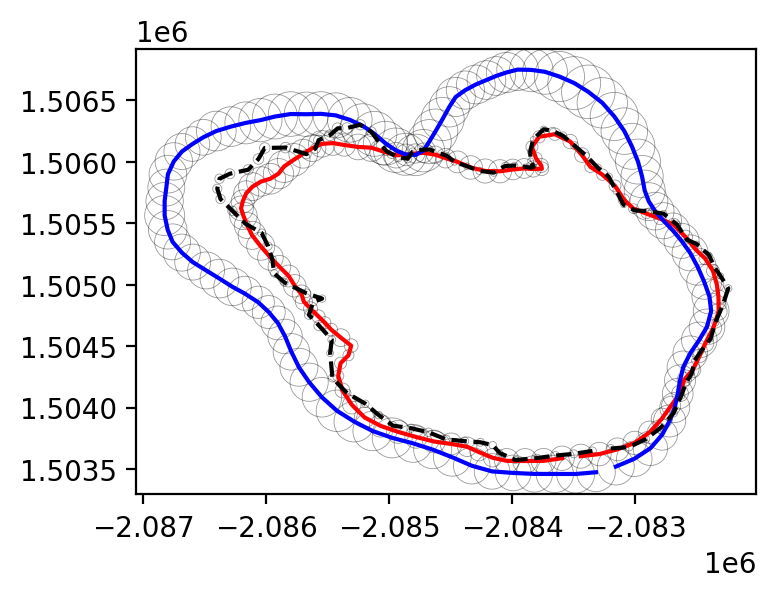

In [20]:
calix = 11
Xt = data['calculations'][calix]['Xt']
Y = data['calculations'][calix]['Y']
X = data['calculations'][calix]['X']

plot_alix = None

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

# plot_matrix_ensemble(Xt, plot_alix =plot_alix, color=(0,0,1,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)
# plot_matrix_ensemble(Y, plot_alix=plot_alix, color=(1,0,0,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)
# plot_matrix_ensemble(X, plot_alix=plot_alix, color=(0,0,0,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)

show_stdev = True
plot_matrix(Xt, show_stdev=show_stdev, ax=ax, color='red')
plot_matrix(Y, show_stdev=show_stdev, ax=ax, color='blue')
plot_matrix(X, show_stdev=show_stdev, ax=ax, color='black', ls='--')

In [134]:
def calculate_rms(geom1, geom2):
    g1, g2 = align_geoms([geom1, geom2], vertex_count=100)
    xy1 = np.array(g1.exterior.coords[:-1])
    xy2 = np.array(g2.exterior.coords[:-1])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

In [150]:
rms_errors_adjust = []
areadiff_errors_adjust = []
for i, calc in enumerate(data['calculations']):
    
    x = calc['X'].mean(axis=1)
    xgeom = Polygon(zip(x[::2], x[1::2]))
    rms_errors_adjust.append(calculate_rms(ground_truth_geoms_fixed[i], xgeom))
    areadiff_errors_adjust.append(calculate_area_diff(ground_truth_geoms_fixed[i], xgeom))

rms_errors_zero = []
areadiff_errors_zero = []
for i, calc in enumerate(data['calculations']):
    rms_errors_zero.append(calculate_rms(ground_truth_geoms_fixed[i], zero_information_sims[i]))
    areadiff_errors_zero.append(calculate_area_diff(ground_truth_geoms_fixed[i], zero_information_sims[i]))

/opt/conda/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


GEOSException: TopologyException: Input geom 1 is invalid: Self-intersection at -2083898.961696604 1502271.3277715931

/tmp/ipykernel_435/1723223533.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(range(7), areadiff_errors_adjust, 'k-', label='adjusted', ls='--')
/tmp/ipykernel_435/1723223533.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(range(7), areadiff_errors_zero, 'r-', label='zeroinfo', ls='--')


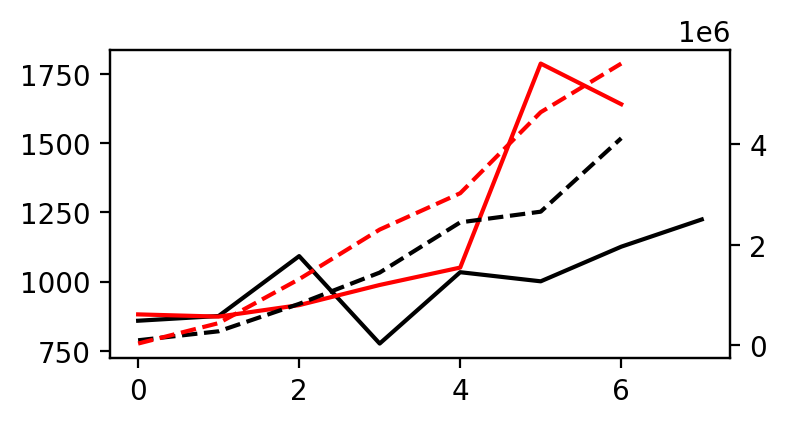

In [155]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
ax.plot(range(8), rms_errors_adjust, 'k-', label='adjusted')
ax.plot(range(7), rms_errors_zero, 'r-', label='zeroinfo')

ax2 = ax.twinx()
ax2.plot(range(7), areadiff_errors_adjust, 'k-', label='adjusted', ls='--')
ax2.plot(range(7), areadiff_errors_zero, 'r-', label='zeroinfo', ls='--')


## Repeat Calculations for Maria Fire


In [21]:
# Collect observations
maria_observations = []
for i in range(10):
    dfrow = usr.db.dfObservation.iloc[i]
    geom = gpd.read_file(dfrow['filepath'])['geometry'][0]
    
    maria_observations.append(geom)
    
windspeed_maria = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
winddirection_maria = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

### Generate no-observation simulations

In [22]:
%%time

# zero concurrent observations
# Considers the first observation as the ignition
dfrow_ignite = usr.db.dfObservation.iloc[0]

timestamp = dfrow_ignite['datetime']
ignition_geom = gpd.read_file(dfrow_ignite['filepath'])['geometry'][0]

zero_info_simulations = [ignition_geom]
for i in range(10):
    dfrow_pre = usr.db.dfObservation.iloc[i]
    dfrow_next = usr.db.dfObservation.iloc[i+1]
    dt = dfrow_next['datetime'] - dfrow_pre['datetime']
    
    ignition_geom = forward_pass(ignition_geom, params={'winddirection': winddirection_maria[i],
                                                        'windspeed': windspeed_maria[i],
                                                        'dt': dt})
    zero_info_simulations.append(ignition_geom)

Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '703e8cfd5a8c47c5b62b904a48c52415', 'compareidx': 'c5d5b2f948fe43eba720f48fb863a60f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3ced3091cac7495ea899b930b58b4c18', 'compareidx': 'cbb32a8d461a4a1b9ab0cad5c70cdcac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '97aba253dd8d4aaebd888968ec0a301d', 'compareidx': '5dc116fedd664beb8bcc827826105ec6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fcf12e329c1d49b0acdfba87554ef50c', 'compareidx': 'de1f46605f9349feb8ee89f300e648f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '2b514c79acde4a2ca955becf4c1afc4f', 'compareidx': 'cb61f4c00d5547489e9c0ad05d97fc11', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '088a6091384d42278609d55e283d9f22', 'compareidx': '576b0b06de0848d7ad058c73c678f39c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '96ef52b28570454fbfffbb91b9a941fa', 'compareidx': '407c2cf47f0f43099d3070e160684901', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb1facc3c25640d6b34904a3ed274900', 'compareidx': 'bbfc398c431b41bbbee622153497900b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'a438432f5dd64b628e396072140b0489', 'compareidx': 'ed13cc421bbb475297d756d110c48d09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '11861e53ba604975b3d312d0d221f18a', 'compareidx': '1b2a9a02941a42a2b4475ee22b27b18a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
CPU times: user 659 ms, sys: 23.3 ms, total: 682 ms
Wall time: 18.8 s


In [23]:
zero_info_simulations

[<POLYGON ((-2084217.148 1503560.461, -2084279.557 1503576.755, -2084348.612 ...>,
 <POLYGON ((-2084991 1504442, -2084936 1504448, -2084907 1504477, -2084884 15...>,
 <POLYGON ((-2085377 1504125, -2085351 1504106, -2085325 1504086, -2085286 15...>,
 <POLYGON ((-2085851 1503900, -2085847 1503863, -2085841 1503826, -2085822 15...>,
 <POLYGON ((-2086563 1503341, -2086561 1503296, -2086553 1503250, -2086549 15...>,
 <POLYGON ((-2087232 1501829, -2087224 1501800, -2087217 1501770, -2087204 15...>,
 <POLYGON ((-2087491 1501632, -2087485 1501578, -2087434 1501552, -2087412 15...>,
 <POLYGON ((-2087792 1501904, -2087786 1501875, -2087779 1501845, -2087748 15...>,
 <POLYGON ((-2087950 1502384, -2087921 1502352, -2087902 1502340, -2087862 15...>,
 <POLYGON ((-2088100 1501586, -2088097 1501538, -2088090 1501500, -2088070 15...>,
 <POLYGON ((-2088172 1502148, -2088164 1502112, -2088149 1502097, -2088125 15...>]

In [24]:
with open('/home/jovyan/data/maria_zero_observation_sim_08312023.pkl', 'wb') as f:
    pickle.dump(zero_info_simulations, f)
    

### Validate observed geometries

In [ ]:
observed_geoms_fixed = []
for geom in maria_observations:
    poly = validate_geom(geom)
    poly = validate_geom(interpolate_geom(poly, 100))
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    observed_geoms_fixed.append(poly)

In [ ]:
# ws = 10
# wd = 60 
######### wd and ws to be chosen from the runs during the live fire
nsamples = 500
vertex_count = 100

data = {'calculations': [],
        'parameters': {'nsamples': nsamples,
                       'vertex_count': vertex_count},
       }

In [ ]:
plt.hist(np.random.normal(winddirection_maria[0], scale=30, size=nsamples))

In [ ]:
%%time

for upix in range(1,len(observed_geoms_fixed)):
    print('------------------------------------')
    print('------------------------------------')
    print(f'Calculating {upix-1}-->{upix}')
    print('------------------------------------')
    print('------------------------------------')
    
    # Generate samples of (ws, wd)
    
    # wsar = np.array([windspeed_maria]*nsamples)
    # wdar = np.random.uniform(inddirection-45, winddirection+45, size=nsamples)
    wsar = np.random.normal(windspeed_maria[upix-1], scale=3, size=nsamples)
    wdar = np.random.normal(winddirection_maria[upix-1], scale=30, size=nsamples)

    if upix == 1:# First ensemble, use the first observation as the ignition
        initial_poly = observed_geoms_fixed[upix-1]
    else:
        # TODO: average of the state matrix
        Xmean = X.mean(axis=1)
        x,y = Xmean[::2], Xmean[1::2]
        initial_poly = Polygon(zip(x,y))
    
    Xt_geoms = []
    Y_geoms = []
    for i, (wsflt, wdflt) in enumerate(zip(wsar, wdar)):
        wsint = round(wsflt)
        wdint = np.fmod(round(wdflt)+360, 360)
        
        print(f'-- {upix-1}-->{upix} --\nCalculating wd={wdint}, ws={wsint} - {i}/{len(wdar)}')

        
        xtgeom = forward_pass(initial_poly, 
                              {'windspeed': wsint, 
                               'winddirection': wdint, 
                               'dt': datetime.timedelta(minutes=30)})
        if xtgeom is not None:
            Xt_geoms.append(xtgeom)
        
        sampled = sample_geometry(observed_geoms_fixed[upix], sigma=150)
        # Validate sample_poly
        sampled_validated = validate_geom(sampled)
        # Interpolate
        sampled_validated_interpolated = interpolate_geom(sampled_validated, vertex_count)
        # Validate again
        sampled_validated_2 = validate_geom(sampled_validated_interpolated)
        
        Y_geoms.append(sampled_validated_2)
        
    Y = geoms_to_matrix(Y_geoms, vertex_count=vertex_count, nsamples=nsamples)

    Ymean = Y.mean(axis=1)
    x,y = Ymean[::2], Ymean[1::2]
    aligned_geom = Polygon(zip(x,y))
    
    filled_count = nsamples-len(Xt_geoms)
    if filled_count > 0:
        Xt_geoms = fill_null_geoms(Xt_geoms, nsamples)
        
    Xt = geoms_to_matrix(Xt_geoms, vertex_count=vertex_count,  aligned_geom=aligned_geom, nsamples=nsamples)

    X = update_EnKF_2(Xt, Y)
    X = geoms_to_matrix(matrix_to_geom(X), vertex_count=vertex_count, aligned_geom = aligned_geom, nsamples=nsamples)
    
    data['calculations'].append({'initial_poly': initial_poly,
                                 'aligned_geom': aligned_geom,
                                 'filled_geoms': filled_count,
                                  'Xt': Xt, 'X': X, 'Y': Y,
                                  'wdar': wdar, 'wsar': wsar})
    
    with open('/home/jovyan/data/output_maria_08302023.pkl', 'wb') as f:
        pickle.dump(data, f)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4,), dpi=200)
# plot_geometry(zero_info_simulations[1], ax=ax, color=(1,0,0,0.2))
# plot_geometry(zero_info_simulations[2], ax=ax, color=(1,0,0,0.4))
# plot_geometry(zero_info_simulations[3], ax=ax, color=(1,0,0,0.6))
plot_geometry(zero_info_simulations[4], ax=ax, color=(1,0,0,1))

# plot_matrix(data['calculations'][0]['X'], ax=ax, color=(0,0,1,0.2))
# plot_matrix(data['calculations'][1]['X'], ax=ax, color=(0,0,1,0.4))
# plot_matrix(data['calculations'][2]['X'], ax=ax, color=(0,0,1,0.6))
plot_matrix(data['calculations'][3]['X'], ax=ax, color=(0,0,1,1))

# plot_matrix(data['calculations'][0]['Y'], ax=ax, color=(0,0,0,0.2), ls='--')
# plot_matrix(data['calculations'][1]['Y'], ax=ax, color=(0,0,0,0.4), ls='--')
# plot_matrix(data['calculations'][2]['Y'], ax=ax, color=(0,0,0,0.6), ls='--')
plot_matrix(data['calculations'][3]['Y'], ax=ax, color=(0,0,0,1), ls='--')

In [ ]:
with open('/home/jovyan/data/output_maria_08302023.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
calix = 4
Xt = data['calculations'][calix]['Xt']
Y = data['calculations'][calix]['Y']
X = data['calculations'][calix]['X']

plot_alix = None

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

# plot_matrix_ensemble(Xt, plot_alix =plot_alix, color=(0,0,1,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)
# plot_matrix_ensemble(Y, plot_alix=plot_alix, color=(1,0,0,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)
# plot_matrix_ensemble(X, plot_alix=plot_alix, color=(0,0,0,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)

show_stdev = True
plot_matrix(Xt, show_stdev=show_stdev, ax=ax, color='red')
plot_matrix(Y, show_stdev=show_stdev, ax=ax, color='blue')
plot_matrix(X, show_stdev=show_stdev, ax=ax, color='black', ls='--')